In [2]:
from torch import nn
import torch
import torch.nn.functional as F
import torch.utils.data as Data
from torch.nn import init
from torch.autograd import Variable
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
import warnings
import os
import pandas as pd
from matplotlib import cm
import pickle
import argparse
#from sparselearning.core import add_sparse_args, CosineDecay, Masking
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2'
warnings.filterwarnings('ignore')
def accuracy(y_hat, y):
    return (y_hat.argmax(axis=1) == y.astype('float32')).mean()#.asscalar()
def minmaxscaler(data,test):
    min = np.amin(data)
    max = np.amax(data)    
    return (data - min)/(max-min),(test-min)/(max-min)
def feature_normalize(data,test):
    mu = np.mean(data)
    std = np.std(data)
    return (data - mu)/std, (test-mu)/std
def to_number(x):
    if x=='BaseLine':
        return [0]
    else:
        lb = []
        for i in x:
            lb.append(int(i))
        return lb
BASE = "/mnt/sda1/jianwen/sidescan/"
def weights_init(m):
    classname = m.__class__.__name__
    # print(classname)
    if classname.find('Conv1d') != -1:
        init.xavier_normal_(m.weight.data)
        #init.constant_(m.bias.data, 0.0)
    elif classname.find('Linear') != -1:
        init.xavier_normal_(m.weight.data)
        init.constant_(m.bias.data, 0.0)
    elif classname.find('BatchNorm1d') != -1:
        init.constant_(m.weight.data, 1)
        init.constant_(m.bias.data, 0.0)
    #elif classname.find('LSTM') != -1:
    #    init.orthogonal(m.all_weights)
    #    init.constant_(m.bias.data, 0.0)
    #elif classname.find('InstanceNorm1d') != -1:
    #    init.constant_(m.weight.data, 1)
    #    init.constant_(m.bias.data, 0.0) 

import random
def data_iter(batch_size, features, labels):
    num_examples = features.shape[0]
    indices = list(range(num_examples))
    random.seed(epoch)
    random.shuffle(indices)  # 样本的读取顺序是随机的。
    for i in range(0, num_examples/batch_size*batch_size, batch_size):
        j = indices[i: min(i + batch_size, num_examples)]
        yield (torch.FloatTensor(features[j]), torch.LongTensor(labels[j]))  # take 函数根据索引返回对应元素。

def replace_layers(model, i, indexes, layers):
    if i in indexes:
        return layers[indexes.index(i)]
    return model[i]

def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    #lr = LR * (0.3 ** (epoch // 20))
    for param_group in optimizer.param_groups:
        param_group['lr'] *= 0.8

## ResNet

In [3]:
def conv(in_planes,out_planes,kernel_size=8,stride=1):                          
        "3x3 convolution with padding"
        return nn.Conv1d(
                in_planes,
                out_planes,
                kernel_size,
                stride=stride,
                padding=(kernel_size-1)/2,
                bias=False)

class BasicBlock(nn.Module):
        def __init__(self,in_planes,planes,kernel_size,stride=1,downsample=None):
                super(BasicBlock, self).__init__()
                self.conv1 = conv(in_planes,planes,kernel_size,1)
                self.bn1 = nn.BatchNorm1d(planes)
                self.relu = nn.ReLU()
                self.downsample = downsample
                self.stride = 1 
                #
                self.conv2 = conv(planes,planes,kernel_size,1)
                self.bn2 = nn.BatchNorm1d(planes)
                #
                self.conv3 = conv(planes,planes,kernel_size,1)
                self.bn3 = nn.BatchNorm1d(planes)
        def forward(self,x):
                residual = x
                out = self.conv1(x)
                out = self.bn1(out)
                out = self.relu(out)
                #
                out = self.conv2(out)
                out = self.bn2(out)
                out = self.relu(out)
                #                                                                                    
                out = self.conv3(out)
                out = self.bn3(out)
        
                if self.downsample is not None:
                    residual = self.downsample(x)  
                out += residual
                out = self.relu(out)
                return out 

class ResNet(nn.Module):
        def __init__(self,block,kernel_size,num_classes=6,in_planes=10):#block means BasicBlock
            self.in_planes = in_planes
            super(ResNet,self).__init__()
            self.layer1 = self._make_layer(block,kernel_size[0],64)
            self.layer2 = self._make_layer(block,kernel_size[1],128)
            self.layer3 = self._make_layer(block,kernel_size[2],128)
            
            self.avgpool = nn.AdaptiveAvgPool1d(1)
            self.fc = nn.Linear(128,num_classes)
            #for m in self.modules():
            #    if isinstance(m, nn.Conv1d) or isinstance(m,nn.Linear):
            #        nn.init.xavier_normal_(m.weight.data)
            #        nn.init.constant_(m.bias, 0)
            #    elif isinstance(m, nn.BatchNorm1d):
            #        nn.init.constant_(m.weight.data, 1)
            #        nn.init.constant_(m.bias.data, 0)
 
        def _make_layer(self, block, kernel_size, planes, stride=1):
            downsample = None
            if stride != 1 or self.in_planes != planes:
                downsample = nn.Sequential(
                nn.Conv1d(self.in_planes, planes,
                kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(planes),
              )
            layers = []
            layers.append(block(self.in_planes,planes,kernel_size,stride,downsample))
            self.in_planes = planes
            #for i in range(1,blocks):
            #       layers.append(block(self.inplanes,planes))
            return nn.Sequential(*layers)
        def forward(self,x):
            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)
            x = self.avgpool(x)
            x = x.view(x.size(0),-1)
            x = self.fc(x)
            return x

## FCN

In [3]:
def conv(in_planes,out_planes,kernel_size=8,stride=1):                          
        "3x3 convolution with padding"
        return nn.Sequential(nn.Conv1d(
                in_planes,
                out_planes,
                kernel_size,
                stride=stride,
                padding=(kernel_size-1)/2,
                bias=False),
                nn.BatchNorm1d(out_planes),
                nn.ReLU() )
       
class FCN(nn.Module):
        def __init__(self,num_classes=6,in_planes=17):#block means BasicBlock
            self.in_planes = in_planes
            super(FCN,self).__init__()
            self.conv1 = conv(in_planes,128,8,1) 
            self.conv2 = conv(128,256,5,1)
            self.conv3 = conv(256,128,3,1)
            self.avgpool = nn.AdaptiveAvgPool1d(1)
            self.fc = nn.Linear(128,num_classes)

        def forward(self,x):
            x = self.conv1(x)
            x = self.conv2(x)
            x = self.conv3(x)
            x = self.avgpool(x)
            x = x.view(x.size(0),-1)
            x = self.fc(x)
            return x

## LSTM

In [4]:
class Rnn(nn.Module):
    def __init__(self,in_dim=17, hidden_dim=128,n_layer=1,n_class=6):
        super(Rnn,self).__init__()
        self.num_layers = n_layer
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(in_dim,self.hidden_dim,self.num_layers,batch_first=True) #28，64
        self.fc = nn.Linear(hidden_dim, n_class)
    def forward(self,x):
        out,_ = self.lstm(x)
        out = out[:,-1,:]
        out = self.fc(out)
        return out

## MLP

In [5]:
def mlp(x,cl = 5): 
    hidden = 500
    net = torch.nn.Sequential(
                    torch.nn.Dropout(0.1), 
                    torch.nn.Linear(x, hidden),
                    torch.nn.ReLU(),
                    torch.nn.Dropout(0.2),  
                    torch.nn.Linear(hidden, hidden),
                    torch.nn.ReLU(),
                    torch.nn.Dropout(0.2),
                    torch.nn.Linear(hidden, hidden),
                    torch.nn.ReLU(),
                    torch.nn.Dropout(0.3),  # drop 50% of the neuron
                    torch.nn.Linear(hidden, cl),
                )
    return net

# ResEncoder

In [4]:
def conv(in_planes,out_planes,kernel_size=8,stride=1):                          
        "3x3 convolution with padding"
        return nn.Conv1d(
                in_planes,
                out_planes,
                kernel_size,
                stride=stride,
                padding=(kernel_size-1)/2,
                bias=False)

class BasicBlock(nn.Module):
        def __init__(self,in_planes,planes,kernel_size,stride=1,downsample=None):
                super(BasicBlock, self).__init__()
                self.conv1 = conv(in_planes,planes,kernel_size,1)
                self.bn1 = nn.BatchNorm1d(planes)
                self.relu = nn.ReLU()
                self.downsample = downsample
                self.stride = 1 
                #
                self.conv2 = conv(planes,planes,kernel_size,1)
                self.bn2 = nn.BatchNorm1d(planes)
                #
                self.conv3 = conv(planes,planes,kernel_size,1)
                self.bn3 = nn.BatchNorm1d(planes)
        def forward(self,x):
                residual = x
                out = self.conv1(x)
                out = self.bn1(out)
                out = self.relu(out)
                #
                out = self.conv2(out)
                out = self.bn2(out)
                out = self.relu(out)
                #                                                                                    
                out = self.conv3(out)
                out = self.bn3(out)
        
                if self.downsample is not None:
                    residual = self.downsample(x)  
                out += residual
                out = self.relu(out)
                return out 
    
class ResEncoder(nn.Module):
        def __init__(self,block,kernel_size,num_classes=6,in_planes=10):#block means BasicBlock
            self.in_planes = in_planes
            super(ResEncoder,self).__init__()
            self.layer1 = self._make_layer(block,kernel_size[0],64)#128)
            self.layer2 = self._make_layer(block,kernel_size[1],128)#256)
            self.layer3 = self._make_layer(block,kernel_size[2],128)#512)
            
            self.pool = nn.MaxPool1d(2,stride=2)
            #self.avgpool = nn.AdaptiveAvgPool1d(1)
            self.fc = nn.Linear(64,num_classes)
            self.softmax = torch.nn.Softmax(dim=1)
            #self.inm = nn.InstanceNorm1d(256)
 
        def _make_layer(self, block, kernel_size, planes, stride=1):
            downsample = None
            if stride != 1 or self.in_planes != planes:
                downsample = nn.Sequential(
                nn.Conv1d(self.in_planes, planes,
                kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(planes),
              )
            layers = []
            layers.append(block(self.in_planes,planes,kernel_size,stride,downsample))
            self.in_planes = planes
            #for i in range(1,blocks):
            #       layers.append(block(self.inplanes,planes))
            return nn.Sequential(*layers)
        
        def forward(self,x):
            x = self.layer1(x)
            x = self.pool(x)
            x = self.layer2(x)
            x = self.pool(x)
            x = self.layer3(x) #batch,512,60 
            x = x[:,x.size(1)/2:,:].mul(self.softmax(x[:,:x.size(1)/2,:])) #batch,256,60
            x = x.sum(2)
            x = x.view(x.size(0),-1)
            #x = self.inm(x)
            x = self.fc(x)
            return x

## Encode

In [7]:
def conv(in_planes,out_planes,kernel_size=8,stride=1):                          
        "3x3 convolution with padding"
        return nn.Sequential(nn.Conv1d(
                in_planes,
                out_planes,
                kernel_size,
                stride=stride,
                padding=(kernel_size-1)/2,
                bias=False),
                nn.BatchNorm1d(out_planes),
                nn.ReLU() )

class ConvBlock(nn.Module):
        def __init__(self,in_planes,planes,kernel_size,stride=1):
            super(ConvBlock, self).__init__()
            self.conv = conv(in_planes,planes,kernel_size,1)
            self.inn = nn.InstanceNorm1d(planes)
            self.prelu = nn.PReLU()
            self.dropout = nn.Dropout(0.2)
            self.stride = 1         
        def forward(self,x):
            out = self.conv(x)
            out = self.inn(out)
            out = self.prelu(out)
            out = self.dropout(out)
            return out 
             
class encode(nn.Module):
        def __init__(self,block, num_classes=6,in_planes=17,stride=1):#block means BasicBlock
            self.in_planes = in_planes
            super(encode,self).__init__()
            self.conv1 = block(self.in_planes,128,5,stride)
            self.conv2 = block(128,256,11,stride)
            self.conv3 = block(256,128,21,stride)
            self.fc = nn.Linear(64,num_classes)
            self.pool = nn.MaxPool1d(2,stride=2)
            #self.avgpool = nn.AdaptiveAvgPool1d(1)
            self.softmax = torch.nn.Softmax(dim=1)
            
        def forward(self,x):
            x = self.conv1(x)
            x = self.pool(x)
            x = self.conv2(x)
            x = self.pool(x)
            x = self.conv3(x)
            x = x[:,x.size(1)/2:,:].mul(self.softmax(x[:,:x.size(1)/2,:])) #batch,256,60
            x = x.sum(2)
            x = x.view(x.size(0),-1)
            x = self.fc(x)
            return x

In [ ]:
30/net_encoder_20p1.pkl|net_lstm_100p1.pkl|net_fcn_100p1.pkl|resnet_noisy_model.pkl|
net_mlp_100p1.pkl|net_originalencoder_100p1.pkl

sparse/net_encoder_20p1.pkl|net_lstm_100p.pkl|net_fcn_100p.pkl|net_res_100p.pkl|
net_mlp_100p.pkl|net_originalencode_100p.pkl

sparsemodel/net_encoder_p'+str(num)+'.pkl

In [48]:
net = torch.load('30/net_mlp_100p.pkl')

In [49]:
net #K×Cin×out×Cout

Sequential(
  (0): Dropout(p=0.1)
  (1): Linear(in_features=1020, out_features=500, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2)
  (4): Linear(in_features=500, out_features=500, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.2)
  (7): Linear(in_features=500, out_features=500, bias=True)
  (8): ReLU()
  (9): Dropout(p=0.3)
  (10): Linear(in_features=500, out_features=6, bias=True)
)

In [51]:
dataset,label = pickle.load(open('8-27/data.pkl','rb'))
dataset = dataset[:,:,1:].swapaxes(1,2).astype('int')

In [43]:
5*60*17*128+11*60*256*128+21*256*128*60+64*6  #63M
#1M

63567744

In [39]:
MLP
1020*500+500*500*2+500*6 #1M
   # 1M

1013000

In [34]:
8*60*17*128+5*60*128*256+3*60*256*128+128*6

16773888

In [28]:
(9*60*17*64)+(60*17*64)+(9*60*64*64)*2+\
(5*60*64*128)+(60*64*128)+(5*60*128*128)*2+\
(3*60*128*128)+(60*128*128)+(3*60*128*128)*2+\
128*5  #27.7M MAdds
sum(param.numel() for param in net.parameters())#  0.4M 
#Resnet  Resencoder

27687040

In [24]:
LSTM
(128+60)*128*4+128*6 #0.097M
sum(param.numel() for param in net.parameters())#lstm 76k

76038

In [ ]:
FCN
8*60*17*128+5*60*128*256+3*60*256*128+128*6 #16773888 16.8M
#0.3M

In [50]:
sum(param.numel() for param in net.parameters())

1014506

## Res

In [4]:
BASE = "/mnt/sda1/jianwen/sidescan/"

In [5]:
dataset,label = pickle.load(open(BASE+'data/multiple_mx.pkl','rb'))

In [6]:
for i in range(0,7):
    print len(label[label==i])

3000
1095
1095
2493
2249
3379
2699


In [47]:
#pickle.dump([dataset,label],open(BASE+'data/multiple_mx1.pkl','wb'))

In [ ]:
del net  
torch.cuda.empty_cache() 
time.sleep(5)

In [10]:
from scipy.sparse import vstack
import gc
import pickle
density = 100
for num in [30]:
    for typ in ['noisy']:
        print 'Start..'
        dataset,label = pickle.load(open(BASE+'data/multiple_mx.pkl','rb'))
        dataset = dataset.swapaxes(1,2).astype('float')
        #filter
        print dataset.shape
        for i in range(7):
            print label[label==i].shape
        from sklearn.model_selection import StratifiedKFold
        skf = StratifiedKFold(n_splits=5, random_state=42)
        print 'Start:',num
        for n, (train, test) in enumerate(skf.split(dataset,label)):
            best_accuracy = 0
            print train, test
            print np.array(dataset)[train].shape, np.array(dataset)[test].shape
            # feature selection
            x_train = np.array(dataset)[train]
            x_t = np.array(dataset)[test]
            x_t = torch.FloatTensor(np.array(dataset)[test]).cuda()
            y = label[train]
            y_test = label[test]
            #break
            print 'y:',y.shape,'y_test:',y_test.shape
            #break
            sp = 10
            epochs = 1500
            batch_size = x_train.shape[0]/sp#1000#
            # Training
            print x_train.shape
            #define network
            net = ResNet(BasicBlock,[9,5,3],7,17)
            net = nn.DataParallel(net)
            net = net.cuda()
            
            net.apply(weights_init) 
            LR = 0.01
            #break
            loss_func = torch.nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(net.parameters(), lr=LR, betas=(0.9, 0.999)) 
            mask = None
            net.train()
            #train          
            for epoch in range(epochs):  
                sum_loss = 0
                for step,(batch_x,batch_y) in enumerate(data_iter(batch_size,x_train,y)):
                        batch_x = Variable(batch_x).cuda()
                        batch_y = Variable(batch_y).cuda()
                        outputs = net(batch_x)
                        loss = loss_func(outputs,batch_y)    
                        optimizer.zero_grad()
                        loss.backward()                     # calculate the gradients
                        sum_loss += loss.item()
                        if mask is not None:mask.step()
                        else:optimizer.step()
                        if mask is not None and epoch<epochs:
                            mask.at_end_of_epoch()
                        gc.collect()
                        if (step+1) % sp == 0:
                            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                                        epoch, (step+1)*batch_size, x_train.shape[0],
                                        100*batch_size * (step+1) / x_train.shape[0], sum_loss/sp))
                            #loss_set[density].append(sum_loss/sp)
                            sum_loss = 0
                            net.eval()
                            y_pred = F.softmax(net(x_t)).cpu()
                            macro = f1_score(y_test,y_pred.detach().numpy().argmax(axis=1),labels=[0,1,2,3,4,5,6],average='macro')
                            acc = accuracy(y_pred.detach().numpy(),y_test)
                            net.train()
                            if macro>best_accuracy:
                                best_accuracy = macro
                                beat_epoch = epoch
                                torch.save(net,BASE+'model/net_res_'+str(n)+'.pkl')
                            print 'Train Epoch: {}, Test Accuracy:{}, Macro F1:{}'.format(epoch,acc,macro) 
            print best_accuracy
        print 'Done!'

Start..
(16010, 17, 60)
(3000,)
(1095,)
(1095,)
(2493,)
(2249,)
(3379,)
(2699,)
Start: 30
[ 1323  1329  1335 ... 16007 16008 16009] [    0     1     2 ... 13607 13608 13609]
(12807, 17, 60) (3203, 17, 60)
y: (12807,) y_test: (3203,)
(12807, 17, 60)
Train Epoch: 0 [12800/12807 (99%)]	Loss: 2.214927
Train Epoch: 0, Test Accuracy:0.257571027162, Macro F1:0.13079720121
Train Epoch: 1 [12800/12807 (99%)]	Loss: 1.666332
Train Epoch: 1, Test Accuracy:0.198251639088, Macro F1:0.122966942966
Train Epoch: 2 [12800/12807 (99%)]	Loss: 1.502613
Train Epoch: 2, Test Accuracy:0.139556665626, Macro F1:0.118768691015
Train Epoch: 3 [12800/12807 (99%)]	Loss: 1.422593
Train Epoch: 3, Test Accuracy:0.133936934124, Macro F1:0.122240257755
Train Epoch: 4 [12800/12807 (99%)]	Loss: 1.382140
Train Epoch: 4, Test Accuracy:0.205432407118, Macro F1:0.155154603912
Train Epoch: 5 [12800/12807 (99%)]	Loss: 1.354841
Train Epoch: 5, Test Accuracy:0.143303153294, Macro F1:0.12964091651
Train Epoch: 6 [12800/12807 (99%)

Train Epoch: 66 [12800/12807 (99%)]	Loss: 0.758674
Train Epoch: 66, Test Accuracy:0.241960661879, Macro F1:0.228111437773
Train Epoch: 67 [12800/12807 (99%)]	Loss: 0.761238
Train Epoch: 67, Test Accuracy:0.300031220731, Macro F1:0.304085060717
Train Epoch: 68 [12800/12807 (99%)]	Loss: 0.747545
Train Epoch: 68, Test Accuracy:0.334998438963, Macro F1:0.355160569597
Train Epoch: 69 [12800/12807 (99%)]	Loss: 0.750361
Train Epoch: 69, Test Accuracy:0.293162660006, Macro F1:0.294466103152
Train Epoch: 70 [12800/12807 (99%)]	Loss: 0.742394
Train Epoch: 70, Test Accuracy:0.336559475492, Macro F1:0.264440504642
Train Epoch: 71 [12800/12807 (99%)]	Loss: 0.744265
Train Epoch: 71, Test Accuracy:0.271308148611, Macro F1:0.243275588818
Train Epoch: 72 [12800/12807 (99%)]	Loss: 0.739401
Train Epoch: 72, Test Accuracy:0.241024039963, Macro F1:0.220986519236
Train Epoch: 73 [12800/12807 (99%)]	Loss: 0.741191
Train Epoch: 73, Test Accuracy:0.28067436778, Macro F1:0.326588209607
Train Epoch: 74 [12800/12

Train Epoch: 133 [12800/12807 (99%)]	Loss: 0.524108
Train Epoch: 133, Test Accuracy:0.312519512957, Macro F1:0.340889666288
Train Epoch: 134 [12800/12807 (99%)]	Loss: 0.527739
Train Epoch: 134, Test Accuracy:0.350921011552, Macro F1:0.374740252344
Train Epoch: 135 [12800/12807 (99%)]	Loss: 0.543207
Train Epoch: 135, Test Accuracy:0.249453637215, Macro F1:0.264176864756
Train Epoch: 136 [12800/12807 (99%)]	Loss: 0.522835
Train Epoch: 136, Test Accuracy:0.253824539494, Macro F1:0.228376625066
Train Epoch: 137 [12800/12807 (99%)]	Loss: 0.528537
Train Epoch: 137, Test Accuracy:0.294099281923, Macro F1:0.318619596052
Train Epoch: 138 [12800/12807 (99%)]	Loss: 0.520715
Train Epoch: 138, Test Accuracy:0.239463003434, Macro F1:0.271495280429
Train Epoch: 139 [12800/12807 (99%)]	Loss: 0.507500
Train Epoch: 139, Test Accuracy:0.252887917577, Macro F1:0.261823988693
Train Epoch: 140 [12800/12807 (99%)]	Loss: 0.492676
Train Epoch: 140, Test Accuracy:0.314080549485, Macro F1:0.335939859383
Train Ep

Train Epoch: 200 [12800/12807 (99%)]	Loss: 0.373007
Train Epoch: 200, Test Accuracy:0.230096784265, Macro F1:0.211430322644
Train Epoch: 201 [12800/12807 (99%)]	Loss: 0.383596
Train Epoch: 201, Test Accuracy:0.244146113019, Macro F1:0.226473716505
Train Epoch: 202 [12800/12807 (99%)]	Loss: 0.362837
Train Epoch: 202, Test Accuracy:0.271308148611, Macro F1:0.307940450616
Train Epoch: 203 [12800/12807 (99%)]	Loss: 0.359402
Train Epoch: 203, Test Accuracy:0.287542928505, Macro F1:0.297492723093
Train Epoch: 204 [12800/12807 (99%)]	Loss: 0.367507
Train Epoch: 204, Test Accuracy:0.292538245395, Macro F1:0.337063889502
Train Epoch: 205 [12800/12807 (99%)]	Loss: 0.375923
Train Epoch: 205, Test Accuracy:0.258819856385, Macro F1:0.265576717171
Train Epoch: 206 [12800/12807 (99%)]	Loss: 0.365652
Train Epoch: 206, Test Accuracy:0.244458320325, Macro F1:0.249952508002
Train Epoch: 207 [12800/12807 (99%)]	Loss: 0.362960
Train Epoch: 207, Test Accuracy:0.229472369653, Macro F1:0.229001797189
Train Ep

Train Epoch: 267 [12800/12807 (99%)]	Loss: 0.297455
Train Epoch: 267, Test Accuracy:0.245394942242, Macro F1:0.212218749502
Train Epoch: 268 [12800/12807 (99%)]	Loss: 0.288371
Train Epoch: 268, Test Accuracy:0.1988760537, Macro F1:0.234388491812
Train Epoch: 269 [12800/12807 (99%)]	Loss: 0.287554
Train Epoch: 269, Test Accuracy:0.245082734936, Macro F1:0.277295126892
Train Epoch: 270 [12800/12807 (99%)]	Loss: 0.279270
Train Epoch: 270, Test Accuracy:0.245082734936, Macro F1:0.281736885789
Train Epoch: 271 [12800/12807 (99%)]	Loss: 0.276033
Train Epoch: 271, Test Accuracy:0.334686231658, Macro F1:0.396092341936
Train Epoch: 272 [12800/12807 (99%)]	Loss: 0.266969
Train Epoch: 272, Test Accuracy:0.190446456447, Macro F1:0.187476386993
Train Epoch: 273 [12800/12807 (99%)]	Loss: 0.272101
Train Epoch: 273, Test Accuracy:0.276615672807, Macro F1:0.333913795268
Train Epoch: 274 [12800/12807 (99%)]	Loss: 0.270665
Train Epoch: 274, Test Accuracy:0.233843271933, Macro F1:0.198218501688
Train Epoc

Train Epoch: 334 [12800/12807 (99%)]	Loss: 0.224409
Train Epoch: 334, Test Accuracy:0.249453637215, Macro F1:0.235994930205
Train Epoch: 335 [12800/12807 (99%)]	Loss: 0.218177
Train Epoch: 335, Test Accuracy:0.420855448017, Macro F1:0.502527208739
Train Epoch: 336 [12800/12807 (99%)]	Loss: 0.216881
Train Epoch: 336, Test Accuracy:0.257571027162, Macro F1:0.261156036974
Train Epoch: 337 [12800/12807 (99%)]	Loss: 0.221147
Train Epoch: 337, Test Accuracy:0.269122697471, Macro F1:0.295158615659
Train Epoch: 338 [12800/12807 (99%)]	Loss: 0.220511
Train Epoch: 338, Test Accuracy:0.25195129566, Macro F1:0.241883426025
Train Epoch: 339 [12800/12807 (99%)]	Loss: 0.229767
Train Epoch: 339, Test Accuracy:0.290665001561, Macro F1:0.272992404644
Train Epoch: 340 [12800/12807 (99%)]	Loss: 0.221897
Train Epoch: 340, Test Accuracy:0.409615985014, Macro F1:0.437649652832
Train Epoch: 341 [12800/12807 (99%)]	Loss: 0.221118
Train Epoch: 341, Test Accuracy:0.33812051202, Macro F1:0.36171758693
Train Epoch

Train Epoch: 401 [12800/12807 (99%)]	Loss: 0.158688
Train Epoch: 401, Test Accuracy:0.284733062754, Macro F1:0.342568685403
Train Epoch: 402 [12800/12807 (99%)]	Loss: 0.162002
Train Epoch: 402, Test Accuracy:0.161411177022, Macro F1:0.268575550366
Train Epoch: 403 [12800/12807 (99%)]	Loss: 0.156465
Train Epoch: 403, Test Accuracy:0.334061817047, Macro F1:0.341790091676
Train Epoch: 404 [12800/12807 (99%)]	Loss: 0.154897
Train Epoch: 404, Test Accuracy:0.242585076491, Macro F1:0.231820101887
Train Epoch: 405 [12800/12807 (99%)]	Loss: 0.157840
Train Epoch: 405, Test Accuracy:0.240087418046, Macro F1:0.240184731193
Train Epoch: 406 [12800/12807 (99%)]	Loss: 0.157495
Train Epoch: 406, Test Accuracy:0.225725881986, Macro F1:0.222411877856
Train Epoch: 407 [12800/12807 (99%)]	Loss: 0.165154
Train Epoch: 407, Test Accuracy:0.243209491102, Macro F1:0.233570205008
Train Epoch: 408 [12800/12807 (99%)]	Loss: 0.167283
Train Epoch: 408, Test Accuracy:0.288479550421, Macro F1:0.320946036945
Train Ep

Train Epoch: 468 [12800/12807 (99%)]	Loss: 0.111161
Train Epoch: 468, Test Accuracy:0.2375897596, Macro F1:0.21044756151
Train Epoch: 469 [12800/12807 (99%)]	Loss: 0.113280
Train Epoch: 469, Test Accuracy:0.21105213862, Macro F1:0.225139294901
Train Epoch: 470 [12800/12807 (99%)]	Loss: 0.104980
Train Epoch: 470, Test Accuracy:0.313456134874, Macro F1:0.316616879331
Train Epoch: 471 [12800/12807 (99%)]	Loss: 0.097858
Train Epoch: 471, Test Accuracy:0.251326881049, Macro F1:0.228995694703
Train Epoch: 472 [12800/12807 (99%)]	Loss: 0.100765
Train Epoch: 472, Test Accuracy:0.324071183266, Macro F1:0.31499937175
Train Epoch: 473 [12800/12807 (99%)]	Loss: 0.116195
Train Epoch: 473, Test Accuracy:0.239150796129, Macro F1:0.209674267791
Train Epoch: 474 [12800/12807 (99%)]	Loss: 0.125456
Train Epoch: 474, Test Accuracy:0.23040899157, Macro F1:0.243885800184
Train Epoch: 475 [12800/12807 (99%)]	Loss: 0.124359
Train Epoch: 475, Test Accuracy:0.242585076491, Macro F1:0.224931300106
Train Epoch: 4

Train Epoch: 535 [12800/12807 (99%)]	Loss: 0.083084
Train Epoch: 535, Test Accuracy:0.268810490165, Macro F1:0.294741673579
Train Epoch: 536 [12800/12807 (99%)]	Loss: 0.067610
Train Epoch: 536, Test Accuracy:0.253200124883, Macro F1:0.260443508628
Train Epoch: 537 [12800/12807 (99%)]	Loss: 0.060872
Train Epoch: 537, Test Accuracy:0.261629722135, Macro F1:0.25837491195
Train Epoch: 538 [12800/12807 (99%)]	Loss: 0.066245
Train Epoch: 538, Test Accuracy:0.236653137683, Macro F1:0.187946030678
Train Epoch: 539 [12800/12807 (99%)]	Loss: 0.067736
Train Epoch: 539, Test Accuracy:0.334374024352, Macro F1:0.390098385863
Train Epoch: 540 [12800/12807 (99%)]	Loss: 0.068473
Train Epoch: 540, Test Accuracy:0.337808304714, Macro F1:0.351062041497
Train Epoch: 541 [12800/12807 (99%)]	Loss: 0.080092
Train Epoch: 541, Test Accuracy:0.237277552295, Macro F1:0.227106746692
Train Epoch: 542 [12800/12807 (99%)]	Loss: 0.094310
Train Epoch: 542, Test Accuracy:0.261629722135, Macro F1:0.276392789544
Train Epo

Train Epoch: 602 [12800/12807 (99%)]	Loss: 0.084534
Train Epoch: 602, Test Accuracy:0.283484233531, Macro F1:0.253786770449
Train Epoch: 603 [12800/12807 (99%)]	Loss: 0.085870
Train Epoch: 603, Test Accuracy:0.248517015298, Macro F1:0.268078521849
Train Epoch: 604 [12800/12807 (99%)]	Loss: 0.073426
Train Epoch: 604, Test Accuracy:0.57571027162, Macro F1:0.603674128659
Train Epoch: 605 [12800/12807 (99%)]	Loss: 0.073448
Train Epoch: 605, Test Accuracy:0.482048079925, Macro F1:0.555148275316
Train Epoch: 606 [12800/12807 (99%)]	Loss: 0.073218
Train Epoch: 606, Test Accuracy:0.28067436778, Macro F1:0.30008246618
Train Epoch: 607 [12800/12807 (99%)]	Loss: 0.052697
Train Epoch: 607, Test Accuracy:0.253200124883, Macro F1:0.256488671737
Train Epoch: 608 [12800/12807 (99%)]	Loss: 0.047783
Train Epoch: 608, Test Accuracy:0.209491102092, Macro F1:0.221376652518
Train Epoch: 609 [12800/12807 (99%)]	Loss: 0.042689
Train Epoch: 609, Test Accuracy:0.178582578832, Macro F1:0.213561915571
Train Epoch

Train Epoch: 669 [12800/12807 (99%)]	Loss: 0.058599
Train Epoch: 669, Test Accuracy:0.235404308461, Macro F1:0.208245257315
Train Epoch: 670 [12800/12807 (99%)]	Loss: 0.045938
Train Epoch: 670, Test Accuracy:0.253200124883, Macro F1:0.244623508913
Train Epoch: 671 [12800/12807 (99%)]	Loss: 0.042787
Train Epoch: 671, Test Accuracy:0.368716827974, Macro F1:0.384141138316
Train Epoch: 672 [12800/12807 (99%)]	Loss: 0.051522
Train Epoch: 672, Test Accuracy:0.276303465501, Macro F1:0.294777474396
Train Epoch: 673 [12800/12807 (99%)]	Loss: 0.033717
Train Epoch: 673, Test Accuracy:0.232282235404, Macro F1:0.205087540534
Train Epoch: 674 [12800/12807 (99%)]	Loss: 0.037175
Train Epoch: 674, Test Accuracy:0.224164845457, Macro F1:0.190713761331
Train Epoch: 675 [12800/12807 (99%)]	Loss: 0.036339
Train Epoch: 675, Test Accuracy:0.250078051826, Macro F1:0.257605355472
Train Epoch: 676 [12800/12807 (99%)]	Loss: 0.033174
Train Epoch: 676, Test Accuracy:0.217608492039, Macro F1:0.190908704161
Train Ep

Train Epoch: 736 [12800/12807 (99%)]	Loss: 0.056240
Train Epoch: 736, Test Accuracy:0.233843271933, Macro F1:0.244159392453
Train Epoch: 737 [12800/12807 (99%)]	Loss: 0.050377
Train Epoch: 737, Test Accuracy:0.273805807056, Macro F1:0.280626868202
Train Epoch: 738 [12800/12807 (99%)]	Loss: 0.039816
Train Epoch: 738, Test Accuracy:0.216671870122, Macro F1:0.227506231834
Train Epoch: 739 [12800/12807 (99%)]	Loss: 0.030019
Train Epoch: 739, Test Accuracy:0.275054636278, Macro F1:0.294153530275
Train Epoch: 740 [12800/12807 (99%)]	Loss: 0.028232
Train Epoch: 740, Test Accuracy:0.308460817983, Macro F1:0.34188567527
Train Epoch: 741 [12800/12807 (99%)]	Loss: 0.023488
Train Epoch: 741, Test Accuracy:0.325007805183, Macro F1:0.363443472587
Train Epoch: 742 [12800/12807 (99%)]	Loss: 0.023463
Train Epoch: 742, Test Accuracy:0.225725881986, Macro F1:0.212653358373
Train Epoch: 743 [12800/12807 (99%)]	Loss: 0.021075
Train Epoch: 743, Test Accuracy:0.21604745551, Macro F1:0.247458291675
Train Epoc

Train Epoch: 803 [12800/12807 (99%)]	Loss: 0.065736
Train Epoch: 803, Test Accuracy:0.217920699344, Macro F1:0.178051516388
Train Epoch: 804 [12800/12807 (99%)]	Loss: 0.064482
Train Epoch: 804, Test Accuracy:0.24695597877, Macro F1:0.237068469073
Train Epoch: 805 [12800/12807 (99%)]	Loss: 0.053622
Train Epoch: 805, Test Accuracy:0.257571027162, Macro F1:0.268458770392
Train Epoch: 806 [12800/12807 (99%)]	Loss: 0.052706
Train Epoch: 806, Test Accuracy:0.226662503903, Macro F1:0.251362372962
Train Epoch: 807 [12800/12807 (99%)]	Loss: 0.047170
Train Epoch: 807, Test Accuracy:0.237901966906, Macro F1:0.223897089792
Train Epoch: 808 [12800/12807 (99%)]	Loss: 0.038335
Train Epoch: 808, Test Accuracy:0.375273181392, Macro F1:0.393975624153
Train Epoch: 809 [12800/12807 (99%)]	Loss: 0.031555
Train Epoch: 809, Test Accuracy:0.209803309397, Macro F1:0.210443096152
Train Epoch: 810 [12800/12807 (99%)]	Loss: 0.027150
Train Epoch: 810, Test Accuracy:0.256322197939, Macro F1:0.282292078358
Train Epo

Train Epoch: 870 [12800/12807 (99%)]	Loss: 0.049587
Train Epoch: 870, Test Accuracy:0.156728067437, Macro F1:0.178945520665
Train Epoch: 871 [12800/12807 (99%)]	Loss: 0.057593
Train Epoch: 871, Test Accuracy:0.274118014362, Macro F1:0.301726456667
Train Epoch: 872 [12800/12807 (99%)]	Loss: 0.057555
Train Epoch: 872, Test Accuracy:0.405557290041, Macro F1:0.482593843385
Train Epoch: 873 [12800/12807 (99%)]	Loss: 0.068410
Train Epoch: 873, Test Accuracy:0.23040899157, Macro F1:0.230369988666
Train Epoch: 874 [12800/12807 (99%)]	Loss: 0.071415
Train Epoch: 874, Test Accuracy:0.271620355916, Macro F1:0.282903186552
Train Epoch: 875 [12800/12807 (99%)]	Loss: 0.071540
Train Epoch: 875, Test Accuracy:0.2541367468, Macro F1:0.250794401352
Train Epoch: 876 [12800/12807 (99%)]	Loss: 0.076221
Train Epoch: 876, Test Accuracy:0.158913518576, Macro F1:0.14677411817
Train Epoch: 877 [12800/12807 (99%)]	Loss: 0.062430
Train Epoch: 877, Test Accuracy:0.267249453637, Macro F1:0.301061135021
Train Epoch:

Train Epoch: 937 [12800/12807 (99%)]	Loss: 0.072086
Train Epoch: 937, Test Accuracy:0.287542928505, Macro F1:0.31001520777
Train Epoch: 938 [12800/12807 (99%)]	Loss: 0.058534
Train Epoch: 938, Test Accuracy:0.260693100219, Macro F1:0.254780834005
Train Epoch: 939 [12800/12807 (99%)]	Loss: 0.071180
Train Epoch: 939, Test Accuracy:0.31876365907, Macro F1:0.322112625688
Train Epoch: 940 [12800/12807 (99%)]	Loss: 0.064936
Train Epoch: 940, Test Accuracy:0.120199812676, Macro F1:0.105616239894
Train Epoch: 941 [12800/12807 (99%)]	Loss: 0.057889
Train Epoch: 941, Test Accuracy:0.134561348736, Macro F1:0.14893500457
Train Epoch: 942 [12800/12807 (99%)]	Loss: 0.053731
Train Epoch: 942, Test Accuracy:0.239150796129, Macro F1:0.254494441539
Train Epoch: 943 [12800/12807 (99%)]	Loss: 0.047894
Train Epoch: 943, Test Accuracy:0.249765844521, Macro F1:0.236620803201
Train Epoch: 944 [12800/12807 (99%)]	Loss: 0.039870
Train Epoch: 944, Test Accuracy:0.368716827974, Macro F1:0.41349913296
Train Epoch:

Train Epoch: 1004 [12800/12807 (99%)]	Loss: 0.003051
Train Epoch: 1004, Test Accuracy:0.226974711208, Macro F1:0.195438725436
Train Epoch: 1005 [12800/12807 (99%)]	Loss: 0.002775
Train Epoch: 1005, Test Accuracy:0.221667187012, Macro F1:0.206984436216
Train Epoch: 1006 [12800/12807 (99%)]	Loss: 0.002257
Train Epoch: 1006, Test Accuracy:0.573837027786, Macro F1:0.619651362053
Train Epoch: 1007 [12800/12807 (99%)]	Loss: 0.005556
Train Epoch: 1007, Test Accuracy:0.369029035279, Macro F1:0.387417085081
Train Epoch: 1008 [12800/12807 (99%)]	Loss: 0.004517
Train Epoch: 1008, Test Accuracy:0.240087418046, Macro F1:0.26194015819
Train Epoch: 1009 [12800/12807 (99%)]	Loss: 0.004576
Train Epoch: 1009, Test Accuracy:0.320012488292, Macro F1:0.305690706233
Train Epoch: 1010 [12800/12807 (99%)]	Loss: 0.004486
Train Epoch: 1010, Test Accuracy:0.316266000624, Macro F1:0.279716821477
Train Epoch: 1011 [12800/12807 (99%)]	Loss: 0.004996
Train Epoch: 1011, Test Accuracy:0.22322822354, Macro F1:0.2335367

Train Epoch: 1070 [12800/12807 (99%)]	Loss: 0.004163
Train Epoch: 1070, Test Accuracy:0.272244770528, Macro F1:0.292383985041
Train Epoch: 1071 [12800/12807 (99%)]	Loss: 0.004340
Train Epoch: 1071, Test Accuracy:0.3259444271, Macro F1:0.319240153531
Train Epoch: 1072 [12800/12807 (99%)]	Loss: 0.003520
Train Epoch: 1072, Test Accuracy:0.257258819856, Macro F1:0.278972772107
Train Epoch: 1073 [12800/12807 (99%)]	Loss: 0.006263
Train Epoch: 1073, Test Accuracy:0.208554480175, Macro F1:0.152599805709
Train Epoch: 1074 [12800/12807 (99%)]	Loss: 0.006014
Train Epoch: 1074, Test Accuracy:0.126131751483, Macro F1:0.092618827476
Train Epoch: 1075 [12800/12807 (99%)]	Loss: 0.005997
Train Epoch: 1075, Test Accuracy:0.258507649079, Macro F1:0.268053048512
Train Epoch: 1076 [12800/12807 (99%)]	Loss: 0.004980
Train Epoch: 1076, Test Accuracy:0.369965657196, Macro F1:0.419130828022
Train Epoch: 1077 [12800/12807 (99%)]	Loss: 0.005386
Train Epoch: 1077, Test Accuracy:0.376834217921, Macro F1:0.4202666

Train Epoch: 1136 [12800/12807 (99%)]	Loss: 0.043909
Train Epoch: 1136, Test Accuracy:0.219793943178, Macro F1:0.205466792769
Train Epoch: 1137 [12800/12807 (99%)]	Loss: 0.046433
Train Epoch: 1137, Test Accuracy:0.22541367468, Macro F1:0.251290197062
Train Epoch: 1138 [12800/12807 (99%)]	Loss: 0.032432
Train Epoch: 1138, Test Accuracy:0.21604745551, Macro F1:0.169783596727
Train Epoch: 1139 [12800/12807 (99%)]	Loss: 0.030085
Train Epoch: 1139, Test Accuracy:0.257571027162, Macro F1:0.240319188661
Train Epoch: 1140 [12800/12807 (99%)]	Loss: 0.027641
Train Epoch: 1140, Test Accuracy:0.259756478302, Macro F1:0.253135380682
Train Epoch: 1141 [12800/12807 (99%)]	Loss: 0.015233
Train Epoch: 1141, Test Accuracy:0.187324383391, Macro F1:0.221725766693
Train Epoch: 1142 [12800/12807 (99%)]	Loss: 0.014138
Train Epoch: 1142, Test Accuracy:0.225101467374, Macro F1:0.175273352192
Train Epoch: 1143 [12800/12807 (99%)]	Loss: 0.016142
Train Epoch: 1143, Test Accuracy:0.365906962223, Macro F1:0.4221897

Train Epoch: 1202 [12800/12807 (99%)]	Loss: 0.007233
Train Epoch: 1202, Test Accuracy:0.263502965969, Macro F1:0.234642024193
Train Epoch: 1203 [12800/12807 (99%)]	Loss: 0.007949
Train Epoch: 1203, Test Accuracy:0.301280049953, Macro F1:0.290563982189
Train Epoch: 1204 [12800/12807 (99%)]	Loss: 0.010115
Train Epoch: 1204, Test Accuracy:0.300031220731, Macro F1:0.278169247309
Train Epoch: 1205 [12800/12807 (99%)]	Loss: 0.011738
Train Epoch: 1205, Test Accuracy:0.204495785201, Macro F1:0.171590011705
Train Epoch: 1206 [12800/12807 (99%)]	Loss: 0.010372
Train Epoch: 1206, Test Accuracy:0.276615672807, Macro F1:0.321650653553
Train Epoch: 1207 [12800/12807 (99%)]	Loss: 0.011995
Train Epoch: 1207, Test Accuracy:0.345925694661, Macro F1:0.356644363006
Train Epoch: 1208 [12800/12807 (99%)]	Loss: 0.014557
Train Epoch: 1208, Test Accuracy:0.291289416172, Macro F1:0.313335688511
Train Epoch: 1209 [12800/12807 (99%)]	Loss: 0.017159
Train Epoch: 1209, Test Accuracy:0.209178894786, Macro F1:0.19273

Train Epoch: 1268 [12800/12807 (99%)]	Loss: 0.011612
Train Epoch: 1268, Test Accuracy:0.263502965969, Macro F1:0.314955353672
Train Epoch: 1269 [12800/12807 (99%)]	Loss: 0.010740
Train Epoch: 1269, Test Accuracy:0.22541367468, Macro F1:0.180101833701
Train Epoch: 1270 [12800/12807 (99%)]	Loss: 0.011236
Train Epoch: 1270, Test Accuracy:0.266625039026, Macro F1:0.295185058544
Train Epoch: 1271 [12800/12807 (99%)]	Loss: 0.014424
Train Epoch: 1271, Test Accuracy:0.388073680924, Macro F1:0.430291353118
Train Epoch: 1272 [12800/12807 (99%)]	Loss: 0.014019
Train Epoch: 1272, Test Accuracy:0.284733062754, Macro F1:0.27048179945
Train Epoch: 1273 [12800/12807 (99%)]	Loss: 0.013449
Train Epoch: 1273, Test Accuracy:0.221042772401, Macro F1:0.181545552806
Train Epoch: 1274 [12800/12807 (99%)]	Loss: 0.013371
Train Epoch: 1274, Test Accuracy:0.277864502029, Macro F1:0.313896548808
Train Epoch: 1275 [12800/12807 (99%)]	Loss: 0.009468
Train Epoch: 1275, Test Accuracy:0.269747112082, Macro F1:0.3129882

Train Epoch: 1334 [12800/12807 (99%)]	Loss: 0.005563
Train Epoch: 1334, Test Accuracy:0.379644083672, Macro F1:0.382606168849
Train Epoch: 1335 [12800/12807 (99%)]	Loss: 0.004201
Train Epoch: 1335, Test Accuracy:0.399313143928, Macro F1:0.431122522787
Train Epoch: 1336 [12800/12807 (99%)]	Loss: 0.004086
Train Epoch: 1336, Test Accuracy:0.396503278177, Macro F1:0.40288182616
Train Epoch: 1337 [12800/12807 (99%)]	Loss: 0.004945
Train Epoch: 1337, Test Accuracy:0.578520137371, Macro F1:0.625704061401
Train Epoch: 1338 [12800/12807 (99%)]	Loss: 0.004130
Train Epoch: 1338, Test Accuracy:0.1823290665, Macro F1:0.159147528152
Train Epoch: 1339 [12800/12807 (99%)]	Loss: 0.004363
Train Epoch: 1339, Test Accuracy:0.415235716516, Macro F1:0.449133380922
Train Epoch: 1340 [12800/12807 (99%)]	Loss: 0.005543
Train Epoch: 1340, Test Accuracy:0.384639400562, Macro F1:0.415290321733
Train Epoch: 1341 [12800/12807 (99%)]	Loss: 0.004066
Train Epoch: 1341, Test Accuracy:0.35966281611, Macro F1:0.374546402

Train Epoch: 1400 [12800/12807 (99%)]	Loss: 0.018316
Train Epoch: 1400, Test Accuracy:0.335622853575, Macro F1:0.381308801736
Train Epoch: 1401 [12800/12807 (99%)]	Loss: 0.019749
Train Epoch: 1401, Test Accuracy:0.319388073681, Macro F1:0.323431092214
Train Epoch: 1402 [12800/12807 (99%)]	Loss: 0.019427
Train Epoch: 1402, Test Accuracy:0.216359662816, Macro F1:0.241038977788
Train Epoch: 1403 [12800/12807 (99%)]	Loss: 0.024282
Train Epoch: 1403, Test Accuracy:0.296284733063, Macro F1:0.273811049266
Train Epoch: 1404 [12800/12807 (99%)]	Loss: 0.053119
Train Epoch: 1404, Test Accuracy:0.197627224477, Macro F1:0.238282801525
Train Epoch: 1405 [12800/12807 (99%)]	Loss: 0.069916
Train Epoch: 1405, Test Accuracy:0.164845457384, Macro F1:0.089585793646
Train Epoch: 1406 [12800/12807 (99%)]	Loss: 0.098668
Train Epoch: 1406, Test Accuracy:0.246643771464, Macro F1:0.277392564957
Train Epoch: 1407 [12800/12807 (99%)]	Loss: 0.120165
Train Epoch: 1407, Test Accuracy:0.283484233531, Macro F1:0.29747

Train Epoch: 1466 [12800/12807 (99%)]	Loss: 0.001610
Train Epoch: 1466, Test Accuracy:0.569153918202, Macro F1:0.616503166145
Train Epoch: 1467 [12800/12807 (99%)]	Loss: 0.001887
Train Epoch: 1467, Test Accuracy:0.419918826101, Macro F1:0.45061713178
Train Epoch: 1468 [12800/12807 (99%)]	Loss: 0.002152
Train Epoch: 1468, Test Accuracy:0.378395254449, Macro F1:0.429628471008
Train Epoch: 1469 [12800/12807 (99%)]	Loss: 0.002605
Train Epoch: 1469, Test Accuracy:0.472994068061, Macro F1:0.509224474602
Train Epoch: 1470 [12800/12807 (99%)]	Loss: 0.002059
Train Epoch: 1470, Test Accuracy:0.364345925695, Macro F1:0.416929354698
Train Epoch: 1471 [12800/12807 (99%)]	Loss: 0.002401
Train Epoch: 1471, Test Accuracy:0.201685919451, Macro F1:0.192661804345
Train Epoch: 1472 [12800/12807 (99%)]	Loss: 0.002501
Train Epoch: 1472, Test Accuracy:0.195753980643, Macro F1:0.171908429092
Train Epoch: 1473 [12800/12807 (99%)]	Loss: 0.003638
Train Epoch: 1473, Test Accuracy:0.561660942866, Macro F1:0.602434

Train Epoch: 31 [12800/12807 (99%)]	Loss: 0.836014
Train Epoch: 31, Test Accuracy:0.347798938495, Macro F1:0.325639667691
Train Epoch: 32 [12800/12807 (99%)]	Loss: 0.830984
Train Epoch: 32, Test Accuracy:0.330315329379, Macro F1:0.28824243327
Train Epoch: 33 [12800/12807 (99%)]	Loss: 0.829278
Train Epoch: 33, Test Accuracy:0.211364345926, Macro F1:0.167673138499
Train Epoch: 34 [12800/12807 (99%)]	Loss: 0.824986
Train Epoch: 34, Test Accuracy:0.258507649079, Macro F1:0.285856918942
Train Epoch: 35 [12800/12807 (99%)]	Loss: 0.831010
Train Epoch: 35, Test Accuracy:0.330627536684, Macro F1:0.252464534755
Train Epoch: 36 [12800/12807 (99%)]	Loss: 0.824980
Train Epoch: 36, Test Accuracy:0.267873868249, Macro F1:0.294593830503
Train Epoch: 37 [12800/12807 (99%)]	Loss: 0.823191
Train Epoch: 37, Test Accuracy:0.208242272869, Macro F1:0.173383538607
Train Epoch: 38 [12800/12807 (99%)]	Loss: 0.816020
Train Epoch: 38, Test Accuracy:0.223852638152, Macro F1:0.210400835384
Train Epoch: 39 [12800/12

Train Epoch: 99 [12800/12807 (99%)]	Loss: 0.675862
Train Epoch: 99, Test Accuracy:0.218857321261, Macro F1:0.241461960563
Train Epoch: 100 [12800/12807 (99%)]	Loss: 0.678936
Train Epoch: 100, Test Accuracy:0.295972525757, Macro F1:0.355681630871
Train Epoch: 101 [12800/12807 (99%)]	Loss: 0.679476
Train Epoch: 101, Test Accuracy:0.284733062754, Macro F1:0.30158463704
Train Epoch: 102 [12800/12807 (99%)]	Loss: 0.680605
Train Epoch: 102, Test Accuracy:0.257571027162, Macro F1:0.243168395226
Train Epoch: 103 [12800/12807 (99%)]	Loss: 0.678287
Train Epoch: 103, Test Accuracy:0.297845769591, Macro F1:0.277386682406
Train Epoch: 104 [12800/12807 (99%)]	Loss: 0.674901
Train Epoch: 104, Test Accuracy:0.269122697471, Macro F1:0.307058249895
Train Epoch: 105 [12800/12807 (99%)]	Loss: 0.660427
Train Epoch: 105, Test Accuracy:0.315017171402, Macro F1:0.368813005453
Train Epoch: 106 [12800/12807 (99%)]	Loss: 0.652646
Train Epoch: 106, Test Accuracy:0.161411177022, Macro F1:0.186373489234
Train Epoch

Train Epoch: 166 [12800/12807 (99%)]	Loss: 0.498892
Train Epoch: 166, Test Accuracy:0.347174523884, Macro F1:0.318788348287
Train Epoch: 167 [12800/12807 (99%)]	Loss: 0.499201
Train Epoch: 167, Test Accuracy:0.254448954106, Macro F1:0.296579332549
Train Epoch: 168 [12800/12807 (99%)]	Loss: 0.502015
Train Epoch: 168, Test Accuracy:0.269747112082, Macro F1:0.203522401435
Train Epoch: 169 [12800/12807 (99%)]	Loss: 0.489616
Train Epoch: 169, Test Accuracy:0.282235404308, Macro F1:0.346929742792
Train Epoch: 170 [12800/12807 (99%)]	Loss: 0.499817
Train Epoch: 170, Test Accuracy:0.270371526694, Macro F1:0.286832638457
Train Epoch: 171 [12800/12807 (99%)]	Loss: 0.501832
Train Epoch: 171, Test Accuracy:0.320636902904, Macro F1:0.383541525336
Train Epoch: 172 [12800/12807 (99%)]	Loss: 0.508796
Train Epoch: 172, Test Accuracy:0.31657820793, Macro F1:0.322784302198
Train Epoch: 173 [12800/12807 (99%)]	Loss: 0.500412
Train Epoch: 173, Test Accuracy:0.239463003434, Macro F1:0.249785639567
Train Epo

Train Epoch: 233 [12800/12807 (99%)]	Loss: 0.401288
Train Epoch: 233, Test Accuracy:0.339681548548, Macro F1:0.375233528352
Train Epoch: 234 [12800/12807 (99%)]	Loss: 0.408480
Train Epoch: 234, Test Accuracy:0.235716515766, Macro F1:0.257934000699
Train Epoch: 235 [12800/12807 (99%)]	Loss: 0.400307
Train Epoch: 235, Test Accuracy:0.253200124883, Macro F1:0.239659538739
Train Epoch: 236 [12800/12807 (99%)]	Loss: 0.395800
Train Epoch: 236, Test Accuracy:0.329066500156, Macro F1:0.386929095883
Train Epoch: 237 [12800/12807 (99%)]	Loss: 0.397898
Train Epoch: 237, Test Accuracy:0.16078676241, Macro F1:0.184137027753
Train Epoch: 238 [12800/12807 (99%)]	Loss: 0.403532
Train Epoch: 238, Test Accuracy:0.28785513581, Macro F1:0.309523923523
Train Epoch: 239 [12800/12807 (99%)]	Loss: 0.391418
Train Epoch: 239, Test Accuracy:0.246643771464, Macro F1:0.278090321886
Train Epoch: 240 [12800/12807 (99%)]	Loss: 0.383070
Train Epoch: 240, Test Accuracy:0.348735560412, Macro F1:0.352717049148
Train Epoc

Train Epoch: 300 [12800/12807 (99%)]	Loss: 0.346855
Train Epoch: 300, Test Accuracy:0.359975023416, Macro F1:0.391963849607
Train Epoch: 301 [12800/12807 (99%)]	Loss: 0.344703
Train Epoch: 301, Test Accuracy:0.320012488292, Macro F1:0.354734284562
Train Epoch: 302 [12800/12807 (99%)]	Loss: 0.345936
Train Epoch: 302, Test Accuracy:0.250390259132, Macro F1:0.231531725806
Train Epoch: 303 [12800/12807 (99%)]	Loss: 0.342327
Train Epoch: 303, Test Accuracy:0.246643771464, Macro F1:0.210688814005
Train Epoch: 304 [12800/12807 (99%)]	Loss: 0.333893
Train Epoch: 304, Test Accuracy:0.276615672807, Macro F1:0.323310211685
Train Epoch: 305 [12800/12807 (99%)]	Loss: 0.327734
Train Epoch: 305, Test Accuracy:0.341866999688, Macro F1:0.375640241968
Train Epoch: 306 [12800/12807 (99%)]	Loss: 0.323127
Train Epoch: 306, Test Accuracy:0.347174523884, Macro F1:0.364035051105
Train Epoch: 307 [12800/12807 (99%)]	Loss: 0.322185
Train Epoch: 307, Test Accuracy:0.321261317515, Macro F1:0.375717324846
Train Ep

Train Epoch: 367 [12800/12807 (99%)]	Loss: 0.308522
Train Epoch: 367, Test Accuracy:0.428660630659, Macro F1:0.390874494172
Train Epoch: 368 [12800/12807 (99%)]	Loss: 0.305437
Train Epoch: 368, Test Accuracy:0.290665001561, Macro F1:0.344124087841
Train Epoch: 369 [12800/12807 (99%)]	Loss: 0.292285
Train Epoch: 369, Test Accuracy:0.485482360287, Macro F1:0.520558675838
Train Epoch: 370 [12800/12807 (99%)]	Loss: 0.300246
Train Epoch: 370, Test Accuracy:0.391507961286, Macro F1:0.403359603429
Train Epoch: 371 [12800/12807 (99%)]	Loss: 0.298447
Train Epoch: 371, Test Accuracy:0.298470184202, Macro F1:0.369295831135
Train Epoch: 372 [12800/12807 (99%)]	Loss: 0.290382
Train Epoch: 372, Test Accuracy:0.285357477365, Macro F1:0.228095466881
Train Epoch: 373 [12800/12807 (99%)]	Loss: 0.293265
Train Epoch: 373, Test Accuracy:0.43428036216, Macro F1:0.47284034486
Train Epoch: 374 [12800/12807 (99%)]	Loss: 0.300063
Train Epoch: 374, Test Accuracy:0.320012488292, Macro F1:0.298468577562
Train Epoc

Train Epoch: 434 [12800/12807 (99%)]	Loss: 0.285215
Train Epoch: 434, Test Accuracy:0.289728379644, Macro F1:0.330448705001
Train Epoch: 435 [12800/12807 (99%)]	Loss: 0.280435
Train Epoch: 435, Test Accuracy:0.387137059007, Macro F1:0.392909115449
Train Epoch: 436 [12800/12807 (99%)]	Loss: 0.271456
Train Epoch: 436, Test Accuracy:0.414299094599, Macro F1:0.49096232997
Train Epoch: 437 [12800/12807 (99%)]	Loss: 0.266931
Train Epoch: 437, Test Accuracy:0.175460505776, Macro F1:0.192549461887
Train Epoch: 438 [12800/12807 (99%)]	Loss: 0.265181
Train Epoch: 438, Test Accuracy:0.291289416172, Macro F1:0.344184686199
Train Epoch: 439 [12800/12807 (99%)]	Loss: 0.266033
Train Epoch: 439, Test Accuracy:0.305026537621, Macro F1:0.354823721747
Train Epoch: 440 [12800/12807 (99%)]	Loss: 0.258215
Train Epoch: 440, Test Accuracy:0.285357477365, Macro F1:0.240709003482
Train Epoch: 441 [12800/12807 (99%)]	Loss: 0.267835
Train Epoch: 441, Test Accuracy:0.33312519513, Macro F1:0.323594982935
Train Epoc

Train Epoch: 501 [12800/12807 (99%)]	Loss: 0.246148
Train Epoch: 501, Test Accuracy:0.340618170465, Macro F1:0.385117107056
Train Epoch: 502 [12800/12807 (99%)]	Loss: 0.249895
Train Epoch: 502, Test Accuracy:0.32375897596, Macro F1:0.388597659189
Train Epoch: 503 [12800/12807 (99%)]	Loss: 0.245700
Train Epoch: 503, Test Accuracy:0.195441773337, Macro F1:0.215354946694
Train Epoch: 504 [12800/12807 (99%)]	Loss: 0.256227
Train Epoch: 504, Test Accuracy:0.268186075554, Macro F1:0.28291968148
Train Epoch: 505 [12800/12807 (99%)]	Loss: 0.237840
Train Epoch: 505, Test Accuracy:0.280986575086, Macro F1:0.346046016234
Train Epoch: 506 [12800/12807 (99%)]	Loss: 0.245257
Train Epoch: 506, Test Accuracy:0.240399625351, Macro F1:0.261274993508
Train Epoch: 507 [12800/12807 (99%)]	Loss: 0.249144
Train Epoch: 507, Test Accuracy:0.226662503903, Macro F1:0.24907662885
Train Epoch: 508 [12800/12807 (99%)]	Loss: 0.238296
Train Epoch: 508, Test Accuracy:0.288479550421, Macro F1:0.297723336964
Train Epoch

Train Epoch: 568 [12800/12807 (99%)]	Loss: 0.180966
Train Epoch: 568, Test Accuracy:0.349047767718, Macro F1:0.358957149316
Train Epoch: 569 [12800/12807 (99%)]	Loss: 0.205068
Train Epoch: 569, Test Accuracy:0.314704964096, Macro F1:0.330182576825
Train Epoch: 570 [12800/12807 (99%)]	Loss: 0.200446
Train Epoch: 570, Test Accuracy:0.308460817983, Macro F1:0.281836577403
Train Epoch: 571 [12800/12807 (99%)]	Loss: 0.197843
Train Epoch: 571, Test Accuracy:0.315017171402, Macro F1:0.269337158187
Train Epoch: 572 [12800/12807 (99%)]	Loss: 0.187256
Train Epoch: 572, Test Accuracy:0.376209803309, Macro F1:0.416285684136
Train Epoch: 573 [12800/12807 (99%)]	Loss: 0.182038
Train Epoch: 573, Test Accuracy:0.266937246332, Macro F1:0.281774926771
Train Epoch: 574 [12800/12807 (99%)]	Loss: 0.175188
Train Epoch: 574, Test Accuracy:0.28285981892, Macro F1:0.337473510101
Train Epoch: 575 [12800/12807 (99%)]	Loss: 0.185668
Train Epoch: 575, Test Accuracy:0.360287230721, Macro F1:0.348846644338
Train Epo

Train Epoch: 635 [12800/12807 (99%)]	Loss: 0.105244
Train Epoch: 635, Test Accuracy:0.289416172338, Macro F1:0.335414220937
Train Epoch: 636 [12800/12807 (99%)]	Loss: 0.109616
Train Epoch: 636, Test Accuracy:0.276927880112, Macro F1:0.295408638259
Train Epoch: 637 [12800/12807 (99%)]	Loss: 0.118677
Train Epoch: 637, Test Accuracy:0.300343428036, Macro F1:0.342703317959
Train Epoch: 638 [12800/12807 (99%)]	Loss: 0.108384
Train Epoch: 638, Test Accuracy:0.245707149547, Macro F1:0.304286594379
Train Epoch: 639 [12800/12807 (99%)]	Loss: 0.105295
Train Epoch: 639, Test Accuracy:0.320636902904, Macro F1:0.32124799118
Train Epoch: 640 [12800/12807 (99%)]	Loss: 0.109902
Train Epoch: 640, Test Accuracy:0.21604745551, Macro F1:0.196482772455
Train Epoch: 641 [12800/12807 (99%)]	Loss: 0.105927
Train Epoch: 641, Test Accuracy:0.314080549485, Macro F1:0.352472363291
Train Epoch: 642 [12800/12807 (99%)]	Loss: 0.109768
Train Epoch: 642, Test Accuracy:0.305026537621, Macro F1:0.347158658483
Train Epoc

Train Epoch: 702 [12800/12807 (99%)]	Loss: 0.038931
Train Epoch: 702, Test Accuracy:0.390883546675, Macro F1:0.442030144959
Train Epoch: 703 [12800/12807 (99%)]	Loss: 0.034902
Train Epoch: 703, Test Accuracy:0.27349359975, Macro F1:0.361647063139
Train Epoch: 704 [12800/12807 (99%)]	Loss: 0.039474
Train Epoch: 704, Test Accuracy:0.35747736497, Macro F1:0.3912921206
Train Epoch: 705 [12800/12807 (99%)]	Loss: 0.040055
Train Epoch: 705, Test Accuracy:0.285045270059, Macro F1:0.322417027727
Train Epoch: 706 [12800/12807 (99%)]	Loss: 0.045734
Train Epoch: 706, Test Accuracy:0.282235404308, Macro F1:0.302675789493
Train Epoch: 707 [12800/12807 (99%)]	Loss: 0.048192
Train Epoch: 707, Test Accuracy:0.284420855448, Macro F1:0.31499486265
Train Epoch: 708 [12800/12807 (99%)]	Loss: 0.055199
Train Epoch: 708, Test Accuracy:0.149859506712, Macro F1:0.149573505636
Train Epoch: 709 [12800/12807 (99%)]	Loss: 0.051980
Train Epoch: 709, Test Accuracy:0.352794255386, Macro F1:0.359688579435
Train Epoch: 

Train Epoch: 769 [12800/12807 (99%)]	Loss: 0.089933
Train Epoch: 769, Test Accuracy:0.287230721199, Macro F1:0.326014375768
Train Epoch: 770 [12800/12807 (99%)]	Loss: 0.091217
Train Epoch: 770, Test Accuracy:0.338744926631, Macro F1:0.377352770079
Train Epoch: 771 [12800/12807 (99%)]	Loss: 0.082971
Train Epoch: 771, Test Accuracy:0.265376209803, Macro F1:0.241666471222
Train Epoch: 772 [12800/12807 (99%)]	Loss: 0.073541
Train Epoch: 772, Test Accuracy:0.261941929441, Macro F1:0.336928785074
Train Epoch: 773 [12800/12807 (99%)]	Loss: 0.065708
Train Epoch: 773, Test Accuracy:0.280986575086, Macro F1:0.345461848316
Train Epoch: 774 [12800/12807 (99%)]	Loss: 0.058824
Train Epoch: 774, Test Accuracy:0.557290040587, Macro F1:0.607627875196
Train Epoch: 775 [12800/12807 (99%)]	Loss: 0.050667
Train Epoch: 775, Test Accuracy:0.291289416172, Macro F1:0.304621536123
Train Epoch: 776 [12800/12807 (99%)]	Loss: 0.045289
Train Epoch: 776, Test Accuracy:0.324383390571, Macro F1:0.364746137067
Train Ep

Train Epoch: 836 [12800/12807 (99%)]	Loss: 0.042621
Train Epoch: 836, Test Accuracy:0.278176709335, Macro F1:0.323030090037
Train Epoch: 837 [12800/12807 (99%)]	Loss: 0.039536
Train Epoch: 837, Test Accuracy:0.416796753044, Macro F1:0.432482085375
Train Epoch: 838 [12800/12807 (99%)]	Loss: 0.035766
Train Epoch: 838, Test Accuracy:0.286294099282, Macro F1:0.242479309375
Train Epoch: 839 [12800/12807 (99%)]	Loss: 0.035726
Train Epoch: 839, Test Accuracy:0.278488916641, Macro F1:0.326171714065
Train Epoch: 840 [12800/12807 (99%)]	Loss: 0.029581
Train Epoch: 840, Test Accuracy:0.342803621605, Macro F1:0.403415061839
Train Epoch: 841 [12800/12807 (99%)]	Loss: 0.035897
Train Epoch: 841, Test Accuracy:0.31158289104, Macro F1:0.366628528372
Train Epoch: 842 [12800/12807 (99%)]	Loss: 0.031318
Train Epoch: 842, Test Accuracy:0.292538245395, Macro F1:0.347719659755
Train Epoch: 843 [12800/12807 (99%)]	Loss: 0.030913
Train Epoch: 843, Test Accuracy:0.326256634405, Macro F1:0.390920854704
Train Epo

Train Epoch: 903 [12800/12807 (99%)]	Loss: 0.036193
Train Epoch: 903, Test Accuracy:0.34030596316, Macro F1:0.373625534214
Train Epoch: 904 [12800/12807 (99%)]	Loss: 0.041234
Train Epoch: 904, Test Accuracy:0.380892912894, Macro F1:0.407103306925
Train Epoch: 905 [12800/12807 (99%)]	Loss: 0.040068
Train Epoch: 905, Test Accuracy:0.300655635342, Macro F1:0.351419929063
Train Epoch: 906 [12800/12807 (99%)]	Loss: 0.048324
Train Epoch: 906, Test Accuracy:0.326256634405, Macro F1:0.324403785358
Train Epoch: 907 [12800/12807 (99%)]	Loss: 0.051358
Train Epoch: 907, Test Accuracy:0.259756478302, Macro F1:0.294784673141
Train Epoch: 908 [12800/12807 (99%)]	Loss: 0.040223
Train Epoch: 908, Test Accuracy:0.353106462691, Macro F1:0.382458019304
Train Epoch: 909 [12800/12807 (99%)]	Loss: 0.048467
Train Epoch: 909, Test Accuracy:0.35029659694, Macro F1:0.402251895745
Train Epoch: 910 [12800/12807 (99%)]	Loss: 0.048349
Train Epoch: 910, Test Accuracy:0.484233531065, Macro F1:0.513256002683
Train Epoc

Train Epoch: 970 [12800/12807 (99%)]	Loss: 0.024844
Train Epoch: 970, Test Accuracy:0.288791757727, Macro F1:0.338028748372
Train Epoch: 971 [12800/12807 (99%)]	Loss: 0.024867
Train Epoch: 971, Test Accuracy:0.292226038089, Macro F1:0.324183082675
Train Epoch: 972 [12800/12807 (99%)]	Loss: 0.022685
Train Epoch: 972, Test Accuracy:0.433968154855, Macro F1:0.495084083842
Train Epoch: 973 [12800/12807 (99%)]	Loss: 0.023343
Train Epoch: 973, Test Accuracy:0.236340930378, Macro F1:0.235205792526
Train Epoch: 974 [12800/12807 (99%)]	Loss: 0.024346
Train Epoch: 974, Test Accuracy:0.336871682797, Macro F1:0.384760393244
Train Epoch: 975 [12800/12807 (99%)]	Loss: 0.028287
Train Epoch: 975, Test Accuracy:0.314392756791, Macro F1:0.362627671495
Train Epoch: 976 [12800/12807 (99%)]	Loss: 0.042057
Train Epoch: 976, Test Accuracy:0.368404620668, Macro F1:0.424344336879
Train Epoch: 977 [12800/12807 (99%)]	Loss: 0.044868
Train Epoch: 977, Test Accuracy:0.327817670933, Macro F1:0.314150896851
Train Ep

Train Epoch: 1036 [12800/12807 (99%)]	Loss: 0.008303
Train Epoch: 1036, Test Accuracy:0.363409303778, Macro F1:0.382524061413
Train Epoch: 1037 [12800/12807 (99%)]	Loss: 0.010865
Train Epoch: 1037, Test Accuracy:0.261941929441, Macro F1:0.291369603209
Train Epoch: 1038 [12800/12807 (99%)]	Loss: 0.008849
Train Epoch: 1038, Test Accuracy:0.265688417109, Macro F1:0.303794155912
Train Epoch: 1039 [12800/12807 (99%)]	Loss: 0.007628
Train Epoch: 1039, Test Accuracy:0.25913206369, Macro F1:0.303280554105
Train Epoch: 1040 [12800/12807 (99%)]	Loss: 0.007667
Train Epoch: 1040, Test Accuracy:0.305963159538, Macro F1:0.312038341346
Train Epoch: 1041 [12800/12807 (99%)]	Loss: 0.008072
Train Epoch: 1041, Test Accuracy:0.364345925695, Macro F1:0.429719332296
Train Epoch: 1042 [12800/12807 (99%)]	Loss: 0.009781
Train Epoch: 1042, Test Accuracy:0.459569153918, Macro F1:0.497682637978
Train Epoch: 1043 [12800/12807 (99%)]	Loss: 0.011651
Train Epoch: 1043, Test Accuracy:0.300967842648, Macro F1:0.342981

Train Epoch: 1102 [12800/12807 (99%)]	Loss: 0.005073
Train Epoch: 1102, Test Accuracy:0.296284733063, Macro F1:0.281988297067
Train Epoch: 1103 [12800/12807 (99%)]	Loss: 0.004707
Train Epoch: 1103, Test Accuracy:0.571339369341, Macro F1:0.61718461129
Train Epoch: 1104 [12800/12807 (99%)]	Loss: 0.004242
Train Epoch: 1104, Test Accuracy:0.267873868249, Macro F1:0.304523598254
Train Epoch: 1105 [12800/12807 (99%)]	Loss: 0.003290
Train Epoch: 1105, Test Accuracy:0.240399625351, Macro F1:0.335465972738
Train Epoch: 1106 [12800/12807 (99%)]	Loss: 0.002711
Train Epoch: 1106, Test Accuracy:0.572275991258, Macro F1:0.614082478064
Train Epoch: 1107 [12800/12807 (99%)]	Loss: 0.003020
Train Epoch: 1107, Test Accuracy:0.514829847018, Macro F1:0.546907002537
Train Epoch: 1108 [12800/12807 (99%)]	Loss: 0.003002
Train Epoch: 1108, Test Accuracy:0.541679675304, Macro F1:0.583531311034
Train Epoch: 1109 [12800/12807 (99%)]	Loss: 0.003225
Train Epoch: 1109, Test Accuracy:0.560412113643, Macro F1:0.607226

Train Epoch: 1168 [12800/12807 (99%)]	Loss: 0.008188
Train Epoch: 1168, Test Accuracy:0.314392756791, Macro F1:0.284090825245
Train Epoch: 1169 [12800/12807 (99%)]	Loss: 0.011434
Train Epoch: 1169, Test Accuracy:0.23477989385, Macro F1:0.288504545877
Train Epoch: 1170 [12800/12807 (99%)]	Loss: 0.006026
Train Epoch: 1170, Test Accuracy:0.524196066188, Macro F1:0.567947993029
Train Epoch: 1171 [12800/12807 (99%)]	Loss: 0.007987
Train Epoch: 1171, Test Accuracy:0.292850452701, Macro F1:0.342353291872
Train Epoch: 1172 [12800/12807 (99%)]	Loss: 0.005780
Train Epoch: 1172, Test Accuracy:0.195441773337, Macro F1:0.256351945423
Train Epoch: 1173 [12800/12807 (99%)]	Loss: 0.004851
Train Epoch: 1173, Test Accuracy:0.374960974087, Macro F1:0.435915513096
Train Epoch: 1174 [12800/12807 (99%)]	Loss: 0.005143
Train Epoch: 1174, Test Accuracy:0.349984389635, Macro F1:0.368678173016
Train Epoch: 1175 [12800/12807 (99%)]	Loss: 0.004797
Train Epoch: 1175, Test Accuracy:0.346550109273, Macro F1:0.349116

Train Epoch: 1234 [12800/12807 (99%)]	Loss: 0.032409
Train Epoch: 1234, Test Accuracy:0.360911645333, Macro F1:0.406659672086
Train Epoch: 1235 [12800/12807 (99%)]	Loss: 0.029622
Train Epoch: 1235, Test Accuracy:0.31158289104, Macro F1:0.361653891713
Train Epoch: 1236 [12800/12807 (99%)]	Loss: 0.023648
Train Epoch: 1236, Test Accuracy:0.175460505776, Macro F1:0.214157189342
Train Epoch: 1237 [12800/12807 (99%)]	Loss: 0.023652
Train Epoch: 1237, Test Accuracy:0.384639400562, Macro F1:0.443182402826
Train Epoch: 1238 [12800/12807 (99%)]	Loss: 0.022295
Train Epoch: 1238, Test Accuracy:0.328129878239, Macro F1:0.380947544478
Train Epoch: 1239 [12800/12807 (99%)]	Loss: 0.015248
Train Epoch: 1239, Test Accuracy:0.293474867312, Macro F1:0.278567564478
Train Epoch: 1240 [12800/12807 (99%)]	Loss: 0.013429
Train Epoch: 1240, Test Accuracy:0.355291913831, Macro F1:0.373628863174
Train Epoch: 1241 [12800/12807 (99%)]	Loss: 0.011881
Train Epoch: 1241, Test Accuracy:0.303153293787, Macro F1:0.368929

Train Epoch: 1300 [12800/12807 (99%)]	Loss: 0.053279
Train Epoch: 1300, Test Accuracy:0.337183890103, Macro F1:0.33642171637
Train Epoch: 1301 [12800/12807 (99%)]	Loss: 0.047086
Train Epoch: 1301, Test Accuracy:0.289728379644, Macro F1:0.338004461324
Train Epoch: 1302 [12800/12807 (99%)]	Loss: 0.053064
Train Epoch: 1302, Test Accuracy:0.320324695598, Macro F1:0.311947268953
Train Epoch: 1303 [12800/12807 (99%)]	Loss: 0.058740
Train Epoch: 1303, Test Accuracy:0.424914142991, Macro F1:0.450085940212
Train Epoch: 1304 [12800/12807 (99%)]	Loss: 0.057046
Train Epoch: 1304, Test Accuracy:0.271308148611, Macro F1:0.297062603733
Train Epoch: 1305 [12800/12807 (99%)]	Loss: 0.072359
Train Epoch: 1305, Test Accuracy:0.338744926631, Macro F1:0.363633990051
Train Epoch: 1306 [12800/12807 (99%)]	Loss: 0.053880
Train Epoch: 1306, Test Accuracy:0.379644083672, Macro F1:0.418916381309
Train Epoch: 1307 [12800/12807 (99%)]	Loss: 0.040004
Train Epoch: 1307, Test Accuracy:0.239463003434, Macro F1:0.262750

Train Epoch: 1366 [12800/12807 (99%)]	Loss: 0.005537
Train Epoch: 1366, Test Accuracy:0.349359975023, Macro F1:0.38675580207
Train Epoch: 1367 [12800/12807 (99%)]	Loss: 0.004022
Train Epoch: 1367, Test Accuracy:0.342491414299, Macro F1:0.350897715927
Train Epoch: 1368 [12800/12807 (99%)]	Loss: 0.005489
Train Epoch: 1368, Test Accuracy:0.354667499219, Macro F1:0.367745856626
Train Epoch: 1369 [12800/12807 (99%)]	Loss: 0.004210
Train Epoch: 1369, Test Accuracy:0.322510146737, Macro F1:0.388057870668
Train Epoch: 1370 [12800/12807 (99%)]	Loss: 0.006918
Train Epoch: 1370, Test Accuracy:0.157352482048, Macro F1:0.236571014297
Train Epoch: 1371 [12800/12807 (99%)]	Loss: 0.006885
Train Epoch: 1371, Test Accuracy:0.354043084608, Macro F1:0.366146001749
Train Epoch: 1372 [12800/12807 (99%)]	Loss: 0.008030
Train Epoch: 1372, Test Accuracy:0.165782079301, Macro F1:0.195051333349
Train Epoch: 1373 [12800/12807 (99%)]	Loss: 0.010207
Train Epoch: 1373, Test Accuracy:0.285669684671, Macro F1:0.344405

Train Epoch: 1432 [12800/12807 (99%)]	Loss: 0.001572
Train Epoch: 1432, Test Accuracy:0.402123009678, Macro F1:0.451308708487
Train Epoch: 1433 [12800/12807 (99%)]	Loss: 0.001557
Train Epoch: 1433, Test Accuracy:0.37901966906, Macro F1:0.413136593796
Train Epoch: 1434 [12800/12807 (99%)]	Loss: 0.002830
Train Epoch: 1434, Test Accuracy:0.320324695598, Macro F1:0.321738152789
Train Epoch: 1435 [12800/12807 (99%)]	Loss: 0.002478
Train Epoch: 1435, Test Accuracy:0.310334061817, Macro F1:0.299293697364
Train Epoch: 1436 [12800/12807 (99%)]	Loss: 0.002541
Train Epoch: 1436, Test Accuracy:0.299406806119, Macro F1:0.275973448318
Train Epoch: 1437 [12800/12807 (99%)]	Loss: 0.002204
Train Epoch: 1437, Test Accuracy:0.426475179519, Macro F1:0.479529292201
Train Epoch: 1438 [12800/12807 (99%)]	Loss: 0.002808
Train Epoch: 1438, Test Accuracy:0.35747736497, Macro F1:0.370457472301
Train Epoch: 1439 [12800/12807 (99%)]	Loss: 0.003196
Train Epoch: 1439, Test Accuracy:0.371526693725, Macro F1:0.3797969

Train Epoch: 1498 [12800/12807 (99%)]	Loss: 0.078517
Train Epoch: 1498, Test Accuracy:0.184202310334, Macro F1:0.182503994919
Train Epoch: 1499 [12800/12807 (99%)]	Loss: 0.092130
Train Epoch: 1499, Test Accuracy:0.0730565095223, Macro F1:0.0318650003692
0.6298943365999842
[    0     1     2 ... 16007 16008 16009] [ 2658  2664  2671 ... 14807 14808 14809]
(12807, 17, 60) (3203, 17, 60)
y: (12807,) y_test: (3203,)
(12807, 17, 60)
Train Epoch: 0 [12800/12807 (99%)]	Loss: 2.090375
Train Epoch: 0, Test Accuracy:0.266000624415, Macro F1:0.160709929803
Train Epoch: 1 [12800/12807 (99%)]	Loss: 1.625809
Train Epoch: 1, Test Accuracy:0.259756478302, Macro F1:0.158693366925
Train Epoch: 2 [12800/12807 (99%)]	Loss: 1.444680
Train Epoch: 2, Test Accuracy:0.214174211677, Macro F1:0.0973804661659
Train Epoch: 3 [12800/12807 (99%)]	Loss: 1.365098
Train Epoch: 3, Test Accuracy:0.20387137059, Macro F1:0.147542556098
Train Epoch: 4 [12800/12807 (99%)]	Loss: 1.338510
Train Epoch: 4, Test Accuracy:0.257571

Train Epoch: 64 [12800/12807 (99%)]	Loss: 0.797948
Train Epoch: 64, Test Accuracy:0.28067436778, Macro F1:0.316159238712
Train Epoch: 65 [12800/12807 (99%)]	Loss: 0.798610
Train Epoch: 65, Test Accuracy:0.258195441773, Macro F1:0.269622852785
Train Epoch: 66 [12800/12807 (99%)]	Loss: 0.795011
Train Epoch: 66, Test Accuracy:0.356228535748, Macro F1:0.432252891344
Train Epoch: 67 [12800/12807 (99%)]	Loss: 0.789696
Train Epoch: 67, Test Accuracy:0.332500780518, Macro F1:0.426632056541
Train Epoch: 68 [12800/12807 (99%)]	Loss: 0.785752
Train Epoch: 68, Test Accuracy:0.288791757727, Macro F1:0.322702675865
Train Epoch: 69 [12800/12807 (99%)]	Loss: 0.787382
Train Epoch: 69, Test Accuracy:0.285981891976, Macro F1:0.21740645429
Train Epoch: 70 [12800/12807 (99%)]	Loss: 0.780605
Train Epoch: 70, Test Accuracy:0.144551982516, Macro F1:0.143129027673
Train Epoch: 71 [12800/12807 (99%)]	Loss: 0.781094
Train Epoch: 71, Test Accuracy:0.314392756791, Macro F1:0.360635251732
Train Epoch: 72 [12800/128

Train Epoch: 131 [12800/12807 (99%)]	Loss: 0.647328
Train Epoch: 131, Test Accuracy:0.288791757727, Macro F1:0.341779397522
Train Epoch: 132 [12800/12807 (99%)]	Loss: 0.649897
Train Epoch: 132, Test Accuracy:0.332812987824, Macro F1:0.277965498953
Train Epoch: 133 [12800/12807 (99%)]	Loss: 0.645810
Train Epoch: 133, Test Accuracy:0.243521698408, Macro F1:0.231632932658
Train Epoch: 134 [12800/12807 (99%)]	Loss: 0.658221
Train Epoch: 134, Test Accuracy:0.24695597877, Macro F1:0.261743032946
Train Epoch: 135 [12800/12807 (99%)]	Loss: 0.649414
Train Epoch: 135, Test Accuracy:0.209178894786, Macro F1:0.199684729766
Train Epoch: 136 [12800/12807 (99%)]	Loss: 0.639943
Train Epoch: 136, Test Accuracy:0.251326881049, Macro F1:0.229977506738
Train Epoch: 137 [12800/12807 (99%)]	Loss: 0.639457
Train Epoch: 137, Test Accuracy:0.315329378707, Macro F1:0.381642976249
Train Epoch: 138 [12800/12807 (99%)]	Loss: 0.621640
Train Epoch: 138, Test Accuracy:0.278801123946, Macro F1:0.283749823809
Train Epo

Train Epoch: 198 [12800/12807 (99%)]	Loss: 0.458764
Train Epoch: 198, Test Accuracy:0.292850452701, Macro F1:0.348895130041
Train Epoch: 199 [12800/12807 (99%)]	Loss: 0.454136
Train Epoch: 199, Test Accuracy:0.308148610677, Macro F1:0.379181684685
Train Epoch: 200 [12800/12807 (99%)]	Loss: 0.460956
Train Epoch: 200, Test Accuracy:0.319700280987, Macro F1:0.279730556318
Train Epoch: 201 [12800/12807 (99%)]	Loss: 0.456563
Train Epoch: 201, Test Accuracy:0.262254136747, Macro F1:0.339085729659
Train Epoch: 202 [12800/12807 (99%)]	Loss: 0.447855
Train Epoch: 202, Test Accuracy:0.315641586013, Macro F1:0.358728972901
Train Epoch: 203 [12800/12807 (99%)]	Loss: 0.440781
Train Epoch: 203, Test Accuracy:0.330003122073, Macro F1:0.395286638304
Train Epoch: 204 [12800/12807 (99%)]	Loss: 0.441865
Train Epoch: 204, Test Accuracy:0.327193256322, Macro F1:0.409444469223
Train Epoch: 205 [12800/12807 (99%)]	Loss: 0.449102
Train Epoch: 205, Test Accuracy:0.326881049017, Macro F1:0.382781449902
Train Ep

Train Epoch: 265 [12800/12807 (99%)]	Loss: 0.383911
Train Epoch: 265, Test Accuracy:0.335622853575, Macro F1:0.274805317794
Train Epoch: 266 [12800/12807 (99%)]	Loss: 0.372254
Train Epoch: 266, Test Accuracy:0.317827037153, Macro F1:0.373399724532
Train Epoch: 267 [12800/12807 (99%)]	Loss: 0.368504
Train Epoch: 267, Test Accuracy:0.317202622541, Macro F1:0.300188652298
Train Epoch: 268 [12800/12807 (99%)]	Loss: 0.367860
Train Epoch: 268, Test Accuracy:0.246643771464, Macro F1:0.293924215165
Train Epoch: 269 [12800/12807 (99%)]	Loss: 0.355650
Train Epoch: 269, Test Accuracy:0.405869497346, Macro F1:0.460785413008
Train Epoch: 270 [12800/12807 (99%)]	Loss: 0.350706
Train Epoch: 270, Test Accuracy:0.355604121136, Macro F1:0.310759445675
Train Epoch: 271 [12800/12807 (99%)]	Loss: 0.350828
Train Epoch: 271, Test Accuracy:0.433968154855, Macro F1:0.467462941001
Train Epoch: 272 [12800/12807 (99%)]	Loss: 0.345787
Train Epoch: 272, Test Accuracy:0.334061817047, Macro F1:0.342639076622
Train Ep

Train Epoch: 332 [12800/12807 (99%)]	Loss: 0.309255
Train Epoch: 332, Test Accuracy:0.341866999688, Macro F1:0.329649382321
Train Epoch: 333 [12800/12807 (99%)]	Loss: 0.310753
Train Epoch: 333, Test Accuracy:0.310334061817, Macro F1:0.358050132769
Train Epoch: 334 [12800/12807 (99%)]	Loss: 0.310001
Train Epoch: 334, Test Accuracy:0.358101779582, Macro F1:0.386957488731
Train Epoch: 335 [12800/12807 (99%)]	Loss: 0.306009
Train Epoch: 335, Test Accuracy:0.430221667187, Macro F1:0.504655117031
Train Epoch: 336 [12800/12807 (99%)]	Loss: 0.312624
Train Epoch: 336, Test Accuracy:0.291913830784, Macro F1:0.35493002745
Train Epoch: 337 [12800/12807 (99%)]	Loss: 0.319806
Train Epoch: 337, Test Accuracy:0.257571027162, Macro F1:0.312572073344
Train Epoch: 338 [12800/12807 (99%)]	Loss: 0.309618
Train Epoch: 338, Test Accuracy:0.396191070871, Macro F1:0.425575523294
Train Epoch: 339 [12800/12807 (99%)]	Loss: 0.304513
Train Epoch: 339, Test Accuracy:0.370590071808, Macro F1:0.39748136489
Train Epoc

Train Epoch: 399 [12800/12807 (99%)]	Loss: 0.264753
Train Epoch: 399, Test Accuracy:0.278801123946, Macro F1:0.330549988293
Train Epoch: 400 [12800/12807 (99%)]	Loss: 0.268732
Train Epoch: 400, Test Accuracy:0.356540743053, Macro F1:0.364243797277
Train Epoch: 401 [12800/12807 (99%)]	Loss: 0.275483
Train Epoch: 401, Test Accuracy:0.285357477365, Macro F1:0.342486972326
Train Epoch: 402 [12800/12807 (99%)]	Loss: 0.275952
Train Epoch: 402, Test Accuracy:0.309085232594, Macro F1:0.383918119181
Train Epoch: 403 [12800/12807 (99%)]	Loss: 0.275142
Train Epoch: 403, Test Accuracy:0.320949110209, Macro F1:0.392407768434
Train Epoch: 404 [12800/12807 (99%)]	Loss: 0.269963
Train Epoch: 404, Test Accuracy:0.242585076491, Macro F1:0.257177787395
Train Epoch: 405 [12800/12807 (99%)]	Loss: 0.262010
Train Epoch: 405, Test Accuracy:0.291601623478, Macro F1:0.308342013631
Train Epoch: 406 [12800/12807 (99%)]	Loss: 0.262187
Train Epoch: 406, Test Accuracy:0.267873868249, Macro F1:0.280398552451
Train Ep

Train Epoch: 466 [12800/12807 (99%)]	Loss: 0.279607
Train Epoch: 466, Test Accuracy:0.299094598814, Macro F1:0.340368966095
Train Epoch: 467 [12800/12807 (99%)]	Loss: 0.272631
Train Epoch: 467, Test Accuracy:0.255385576022, Macro F1:0.265327006173
Train Epoch: 468 [12800/12807 (99%)]	Loss: 0.264328
Train Epoch: 468, Test Accuracy:0.314392756791, Macro F1:0.278099246149
Train Epoch: 469 [12800/12807 (99%)]	Loss: 0.257910
Train Epoch: 469, Test Accuracy:0.297533562285, Macro F1:0.306549930108
Train Epoch: 470 [12800/12807 (99%)]	Loss: 0.253711
Train Epoch: 470, Test Accuracy:0.288791757727, Macro F1:0.338410310365
Train Epoch: 471 [12800/12807 (99%)]	Loss: 0.242785
Train Epoch: 471, Test Accuracy:0.298470184202, Macro F1:0.325928598012
Train Epoch: 472 [12800/12807 (99%)]	Loss: 0.233212
Train Epoch: 472, Test Accuracy:0.327505463628, Macro F1:0.391450520211
Train Epoch: 473 [12800/12807 (99%)]	Loss: 0.222987
Train Epoch: 473, Test Accuracy:0.305650952232, Macro F1:0.36833846782
Train Epo

Train Epoch: 533 [12800/12807 (99%)]	Loss: 0.186425
Train Epoch: 533, Test Accuracy:0.327505463628, Macro F1:0.344448400273
Train Epoch: 534 [12800/12807 (99%)]	Loss: 0.196419
Train Epoch: 534, Test Accuracy:0.322197939432, Macro F1:0.310879456932
Train Epoch: 535 [12800/12807 (99%)]	Loss: 0.200224
Train Epoch: 535, Test Accuracy:0.278176709335, Macro F1:0.35525272241
Train Epoch: 536 [12800/12807 (99%)]	Loss: 0.190889
Train Epoch: 536, Test Accuracy:0.275991258195, Macro F1:0.301281656364
Train Epoch: 537 [12800/12807 (99%)]	Loss: 0.196662
Train Epoch: 537, Test Accuracy:0.454886044333, Macro F1:0.484871390144
Train Epoch: 538 [12800/12807 (99%)]	Loss: 0.208311
Train Epoch: 538, Test Accuracy:0.312207305651, Macro F1:0.367355573037
Train Epoch: 539 [12800/12807 (99%)]	Loss: 0.208559
Train Epoch: 539, Test Accuracy:0.272244770528, Macro F1:0.253502181216
Train Epoch: 540 [12800/12807 (99%)]	Loss: 0.200545
Train Epoch: 540, Test Accuracy:0.290977208867, Macro F1:0.339992531349
Train Epo

Train Epoch: 600 [12800/12807 (99%)]	Loss: 0.144441
Train Epoch: 600, Test Accuracy:0.283796440837, Macro F1:0.324817258281
Train Epoch: 601 [12800/12807 (99%)]	Loss: 0.148629
Train Epoch: 601, Test Accuracy:0.238526381517, Macro F1:0.224478101497
Train Epoch: 602 [12800/12807 (99%)]	Loss: 0.148636
Train Epoch: 602, Test Accuracy:0.264439587886, Macro F1:0.268039802999
Train Epoch: 603 [12800/12807 (99%)]	Loss: 0.142781
Train Epoch: 603, Test Accuracy:0.243209491102, Macro F1:0.229608632039
Train Epoch: 604 [12800/12807 (99%)]	Loss: 0.133772
Train Epoch: 604, Test Accuracy:0.338432719326, Macro F1:0.345152839146
Train Epoch: 605 [12800/12807 (99%)]	Loss: 0.136022
Train Epoch: 605, Test Accuracy:0.494224164845, Macro F1:0.475427926203
Train Epoch: 606 [12800/12807 (99%)]	Loss: 0.128775
Train Epoch: 606, Test Accuracy:0.370590071808, Macro F1:0.389629933911
Train Epoch: 607 [12800/12807 (99%)]	Loss: 0.116802
Train Epoch: 607, Test Accuracy:0.285357477365, Macro F1:0.234867390301
Train Ep

Train Epoch: 667 [12800/12807 (99%)]	Loss: 0.051767
Train Epoch: 667, Test Accuracy:0.407118326569, Macro F1:0.452514063501
Train Epoch: 668 [12800/12807 (99%)]	Loss: 0.050135
Train Epoch: 668, Test Accuracy:0.389946924758, Macro F1:0.417921335698
Train Epoch: 669 [12800/12807 (99%)]	Loss: 0.051939
Train Epoch: 669, Test Accuracy:0.378395254449, Macro F1:0.455293164673
Train Epoch: 670 [12800/12807 (99%)]	Loss: 0.052852
Train Epoch: 670, Test Accuracy:0.383078364034, Macro F1:0.47091082111
Train Epoch: 671 [12800/12807 (99%)]	Loss: 0.050836
Train Epoch: 671, Test Accuracy:0.270683733999, Macro F1:0.298104060622
Train Epoch: 672 [12800/12807 (99%)]	Loss: 0.064281
Train Epoch: 672, Test Accuracy:0.263190758664, Macro F1:0.287772795359
Train Epoch: 673 [12800/12807 (99%)]	Loss: 0.051600
Train Epoch: 673, Test Accuracy:0.335310646269, Macro F1:0.332115889488
Train Epoch: 674 [12800/12807 (99%)]	Loss: 0.055441
Train Epoch: 674, Test Accuracy:0.260068685607, Macro F1:0.28714388901
Train Epoc

Train Epoch: 734 [12800/12807 (99%)]	Loss: 0.033792
Train Epoch: 734, Test Accuracy:0.304714330315, Macro F1:0.366591858039
Train Epoch: 735 [12800/12807 (99%)]	Loss: 0.027385
Train Epoch: 735, Test Accuracy:0.298157976897, Macro F1:0.274479188321
Train Epoch: 736 [12800/12807 (99%)]	Loss: 0.024761
Train Epoch: 736, Test Accuracy:0.334061817047, Macro F1:0.348448440599
Train Epoch: 737 [12800/12807 (99%)]	Loss: 0.022413
Train Epoch: 737, Test Accuracy:0.273181392445, Macro F1:0.305179520201
Train Epoch: 738 [12800/12807 (99%)]	Loss: 0.019554
Train Epoch: 738, Test Accuracy:0.317202622541, Macro F1:0.320820197487
Train Epoch: 739 [12800/12807 (99%)]	Loss: 0.019805
Train Epoch: 739, Test Accuracy:0.311270683734, Macro F1:0.313647797786
Train Epoch: 740 [12800/12807 (99%)]	Loss: 0.018442
Train Epoch: 740, Test Accuracy:0.205744614424, Macro F1:0.243469175248
Train Epoch: 741 [12800/12807 (99%)]	Loss: 0.025660
Train Epoch: 741, Test Accuracy:0.331564158601, Macro F1:0.338956097779
Train Ep

Train Epoch: 801 [12800/12807 (99%)]	Loss: 0.038330
Train Epoch: 801, Test Accuracy:0.283484233531, Macro F1:0.221845387012
Train Epoch: 802 [12800/12807 (99%)]	Loss: 0.036257
Train Epoch: 802, Test Accuracy:0.20886668748, Macro F1:0.246270905048
Train Epoch: 803 [12800/12807 (99%)]	Loss: 0.034866
Train Epoch: 803, Test Accuracy:0.357789572276, Macro F1:0.355847229315
Train Epoch: 804 [12800/12807 (99%)]	Loss: 0.035957
Train Epoch: 804, Test Accuracy:0.241336247268, Macro F1:0.251576416248
Train Epoch: 805 [12800/12807 (99%)]	Loss: 0.041367
Train Epoch: 805, Test Accuracy:0.397127692788, Macro F1:0.411045011343
Train Epoch: 806 [12800/12807 (99%)]	Loss: 0.038666
Train Epoch: 806, Test Accuracy:0.23977521074, Macro F1:0.251322576831
Train Epoch: 807 [12800/12807 (99%)]	Loss: 0.038623
Train Epoch: 807, Test Accuracy:0.293474867312, Macro F1:0.366782940759
Train Epoch: 808 [12800/12807 (99%)]	Loss: 0.037845
Train Epoch: 808, Test Accuracy:0.257571027162, Macro F1:0.25915855239
Train Epoch

Train Epoch: 868 [12800/12807 (99%)]	Loss: 0.025886
Train Epoch: 868, Test Accuracy:0.266000624415, Macro F1:0.298871593374
Train Epoch: 869 [12800/12807 (99%)]	Loss: 0.027698
Train Epoch: 869, Test Accuracy:0.246019356853, Macro F1:0.280204665964
Train Epoch: 870 [12800/12807 (99%)]	Loss: 0.024936
Train Epoch: 870, Test Accuracy:0.239463003434, Macro F1:0.275260147665
Train Epoch: 871 [12800/12807 (99%)]	Loss: 0.021437
Train Epoch: 871, Test Accuracy:0.544801748361, Macro F1:0.586564442246
Train Epoch: 872 [12800/12807 (99%)]	Loss: 0.019131
Train Epoch: 872, Test Accuracy:0.247268186076, Macro F1:0.288786634501
Train Epoch: 873 [12800/12807 (99%)]	Loss: 0.021820
Train Epoch: 873, Test Accuracy:0.364033718389, Macro F1:0.361286537338
Train Epoch: 874 [12800/12807 (99%)]	Loss: 0.022734
Train Epoch: 874, Test Accuracy:0.374336559475, Macro F1:0.444969229136
Train Epoch: 875 [12800/12807 (99%)]	Loss: 0.018860
Train Epoch: 875, Test Accuracy:0.358726194193, Macro F1:0.376294685679
Train Ep

Train Epoch: 935 [12800/12807 (99%)]	Loss: 0.009586
Train Epoch: 935, Test Accuracy:0.218545113956, Macro F1:0.253156931108
Train Epoch: 936 [12800/12807 (99%)]	Loss: 0.009419
Train Epoch: 936, Test Accuracy:0.263190758664, Macro F1:0.281854387804
Train Epoch: 937 [12800/12807 (99%)]	Loss: 0.007574
Train Epoch: 937, Test Accuracy:0.300655635342, Macro F1:0.367834521095
Train Epoch: 938 [12800/12807 (99%)]	Loss: 0.007484
Train Epoch: 938, Test Accuracy:0.320636902904, Macro F1:0.40085697997
Train Epoch: 939 [12800/12807 (99%)]	Loss: 0.009420
Train Epoch: 939, Test Accuracy:0.37901966906, Macro F1:0.408561429967
Train Epoch: 940 [12800/12807 (99%)]	Loss: 0.012585
Train Epoch: 940, Test Accuracy:0.385888229785, Macro F1:0.426953204324
Train Epoch: 941 [12800/12807 (99%)]	Loss: 0.009213
Train Epoch: 941, Test Accuracy:0.296284733063, Macro F1:0.297957090055
Train Epoch: 942 [12800/12807 (99%)]	Loss: 0.009021
Train Epoch: 942, Test Accuracy:0.201685919451, Macro F1:0.23760722001
Train Epoch

Train Epoch: 1002 [12800/12807 (99%)]	Loss: 0.024549
Train Epoch: 1002, Test Accuracy:0.239463003434, Macro F1:0.217641788557
Train Epoch: 1003 [12800/12807 (99%)]	Loss: 0.028371
Train Epoch: 1003, Test Accuracy:0.391820168592, Macro F1:0.408576689652
Train Epoch: 1004 [12800/12807 (99%)]	Loss: 0.021351
Train Epoch: 1004, Test Accuracy:0.324695597877, Macro F1:0.359766608493
Train Epoch: 1005 [12800/12807 (99%)]	Loss: 0.020422
Train Epoch: 1005, Test Accuracy:0.304714330315, Macro F1:0.368128677151
Train Epoch: 1006 [12800/12807 (99%)]	Loss: 0.023814
Train Epoch: 1006, Test Accuracy:0.253200124883, Macro F1:0.267325879423
Train Epoch: 1007 [12800/12807 (99%)]	Loss: 0.025284
Train Epoch: 1007, Test Accuracy:0.252263502966, Macro F1:0.249707704087
Train Epoch: 1008 [12800/12807 (99%)]	Loss: 0.023677
Train Epoch: 1008, Test Accuracy:0.394630034343, Macro F1:0.454199077401
Train Epoch: 1009 [12800/12807 (99%)]	Loss: 0.028832
Train Epoch: 1009, Test Accuracy:0.227286918514, Macro F1:0.21225

Train Epoch: 1068 [12800/12807 (99%)]	Loss: 0.004147
Train Epoch: 1068, Test Accuracy:0.28067436778, Macro F1:0.33739180972
Train Epoch: 1069 [12800/12807 (99%)]	Loss: 0.005406
Train Epoch: 1069, Test Accuracy:0.338432719326, Macro F1:0.31845056438
Train Epoch: 1070 [12800/12807 (99%)]	Loss: 0.003950
Train Epoch: 1070, Test Accuracy:0.189822041836, Macro F1:0.226790855023
Train Epoch: 1071 [12800/12807 (99%)]	Loss: 0.002947
Train Epoch: 1071, Test Accuracy:0.190134249141, Macro F1:0.22632710276
Train Epoch: 1072 [12800/12807 (99%)]	Loss: 0.003276
Train Epoch: 1072, Test Accuracy:0.336247268186, Macro F1:0.319799094804
Train Epoch: 1073 [12800/12807 (99%)]	Loss: 0.002813
Train Epoch: 1073, Test Accuracy:0.581330003122, Macro F1:0.630220914704
Train Epoch: 1074 [12800/12807 (99%)]	Loss: 0.003004
Train Epoch: 1074, Test Accuracy:0.408367155791, Macro F1:0.430618561435
Train Epoch: 1075 [12800/12807 (99%)]	Loss: 0.004007
Train Epoch: 1075, Test Accuracy:0.220730565095, Macro F1:0.240897049

Train Epoch: 1134 [12800/12807 (99%)]	Loss: 0.008861
Train Epoch: 1134, Test Accuracy:0.181704651889, Macro F1:0.274046016645
Train Epoch: 1135 [12800/12807 (99%)]	Loss: 0.006678
Train Epoch: 1135, Test Accuracy:0.225725881986, Macro F1:0.249534640593
Train Epoch: 1136 [12800/12807 (99%)]	Loss: 0.004633
Train Epoch: 1136, Test Accuracy:0.34311582891, Macro F1:0.338661996673
Train Epoch: 1137 [12800/12807 (99%)]	Loss: 0.005628
Train Epoch: 1137, Test Accuracy:0.288167343116, Macro F1:0.343736914843
Train Epoch: 1138 [12800/12807 (99%)]	Loss: 0.005160
Train Epoch: 1138, Test Accuracy:0.299406806119, Macro F1:0.347883174382
Train Epoch: 1139 [12800/12807 (99%)]	Loss: 0.004404
Train Epoch: 1139, Test Accuracy:0.232282235404, Macro F1:0.268714000569
Train Epoch: 1140 [12800/12807 (99%)]	Loss: 0.004749
Train Epoch: 1140, Test Accuracy:0.346550109273, Macro F1:0.338729839575
Train Epoch: 1141 [12800/12807 (99%)]	Loss: 0.006023
Train Epoch: 1141, Test Accuracy:0.382141742117, Macro F1:0.408818

Train Epoch: 1200 [12800/12807 (99%)]	Loss: 0.024302
Train Epoch: 1200, Test Accuracy:0.280362160475, Macro F1:0.325858727026
Train Epoch: 1201 [12800/12807 (99%)]	Loss: 0.035023
Train Epoch: 1201, Test Accuracy:0.302841086481, Macro F1:0.351400356682
Train Epoch: 1202 [12800/12807 (99%)]	Loss: 0.059156
Train Epoch: 1202, Test Accuracy:0.300343428036, Macro F1:0.353514165811
Train Epoch: 1203 [12800/12807 (99%)]	Loss: 0.084201
Train Epoch: 1203, Test Accuracy:0.253824539494, Macro F1:0.281325372021
Train Epoch: 1204 [12800/12807 (99%)]	Loss: 0.099014
Train Epoch: 1204, Test Accuracy:0.31876365907, Macro F1:0.376614992364
Train Epoch: 1205 [12800/12807 (99%)]	Loss: 0.118088
Train Epoch: 1205, Test Accuracy:0.307211988761, Macro F1:0.3833846793
Train Epoch: 1206 [12800/12807 (99%)]	Loss: 0.131169
Train Epoch: 1206, Test Accuracy:0.310958476428, Macro F1:0.299082171758
Train Epoch: 1207 [12800/12807 (99%)]	Loss: 0.117003
Train Epoch: 1207, Test Accuracy:0.224164845457, Macro F1:0.19705707

Train Epoch: 1266 [12800/12807 (99%)]	Loss: 0.003059
Train Epoch: 1266, Test Accuracy:0.34030596316, Macro F1:0.344294180985
Train Epoch: 1267 [12800/12807 (99%)]	Loss: 0.002308
Train Epoch: 1267, Test Accuracy:0.361223852638, Macro F1:0.352870339948
Train Epoch: 1268 [12800/12807 (99%)]	Loss: 0.003002
Train Epoch: 1268, Test Accuracy:0.20605682173, Macro F1:0.241256546307
Train Epoch: 1269 [12800/12807 (99%)]	Loss: 0.005189
Train Epoch: 1269, Test Accuracy:0.376522010615, Macro F1:0.412300131037
Train Epoch: 1270 [12800/12807 (99%)]	Loss: 0.008121
Train Epoch: 1270, Test Accuracy:0.227911333125, Macro F1:0.288969504881
Train Epoch: 1271 [12800/12807 (99%)]	Loss: 0.007876
Train Epoch: 1271, Test Accuracy:0.28785513581, Macro F1:0.245214833689
Train Epoch: 1272 [12800/12807 (99%)]	Loss: 0.009431
Train Epoch: 1272, Test Accuracy:0.33093974399, Macro F1:0.337298035502
Train Epoch: 1273 [12800/12807 (99%)]	Loss: 0.006107
Train Epoch: 1273, Test Accuracy:0.174836091165, Macro F1:0.202900849

Train Epoch: 1332 [12800/12807 (99%)]	Loss: 0.001440
Train Epoch: 1332, Test Accuracy:0.376522010615, Macro F1:0.404193847229
Train Epoch: 1333 [12800/12807 (99%)]	Loss: 0.001205
Train Epoch: 1333, Test Accuracy:0.359350608804, Macro F1:0.372068592406
Train Epoch: 1334 [12800/12807 (99%)]	Loss: 0.001948
Train Epoch: 1334, Test Accuracy:0.362472681861, Macro F1:0.375799470048
Train Epoch: 1335 [12800/12807 (99%)]	Loss: 0.001919
Train Epoch: 1335, Test Accuracy:0.315329378707, Macro F1:0.314067586176
Train Epoch: 1336 [12800/12807 (99%)]	Loss: 0.001825
Train Epoch: 1336, Test Accuracy:0.418045582267, Macro F1:0.455419900699
Train Epoch: 1337 [12800/12807 (99%)]	Loss: 0.001890
Train Epoch: 1337, Test Accuracy:0.406493911958, Macro F1:0.460108455966
Train Epoch: 1338 [12800/12807 (99%)]	Loss: 0.002386
Train Epoch: 1338, Test Accuracy:0.314704964096, Macro F1:0.390501986276
Train Epoch: 1339 [12800/12807 (99%)]	Loss: 0.001675
Train Epoch: 1339, Test Accuracy:0.333749609741, Macro F1:0.42566

Train Epoch: 1398 [12800/12807 (99%)]	Loss: 0.003410
Train Epoch: 1398, Test Accuracy:0.243521698408, Macro F1:0.273332993243
Train Epoch: 1399 [12800/12807 (99%)]	Loss: 0.003656
Train Epoch: 1399, Test Accuracy:0.574461442398, Macro F1:0.619304978913
Train Epoch: 1400 [12800/12807 (99%)]	Loss: 0.003427
Train Epoch: 1400, Test Accuracy:0.301280049953, Macro F1:0.351996502176
Train Epoch: 1401 [12800/12807 (99%)]	Loss: 0.003234
Train Epoch: 1401, Test Accuracy:0.303153293787, Macro F1:0.346538127143
Train Epoch: 1402 [12800/12807 (99%)]	Loss: 0.003052
Train Epoch: 1402, Test Accuracy:0.170777396191, Macro F1:0.202062466081
Train Epoch: 1403 [12800/12807 (99%)]	Loss: 0.002589
Train Epoch: 1403, Test Accuracy:0.188573212613, Macro F1:0.219340386889
Train Epoch: 1404 [12800/12807 (99%)]	Loss: 0.001727
Train Epoch: 1404, Test Accuracy:0.39338120512, Macro F1:0.438238124543
Train Epoch: 1405 [12800/12807 (99%)]	Loss: 0.001333
Train Epoch: 1405, Test Accuracy:0.349359975023, Macro F1:0.397018

Train Epoch: 1464 [12800/12807 (99%)]	Loss: 0.049630
Train Epoch: 1464, Test Accuracy:0.280986575086, Macro F1:0.22231096595
Train Epoch: 1465 [12800/12807 (99%)]	Loss: 0.038142
Train Epoch: 1465, Test Accuracy:0.306587574149, Macro F1:0.368699995975
Train Epoch: 1466 [12800/12807 (99%)]	Loss: 0.027362
Train Epoch: 1466, Test Accuracy:0.2375897596, Macro F1:0.271040285853
Train Epoch: 1467 [12800/12807 (99%)]	Loss: 0.024263
Train Epoch: 1467, Test Accuracy:0.226974711208, Macro F1:0.246384784527
Train Epoch: 1468 [12800/12807 (99%)]	Loss: 0.020214
Train Epoch: 1468, Test Accuracy:0.342491414299, Macro F1:0.418701091057
Train Epoch: 1469 [12800/12807 (99%)]	Loss: 0.014545
Train Epoch: 1469, Test Accuracy:0.258195441773, Macro F1:0.32075411035
Train Epoch: 1470 [12800/12807 (99%)]	Loss: 0.012904
Train Epoch: 1470, Test Accuracy:0.571027162036, Macro F1:0.62125414499
Train Epoch: 1471 [12800/12807 (99%)]	Loss: 0.007508
Train Epoch: 1471, Test Accuracy:0.256322197939, Macro F1:0.2591279702

Train Epoch: 29 [12800/12808 (99%)]	Loss: 0.844233
Train Epoch: 29, Test Accuracy:0.286071205497, Macro F1:0.337021833079
Train Epoch: 30 [12800/12808 (99%)]	Loss: 0.842195
Train Epoch: 30, Test Accuracy:0.323860087445, Macro F1:0.262966636398
Train Epoch: 31 [12800/12808 (99%)]	Loss: 0.842926
Train Epoch: 31, Test Accuracy:0.41349156777, Macro F1:0.414859896848
Train Epoch: 32 [12800/12808 (99%)]	Loss: 0.838153
Train Epoch: 32, Test Accuracy:0.372579637726, Macro F1:0.388356269691
Train Epoch: 33 [12800/12808 (99%)]	Loss: 0.837266
Train Epoch: 33, Test Accuracy:0.389756402249, Macro F1:0.351570241035
Train Epoch: 34 [12800/12808 (99%)]	Loss: 0.834915
Train Epoch: 34, Test Accuracy:0.312617114304, Macro F1:0.262677702729
Train Epoch: 35 [12800/12808 (99%)]	Loss: 0.832041
Train Epoch: 35, Test Accuracy:0.408494690818, Macro F1:0.360449562998
Train Epoch: 36 [12800/12808 (99%)]	Loss: 0.836939
Train Epoch: 36, Test Accuracy:0.242348532167, Macro F1:0.250873202734
Train Epoch: 37 [12800/12

Train Epoch: 97 [12800/12808 (99%)]	Loss: 0.616647
Train Epoch: 97, Test Accuracy:0.254840724547, Macro F1:0.260789564027
Train Epoch: 98 [12800/12808 (99%)]	Loss: 0.618446
Train Epoch: 98, Test Accuracy:0.282635852592, Macro F1:0.248008853179
Train Epoch: 99 [12800/12808 (99%)]	Loss: 0.611638
Train Epoch: 99, Test Accuracy:0.372267332917, Macro F1:0.408055386474
Train Epoch: 100 [12800/12808 (99%)]	Loss: 0.606222
Train Epoch: 100, Test Accuracy:0.218301061836, Macro F1:0.188902674556
Train Epoch: 101 [12800/12808 (99%)]	Loss: 0.605103
Train Epoch: 101, Test Accuracy:0.316364772017, Macro F1:0.323570949029
Train Epoch: 102 [12800/12808 (99%)]	Loss: 0.609126
Train Epoch: 102, Test Accuracy:0.234228607121, Macro F1:0.244678847272
Train Epoch: 103 [12800/12808 (99%)]	Loss: 0.607494
Train Epoch: 103, Test Accuracy:0.278263585259, Macro F1:0.335400942472
Train Epoch: 104 [12800/12808 (99%)]	Loss: 0.599755
Train Epoch: 104, Test Accuracy:0.231417863835, Macro F1:0.257187664847
Train Epoch: 1

Train Epoch: 164 [12800/12808 (99%)]	Loss: 0.433921
Train Epoch: 164, Test Accuracy:0.309494066209, Macro F1:0.308891637363
Train Epoch: 165 [12800/12808 (99%)]	Loss: 0.438166
Train Epoch: 165, Test Accuracy:0.28419737664, Macro F1:0.304521236744
Train Epoch: 166 [12800/12808 (99%)]	Loss: 0.430192
Train Epoch: 166, Test Accuracy:0.275140537164, Macro F1:0.313480034037
Train Epoch: 167 [12800/12808 (99%)]	Loss: 0.437131
Train Epoch: 167, Test Accuracy:0.316989381636, Macro F1:0.373799365998
Train Epoch: 168 [12800/12808 (99%)]	Loss: 0.425163
Train Epoch: 168, Test Accuracy:0.304184884447, Macro F1:0.361673831132
Train Epoch: 169 [12800/12808 (99%)]	Loss: 0.426653
Train Epoch: 169, Test Accuracy:0.304809494066, Macro F1:0.346829041091
Train Epoch: 170 [12800/12808 (99%)]	Loss: 0.421051
Train Epoch: 170, Test Accuracy:0.169581511555, Macro F1:0.209653056426
Train Epoch: 171 [12800/12808 (99%)]	Loss: 0.418404
Train Epoch: 171, Test Accuracy:0.354778263585, Macro F1:0.390808784955
Train Epo

Train Epoch: 231 [12800/12808 (99%)]	Loss: 0.305741
Train Epoch: 231, Test Accuracy:0.30886945659, Macro F1:0.368423412795
Train Epoch: 232 [12800/12808 (99%)]	Loss: 0.305436
Train Epoch: 232, Test Accuracy:0.269831355403, Macro F1:0.278801993698
Train Epoch: 233 [12800/12808 (99%)]	Loss: 0.317946
Train Epoch: 233, Test Accuracy:0.255777638976, Macro F1:0.300499732793
Train Epoch: 234 [12800/12808 (99%)]	Loss: 0.302697
Train Epoch: 234, Test Accuracy:0.31480324797, Macro F1:0.389452036206
Train Epoch: 235 [12800/12808 (99%)]	Loss: 0.302289
Train Epoch: 235, Test Accuracy:0.30231105559, Macro F1:0.35813347252
Train Epoch: 236 [12800/12808 (99%)]	Loss: 0.295736
Train Epoch: 236, Test Accuracy:0.350718301062, Macro F1:0.41177584815
Train Epoch: 237 [12800/12808 (99%)]	Loss: 0.291562
Train Epoch: 237, Test Accuracy:0.292004996877, Macro F1:0.353369660785
Train Epoch: 238 [12800/12808 (99%)]	Loss: 0.284546
Train Epoch: 238, Test Accuracy:0.243597751405, Macro F1:0.226980586515
Train Epoch: 

Train Epoch: 298 [12800/12808 (99%)]	Loss: 0.280989
Train Epoch: 298, Test Accuracy:0.1973766396, Macro F1:0.162330901422
Train Epoch: 299 [12800/12808 (99%)]	Loss: 0.271139
Train Epoch: 299, Test Accuracy:0.102123672705, Macro F1:0.0662881632485
Train Epoch: 300 [12800/12808 (99%)]	Loss: 0.263744
Train Epoch: 300, Test Accuracy:0.290755777639, Macro F1:0.34808547058
Train Epoch: 301 [12800/12808 (99%)]	Loss: 0.254286
Train Epoch: 301, Test Accuracy:0.304809494066, Macro F1:0.352974744557
Train Epoch: 302 [12800/12808 (99%)]	Loss: 0.246897
Train Epoch: 302, Test Accuracy:0.345096814491, Macro F1:0.433136682704
Train Epoch: 303 [12800/12808 (99%)]	Loss: 0.239332
Train Epoch: 303, Test Accuracy:0.292941911305, Macro F1:0.318060214639
Train Epoch: 304 [12800/12808 (99%)]	Loss: 0.237981
Train Epoch: 304, Test Accuracy:0.315427857589, Macro F1:0.365474379396
Train Epoch: 305 [12800/12808 (99%)]	Loss: 0.232508
Train Epoch: 305, Test Accuracy:0.37663960025, Macro F1:0.382074639223
Train Epoch

Train Epoch: 365 [12800/12808 (99%)]	Loss: 0.250216
Train Epoch: 365, Test Accuracy:0.300749531543, Macro F1:0.366156959831
Train Epoch: 366 [12800/12808 (99%)]	Loss: 0.249011
Train Epoch: 366, Test Accuracy:0.276077451593, Macro F1:0.228594113165
Train Epoch: 367 [12800/12808 (99%)]	Loss: 0.243477
Train Epoch: 367, Test Accuracy:0.347282948157, Macro F1:0.334635783123
Train Epoch: 368 [12800/12808 (99%)]	Loss: 0.230456
Train Epoch: 368, Test Accuracy:0.354153653966, Macro F1:0.329588470727
Train Epoch: 369 [12800/12808 (99%)]	Loss: 0.220067
Train Epoch: 369, Test Accuracy:0.243597751405, Macro F1:0.228749107102
Train Epoch: 370 [12800/12808 (99%)]	Loss: 0.213799
Train Epoch: 370, Test Accuracy:0.301374141162, Macro F1:0.339833412039
Train Epoch: 371 [12800/12808 (99%)]	Loss: 0.210957
Train Epoch: 371, Test Accuracy:0.324172392255, Macro F1:0.371520344735
Train Epoch: 372 [12800/12808 (99%)]	Loss: 0.199222
Train Epoch: 372, Test Accuracy:0.27763897564, Macro F1:0.3476283917
Train Epoch

Train Epoch: 432 [12800/12808 (99%)]	Loss: 0.176785
Train Epoch: 432, Test Accuracy:0.305746408495, Macro F1:0.359524500408
Train Epoch: 433 [12800/12808 (99%)]	Loss: 0.176871
Train Epoch: 433, Test Accuracy:0.332292317302, Macro F1:0.337214457617
Train Epoch: 434 [12800/12808 (99%)]	Loss: 0.176820
Train Epoch: 434, Test Accuracy:0.233603997502, Macro F1:0.125364812783
Train Epoch: 435 [12800/12808 (99%)]	Loss: 0.176786
Train Epoch: 435, Test Accuracy:0.337289194254, Macro F1:0.383917028791
Train Epoch: 436 [12800/12808 (99%)]	Loss: 0.175234
Train Epoch: 436, Test Accuracy:0.242036227358, Macro F1:0.221424674627
Train Epoch: 437 [12800/12808 (99%)]	Loss: 0.186004
Train Epoch: 437, Test Accuracy:0.28419737664, Macro F1:0.330169060705
Train Epoch: 438 [12800/12808 (99%)]	Loss: 0.192470
Train Epoch: 438, Test Accuracy:0.322610868207, Macro F1:0.379391377066
Train Epoch: 439 [12800/12808 (99%)]	Loss: 0.189949
Train Epoch: 439, Test Accuracy:0.309181761399, Macro F1:0.354876882522
Train Epo

Train Epoch: 499 [12800/12808 (99%)]	Loss: 0.157605
Train Epoch: 499, Test Accuracy:0.292941911305, Macro F1:0.346588600625
Train Epoch: 500 [12800/12808 (99%)]	Loss: 0.161924
Train Epoch: 500, Test Accuracy:0.280449718926, Macro F1:0.312648241828
Train Epoch: 501 [12800/12808 (99%)]	Loss: 0.152369
Train Epoch: 501, Test Accuracy:0.280762023735, Macro F1:0.325970010222
Train Epoch: 502 [12800/12808 (99%)]	Loss: 0.153441
Train Epoch: 502, Test Accuracy:0.35821361649, Macro F1:0.417337242775
Train Epoch: 503 [12800/12808 (99%)]	Loss: 0.148710
Train Epoch: 503, Test Accuracy:0.3026233604, Macro F1:0.374063133974
Train Epoch: 504 [12800/12808 (99%)]	Loss: 0.144231
Train Epoch: 504, Test Accuracy:0.237351655215, Macro F1:0.224558894104
Train Epoch: 505 [12800/12808 (99%)]	Loss: 0.147519
Train Epoch: 505, Test Accuracy:0.303872579638, Macro F1:0.291229782992
Train Epoch: 506 [12800/12808 (99%)]	Loss: 0.149184
Train Epoch: 506, Test Accuracy:0.384134915678, Macro F1:0.350666818914
Train Epoch

Train Epoch: 566 [12800/12808 (99%)]	Loss: 0.116249
Train Epoch: 566, Test Accuracy:0.274515927545, Macro F1:0.301889242714
Train Epoch: 567 [12800/12808 (99%)]	Loss: 0.123301
Train Epoch: 567, Test Accuracy:0.264209868832, Macro F1:0.294480318656
Train Epoch: 568 [12800/12808 (99%)]	Loss: 0.119595
Train Epoch: 568, Test Accuracy:0.227357901312, Macro F1:0.229628981502
Train Epoch: 569 [12800/12808 (99%)]	Loss: 0.115787
Train Epoch: 569, Test Accuracy:0.247970018738, Macro F1:0.224554433065
Train Epoch: 570 [12800/12808 (99%)]	Loss: 0.107763
Train Epoch: 570, Test Accuracy:0.320112429731, Macro F1:0.286618642907
Train Epoch: 571 [12800/12808 (99%)]	Loss: 0.115814
Train Epoch: 571, Test Accuracy:0.290443472829, Macro F1:0.279361936939
Train Epoch: 572 [12800/12808 (99%)]	Loss: 0.109599
Train Epoch: 572, Test Accuracy:0.281698938164, Macro F1:0.303498634514
Train Epoch: 573 [12800/12808 (99%)]	Loss: 0.104167
Train Epoch: 573, Test Accuracy:0.343847595253, Macro F1:0.400820375969
Train Ep

Train Epoch: 633 [12800/12808 (99%)]	Loss: 0.077867
Train Epoch: 633, Test Accuracy:0.294503435353, Macro F1:0.324936969818
Train Epoch: 634 [12800/12808 (99%)]	Loss: 0.082955
Train Epoch: 634, Test Accuracy:0.31480324797, Macro F1:0.336884511146
Train Epoch: 635 [12800/12808 (99%)]	Loss: 0.079044
Train Epoch: 635, Test Accuracy:0.404434728295, Macro F1:0.42051043478
Train Epoch: 636 [12800/12808 (99%)]	Loss: 0.092787
Train Epoch: 636, Test Accuracy:0.353216739538, Macro F1:0.369064453497
Train Epoch: 637 [12800/12808 (99%)]	Loss: 0.075540
Train Epoch: 637, Test Accuracy:0.286383510306, Macro F1:0.331797316252
Train Epoch: 638 [12800/12808 (99%)]	Loss: 0.068402
Train Epoch: 638, Test Accuracy:0.335415365397, Macro F1:0.309872274388
Train Epoch: 639 [12800/12808 (99%)]	Loss: 0.074832
Train Epoch: 639, Test Accuracy:0.235790131168, Macro F1:0.228275252941
Train Epoch: 640 [12800/12808 (99%)]	Loss: 0.075008
Train Epoch: 640, Test Accuracy:0.272642098688, Macro F1:0.292742649903
Train Epoc

Train Epoch: 700 [12800/12808 (99%)]	Loss: 0.037196
Train Epoch: 700, Test Accuracy:0.387257963773, Macro F1:0.46456430226
Train Epoch: 701 [12800/12808 (99%)]	Loss: 0.033861
Train Epoch: 701, Test Accuracy:0.282323547783, Macro F1:0.31379508562
Train Epoch: 702 [12800/12808 (99%)]	Loss: 0.033091
Train Epoch: 702, Test Accuracy:0.323547782636, Macro F1:0.37494092293
Train Epoch: 703 [12800/12808 (99%)]	Loss: 0.040472
Train Epoch: 703, Test Accuracy:0.284509681449, Macro F1:0.287410391618
Train Epoch: 704 [12800/12808 (99%)]	Loss: 0.031880
Train Epoch: 704, Test Accuracy:0.37039350406, Macro F1:0.393490496306
Train Epoch: 705 [12800/12808 (99%)]	Loss: 0.032182
Train Epoch: 705, Test Accuracy:0.361336664585, Macro F1:0.399114741358
Train Epoch: 706 [12800/12808 (99%)]	Loss: 0.032572
Train Epoch: 706, Test Accuracy:0.400374765771, Macro F1:0.433181719646
Train Epoch: 707 [12800/12808 (99%)]	Loss: 0.032156
Train Epoch: 707, Test Accuracy:0.282011242973, Macro F1:0.382014276969
Train Epoch:

Train Epoch: 767 [12800/12808 (99%)]	Loss: 0.030236
Train Epoch: 767, Test Accuracy:0.294503435353, Macro F1:0.296002094129
Train Epoch: 768 [12800/12808 (99%)]	Loss: 0.027977
Train Epoch: 768, Test Accuracy:0.351342910681, Macro F1:0.418678922925
Train Epoch: 769 [12800/12808 (99%)]	Loss: 0.029921
Train Epoch: 769, Test Accuracy:0.343535290443, Macro F1:0.411898462349
Train Epoch: 770 [12800/12808 (99%)]	Loss: 0.020925
Train Epoch: 770, Test Accuracy:0.341036851968, Macro F1:0.385120204112
Train Epoch: 771 [12800/12808 (99%)]	Loss: 0.019236
Train Epoch: 771, Test Accuracy:0.326358525921, Macro F1:0.302750351342
Train Epoch: 772 [12800/12808 (99%)]	Loss: 0.022418
Train Epoch: 772, Test Accuracy:0.37632729544, Macro F1:0.440562278236
Train Epoch: 773 [12800/12808 (99%)]	Loss: 0.017284
Train Epoch: 773, Test Accuracy:0.306995627733, Macro F1:0.346661623563
Train Epoch: 774 [12800/12808 (99%)]	Loss: 0.015225
Train Epoch: 774, Test Accuracy:0.439100562149, Macro F1:0.480698740851
Train Epo

Train Epoch: 834 [12800/12808 (99%)]	Loss: 0.026749
Train Epoch: 834, Test Accuracy:0.331043098064, Macro F1:0.381436150746
Train Epoch: 835 [12800/12808 (99%)]	Loss: 0.026621
Train Epoch: 835, Test Accuracy:0.600562148657, Macro F1:0.629602905147
Train Epoch: 836 [12800/12808 (99%)]	Loss: 0.021775
Train Epoch: 836, Test Accuracy:0.248906933167, Macro F1:0.244011680171
Train Epoch: 837 [12800/12808 (99%)]	Loss: 0.023147
Train Epoch: 837, Test Accuracy:0.33978763273, Macro F1:0.390567947879
Train Epoch: 838 [12800/12808 (99%)]	Loss: 0.023410
Train Epoch: 838, Test Accuracy:0.365396627108, Macro F1:0.366588007087
Train Epoch: 839 [12800/12808 (99%)]	Loss: 0.021867
Train Epoch: 839, Test Accuracy:0.291692692067, Macro F1:0.304474687606
Train Epoch: 840 [12800/12808 (99%)]	Loss: 0.020144
Train Epoch: 840, Test Accuracy:0.332916926921, Macro F1:0.373702354111
Train Epoch: 841 [12800/12808 (99%)]	Loss: 0.021274
Train Epoch: 841, Test Accuracy:0.282635852592, Macro F1:0.245702283206
Train Epo

Train Epoch: 901 [12800/12808 (99%)]	Loss: 0.062631
Train Epoch: 901, Test Accuracy:0.297001873829, Macro F1:0.292055975666
Train Epoch: 902 [12800/12808 (99%)]	Loss: 0.050711
Train Epoch: 902, Test Accuracy:0.258588382261, Macro F1:0.205965054217
Train Epoch: 903 [12800/12808 (99%)]	Loss: 0.051804
Train Epoch: 903, Test Accuracy:0.246408494691, Macro F1:0.271924263122
Train Epoch: 904 [12800/12808 (99%)]	Loss: 0.044692
Train Epoch: 904, Test Accuracy:0.274515927545, Macro F1:0.205851057068
Train Epoch: 905 [12800/12808 (99%)]	Loss: 0.035379
Train Epoch: 905, Test Accuracy:0.28981886321, Macro F1:0.248301181763
Train Epoch: 906 [12800/12808 (99%)]	Loss: 0.024464
Train Epoch: 906, Test Accuracy:0.385696439725, Macro F1:0.460798605573
Train Epoch: 907 [12800/12808 (99%)]	Loss: 0.026278
Train Epoch: 907, Test Accuracy:0.533416614616, Macro F1:0.57128685279
Train Epoch: 908 [12800/12808 (99%)]	Loss: 0.023481
Train Epoch: 908, Test Accuracy:0.575890068707, Macro F1:0.6041551924
Train Epoch:

Train Epoch: 968 [12800/12808 (99%)]	Loss: 0.097162
Train Epoch: 968, Test Accuracy:0.260462211118, Macro F1:0.177011500983
Train Epoch: 969 [12800/12808 (99%)]	Loss: 0.089360
Train Epoch: 969, Test Accuracy:0.250468457214, Macro F1:0.246928985596
Train Epoch: 970 [12800/12808 (99%)]	Loss: 0.085334
Train Epoch: 970, Test Accuracy:0.272017489069, Macro F1:0.26242684322
Train Epoch: 971 [12800/12808 (99%)]	Loss: 0.069123
Train Epoch: 971, Test Accuracy:0.317926296065, Macro F1:0.37357227379
Train Epoch: 972 [12800/12808 (99%)]	Loss: 0.063215
Train Epoch: 972, Test Accuracy:0.376951905059, Macro F1:0.406408813031
Train Epoch: 973 [12800/12808 (99%)]	Loss: 0.057009
Train Epoch: 973, Test Accuracy:0.2467207995, Macro F1:0.252072257159
Train Epoch: 974 [12800/12808 (99%)]	Loss: 0.048534
Train Epoch: 974, Test Accuracy:0.27170518426, Macro F1:0.305750153708
Train Epoch: 975 [12800/12808 (99%)]	Loss: 0.033200
Train Epoch: 975, Test Accuracy:0.391005621487, Macro F1:0.383455044052
Train Epoch: 

Train Epoch: 1034 [12800/12808 (99%)]	Loss: 0.024884
Train Epoch: 1034, Test Accuracy:0.362898188632, Macro F1:0.403969639266
Train Epoch: 1035 [12800/12808 (99%)]	Loss: 0.035731
Train Epoch: 1035, Test Accuracy:0.255777638976, Macro F1:0.240125373775
Train Epoch: 1036 [12800/12808 (99%)]	Loss: 0.036126
Train Epoch: 1036, Test Accuracy:0.295440349781, Macro F1:0.259505123661
Train Epoch: 1037 [12800/12808 (99%)]	Loss: 0.042604
Train Epoch: 1037, Test Accuracy:0.28388507183, Macro F1:0.353827958334
Train Epoch: 1038 [12800/12808 (99%)]	Loss: 0.047539
Train Epoch: 1038, Test Accuracy:0.48750780762, Macro F1:0.567604751121
Train Epoch: 1039 [12800/12808 (99%)]	Loss: 0.054226
Train Epoch: 1039, Test Accuracy:0.286071205497, Macro F1:0.318487554511
Train Epoch: 1040 [12800/12808 (99%)]	Loss: 0.066088
Train Epoch: 1040, Test Accuracy:0.236102435978, Macro F1:0.208657895752
Train Epoch: 1041 [12800/12808 (99%)]	Loss: 0.076242
Train Epoch: 1041, Test Accuracy:0.295440349781, Macro F1:0.2636380

Train Epoch: 1100 [12800/12808 (99%)]	Loss: 0.004395
Train Epoch: 1100, Test Accuracy:0.396627108057, Macro F1:0.458632541569
Train Epoch: 1101 [12800/12808 (99%)]	Loss: 0.006929
Train Epoch: 1101, Test Accuracy:0.305121798876, Macro F1:0.352581682535
Train Epoch: 1102 [12800/12808 (99%)]	Loss: 0.008425
Train Epoch: 1102, Test Accuracy:0.391942535915, Macro F1:0.376497938477
Train Epoch: 1103 [12800/12808 (99%)]	Loss: 0.008562
Train Epoch: 1103, Test Accuracy:0.362898188632, Macro F1:0.439496489096
Train Epoch: 1104 [12800/12808 (99%)]	Loss: 0.007031
Train Epoch: 1104, Test Accuracy:0.364772017489, Macro F1:0.434369400299
Train Epoch: 1105 [12800/12808 (99%)]	Loss: 0.008998
Train Epoch: 1105, Test Accuracy:0.285134291068, Macro F1:0.350266129329
Train Epoch: 1106 [12800/12808 (99%)]	Loss: 0.006501
Train Epoch: 1106, Test Accuracy:0.299812617114, Macro F1:0.344093862608
Train Epoch: 1107 [12800/12808 (99%)]	Loss: 0.007595
Train Epoch: 1107, Test Accuracy:0.275140537164, Macro F1:0.31030

Train Epoch: 1166 [12800/12808 (99%)]	Loss: 0.002246
Train Epoch: 1166, Test Accuracy:0.437851342911, Macro F1:0.478228096376
Train Epoch: 1167 [12800/12808 (99%)]	Loss: 0.002959
Train Epoch: 1167, Test Accuracy:0.332916926921, Macro F1:0.315616614727
Train Epoch: 1168 [12800/12808 (99%)]	Loss: 0.002694
Train Epoch: 1168, Test Accuracy:0.322298563398, Macro F1:0.303867863971
Train Epoch: 1169 [12800/12808 (99%)]	Loss: 0.003315
Train Epoch: 1169, Test Accuracy:0.298251093067, Macro F1:0.334860786111
Train Epoch: 1170 [12800/12808 (99%)]	Loss: 0.003462
Train Epoch: 1170, Test Accuracy:0.310430980637, Macro F1:0.377362256276
Train Epoch: 1171 [12800/12808 (99%)]	Loss: 0.003826
Train Epoch: 1171, Test Accuracy:0.386321049344, Macro F1:0.38332800663
Train Epoch: 1172 [12800/12808 (99%)]	Loss: 0.004821
Train Epoch: 1172, Test Accuracy:0.359775140537, Macro F1:0.360677315447
Train Epoch: 1173 [12800/12808 (99%)]	Loss: 0.004942
Train Epoch: 1173, Test Accuracy:0.459400374766, Macro F1:0.540829

Train Epoch: 1232 [12800/12808 (99%)]	Loss: 0.007650
Train Epoch: 1232, Test Accuracy:0.350718301062, Macro F1:0.406677188709
Train Epoch: 1233 [12800/12808 (99%)]	Loss: 0.004832
Train Epoch: 1233, Test Accuracy:0.560274828232, Macro F1:0.62461454874
Train Epoch: 1234 [12800/12808 (99%)]	Loss: 0.005587
Train Epoch: 1234, Test Accuracy:0.359775140537, Macro F1:0.421368007268
Train Epoch: 1235 [12800/12808 (99%)]	Loss: 0.005216
Train Epoch: 1235, Test Accuracy:0.366958151156, Macro F1:0.412836646878
Train Epoch: 1236 [12800/12808 (99%)]	Loss: 0.004546
Train Epoch: 1236, Test Accuracy:0.411617738913, Macro F1:0.437403808433
Train Epoch: 1237 [12800/12808 (99%)]	Loss: 0.005269
Train Epoch: 1237, Test Accuracy:0.277326670831, Macro F1:0.332151637041
Train Epoch: 1238 [12800/12808 (99%)]	Loss: 0.002932
Train Epoch: 1238, Test Accuracy:0.3519675203, Macro F1:0.334568555307
Train Epoch: 1239 [12800/12808 (99%)]	Loss: 0.006032
Train Epoch: 1239, Test Accuracy:0.358525921299, Macro F1:0.41820122

Train Epoch: 1298 [12800/12808 (99%)]	Loss: 0.001510
Train Epoch: 1298, Test Accuracy:0.361336664585, Macro F1:0.410152802491
Train Epoch: 1299 [12800/12808 (99%)]	Loss: 0.001623
Train Epoch: 1299, Test Accuracy:0.341349156777, Macro F1:0.39469399108
Train Epoch: 1300 [12800/12808 (99%)]	Loss: 0.001521
Train Epoch: 1300, Test Accuracy:0.365396627108, Macro F1:0.414101063133
Train Epoch: 1301 [12800/12808 (99%)]	Loss: 0.001460
Train Epoch: 1301, Test Accuracy:0.604309806371, Macro F1:0.651218956624
Train Epoch: 1302 [12800/12808 (99%)]	Loss: 0.001605
Train Epoch: 1302, Test Accuracy:0.402560899438, Macro F1:0.392257101206
Train Epoch: 1303 [12800/12808 (99%)]	Loss: 0.002412
Train Epoch: 1303, Test Accuracy:0.59900062461, Macro F1:0.647867323426
Train Epoch: 1304 [12800/12808 (99%)]	Loss: 0.001205
Train Epoch: 1304, Test Accuracy:0.352592129919, Macro F1:0.407386503057
Train Epoch: 1305 [12800/12808 (99%)]	Loss: 0.001722
Train Epoch: 1305, Test Accuracy:0.406933166771, Macro F1:0.4512400

Train Epoch: 1364 [12800/12808 (99%)]	Loss: 0.003708
Train Epoch: 1364, Test Accuracy:0.3947532792, Macro F1:0.447933843973
Train Epoch: 1365 [12800/12808 (99%)]	Loss: 0.005251
Train Epoch: 1365, Test Accuracy:0.466271080575, Macro F1:0.497164541784
Train Epoch: 1366 [12800/12808 (99%)]	Loss: 0.003357
Train Epoch: 1366, Test Accuracy:0.369456589631, Macro F1:0.35044920177
Train Epoch: 1367 [12800/12808 (99%)]	Loss: 0.002852
Train Epoch: 1367, Test Accuracy:0.25921299188, Macro F1:0.305704008767
Train Epoch: 1368 [12800/12808 (99%)]	Loss: 0.002693
Train Epoch: 1368, Test Accuracy:0.359462835728, Macro F1:0.345695537783
Train Epoch: 1369 [12800/12808 (99%)]	Loss: 0.003798
Train Epoch: 1369, Test Accuracy:0.394440974391, Macro F1:0.447159727426
Train Epoch: 1370 [12800/12808 (99%)]	Loss: 0.002491
Train Epoch: 1370, Test Accuracy:0.354465958776, Macro F1:0.4099141596
Train Epoch: 1371 [12800/12808 (99%)]	Loss: 0.002198
Train Epoch: 1371, Test Accuracy:0.349156777014, Macro F1:0.35345832666

Train Epoch: 1430 [12800/12808 (99%)]	Loss: 0.091029
Train Epoch: 1430, Test Accuracy:0.309181761399, Macro F1:0.309955693102
Train Epoch: 1431 [12800/12808 (99%)]	Loss: 0.100800
Train Epoch: 1431, Test Accuracy:0.275765146783, Macro F1:0.304928416281
Train Epoch: 1432 [12800/12808 (99%)]	Loss: 0.105972
Train Epoch: 1432, Test Accuracy:0.16021236727, Macro F1:0.167636198447
Train Epoch: 1433 [12800/12808 (99%)]	Loss: 0.112796
Train Epoch: 1433, Test Accuracy:0.272017489069, Macro F1:0.227059829236
Train Epoch: 1434 [12800/12808 (99%)]	Loss: 0.112213
Train Epoch: 1434, Test Accuracy:0.140224859463, Macro F1:0.172038929794
Train Epoch: 1435 [12800/12808 (99%)]	Loss: 0.091591
Train Epoch: 1435, Test Accuracy:0.322610868207, Macro F1:0.271722762076
Train Epoch: 1436 [12800/12808 (99%)]	Loss: 0.076209
Train Epoch: 1436, Test Accuracy:0.319800124922, Macro F1:0.299558718947
Train Epoch: 1437 [12800/12808 (99%)]	Loss: 0.067385
Train Epoch: 1437, Test Accuracy:0.285758900687, Macro F1:0.224483

Train Epoch: 1496 [12800/12808 (99%)]	Loss: 0.005693
Train Epoch: 1496, Test Accuracy:0.298875702686, Macro F1:0.300942122516
Train Epoch: 1497 [12800/12808 (99%)]	Loss: 0.005911
Train Epoch: 1497, Test Accuracy:0.287632729544, Macro F1:0.314314112173
Train Epoch: 1498 [12800/12808 (99%)]	Loss: 0.005002
Train Epoch: 1498, Test Accuracy:0.354778263585, Macro F1:0.352337663542
Train Epoch: 1499 [12800/12808 (99%)]	Loss: 0.007162
Train Epoch: 1499, Test Accuracy:0.350405996252, Macro F1:0.398182752936
0.6526734061524085
[    0     1     2 ... 15407 15408 15409] [ 5319  5324  5330 ... 16007 16008 16009]
(12811, 17, 60) (3199, 17, 60)
y: (12811,) y_test: (3199,)
(12811, 17, 60)
Train Epoch: 0 [12810/12811 (99%)]	Loss: 1.932520
Train Epoch: 0, Test Accuracy:0.276023757424, Macro F1:0.184973847203
Train Epoch: 1 [12810/12811 (99%)]	Loss: 1.486173
Train Epoch: 1, Test Accuracy:0.278837136605, Macro F1:0.194551913969
Train Epoch: 2 [12810/12811 (99%)]	Loss: 1.419048
Train Epoch: 2, Test Accurac

Train Epoch: 62 [12810/12811 (99%)]	Loss: 0.765455
Train Epoch: 62, Test Accuracy:0.313222882151, Macro F1:0.267992435376
Train Epoch: 63 [12810/12811 (99%)]	Loss: 0.754680
Train Epoch: 63, Test Accuracy:0.289152860269, Macro F1:0.316977393695
Train Epoch: 64 [12810/12811 (99%)]	Loss: 0.755191
Train Epoch: 64, Test Accuracy:0.207877461707, Macro F1:0.166165584212
Train Epoch: 65 [12810/12811 (99%)]	Loss: 0.759692
Train Epoch: 65, Test Accuracy:0.295404814004, Macro F1:0.278353693136
Train Epoch: 66 [12810/12811 (99%)]	Loss: 0.760231
Train Epoch: 66, Test Accuracy:0.316348859018, Macro F1:0.374363737449
Train Epoch: 67 [12810/12811 (99%)]	Loss: 0.755818
Train Epoch: 67, Test Accuracy:0.402000625195, Macro F1:0.386158199635
Train Epoch: 68 [12810/12811 (99%)]	Loss: 0.747387
Train Epoch: 68, Test Accuracy:0.27446076899, Macro F1:0.212899744827
Train Epoch: 69 [12810/12811 (99%)]	Loss: 0.745130
Train Epoch: 69, Test Accuracy:0.110972178806, Macro F1:0.0992655774721
Train Epoch: 70 [12810/1

Train Epoch: 129 [12810/12811 (99%)]	Loss: 0.523710
Train Epoch: 129, Test Accuracy:0.262582056893, Macro F1:0.269488520902
Train Epoch: 130 [12810/12811 (99%)]	Loss: 0.526319
Train Epoch: 130, Test Accuracy:0.222256955299, Macro F1:0.251982933846
Train Epoch: 131 [12810/12811 (99%)]	Loss: 0.528781
Train Epoch: 131, Test Accuracy:0.3025945608, Macro F1:0.376845686864
Train Epoch: 132 [12810/12811 (99%)]	Loss: 0.516143
Train Epoch: 132, Test Accuracy:0.341356673961, Macro F1:0.338470779012
Train Epoch: 133 [12810/12811 (99%)]	Loss: 0.508924
Train Epoch: 133, Test Accuracy:0.271334792123, Macro F1:0.242211667202
Train Epoch: 134 [12810/12811 (99%)]	Loss: 0.501817
Train Epoch: 134, Test Accuracy:0.31040950297, Macro F1:0.351626605947
Train Epoch: 135 [12810/12811 (99%)]	Loss: 0.495986
Train Epoch: 135, Test Accuracy:0.316974054392, Macro F1:0.386644303323
Train Epoch: 136 [12810/12811 (99%)]	Loss: 0.497526
Train Epoch: 136, Test Accuracy:0.289152860269, Macro F1:0.233193796767
Train Epoch

Train Epoch: 196 [12810/12811 (99%)]	Loss: 0.396497
Train Epoch: 196, Test Accuracy:0.310722100656, Macro F1:0.37275768853
Train Epoch: 197 [12810/12811 (99%)]	Loss: 0.394757
Train Epoch: 197, Test Accuracy:0.343544857768, Macro F1:0.41388187517
Train Epoch: 198 [12810/12811 (99%)]	Loss: 0.407581
Train Epoch: 198, Test Accuracy:0.35010940919, Macro F1:0.373480664304
Train Epoch: 199 [12810/12811 (99%)]	Loss: 0.395433
Train Epoch: 199, Test Accuracy:0.290403251016, Macro F1:0.363871443993
Train Epoch: 200 [12810/12811 (99%)]	Loss: 0.385005
Train Epoch: 200, Test Accuracy:0.239449828071, Macro F1:0.247360651602
Train Epoch: 201 [12810/12811 (99%)]	Loss: 0.379337
Train Epoch: 201, Test Accuracy:0.13191622382, Macro F1:0.160558202166
Train Epoch: 202 [12810/12811 (99%)]	Loss: 0.372524
Train Epoch: 202, Test Accuracy:0.270709596749, Macro F1:0.237105839972
Train Epoch: 203 [12810/12811 (99%)]	Loss: 0.373255
Train Epoch: 203, Test Accuracy:0.323851203501, Macro F1:0.320386601155
Train Epoch:

Train Epoch: 263 [12810/12811 (99%)]	Loss: 0.321158
Train Epoch: 263, Test Accuracy:0.310722100656, Macro F1:0.268232979339
Train Epoch: 264 [12810/12811 (99%)]	Loss: 0.332311
Train Epoch: 264, Test Accuracy:0.299155986246, Macro F1:0.286094490724
Train Epoch: 265 [12810/12811 (99%)]	Loss: 0.327221
Train Epoch: 265, Test Accuracy:0.358549546733, Macro F1:0.376885377558
Train Epoch: 266 [12810/12811 (99%)]	Loss: 0.332793
Train Epoch: 266, Test Accuracy:0.29384182557, Macro F1:0.275793086943
Train Epoch: 267 [12810/12811 (99%)]	Loss: 0.321935
Train Epoch: 267, Test Accuracy:0.494529540481, Macro F1:0.511199597204
Train Epoch: 268 [12810/12811 (99%)]	Loss: 0.317859
Train Epoch: 268, Test Accuracy:0.253516723976, Macro F1:0.291821704695
Train Epoch: 269 [12810/12811 (99%)]	Loss: 0.318546
Train Epoch: 269, Test Accuracy:0.312597686777, Macro F1:0.330266892995
Train Epoch: 270 [12810/12811 (99%)]	Loss: 0.308489
Train Epoch: 270, Test Accuracy:0.390121913098, Macro F1:0.425090776965
Train Epo

Train Epoch: 330 [12810/12811 (99%)]	Loss: 0.278724
Train Epoch: 330, Test Accuracy:0.311659893717, Macro F1:0.385886533091
Train Epoch: 331 [12810/12811 (99%)]	Loss: 0.275826
Train Epoch: 331, Test Accuracy:0.313848077524, Macro F1:0.286732224663
Train Epoch: 332 [12810/12811 (99%)]	Loss: 0.268828
Train Epoch: 332, Test Accuracy:0.375742419506, Macro F1:0.407892837405
Train Epoch: 333 [12810/12811 (99%)]	Loss: 0.262943
Train Epoch: 333, Test Accuracy:0.378555798687, Macro F1:0.371553806343
Train Epoch: 334 [12810/12811 (99%)]	Loss: 0.273559
Train Epoch: 334, Test Accuracy:0.361050328228, Macro F1:0.433218908143
Train Epoch: 335 [12810/12811 (99%)]	Loss: 0.278562
Train Epoch: 335, Test Accuracy:0.347296030009, Macro F1:0.372499775487
Train Epoch: 336 [12810/12811 (99%)]	Loss: 0.273085
Train Epoch: 336, Test Accuracy:0.226633322913, Macro F1:0.208867888492
Train Epoch: 337 [12810/12811 (99%)]	Loss: 0.279137
Train Epoch: 337, Test Accuracy:0.28415129728, Macro F1:0.331161445714
Train Epo

Train Epoch: 397 [12810/12811 (99%)]	Loss: 0.246977
Train Epoch: 397, Test Accuracy:0.342294467021, Macro F1:0.386143505857
Train Epoch: 398 [12810/12811 (99%)]	Loss: 0.242306
Train Epoch: 398, Test Accuracy:0.26289465458, Macro F1:0.276206397063
Train Epoch: 399 [12810/12811 (99%)]	Loss: 0.248466
Train Epoch: 399, Test Accuracy:0.235073460456, Macro F1:0.237943982384
Train Epoch: 400 [12810/12811 (99%)]	Loss: 0.251513
Train Epoch: 400, Test Accuracy:0.311034698343, Macro F1:0.321752558971
Train Epoch: 401 [12810/12811 (99%)]	Loss: 0.245226
Train Epoch: 401, Test Accuracy:0.256330103157, Macro F1:0.298066343076
Train Epoch: 402 [12810/12811 (99%)]	Loss: 0.234319
Train Epoch: 402, Test Accuracy:0.326351984995, Macro F1:0.311317673344
Train Epoch: 403 [12810/12811 (99%)]	Loss: 0.246851
Train Epoch: 403, Test Accuracy:0.363863707409, Macro F1:0.388109723549
Train Epoch: 404 [12810/12811 (99%)]	Loss: 0.239724
Train Epoch: 404, Test Accuracy:0.205064082526, Macro F1:0.241252471666
Train Epo

Train Epoch: 464 [12810/12811 (99%)]	Loss: 0.186373
Train Epoch: 464, Test Accuracy:0.363863707409, Macro F1:0.366659454383
Train Epoch: 465 [12810/12811 (99%)]	Loss: 0.185100
Train Epoch: 465, Test Accuracy:0.228821506721, Macro F1:0.286150666037
Train Epoch: 466 [12810/12811 (99%)]	Loss: 0.176736
Train Epoch: 466, Test Accuracy:0.391059706158, Macro F1:0.440487340357
Train Epoch: 467 [12810/12811 (99%)]	Loss: 0.179005
Train Epoch: 467, Test Accuracy:0.38605814317, Macro F1:0.415993795599
Train Epoch: 468 [12810/12811 (99%)]	Loss: 0.189353
Train Epoch: 468, Test Accuracy:0.408252578931, Macro F1:0.401376689731
Train Epoch: 469 [12810/12811 (99%)]	Loss: 0.199903
Train Epoch: 469, Test Accuracy:0.366989684276, Macro F1:0.43070146792
Train Epoch: 470 [12810/12811 (99%)]	Loss: 0.203880
Train Epoch: 470, Test Accuracy:0.323851203501, Macro F1:0.392175199925
Train Epoch: 471 [12810/12811 (99%)]	Loss: 0.203609
Train Epoch: 471, Test Accuracy:0.325414191935, Macro F1:0.336629020092
Train Epoc

Train Epoch: 531 [12810/12811 (99%)]	Loss: 0.174046
Train Epoch: 531, Test Accuracy:0.298218193185, Macro F1:0.320581907366
Train Epoch: 532 [12810/12811 (99%)]	Loss: 0.161267
Train Epoch: 532, Test Accuracy:0.364176305095, Macro F1:0.415074054207
Train Epoch: 533 [12810/12811 (99%)]	Loss: 0.152247
Train Epoch: 533, Test Accuracy:0.36667708659, Macro F1:0.399485190582
Train Epoch: 534 [12810/12811 (99%)]	Loss: 0.151479
Train Epoch: 534, Test Accuracy:0.35010940919, Macro F1:0.406661241512
Train Epoch: 535 [12810/12811 (99%)]	Loss: 0.153425
Train Epoch: 535, Test Accuracy:0.324788996561, Macro F1:0.392682032988
Train Epoch: 536 [12810/12811 (99%)]	Loss: 0.155667
Train Epoch: 536, Test Accuracy:0.315723663645, Macro F1:0.36929031987
Train Epoch: 537 [12810/12811 (99%)]	Loss: 0.159424
Train Epoch: 537, Test Accuracy:0.281337918099, Macro F1:0.254847706858
Train Epoch: 538 [12810/12811 (99%)]	Loss: 0.162602
Train Epoch: 538, Test Accuracy:0.244138793373, Macro F1:0.284277246815
Train Epoch

Train Epoch: 598 [12810/12811 (99%)]	Loss: 0.125046
Train Epoch: 598, Test Accuracy:0.364176305095, Macro F1:0.357293976705
Train Epoch: 599 [12810/12811 (99%)]	Loss: 0.117343
Train Epoch: 599, Test Accuracy:0.337292904033, Macro F1:0.326595525641
Train Epoch: 600 [12810/12811 (99%)]	Loss: 0.137124
Train Epoch: 600, Test Accuracy:0.214129415442, Macro F1:0.158393251393
Train Epoch: 601 [12810/12811 (99%)]	Loss: 0.131612
Train Epoch: 601, Test Accuracy:0.344482650828, Macro F1:0.361090132999
Train Epoch: 602 [12810/12811 (99%)]	Loss: 0.127063
Train Epoch: 602, Test Accuracy:0.313535479837, Macro F1:0.33630402521
Train Epoch: 603 [12810/12811 (99%)]	Loss: 0.147392
Train Epoch: 603, Test Accuracy:0.199124726477, Macro F1:0.21452500779
Train Epoch: 604 [12810/12811 (99%)]	Loss: 0.150721
Train Epoch: 604, Test Accuracy:0.249765551735, Macro F1:0.236714439368
Train Epoch: 605 [12810/12811 (99%)]	Loss: 0.153353
Train Epoch: 605, Test Accuracy:0.322288215067, Macro F1:0.289202198438
Train Epoc

Train Epoch: 665 [12810/12811 (99%)]	Loss: 0.098394
Train Epoch: 665, Test Accuracy:0.307283526102, Macro F1:0.287988114951
Train Epoch: 666 [12810/12811 (99%)]	Loss: 0.098988
Train Epoch: 666, Test Accuracy:0.281025320413, Macro F1:0.24946430952
Train Epoch: 667 [12810/12811 (99%)]	Loss: 0.091255
Train Epoch: 667, Test Accuracy:0.140981556736, Macro F1:0.158513233104
Train Epoch: 668 [12810/12811 (99%)]	Loss: 0.105327
Train Epoch: 668, Test Accuracy:0.393873085339, Macro F1:0.40165102541
Train Epoch: 669 [12810/12811 (99%)]	Loss: 0.119641
Train Epoch: 669, Test Accuracy:0.166927164739, Macro F1:0.209622965002
Train Epoch: 670 [12810/12811 (99%)]	Loss: 0.134914
Train Epoch: 670, Test Accuracy:0.401062832135, Macro F1:0.462339607519
Train Epoch: 671 [12810/12811 (99%)]	Loss: 0.136921
Train Epoch: 671, Test Accuracy:0.32979055955, Macro F1:0.380151324576
Train Epoch: 672 [12810/12811 (99%)]	Loss: 0.131809
Train Epoch: 672, Test Accuracy:0.186933416693, Macro F1:0.108119994038
Train Epoch

Train Epoch: 732 [12810/12811 (99%)]	Loss: 0.053577
Train Epoch: 732, Test Accuracy:0.365114098156, Macro F1:0.381380786995
Train Epoch: 733 [12810/12811 (99%)]	Loss: 0.069232
Train Epoch: 733, Test Accuracy:0.235386058143, Macro F1:0.36183678979
Train Epoch: 734 [12810/12811 (99%)]	Loss: 0.059501
Train Epoch: 734, Test Accuracy:0.347296030009, Macro F1:0.430854318502
Train Epoch: 735 [12810/12811 (99%)]	Loss: 0.050584
Train Epoch: 735, Test Accuracy:0.223819943732, Macro F1:0.220652884788
Train Epoch: 736 [12810/12811 (99%)]	Loss: 0.051400
Train Epoch: 736, Test Accuracy:0.302907158487, Macro F1:0.285065743488
Train Epoch: 737 [12810/12811 (99%)]	Loss: 0.055781
Train Epoch: 737, Test Accuracy:0.383869959362, Macro F1:0.371125498141
Train Epoch: 738 [12810/12811 (99%)]	Loss: 0.062336
Train Epoch: 738, Test Accuracy:0.253516723976, Macro F1:0.288726549738
Train Epoch: 739 [12810/12811 (99%)]	Loss: 0.061149
Train Epoch: 739, Test Accuracy:0.290090653329, Macro F1:0.344226548803
Train Epo

Train Epoch: 799 [12810/12811 (99%)]	Loss: 0.035762
Train Epoch: 799, Test Accuracy:0.353235386058, Macro F1:0.373355468772
Train Epoch: 800 [12810/12811 (99%)]	Loss: 0.034614
Train Epoch: 800, Test Accuracy:0.330415754923, Macro F1:0.325507722454
Train Epoch: 801 [12810/12811 (99%)]	Loss: 0.034326
Train Epoch: 801, Test Accuracy:0.38793372929, Macro F1:0.426175450762
Train Epoch: 802 [12810/12811 (99%)]	Loss: 0.047799
Train Epoch: 802, Test Accuracy:0.259768677712, Macro F1:0.20861779807
Train Epoch: 803 [12810/12811 (99%)]	Loss: 0.048559
Train Epoch: 803, Test Accuracy:0.311034698343, Macro F1:0.363959922022
Train Epoch: 804 [12810/12811 (99%)]	Loss: 0.053155
Train Epoch: 804, Test Accuracy:0.29290403251, Macro F1:0.318038263327
Train Epoch: 805 [12810/12811 (99%)]	Loss: 0.057885
Train Epoch: 805, Test Accuracy:0.354485776805, Macro F1:0.435907880243
Train Epoch: 806 [12810/12811 (99%)]	Loss: 0.052764
Train Epoch: 806, Test Accuracy:0.381994373242, Macro F1:0.406269112999
Train Epoch

Train Epoch: 866 [12810/12811 (99%)]	Loss: 0.080817
Train Epoch: 866, Test Accuracy:0.362613316661, Macro F1:0.409172054398
Train Epoch: 867 [12810/12811 (99%)]	Loss: 0.087594
Train Epoch: 867, Test Accuracy:0.229759299781, Macro F1:0.220407260899
Train Epoch: 868 [12810/12811 (99%)]	Loss: 0.100463
Train Epoch: 868, Test Accuracy:0.48202563301, Macro F1:0.517615508768
Train Epoch: 869 [12810/12811 (99%)]	Loss: 0.095233
Train Epoch: 869, Test Accuracy:0.300093779306, Macro F1:0.312544268789
Train Epoch: 870 [12810/12811 (99%)]	Loss: 0.084772
Train Epoch: 870, Test Accuracy:0.266020631447, Macro F1:0.327190358039
Train Epoch: 871 [12810/12811 (99%)]	Loss: 0.092549
Train Epoch: 871, Test Accuracy:0.346358236949, Macro F1:0.397484449134
Train Epoch: 872 [12810/12811 (99%)]	Loss: 0.078940
Train Epoch: 872, Test Accuracy:0.380743982495, Macro F1:0.428239609034
Train Epoch: 873 [12810/12811 (99%)]	Loss: 0.073044
Train Epoch: 873, Test Accuracy:0.382619568615, Macro F1:0.419170509184
Train Epo

Train Epoch: 933 [12810/12811 (99%)]	Loss: 0.036955
Train Epoch: 933, Test Accuracy:0.340731478587, Macro F1:0.418853892232
Train Epoch: 934 [12810/12811 (99%)]	Loss: 0.045129
Train Epoch: 934, Test Accuracy:0.277586745858, Macro F1:0.227248950749
Train Epoch: 935 [12810/12811 (99%)]	Loss: 0.055828
Train Epoch: 935, Test Accuracy:0.281025320413, Macro F1:0.300089364286
Train Epoch: 936 [12810/12811 (99%)]	Loss: 0.060411
Train Epoch: 936, Test Accuracy:0.285089090341, Macro F1:0.331122035428
Train Epoch: 937 [12810/12811 (99%)]	Loss: 0.055253
Train Epoch: 937, Test Accuracy:0.0984682713348, Macro F1:0.0699557563989
Train Epoch: 938 [12810/12811 (99%)]	Loss: 0.077154
Train Epoch: 938, Test Accuracy:0.256642700844, Macro F1:0.333871978975
Train Epoch: 939 [12810/12811 (99%)]	Loss: 0.080515
Train Epoch: 939, Test Accuracy:0.269771803689, Macro F1:0.309742224357
Train Epoch: 940 [12810/12811 (99%)]	Loss: 0.066546
Train Epoch: 940, Test Accuracy:0.354798374492, Macro F1:0.436633572779
Train 

Train Epoch: 1000 [12810/12811 (99%)]	Loss: 0.020101
Train Epoch: 1000, Test Accuracy:0.322600812754, Macro F1:0.391545774341
Train Epoch: 1001 [12810/12811 (99%)]	Loss: 0.017052
Train Epoch: 1001, Test Accuracy:0.335104720225, Macro F1:0.345398573334
Train Epoch: 1002 [12810/12811 (99%)]	Loss: 0.019743
Train Epoch: 1002, Test Accuracy:0.383869959362, Macro F1:0.366743325364
Train Epoch: 1003 [12810/12811 (99%)]	Loss: 0.018530
Train Epoch: 1003, Test Accuracy:0.355736167552, Macro F1:0.422402517797
Train Epoch: 1004 [12810/12811 (99%)]	Loss: 0.016992
Train Epoch: 1004, Test Accuracy:0.161925601751, Macro F1:0.228542203431
Train Epoch: 1005 [12810/12811 (99%)]	Loss: 0.018861
Train Epoch: 1005, Test Accuracy:0.368240075023, Macro F1:0.433927576292
Train Epoch: 1006 [12810/12811 (99%)]	Loss: 0.021349
Train Epoch: 1006, Test Accuracy:0.300093779306, Macro F1:0.278242348233
Train Epoch: 1007 [12810/12811 (99%)]	Loss: 0.027088
Train Epoch: 1007, Test Accuracy:0.370428258831, Macro F1:0.43769

Train Epoch: 1066 [12810/12811 (99%)]	Loss: 0.027379
Train Epoch: 1066, Test Accuracy:0.391997499219, Macro F1:0.434677724929
Train Epoch: 1067 [12810/12811 (99%)]	Loss: 0.028347
Train Epoch: 1067, Test Accuracy:0.336667708659, Macro F1:0.386576836106
Train Epoch: 1068 [12810/12811 (99%)]	Loss: 0.026860
Train Epoch: 1068, Test Accuracy:0.430134417005, Macro F1:0.469894915478
Train Epoch: 1069 [12810/12811 (99%)]	Loss: 0.026863
Train Epoch: 1069, Test Accuracy:0.117849327915, Macro F1:0.086356378832
Train Epoch: 1070 [12810/12811 (99%)]	Loss: 0.030437
Train Epoch: 1070, Test Accuracy:0.423257267896, Macro F1:0.418100986945
Train Epoch: 1071 [12810/12811 (99%)]	Loss: 0.024248
Train Epoch: 1071, Test Accuracy:0.265708033761, Macro F1:0.284335649094
Train Epoch: 1072 [12810/12811 (99%)]	Loss: 0.029742
Train Epoch: 1072, Test Accuracy:0.311972491404, Macro F1:0.383796474588
Train Epoch: 1073 [12810/12811 (99%)]	Loss: 0.026359
Train Epoch: 1073, Test Accuracy:0.28227571116, Macro F1:0.246705

Train Epoch: 1132 [12810/12811 (99%)]	Loss: 0.044873
Train Epoch: 1132, Test Accuracy:0.348546420756, Macro F1:0.398122887779
Train Epoch: 1133 [12810/12811 (99%)]	Loss: 0.050097
Train Epoch: 1133, Test Accuracy:0.326977180369, Macro F1:0.390716335861
Train Epoch: 1134 [12810/12811 (99%)]	Loss: 0.039797
Train Epoch: 1134, Test Accuracy:0.317286652079, Macro F1:0.380938614538
Train Epoch: 1135 [12810/12811 (99%)]	Loss: 0.042686
Train Epoch: 1135, Test Accuracy:0.252891528603, Macro F1:0.261510028249
Train Epoch: 1136 [12810/12811 (99%)]	Loss: 0.027452
Train Epoch: 1136, Test Accuracy:0.258830884651, Macro F1:0.29184241456
Train Epoch: 1137 [12810/12811 (99%)]	Loss: 0.026849
Train Epoch: 1137, Test Accuracy:0.409190371991, Macro F1:0.446698201947
Train Epoch: 1138 [12810/12811 (99%)]	Loss: 0.024374
Train Epoch: 1138, Test Accuracy:0.33854329478, Macro F1:0.350301562585
Train Epoch: 1139 [12810/12811 (99%)]	Loss: 0.019055
Train Epoch: 1139, Test Accuracy:0.364801500469, Macro F1:0.3878984

Train Epoch: 1198 [12810/12811 (99%)]	Loss: 0.078087
Train Epoch: 1198, Test Accuracy:0.411691153485, Macro F1:0.448319910488
Train Epoch: 1199 [12810/12811 (99%)]	Loss: 0.070943
Train Epoch: 1199, Test Accuracy:0.148171303532, Macro F1:0.180691938512
Train Epoch: 1200 [12810/12811 (99%)]	Loss: 0.071904
Train Epoch: 1200, Test Accuracy:0.32010003126, Macro F1:0.391476509283
Train Epoch: 1201 [12810/12811 (99%)]	Loss: 0.060146
Train Epoch: 1201, Test Accuracy:0.320725226633, Macro F1:0.360309583214
Train Epoch: 1202 [12810/12811 (99%)]	Loss: 0.066300
Train Epoch: 1202, Test Accuracy:0.377618005627, Macro F1:0.411327860918
Train Epoch: 1203 [12810/12811 (99%)]	Loss: 0.066059
Train Epoch: 1203, Test Accuracy:0.276336355111, Macro F1:0.235872767641
Train Epoch: 1204 [12810/12811 (99%)]	Loss: 0.058454
Train Epoch: 1204, Test Accuracy:0.228821506721, Macro F1:0.184561837922
Train Epoch: 1205 [12810/12811 (99%)]	Loss: 0.051975
Train Epoch: 1205, Test Accuracy:0.285714285714, Macro F1:0.241928

Train Epoch: 1264 [12810/12811 (99%)]	Loss: 0.020368
Train Epoch: 1264, Test Accuracy:0.205689277899, Macro F1:0.209650767072
Train Epoch: 1265 [12810/12811 (99%)]	Loss: 0.024039
Train Epoch: 1265, Test Accuracy:0.32103782432, Macro F1:0.337186480495
Train Epoch: 1266 [12810/12811 (99%)]	Loss: 0.015551
Train Epoch: 1266, Test Accuracy:0.505157861832, Macro F1:0.573327682177
Train Epoch: 1267 [12810/12811 (99%)]	Loss: 0.018388
Train Epoch: 1267, Test Accuracy:0.333229134104, Macro F1:0.395429226879
Train Epoch: 1268 [12810/12811 (99%)]	Loss: 0.020123
Train Epoch: 1268, Test Accuracy:0.371678649578, Macro F1:0.412032239936
Train Epoch: 1269 [12810/12811 (99%)]	Loss: 0.018596
Train Epoch: 1269, Test Accuracy:0.289152860269, Macro F1:0.317139135637
Train Epoch: 1270 [12810/12811 (99%)]	Loss: 0.016821
Train Epoch: 1270, Test Accuracy:0.318849640513, Macro F1:0.320901913688
Train Epoch: 1271 [12810/12811 (99%)]	Loss: 0.020736
Train Epoch: 1271, Test Accuracy:0.290403251016, Macro F1:0.263584

Train Epoch: 1330 [12810/12811 (99%)]	Loss: 0.007331
Train Epoch: 1330, Test Accuracy:0.344482650828, Macro F1:0.418329208916
Train Epoch: 1331 [12810/12811 (99%)]	Loss: 0.008563
Train Epoch: 1331, Test Accuracy:0.337292904033, Macro F1:0.365661762207
Train Epoch: 1332 [12810/12811 (99%)]	Loss: 0.009684
Train Epoch: 1332, Test Accuracy:0.237886839637, Macro F1:0.265433777095
Train Epoch: 1333 [12810/12811 (99%)]	Loss: 0.012557
Train Epoch: 1333, Test Accuracy:0.39762425758, Macro F1:0.438758952984
Train Epoch: 1334 [12810/12811 (99%)]	Loss: 0.012018
Train Epoch: 1334, Test Accuracy:0.36855267271, Macro F1:0.439715998643
Train Epoch: 1335 [12810/12811 (99%)]	Loss: 0.019932
Train Epoch: 1335, Test Accuracy:0.306658330728, Macro F1:0.293876507869
Train Epoch: 1336 [12810/12811 (99%)]	Loss: 0.027009
Train Epoch: 1336, Test Accuracy:0.334166927165, Macro F1:0.392550079055
Train Epoch: 1337 [12810/12811 (99%)]	Loss: 0.023589
Train Epoch: 1337, Test Accuracy:0.34917161613, Macro F1:0.42077965

Train Epoch: 1396 [12810/12811 (99%)]	Loss: 0.006630
Train Epoch: 1396, Test Accuracy:0.274148171304, Macro F1:0.23471368018
Train Epoch: 1397 [12810/12811 (99%)]	Loss: 0.010345
Train Epoch: 1397, Test Accuracy:0.380743982495, Macro F1:0.437075345145
Train Epoch: 1398 [12810/12811 (99%)]	Loss: 0.010977
Train Epoch: 1398, Test Accuracy:0.280712722726, Macro F1:0.240847585273
Train Epoch: 1399 [12810/12811 (99%)]	Loss: 0.007302
Train Epoch: 1399, Test Accuracy:0.306970928415, Macro F1:0.374294418045
Train Epoch: 1400 [12810/12811 (99%)]	Loss: 0.008449
Train Epoch: 1400, Test Accuracy:0.407627383557, Macro F1:0.427150010849
Train Epoch: 1401 [12810/12811 (99%)]	Loss: 0.007965
Train Epoch: 1401, Test Accuracy:0.359174742107, Macro F1:0.424075017163
Train Epoch: 1402 [12810/12811 (99%)]	Loss: 0.011127
Train Epoch: 1402, Test Accuracy:0.285714285714, Macro F1:0.259426699199
Train Epoch: 1403 [12810/12811 (99%)]	Loss: 0.013087
Train Epoch: 1403, Test Accuracy:0.267583619881, Macro F1:0.227211

Train Epoch: 1462 [12810/12811 (99%)]	Loss: 0.022469
Train Epoch: 1462, Test Accuracy:0.472647702407, Macro F1:0.551180940645
Train Epoch: 1463 [12810/12811 (99%)]	Loss: 0.019912
Train Epoch: 1463, Test Accuracy:0.282588308847, Macro F1:0.250172225195
Train Epoch: 1464 [12810/12811 (99%)]	Loss: 0.017954
Train Epoch: 1464, Test Accuracy:0.353547983745, Macro F1:0.410510028252
Train Epoch: 1465 [12810/12811 (99%)]	Loss: 0.023852
Train Epoch: 1465, Test Accuracy:0.29290403251, Macro F1:0.332094242554
Train Epoch: 1466 [12810/12811 (99%)]	Loss: 0.031519
Train Epoch: 1466, Test Accuracy:0.287902469522, Macro F1:0.24153743788
Train Epoch: 1467 [12810/12811 (99%)]	Loss: 0.032766
Train Epoch: 1467, Test Accuracy:0.280400125039, Macro F1:0.233617652953
Train Epoch: 1468 [12810/12811 (99%)]	Loss: 0.047832
Train Epoch: 1468, Test Accuracy:0.231322288215, Macro F1:0.206109150951
Train Epoch: 1469 [12810/12811 (99%)]	Loss: 0.041883
Train Epoch: 1469, Test Accuracy:0.344482650828, Macro F1:0.3447674

## FCN

In [11]:
from scipy.sparse import vstack
import gc
import pickle
density = 100
for num in [30]:
    for typ in ['noisy']:
        print 'Start..'
        dataset,label = pickle.load(open(BASE+'data/multiple_mx.pkl','rb'))
        dataset = dataset.swapaxes(1,2).astype('float')
        #filter
        print dataset.shape
        for i in range(7):
            print label[label==i].shape
        from sklearn.model_selection import StratifiedKFold
        skf = StratifiedKFold(n_splits=5, random_state=42)
        print 'Start:',num
        for n, (train, test) in enumerate(skf.split(dataset,label)):
            best_accuracy = 0
            print train, test
            print np.array(dataset)[train].shape, np.array(dataset)[test].shape
            # feature selection
            x_train = np.array(dataset)[train]
            x_t = np.array(dataset)[test]
            x_t = torch.FloatTensor(np.array(dataset)[test])
            y = label[train]
            y_test = label[test]
            #break
            print 'y:',y.shape,'y_test:',y_test.shape
            #break
            sp = 5
            epochs = 1500
            batch_size = x_train.shape[0]/sp#1000#
            # Training
            print x_train.shape
            #define network
            net = FCN(7,17)
            net = nn.DataParallel(net)
            net = net.cuda()
            net.apply(weights_init) 
            LR = 0.01
            #break
            loss_func = torch.nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(net.parameters(), lr=LR, betas=(0.9, 0.999)) 
            mask = None
            net.train()
            #train          
            for epoch in range(epochs):  
                sum_loss = 0
                for step,(batch_x,batch_y) in enumerate(data_iter(batch_size,x_train,y)):
                        batch_x = Variable(batch_x).cuda()
                        batch_y = Variable(batch_y).cuda()
                        outputs = net(batch_x)
                        loss = loss_func(outputs,batch_y)     #Loss 2
                        optimizer.zero_grad()
                        loss.backward()                     # calculate the gradients
                        sum_loss += loss.item()
                        
                        if mask is not None:mask.step()
                        else:optimizer.step()
                        if mask is not None and epoch<epochs:
                            mask.at_end_of_epoch()
                        gc.collect()
                        if (step+1) % sp == 0:
                            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                                        epoch, (step+1)*batch_size, x_train.shape[0],
                                        100*batch_size * (step+1) / x_train.shape[0], sum_loss/sp))
                            #loss_set[density].append(sum_loss/sp)
                            sum_loss = 0
                            net.eval()
                            y_pred = F.softmax(net(x_t)).cpu()
                            macro = f1_score(y_test,y_pred.detach().numpy().argmax(axis=1),labels=[0,1,2,3,4,5,6],average='macro')
                            acc = accuracy(y_pred.detach().numpy(),y_test)
                            net.train()
                            if macro>best_accuracy:
                                best_accuracy = macro
                                beat_epoch = epoch
                                torch.save(net,BASE+'model/net_fcn_'+str(n)+'.pkl')
                            print 'Train Epoch: {}, Test Accuracy:{}, Macro F1:{}'.format(epoch,acc,macro) 
            print best_accuracy
            break
        print 'Done!'

Start..
(16010, 17, 60)
(3000,)
(1095,)
(1095,)
(2493,)
(2249,)
(3379,)
(2699,)
Start: 30
[ 1323  1329  1335 ... 16007 16008 16009] [    0     1     2 ... 13607 13608 13609]
(12807, 17, 60) (3203, 17, 60)
y: (12807,) y_test: (3203,)
(12807, 17, 60)
Train Epoch: 0 [12805/12807 (99%)]	Loss: 1.892687
Train Epoch: 0, Test Accuracy:0.267873868249, Macro F1:0.153908944434
Train Epoch: 1 [12805/12807 (99%)]	Loss: 1.742287
Train Epoch: 1, Test Accuracy:0.279113331252, Macro F1:0.165000688556
Train Epoch: 2 [12805/12807 (99%)]	Loss: 1.714705
Train Epoch: 2, Test Accuracy:0.268810490165, Macro F1:0.158815611165
Train Epoch: 3 [12805/12807 (99%)]	Loss: 1.695668
Train Epoch: 3, Test Accuracy:0.271308148611, Macro F1:0.158442316851
Train Epoch: 4 [12805/12807 (99%)]	Loss: 1.669657
Train Epoch: 4, Test Accuracy:0.277240087418, Macro F1:0.171577308634
Train Epoch: 5 [12805/12807 (99%)]	Loss: 1.646918
Train Epoch: 5, Test Accuracy:0.292850452701, Macro F1:0.191600715021
Train Epoch: 6 [12805/12807 (99

Train Epoch: 66 [12805/12807 (99%)]	Loss: 1.001116
Train Epoch: 66, Test Accuracy:0.318139244458, Macro F1:0.269661419487
Train Epoch: 67 [12805/12807 (99%)]	Loss: 0.986080
Train Epoch: 67, Test Accuracy:0.138307836403, Macro F1:0.146254096244
Train Epoch: 68 [12805/12807 (99%)]	Loss: 1.007904
Train Epoch: 68, Test Accuracy:0.237277552295, Macro F1:0.212728896583
Train Epoch: 69 [12805/12807 (99%)]	Loss: 1.028600
Train Epoch: 69, Test Accuracy:0.246331564159, Macro F1:0.163965298937
Train Epoch: 70 [12805/12807 (99%)]	Loss: 1.019610
Train Epoch: 70, Test Accuracy:0.3259444271, Macro F1:0.233989209424
Train Epoch: 71 [12805/12807 (99%)]	Loss: 1.003229
Train Epoch: 71, Test Accuracy:0.194817358726, Macro F1:0.164616308973
Train Epoch: 72 [12805/12807 (99%)]	Loss: 0.996325
Train Epoch: 72, Test Accuracy:0.186075554168, Macro F1:0.126774639853
Train Epoch: 73 [12805/12807 (99%)]	Loss: 0.981723
Train Epoch: 73, Test Accuracy:0.123634093038, Macro F1:0.128450010965
Train Epoch: 74 [12805/128

Train Epoch: 133 [12805/12807 (99%)]	Loss: 0.920174
Train Epoch: 133, Test Accuracy:0.546674992195, Macro F1:0.528303258055
Train Epoch: 134 [12805/12807 (99%)]	Loss: 0.914408
Train Epoch: 134, Test Accuracy:0.276303465501, Macro F1:0.199390461229
Train Epoch: 135 [12805/12807 (99%)]	Loss: 0.913841
Train Epoch: 135, Test Accuracy:0.466749921948, Macro F1:0.434014584806
Train Epoch: 136 [12805/12807 (99%)]	Loss: 0.913687
Train Epoch: 136, Test Accuracy:0.151732750546, Macro F1:0.147836634241
Train Epoch: 137 [12805/12807 (99%)]	Loss: 0.911794
Train Epoch: 137, Test Accuracy:0.276927880112, Macro F1:0.200794968081
Train Epoch: 138 [12805/12807 (99%)]	Loss: 0.910411
Train Epoch: 138, Test Accuracy:0.151732750546, Macro F1:0.148314011185
Train Epoch: 139 [12805/12807 (99%)]	Loss: 0.904371
Train Epoch: 139, Test Accuracy:0.244146113019, Macro F1:0.206428523585
Train Epoch: 140 [12805/12807 (99%)]	Loss: 0.901915
Train Epoch: 140, Test Accuracy:0.353106462691, Macro F1:0.358428251179
Train Ep

Train Epoch: 200 [12805/12807 (99%)]	Loss: 0.878541
Train Epoch: 200, Test Accuracy:0.436778020606, Macro F1:0.438129669425
Train Epoch: 201 [12805/12807 (99%)]	Loss: 0.884159
Train Epoch: 201, Test Accuracy:0.402435216984, Macro F1:0.307280289741
Train Epoch: 202 [12805/12807 (99%)]	Loss: 0.886767
Train Epoch: 202, Test Accuracy:0.44146113019, Macro F1:0.40785401791
Train Epoch: 203 [12805/12807 (99%)]	Loss: 0.882265
Train Epoch: 203, Test Accuracy:0.375273181392, Macro F1:0.372918450225
Train Epoch: 204 [12805/12807 (99%)]	Loss: 0.881291
Train Epoch: 204, Test Accuracy:0.301592257259, Macro F1:0.343161490238
Train Epoch: 205 [12805/12807 (99%)]	Loss: 0.881851
Train Epoch: 205, Test Accuracy:0.296909147674, Macro F1:0.230397347176
Train Epoch: 206 [12805/12807 (99%)]	Loss: 0.881637
Train Epoch: 206, Test Accuracy:0.493287542929, Macro F1:0.518397704833
Train Epoch: 207 [12805/12807 (99%)]	Loss: 0.877681
Train Epoch: 207, Test Accuracy:0.513581017796, Macro F1:0.480028687487
Train Epoc

Train Epoch: 267 [12805/12807 (99%)]	Loss: 0.851971
Train Epoch: 267, Test Accuracy:0.322197939432, Macro F1:0.290517112964
Train Epoch: 268 [12805/12807 (99%)]	Loss: 0.850539
Train Epoch: 268, Test Accuracy:0.29004058695, Macro F1:0.214409856292
Train Epoch: 269 [12805/12807 (99%)]	Loss: 0.847903
Train Epoch: 269, Test Accuracy:0.463627848892, Macro F1:0.460424837632
Train Epoch: 270 [12805/12807 (99%)]	Loss: 0.855699
Train Epoch: 270, Test Accuracy:0.174836091165, Macro F1:0.168744520834
Train Epoch: 271 [12805/12807 (99%)]	Loss: 0.861917
Train Epoch: 271, Test Accuracy:0.218857321261, Macro F1:0.184807613553
Train Epoch: 272 [12805/12807 (99%)]	Loss: 0.853732
Train Epoch: 272, Test Accuracy:0.460817983141, Macro F1:0.478515541194
Train Epoch: 273 [12805/12807 (99%)]	Loss: 0.855381
Train Epoch: 273, Test Accuracy:0.23040899157, Macro F1:0.0937356548202
Train Epoch: 274 [12805/12807 (99%)]	Loss: 0.881032
Train Epoch: 274, Test Accuracy:0.20886668748, Macro F1:0.0817344067409
Train Epo

Train Epoch: 334 [12805/12807 (99%)]	Loss: 0.960727
Train Epoch: 334, Test Accuracy:0.379331876366, Macro F1:0.276407127354
Train Epoch: 335 [12805/12807 (99%)]	Loss: 0.964014
Train Epoch: 335, Test Accuracy:0.283796440837, Macro F1:0.188912253657
Train Epoch: 336 [12805/12807 (99%)]	Loss: 0.944621
Train Epoch: 336, Test Accuracy:0.269434904777, Macro F1:0.169059185923
Train Epoch: 337 [12805/12807 (99%)]	Loss: 0.934746
Train Epoch: 337, Test Accuracy:0.542928504527, Macro F1:0.52960579205
Train Epoch: 338 [12805/12807 (99%)]	Loss: 0.929669
Train Epoch: 338, Test Accuracy:0.358101779582, Macro F1:0.335463977636
Train Epoch: 339 [12805/12807 (99%)]	Loss: 0.920363
Train Epoch: 339, Test Accuracy:0.260068685607, Macro F1:0.266472464037
Train Epoch: 340 [12805/12807 (99%)]	Loss: 0.916106
Train Epoch: 340, Test Accuracy:0.459569153918, Macro F1:0.453837262934
Train Epoch: 341 [12805/12807 (99%)]	Loss: 0.908147
Train Epoch: 341, Test Accuracy:0.312519512957, Macro F1:0.193769017561
Train Epo

Train Epoch: 401 [12805/12807 (99%)]	Loss: 0.819397
Train Epoch: 401, Test Accuracy:0.49890727443, Macro F1:0.514866804169
Train Epoch: 402 [12805/12807 (99%)]	Loss: 0.827491
Train Epoch: 402, Test Accuracy:0.566344052451, Macro F1:0.565381827888
Train Epoch: 403 [12805/12807 (99%)]	Loss: 0.831057
Train Epoch: 403, Test Accuracy:0.525444895411, Macro F1:0.514555342486
Train Epoch: 404 [12805/12807 (99%)]	Loss: 0.827304
Train Epoch: 404, Test Accuracy:0.440836715579, Macro F1:0.450840632559
Train Epoch: 405 [12805/12807 (99%)]	Loss: 0.824980
Train Epoch: 405, Test Accuracy:0.387449266313, Macro F1:0.381764585692
Train Epoch: 406 [12805/12807 (99%)]	Loss: 0.825286
Train Epoch: 406, Test Accuracy:0.46300343428, Macro F1:0.44198951052
Train Epoch: 407 [12805/12807 (99%)]	Loss: 0.825502
Train Epoch: 407, Test Accuracy:0.46300343428, Macro F1:0.447338033947
Train Epoch: 408 [12805/12807 (99%)]	Loss: 0.822155
Train Epoch: 408, Test Accuracy:0.581017795816, Macro F1:0.562412175182
Train Epoch:

Train Epoch: 468 [12805/12807 (99%)]	Loss: 0.785628
Train Epoch: 468, Test Accuracy:0.327817670933, Macro F1:0.378635574305
Train Epoch: 469 [12805/12807 (99%)]	Loss: 0.788266
Train Epoch: 469, Test Accuracy:0.448017483609, Macro F1:0.445073057024
Train Epoch: 470 [12805/12807 (99%)]	Loss: 0.788260
Train Epoch: 470, Test Accuracy:0.283484233531, Macro F1:0.210698798003
Train Epoch: 471 [12805/12807 (99%)]	Loss: 0.788377
Train Epoch: 471, Test Accuracy:0.485170152982, Macro F1:0.51035547789
Train Epoch: 472 [12805/12807 (99%)]	Loss: 0.783126
Train Epoch: 472, Test Accuracy:0.413050265376, Macro F1:0.4287475686
Train Epoch: 473 [12805/12807 (99%)]	Loss: 0.781012
Train Epoch: 473, Test Accuracy:0.536684358414, Macro F1:0.528063254302
Train Epoch: 474 [12805/12807 (99%)]	Loss: 0.779962
Train Epoch: 474, Test Accuracy:0.381517327505, Macro F1:0.383710136402
Train Epoch: 475 [12805/12807 (99%)]	Loss: 0.779791
Train Epoch: 475, Test Accuracy:0.565407430534, Macro F1:0.575752339156
Train Epoch

Train Epoch: 535 [12805/12807 (99%)]	Loss: 0.759085
Train Epoch: 535, Test Accuracy:0.44146113019, Macro F1:0.471073271779
Train Epoch: 536 [12805/12807 (99%)]	Loss: 0.760282
Train Epoch: 536, Test Accuracy:0.469871995005, Macro F1:0.496236930983
Train Epoch: 537 [12805/12807 (99%)]	Loss: 0.754871
Train Epoch: 537, Test Accuracy:0.286294099282, Macro F1:0.223209408197
Train Epoch: 538 [12805/12807 (99%)]	Loss: 0.752644
Train Epoch: 538, Test Accuracy:0.389946924758, Macro F1:0.341715464469
Train Epoch: 539 [12805/12807 (99%)]	Loss: 0.753070
Train Epoch: 539, Test Accuracy:0.391507961286, Macro F1:0.364244402242
Train Epoch: 540 [12805/12807 (99%)]	Loss: 0.752640
Train Epoch: 540, Test Accuracy:0.402435216984, Macro F1:0.456298797833
Train Epoch: 541 [12805/12807 (99%)]	Loss: 0.754010
Train Epoch: 541, Test Accuracy:0.470808616922, Macro F1:0.475304246752
Train Epoch: 542 [12805/12807 (99%)]	Loss: 0.746831
Train Epoch: 542, Test Accuracy:0.264439587886, Macro F1:0.288319790953
Train Epo

Train Epoch: 602 [12805/12807 (99%)]	Loss: 0.744901
Train Epoch: 602, Test Accuracy:0.333437402435, Macro F1:0.332252243654
Train Epoch: 603 [12805/12807 (99%)]	Loss: 0.745819
Train Epoch: 603, Test Accuracy:0.276615672807, Macro F1:0.29620509417
Train Epoch: 604 [12805/12807 (99%)]	Loss: 0.748509
Train Epoch: 604, Test Accuracy:0.324071183266, Macro F1:0.319955745981
Train Epoch: 605 [12805/12807 (99%)]	Loss: 0.747319
Train Epoch: 605, Test Accuracy:0.3812051202, Macro F1:0.329261712902
Train Epoch: 606 [12805/12807 (99%)]	Loss: 0.731284
Train Epoch: 606, Test Accuracy:0.468310958476, Macro F1:0.484402811275
Train Epoch: 607 [12805/12807 (99%)]	Loss: 0.733551
Train Epoch: 607, Test Accuracy:0.498595067125, Macro F1:0.468834093626
Train Epoch: 608 [12805/12807 (99%)]	Loss: 0.734183
Train Epoch: 608, Test Accuracy:0.270371526694, Macro F1:0.284391210866
Train Epoch: 609 [12805/12807 (99%)]	Loss: 0.726067
Train Epoch: 609, Test Accuracy:0.47955042148, Macro F1:0.501985820732
Train Epoch:

Train Epoch: 669 [12805/12807 (99%)]	Loss: 0.714589
Train Epoch: 669, Test Accuracy:0.21604745551, Macro F1:0.220281478659
Train Epoch: 670 [12805/12807 (99%)]	Loss: 0.711686
Train Epoch: 670, Test Accuracy:0.485170152982, Macro F1:0.442386288578
Train Epoch: 671 [12805/12807 (99%)]	Loss: 0.706957
Train Epoch: 671, Test Accuracy:0.324695597877, Macro F1:0.320967193266
Train Epoch: 672 [12805/12807 (99%)]	Loss: 0.710290
Train Epoch: 672, Test Accuracy:0.167030908523, Macro F1:0.185577891517
Train Epoch: 673 [12805/12807 (99%)]	Loss: 0.718497
Train Epoch: 673, Test Accuracy:0.449890727443, Macro F1:0.460239306335
Train Epoch: 674 [12805/12807 (99%)]	Loss: 0.720049
Train Epoch: 674, Test Accuracy:0.358101779582, Macro F1:0.272384446185
Train Epoch: 675 [12805/12807 (99%)]	Loss: 0.717434
Train Epoch: 675, Test Accuracy:0.30440212301, Macro F1:0.207892137633
Train Epoch: 676 [12805/12807 (99%)]	Loss: 0.726333
Train Epoch: 676, Test Accuracy:0.243209491102, Macro F1:0.240939143256
Train Epoc

Train Epoch: 736 [12805/12807 (99%)]	Loss: 0.687500
Train Epoch: 736, Test Accuracy:0.35747736497, Macro F1:0.314974945894
Train Epoch: 737 [12805/12807 (99%)]	Loss: 0.683682
Train Epoch: 737, Test Accuracy:0.29722135498, Macro F1:0.343514901457
Train Epoch: 738 [12805/12807 (99%)]	Loss: 0.679934
Train Epoch: 738, Test Accuracy:0.524820480799, Macro F1:0.518419653276
Train Epoch: 739 [12805/12807 (99%)]	Loss: 0.673270
Train Epoch: 739, Test Accuracy:0.361536059944, Macro F1:0.393330822169
Train Epoch: 740 [12805/12807 (99%)]	Loss: 0.673451
Train Epoch: 740, Test Accuracy:0.485170152982, Macro F1:0.502053250318
Train Epoch: 741 [12805/12807 (99%)]	Loss: 0.674132
Train Epoch: 741, Test Accuracy:0.455198251639, Macro F1:0.448906071843
Train Epoch: 742 [12805/12807 (99%)]	Loss: 0.676590
Train Epoch: 742, Test Accuracy:0.432094911021, Macro F1:0.399316741946
Train Epoch: 743 [12805/12807 (99%)]	Loss: 0.673081
Train Epoch: 743, Test Accuracy:0.477677177646, Macro F1:0.494555277149
Train Epoc

Train Epoch: 803 [12805/12807 (99%)]	Loss: 0.679085
Train Epoch: 803, Test Accuracy:0.380268498283, Macro F1:0.433079823607
Train Epoch: 804 [12805/12807 (99%)]	Loss: 0.679482
Train Epoch: 804, Test Accuracy:0.421792069934, Macro F1:0.406197174468
Train Epoch: 805 [12805/12807 (99%)]	Loss: 0.684226
Train Epoch: 805, Test Accuracy:0.383390571339, Macro F1:0.401530319686
Train Epoch: 806 [12805/12807 (99%)]	Loss: 0.679204
Train Epoch: 806, Test Accuracy:0.342491414299, Macro F1:0.41782480349
Train Epoch: 807 [12805/12807 (99%)]	Loss: 0.679772
Train Epoch: 807, Test Accuracy:0.502965969404, Macro F1:0.48587216589
Train Epoch: 808 [12805/12807 (99%)]	Loss: 0.675341
Train Epoch: 808, Test Accuracy:0.533874492663, Macro F1:0.563849054581
Train Epoch: 809 [12805/12807 (99%)]	Loss: 0.678593
Train Epoch: 809, Test Accuracy:0.547611614112, Macro F1:0.558184193086
Train Epoch: 810 [12805/12807 (99%)]	Loss: 0.675737
Train Epoch: 810, Test Accuracy:0.407118326569, Macro F1:0.412088347954
Train Epoc

Train Epoch: 870 [12805/12807 (99%)]	Loss: 0.651913
Train Epoch: 870, Test Accuracy:0.433968154855, Macro F1:0.426165670728
Train Epoch: 871 [12805/12807 (99%)]	Loss: 0.647721
Train Epoch: 871, Test Accuracy:0.415860131127, Macro F1:0.45008679799
Train Epoch: 872 [12805/12807 (99%)]	Loss: 0.652707
Train Epoch: 872, Test Accuracy:0.460505775835, Macro F1:0.48904776826
Train Epoch: 873 [12805/12807 (99%)]	Loss: 0.651639
Train Epoch: 873, Test Accuracy:0.465501092726, Macro F1:0.470613572248
Train Epoch: 874 [12805/12807 (99%)]	Loss: 0.649937
Train Epoch: 874, Test Accuracy:0.430846081798, Macro F1:0.418272443446
Train Epoch: 875 [12805/12807 (99%)]	Loss: 0.648529
Train Epoch: 875, Test Accuracy:0.435216984077, Macro F1:0.427049054182
Train Epoch: 876 [12805/12807 (99%)]	Loss: 0.641823
Train Epoch: 876, Test Accuracy:0.47236965345, Macro F1:0.503868874995
Train Epoch: 877 [12805/12807 (99%)]	Loss: 0.645803
Train Epoch: 877, Test Accuracy:0.391195753981, Macro F1:0.376812778094
Train Epoch

Train Epoch: 937 [12805/12807 (99%)]	Loss: 0.637892
Train Epoch: 937, Test Accuracy:0.530752419607, Macro F1:0.577556835643
Train Epoch: 938 [12805/12807 (99%)]	Loss: 0.653527
Train Epoch: 938, Test Accuracy:0.427099594131, Macro F1:0.427069438962
Train Epoch: 939 [12805/12807 (99%)]	Loss: 0.678667
Train Epoch: 939, Test Accuracy:0.25195129566, Macro F1:0.265532341105
Train Epoch: 940 [12805/12807 (99%)]	Loss: 0.679231
Train Epoch: 940, Test Accuracy:0.320636902904, Macro F1:0.355269263841
Train Epoch: 941 [12805/12807 (99%)]	Loss: 0.667882
Train Epoch: 941, Test Accuracy:0.415547923821, Macro F1:0.365217363004
Train Epoch: 942 [12805/12807 (99%)]	Loss: 0.663037
Train Epoch: 942, Test Accuracy:0.290977208867, Macro F1:0.237476177177
Train Epoch: 943 [12805/12807 (99%)]	Loss: 0.649884
Train Epoch: 943, Test Accuracy:0.303153293787, Macro F1:0.265025712563
Train Epoch: 944 [12805/12807 (99%)]	Loss: 0.649402
Train Epoch: 944, Test Accuracy:0.30440212301, Macro F1:0.370030105101
Train Epoc

Train Epoch: 1004 [12805/12807 (99%)]	Loss: 0.632955
Train Epoch: 1004, Test Accuracy:0.408367155791, Macro F1:0.355655745817
Train Epoch: 1005 [12805/12807 (99%)]	Loss: 0.625723
Train Epoch: 1005, Test Accuracy:0.503278176709, Macro F1:0.464291127297
Train Epoch: 1006 [12805/12807 (99%)]	Loss: 0.626771
Train Epoch: 1006, Test Accuracy:0.336871682797, Macro F1:0.372324659934
Train Epoch: 1007 [12805/12807 (99%)]	Loss: 0.628077
Train Epoch: 1007, Test Accuracy:0.362472681861, Macro F1:0.370366955415
Train Epoch: 1008 [12805/12807 (99%)]	Loss: 0.625782
Train Epoch: 1008, Test Accuracy:0.51326881049, Macro F1:0.569287763072
Train Epoch: 1009 [12805/12807 (99%)]	Loss: 0.627209
Train Epoch: 1009, Test Accuracy:0.296284733063, Macro F1:0.226529674814
Train Epoch: 1010 [12805/12807 (99%)]	Loss: 0.616974
Train Epoch: 1010, Test Accuracy:0.463940056197, Macro F1:0.487869251354
Train Epoch: 1011 [12805/12807 (99%)]	Loss: 0.619053
Train Epoch: 1011, Test Accuracy:0.320636902904, Macro F1:0.270544

Train Epoch: 1070 [12805/12807 (99%)]	Loss: 0.600692
Train Epoch: 1070, Test Accuracy:0.384014985951, Macro F1:0.34052303929
Train Epoch: 1071 [12805/12807 (99%)]	Loss: 0.608062
Train Epoch: 1071, Test Accuracy:0.487667811427, Macro F1:0.51920082935
Train Epoch: 1072 [12805/12807 (99%)]	Loss: 0.601586
Train Epoch: 1072, Test Accuracy:0.463940056197, Macro F1:0.469976940915
Train Epoch: 1073 [12805/12807 (99%)]	Loss: 0.611187
Train Epoch: 1073, Test Accuracy:0.385576022479, Macro F1:0.412410746082
Train Epoch: 1074 [12805/12807 (99%)]	Loss: 0.605285
Train Epoch: 1074, Test Accuracy:0.574773649703, Macro F1:0.564512177582
Train Epoch: 1075 [12805/12807 (99%)]	Loss: 0.605870
Train Epoch: 1075, Test Accuracy:0.493599750234, Macro F1:0.546759040154
Train Epoch: 1076 [12805/12807 (99%)]	Loss: 0.602589
Train Epoch: 1076, Test Accuracy:0.289728379644, Macro F1:0.312691389168
Train Epoch: 1077 [12805/12807 (99%)]	Loss: 0.600541
Train Epoch: 1077, Test Accuracy:0.518888541992, Macro F1:0.5740345

Train Epoch: 1136 [12805/12807 (99%)]	Loss: 0.692390
Train Epoch: 1136, Test Accuracy:0.250702466438, Macro F1:0.182420066031
Train Epoch: 1137 [12805/12807 (99%)]	Loss: 0.716621
Train Epoch: 1137, Test Accuracy:0.230096784265, Macro F1:0.152901221398
Train Epoch: 1138 [12805/12807 (99%)]	Loss: 0.707937
Train Epoch: 1138, Test Accuracy:0.283484233531, Macro F1:0.223993245095
Train Epoch: 1139 [12805/12807 (99%)]	Loss: 0.674752
Train Epoch: 1139, Test Accuracy:0.266000624415, Macro F1:0.185434224685
Train Epoch: 1140 [12805/12807 (99%)]	Loss: 0.659323
Train Epoch: 1140, Test Accuracy:0.334686231658, Macro F1:0.32170349459
Train Epoch: 1141 [12805/12807 (99%)]	Loss: 0.651574
Train Epoch: 1141, Test Accuracy:0.294411489229, Macro F1:0.33075245257
Train Epoch: 1142 [12805/12807 (99%)]	Loss: 0.634050
Train Epoch: 1142, Test Accuracy:0.313143927568, Macro F1:0.298004797353
Train Epoch: 1143 [12805/12807 (99%)]	Loss: 0.632856
Train Epoch: 1143, Test Accuracy:0.290665001561, Macro F1:0.3047390

Train Epoch: 1202 [12805/12807 (99%)]	Loss: 0.594163
Train Epoch: 1202, Test Accuracy:0.327817670933, Macro F1:0.269565573758
Train Epoch: 1203 [12805/12807 (99%)]	Loss: 0.599736
Train Epoch: 1203, Test Accuracy:0.33093974399, Macro F1:0.288297328692
Train Epoch: 1204 [12805/12807 (99%)]	Loss: 0.600881
Train Epoch: 1204, Test Accuracy:0.434904776772, Macro F1:0.441307199602
Train Epoch: 1205 [12805/12807 (99%)]	Loss: 0.599835
Train Epoch: 1205, Test Accuracy:0.349047767718, Macro F1:0.332197174895
Train Epoch: 1206 [12805/12807 (99%)]	Loss: 0.593434
Train Epoch: 1206, Test Accuracy:0.550733687168, Macro F1:0.526648069727
Train Epoch: 1207 [12805/12807 (99%)]	Loss: 0.595009
Train Epoch: 1207, Test Accuracy:0.305338744927, Macro F1:0.282639310178
Train Epoch: 1208 [12805/12807 (99%)]	Loss: 0.605741
Train Epoch: 1208, Test Accuracy:0.277552294724, Macro F1:0.309329756899
Train Epoch: 1209 [12805/12807 (99%)]	Loss: 0.602810
Train Epoch: 1209, Test Accuracy:0.423977521074, Macro F1:0.429577

Train Epoch: 1268 [12805/12807 (99%)]	Loss: 0.575921
Train Epoch: 1268, Test Accuracy:0.374960974087, Macro F1:0.423306796637
Train Epoch: 1269 [12805/12807 (99%)]	Loss: 0.580179
Train Epoch: 1269, Test Accuracy:0.489853262566, Macro F1:0.50737790332
Train Epoch: 1270 [12805/12807 (99%)]	Loss: 0.583928
Train Epoch: 1270, Test Accuracy:0.550421479863, Macro F1:0.534854733823
Train Epoch: 1271 [12805/12807 (99%)]	Loss: 0.581099
Train Epoch: 1271, Test Accuracy:0.535747736497, Macro F1:0.498486429868
Train Epoch: 1272 [12805/12807 (99%)]	Loss: 0.591942
Train Epoch: 1272, Test Accuracy:0.281610989697, Macro F1:0.217594289637
Train Epoch: 1273 [12805/12807 (99%)]	Loss: 0.589865
Train Epoch: 1273, Test Accuracy:0.457695910084, Macro F1:0.481561755072
Train Epoch: 1274 [12805/12807 (99%)]	Loss: 0.586107
Train Epoch: 1274, Test Accuracy:0.45082734936, Macro F1:0.437599441157
Train Epoch: 1275 [12805/12807 (99%)]	Loss: 0.586737
Train Epoch: 1275, Test Accuracy:0.289728379644, Macro F1:0.3313108

Train Epoch: 1334 [12805/12807 (99%)]	Loss: 0.569847
Train Epoch: 1334, Test Accuracy:0.351233218857, Macro F1:0.337036401765
Train Epoch: 1335 [12805/12807 (99%)]	Loss: 0.571594
Train Epoch: 1335, Test Accuracy:0.564158601311, Macro F1:0.564907308945
Train Epoch: 1336 [12805/12807 (99%)]	Loss: 0.572772
Train Epoch: 1336, Test Accuracy:0.471433031533, Macro F1:0.474220403028
Train Epoch: 1337 [12805/12807 (99%)]	Loss: 0.615885
Train Epoch: 1337, Test Accuracy:0.315017171402, Macro F1:0.263026468144
Train Epoch: 1338 [12805/12807 (99%)]	Loss: 0.606065
Train Epoch: 1338, Test Accuracy:0.310646269123, Macro F1:0.340875523073
Train Epoch: 1339 [12805/12807 (99%)]	Loss: 0.599587
Train Epoch: 1339, Test Accuracy:0.412738058071, Macro F1:0.422076135768
Train Epoch: 1340 [12805/12807 (99%)]	Loss: 0.593537
Train Epoch: 1340, Test Accuracy:0.308148610677, Macro F1:0.375867986561
Train Epoch: 1341 [12805/12807 (99%)]	Loss: 0.588012
Train Epoch: 1341, Test Accuracy:0.294099281923, Macro F1:0.24532

Train Epoch: 1400 [12805/12807 (99%)]	Loss: 0.569192
Train Epoch: 1400, Test Accuracy:0.403371838901, Macro F1:0.394651747092
Train Epoch: 1401 [12805/12807 (99%)]	Loss: 0.580366
Train Epoch: 1401, Test Accuracy:0.306275366844, Macro F1:0.339604896811
Train Epoch: 1402 [12805/12807 (99%)]	Loss: 0.589619
Train Epoch: 1402, Test Accuracy:0.423977521074, Macro F1:0.375387136757
Train Epoch: 1403 [12805/12807 (99%)]	Loss: 0.614052
Train Epoch: 1403, Test Accuracy:0.353730877303, Macro F1:0.348002429772
Train Epoch: 1404 [12805/12807 (99%)]	Loss: 0.609708
Train Epoch: 1404, Test Accuracy:0.285669684671, Macro F1:0.232496415845
Train Epoch: 1405 [12805/12807 (99%)]	Loss: 0.601561
Train Epoch: 1405, Test Accuracy:0.538557602248, Macro F1:0.53701644994
Train Epoch: 1406 [12805/12807 (99%)]	Loss: 0.608117
Train Epoch: 1406, Test Accuracy:0.457695910084, Macro F1:0.483431642629
Train Epoch: 1407 [12805/12807 (99%)]	Loss: 0.622578
Train Epoch: 1407, Test Accuracy:0.337808304714, Macro F1:0.290437

Train Epoch: 1466 [12805/12807 (99%)]	Loss: 0.558598
Train Epoch: 1466, Test Accuracy:0.437714642523, Macro F1:0.4589187746
Train Epoch: 1467 [12805/12807 (99%)]	Loss: 0.563978
Train Epoch: 1467, Test Accuracy:0.469871995005, Macro F1:0.469208968435
Train Epoch: 1468 [12805/12807 (99%)]	Loss: 0.571030
Train Epoch: 1468, Test Accuracy:0.477052763035, Macro F1:0.509880665261
Train Epoch: 1469 [12805/12807 (99%)]	Loss: 0.567539
Train Epoch: 1469, Test Accuracy:0.286606306588, Macro F1:0.334734724508
Train Epoch: 1470 [12805/12807 (99%)]	Loss: 0.572206
Train Epoch: 1470, Test Accuracy:0.370902279113, Macro F1:0.355226509279
Train Epoch: 1471 [12805/12807 (99%)]	Loss: 0.576495
Train Epoch: 1471, Test Accuracy:0.511083359351, Macro F1:0.550198889792
Train Epoch: 1472 [12805/12807 (99%)]	Loss: 0.575125
Train Epoch: 1472, Test Accuracy:0.293162660006, Macro F1:0.271562283313
Train Epoch: 1473 [12805/12807 (99%)]	Loss: 0.586866
Train Epoch: 1473, Test Accuracy:0.478301592257, Macro F1:0.4943038

## RNN

In [ ]:
from scipy.sparse import vstack
import gc
import pickle
density = 100
for num in [30]:
    for typ in ['noisy']:
        print 'Start..'
        dataset,label = pickle.load(open(BASE+'data/multiple_mx.pkl','rb'))
        dataset = dataset.astype('float')
        #filter
        print dataset.shape
        for i in range(7):
            print label[label==i].shape
        from sklearn.model_selection import StratifiedKFold
        skf = StratifiedKFold(n_splits=10, random_state=42)
        print 'Start:',num
        for n, (train, test) in enumerate(skf.split(dataset,label)):
            best_accuracy = 0
            print train, test
            print np.array(dataset)[train].shape, np.array(dataset)[test].shape
            # feature selection
            x_train = np.array(dataset)[train]
            x_t = np.array(dataset)[test]
            x_t = torch.FloatTensor(np.array(dataset)[test])
            y = label[train]
            y_test = label[test]
            #break
            print 'y:',y.shape,'y_test:',y_test.shape
            #break
            sp = 10
            epochs = 800
            batch_size = x_train.shape[0]/sp#1000#
            # Training
            print x_train.shape
            #define network
            net = Rnn(in_dim=17, hidden_dim=128,n_layer=1,n_class=7)
            net = nn.DataParallel(net)
            net = net.cuda()
            net.apply(weights_init) 
            #net = torch.load('30/net_lstm_'+str(density)+'p.pkl') 
            #LR = 0.0001
            #break
            loss_func = torch.nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(net.parameters(), lr=LR, betas=(0.9, 0.999)) 
            mask = None
            net.train()
            #train          
            for epoch in range(epochs):  
                sum_loss = 0
                for step,(batch_x,batch_y) in enumerate(data_iter(batch_size,x_train,y)):
                        batch_x = Variable(batch_x).cuda()
                        batch_y = Variable(batch_y).cuda()
                        outputs = net(batch_x)
                        loss = loss_func(outputs,batch_y)     #Loss 2
                        optimizer.zero_grad()
                        loss.backward()                     # calculate the gradients
                        sum_loss += loss.item()
                        if mask is not None:mask.step()
                        else:optimizer.step()
                        if mask is not None and epoch<epochs:
                            mask.at_end_of_epoch()
                        gc.collect()
                        if (step+1) % sp == 0:
                            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                                        epoch, (step+1)*batch_size, x_train.shape[0],
                                        100*batch_size * (step+1) / x_train.shape[0], sum_loss/sp))
                            #loss_set[density].append(sum_loss/sp)
                            sum_loss = 0
                            net.eval()
                            y_pred = F.softmax(net(x_t)).cpu()
                            macro = f1_score(y_test,y_pred.detach().numpy().argmax(axis=1),labels=[0,1,2,3,4,5,6],average='macro')
                            acc = accuracy(y_pred.detach().numpy(),y_test)
                            net.train()
                            if macro>best_accuracy:
                                best_accuracy = macro
                                beat_epoch = epoch
                                torch.save(net,BASE+'model/net_lstm_'+str(n)+'.pkl')
                            print 'Train Epoch: {}, Test Accuracy:{}, Macro F1:{}'.format(epoch,acc,macro)  
            print best_accuracy
            break
        print 'Done!'

Start..
(16010, 60, 17)
(3000,)
(1095,)
(1095,)
(2493,)
(2249,)
(3379,)
(2699,)
Start: 30
[  663   670   675 ... 16007 16008 16009] [    0     1     2 ... 13307 13308 13309]
(14407, 60, 17) (1603, 60, 17)
y: (14407,) y_test: (1603,)
(14407, 60, 17)
Train Epoch: 0 [14400/14407 (99%)]	Loss: 1.857447
Train Epoch: 0, Test Accuracy:0.232688708671, Macro F1:0.146084787617
Train Epoch: 1 [14400/14407 (99%)]	Loss: 1.696652
Train Epoch: 1, Test Accuracy:0.354959451029, Macro F1:0.290518738561
Train Epoch: 2 [14400/14407 (99%)]	Loss: 1.624208
Train Epoch: 2, Test Accuracy:0.4054897068, Macro F1:0.33384031083
Train Epoch: 3 [14400/14407 (99%)]	Loss: 1.571335
Train Epoch: 3, Test Accuracy:0.418590143481, Macro F1:0.350391712433
Train Epoch: 4 [14400/14407 (99%)]	Loss: 1.531614
Train Epoch: 4, Test Accuracy:0.42919525889, Macro F1:0.364509695618
Train Epoch: 5 [14400/14407 (99%)]	Loss: 1.501334
Train Epoch: 5, Test Accuracy:0.43917654398, Macro F1:0.369808086728
Train Epoch: 6 [14400/14407 (99%)]	L

Train Epoch: 66 [14400/14407 (99%)]	Loss: 1.240023
Train Epoch: 66, Test Accuracy:0.466625077979, Macro F1:0.410538894748
Train Epoch: 67 [14400/14407 (99%)]	Loss: 1.238467
Train Epoch: 67, Test Accuracy:0.466001247661, Macro F1:0.40897449298
Train Epoch: 68 [14400/14407 (99%)]	Loss: 1.237755
Train Epoch: 68, Test Accuracy:0.466625077979, Macro F1:0.410898449481
Train Epoch: 69 [14400/14407 (99%)]	Loss: 1.237122
Train Epoch: 69, Test Accuracy:0.464753587024, Macro F1:0.410310226084
Train Epoch: 70 [14400/14407 (99%)]	Loss: 1.236051
Train Epoch: 70, Test Accuracy:0.466625077979, Macro F1:0.410825900155
Train Epoch: 71 [14400/14407 (99%)]	Loss: 1.235685
Train Epoch: 71, Test Accuracy:0.46974422957, Macro F1:0.41521164974
Train Epoch: 72 [14400/14407 (99%)]	Loss: 1.234214
Train Epoch: 72, Test Accuracy:0.465377417342, Macro F1:0.409929421582
Train Epoch: 73 [14400/14407 (99%)]	Loss: 1.233280
Train Epoch: 73, Test Accuracy:0.467872738615, Macro F1:0.413320907695
Train Epoch: 74 [14400/1440

Train Epoch: 133 [14400/14407 (99%)]	Loss: 1.200025
Train Epoch: 133, Test Accuracy:0.470991890206, Macro F1:0.421759258359
Train Epoch: 134 [14400/14407 (99%)]	Loss: 1.199287
Train Epoch: 134, Test Accuracy:0.472239550842, Macro F1:0.421784274935
Train Epoch: 135 [14400/14407 (99%)]	Loss: 1.198966
Train Epoch: 135, Test Accuracy:0.471615720524, Macro F1:0.422714850612
Train Epoch: 136 [14400/14407 (99%)]	Loss: 1.199013
Train Epoch: 136, Test Accuracy:0.47286338116, Macro F1:0.42210168475
Train Epoch: 137 [14400/14407 (99%)]	Loss: 1.198644
Train Epoch: 137, Test Accuracy:0.47286338116, Macro F1:0.422005732377
Train Epoch: 138 [14400/14407 (99%)]	Loss: 1.198661
Train Epoch: 138, Test Accuracy:0.471615720524, Macro F1:0.422167177131
Train Epoch: 139 [14400/14407 (99%)]	Loss: 1.198353
Train Epoch: 139, Test Accuracy:0.47286338116, Macro F1:0.424607430123
Train Epoch: 140 [14400/14407 (99%)]	Loss: 1.197968
Train Epoch: 140, Test Accuracy:0.472239550842, Macro F1:0.422662679709
Train Epoch:

Train Epoch: 200 [14400/14407 (99%)]	Loss: 1.182888
Train Epoch: 200, Test Accuracy:0.473487211478, Macro F1:0.423622810655
Train Epoch: 201 [14400/14407 (99%)]	Loss: 1.182290
Train Epoch: 201, Test Accuracy:0.474734872115, Macro F1:0.42883291963
Train Epoch: 202 [14400/14407 (99%)]	Loss: 1.182292
Train Epoch: 202, Test Accuracy:0.475358702433, Macro F1:0.429421871124
Train Epoch: 203 [14400/14407 (99%)]	Loss: 1.182582
Train Epoch: 203, Test Accuracy:0.474111041797, Macro F1:0.426105906526
Train Epoch: 204 [14400/14407 (99%)]	Loss: 1.181806
Train Epoch: 204, Test Accuracy:0.474111041797, Macro F1:0.42644001558
Train Epoch: 205 [14400/14407 (99%)]	Loss: 1.181604
Train Epoch: 205, Test Accuracy:0.47286338116, Macro F1:0.425217669336
Train Epoch: 206 [14400/14407 (99%)]	Loss: 1.181324
Train Epoch: 206, Test Accuracy:0.475358702433, Macro F1:0.42861284087
Train Epoch: 207 [14400/14407 (99%)]	Loss: 1.181320
Train Epoch: 207, Test Accuracy:0.475358702433, Macro F1:0.430026060563
Train Epoch:

# ResEncoder

In [5]:
from scipy.sparse import vstack
import gc
import pickle
density = 20
for num in [30]:
    for typ in ['noisy']:
        print 'Start..'
        dataset,label = pickle.load(open(BASE+'data/multiple_mx.pkl','rb'))
        dataset = dataset.swapaxes(1,2).astype('float')
        #filter
        print dataset.shape
        for i in range(7):
            print label[label==i].shape
        from sklearn.model_selection import StratifiedKFold
        skf = StratifiedKFold(n_splits=10, random_state=42)
        print 'Start:',num
        for n, (train, test) in enumerate(skf.split(dataset,label)):
            best_accuracy = 0
            print train, test
            print np.array(dataset)[train].shape, np.array(dataset)[test].shape
            # feature selection
            x_train = np.array(dataset)[train]
            x_t = np.array(dataset)[test]
            x_t = torch.FloatTensor(np.array(dataset)[test])
            y = label[train]
            y_test = label[test]
            #break
            print 'y:',y.shape,'y_test:',y_test.shape
            #break
            sp = 5
            epochs = 1500
            batch_size = x_train.shape[0]/sp#1000#
            # Training
            print x_train.shape
            #define network
            net = ResEncoder(BasicBlock,[9,5,3],7,17)
            net = nn.DataParallel(net)
            net = net.cuda()
            net.apply(weights_init) 
            LR = 0.01
            #break
            loss_func = torch.nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(net.parameters(), lr=LR, betas=(0.9, 0.999)) 
            mask = None
            net.train()
            #train          
            for epoch in range(epochs):  
                sum_loss = 0
                for step,(batch_x,batch_y) in enumerate(data_iter(batch_size,x_train,y)):
                        batch_x = Variable(batch_x).cuda()
                        batch_y = Variable(batch_y).cuda()
                        outputs = net(batch_x)
                        loss = loss_func(outputs,batch_y)     #Loss 2
                        optimizer.zero_grad()
                        loss.backward()                     # calculate the gradients
                        sum_loss += loss.item()
                        
                        if mask is not None:mask.step()
                        else:optimizer.step()
                        if mask is not None and epoch<epochs:
                            mask.at_end_of_epoch()
                        gc.collect()
                        if (step+1) % sp == 0:
                            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                                        epoch, (step+1)*batch_size, x_train.shape[0],
                                        100*batch_size * (step+1) / x_train.shape[0], sum_loss/sp))
                            #loss_set[density].append(sum_loss/sp)
                            sum_loss = 0
                            net.eval()
                            y_pred = F.softmax(net(x_t)).cpu()
                            macro = f1_score(y_test,y_pred.detach().numpy().argmax(axis=1),labels=[0,1,2,3,4,5,6],average='macro')
                            acc = accuracy(y_pred.detach().numpy(),y_test)
                            net.train()
                            if macro>best_accuracy:
                                best_accuracy = macro
                                beat_epoch = epoch
                                torch.save(net,BASE+'model/net_resencoder_'+str(n)+'.pkl')
                            print 'Train Epoch: {}, Test Accuracy:{}, Macro F1:{}'.format(epoch,acc,macro) 
            print best_accuracy
        print 'Done!'

Start..


KeyboardInterrupt: 

# MLP

In [32]:
from scipy.sparse import vstack
import gc
import pickle
density = 100
for num in [30]:
    for typ in ['noisy']:
        dataset,label = pickle.load(open(BASE+'data/multiple_mx.pkl','rb'))
        dataset = dataset.reshape(-1,dataset.shape[1]*dataset.shape[2]).astype('float')
        #filter
        print dataset.shape
        for i in range(7):
            print label[label==i].shape
        from sklearn.model_selection import StratifiedKFold
        skf = StratifiedKFold(n_splits=5, random_state=42)
        print 'Start:',num
        for n, (train, test) in enumerate(skf.split(dataset,label)):
            best_accuracy = 0
            print train, test
            print np.array(dataset)[train].shape, np.array(dataset)[test].shape
            # feature selection
            x_train = np.array(dataset)[train]
            x_t = np.array(dataset)[test]
            x_train,x_t = feature_normalize(x_train,x_t)
            x_t = torch.FloatTensor(x_t)
            y = label[train]
            y_test = label[test]
            #break
            print 'y:',y.shape,'y_test:',y_test.shape
            #break
            sp = 5
            epochs = 3000
            batch_size = 2000#
            # Training
            print x_train.shape
            #define network
            net = mlp(dataset.shape[1],7)
            net = nn.DataParallel(net)
            net = net.cuda()
            net.apply(weights_init) 
            #net = torch.load('30/net_mlp_'+str(density)+'p1.pkl') 
            LR = 0.01
            #break
            loss_func = torch.nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(net.parameters(), lr=LR, betas=(0.9, 0.999)) 
            mask = None
            #decay = CosineDecay(0.5,sp*epochs)
            #mask = Masking(optimizer, prune_rate_decay=decay)
            #mask.add_module(net,density=float(density)/100)
            net.train()
            #train          
            for epoch in range(epochs):  
                sum_loss = 0
                for step,(batch_x,batch_y) in enumerate(data_iter(batch_size,x_train,y)):
                        batch_x = Variable(batch_x).cuda()
                        batch_y = Variable(batch_y).cuda()
                        outputs = net(batch_x)
                        loss = loss_func(outputs,batch_y)     #Loss 2
                        optimizer.zero_grad()
                        loss.backward()                     # calculate the gradients
                        sum_loss += loss.item()
                        
                        if mask is not None:mask.step()
                        else:optimizer.step()
                        if mask is not None and epoch<epochs:
                            mask.at_end_of_epoch()
                        gc.collect()
                        if (step+1) % sp == 0:
                            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                                        epoch, (step+1)*batch_size, x_train.shape[0],
                                        100*batch_size * (step+1) / x_train.shape[0], sum_loss/sp))
                            #loss_set[density].append(sum_loss/sp)
                            sum_loss = 0
                            net.eval()
                            y_pred = F.softmax(net(x_t)).cpu()
                            macro = f1_score(y_test,y_pred.detach().numpy().argmax(axis=1),labels=[0,1,2,3,4,5,6],average='macro')
                            acc = accuracy(y_pred.detach().numpy(),y_test)
                            net.train()
                            if macro>best_accuracy:
                                best_accuracy = macro
                                beat_epoch = epoch
                                torch.save(net,BASE+'model/net_mlp_'+str(n)+'.pkl')
                            print 'Train Epoch: {}, Test Accuracy:{}, Macro F1:{}'.format(epoch,acc,macro) 
            print best_accuracy
            break
        print 'Done!'
#不做归一化完全拟合不了,

(16010, 1020)
(3000,)
(1095,)
(1095,)
(2493,)
(2249,)
(3379,)
(2699,)
Start: 30
[ 1323  1329  1335 ... 16007 16008 16009] [    0     1     2 ... 13607 13608 13609]
(12807, 1020) (3203, 1020)
y: (12807,) y_test: (3203,)
(12807, 1020)
Train Epoch: 0 [10000/12807 (78%)]	Loss: 4.072838
Train Epoch: 0, Test Accuracy:0.223852638152, Macro F1:0.147262612017
Train Epoch: 1 [10000/12807 (78%)]	Loss: 1.796127
Train Epoch: 1, Test Accuracy:0.251639088355, Macro F1:0.139775140345
Train Epoch: 2 [10000/12807 (78%)]	Loss: 1.726841
Train Epoch: 2, Test Accuracy:0.25913206369, Macro F1:0.179814612667
Train Epoch: 3 [10000/12807 (78%)]	Loss: 1.680253
Train Epoch: 3, Test Accuracy:0.31876365907, Macro F1:0.233165000479
Train Epoch: 4 [10000/12807 (78%)]	Loss: 1.634066
Train Epoch: 4, Test Accuracy:0.304089915704, Macro F1:0.235895779898
Train Epoch: 5 [10000/12807 (78%)]	Loss: 1.590504
Train Epoch: 5, Test Accuracy:0.317827037153, Macro F1:0.244386869501
Train Epoch: 6 [10000/12807 (78%)]	Loss: 1.540220

Train Epoch: 66 [10000/12807 (78%)]	Loss: 1.145219
Train Epoch: 66, Test Accuracy:0.519825163909, Macro F1:0.534107812632
Train Epoch: 67 [10000/12807 (78%)]	Loss: 1.149735
Train Epoch: 67, Test Accuracy:0.517639712769, Macro F1:0.533994803263
Train Epoch: 68 [10000/12807 (78%)]	Loss: 1.159026
Train Epoch: 68, Test Accuracy:0.521073993131, Macro F1:0.535989612428
Train Epoch: 69 [10000/12807 (78%)]	Loss: 1.158197
Train Epoch: 69, Test Accuracy:0.517327505464, Macro F1:0.528372010078
Train Epoch: 70 [10000/12807 (78%)]	Loss: 1.158673
Train Epoch: 70, Test Accuracy:0.516703090852, Macro F1:0.529351519087
Train Epoch: 71 [10000/12807 (78%)]	Loss: 1.157235
Train Epoch: 71, Test Accuracy:0.514829847018, Macro F1:0.52256411929
Train Epoch: 72 [10000/12807 (78%)]	Loss: 1.155573
Train Epoch: 72, Test Accuracy:0.510458944739, Macro F1:0.524569903267
Train Epoch: 73 [10000/12807 (78%)]	Loss: 1.141881
Train Epoch: 73, Test Accuracy:0.515766468935, Macro F1:0.523518437728
Train Epoch: 74 [10000/12

Train Epoch: 133 [10000/12807 (78%)]	Loss: 1.113536
Train Epoch: 133, Test Accuracy:0.524820480799, Macro F1:0.544350357698
Train Epoch: 134 [10000/12807 (78%)]	Loss: 1.111185
Train Epoch: 134, Test Accuracy:0.525444895411, Macro F1:0.539007872257
Train Epoch: 135 [10000/12807 (78%)]	Loss: 1.116671
Train Epoch: 135, Test Accuracy:0.52044957852, Macro F1:0.541548261381
Train Epoch: 136 [10000/12807 (78%)]	Loss: 1.110349
Train Epoch: 136, Test Accuracy:0.515142054324, Macro F1:0.535359828993
Train Epoch: 137 [10000/12807 (78%)]	Loss: 1.124565
Train Epoch: 137, Test Accuracy:0.518888541992, Macro F1:0.541451121435
Train Epoch: 138 [10000/12807 (78%)]	Loss: 1.113585
Train Epoch: 138, Test Accuracy:0.518888541992, Macro F1:0.53476805391
Train Epoch: 139 [10000/12807 (78%)]	Loss: 1.126965
Train Epoch: 139, Test Accuracy:0.52263502966, Macro F1:0.5403855568
Train Epoch: 140 [10000/12807 (78%)]	Loss: 1.103198
Train Epoch: 140, Test Accuracy:0.52263502966, Macro F1:0.533528789719
Train Epoch: 1

Train Epoch: 200 [10000/12807 (78%)]	Loss: 1.067584
Train Epoch: 200, Test Accuracy:0.525444895411, Macro F1:0.546291070966
Train Epoch: 201 [10000/12807 (78%)]	Loss: 1.081993
Train Epoch: 201, Test Accuracy:0.52263502966, Macro F1:0.546868160806
Train Epoch: 202 [10000/12807 (78%)]	Loss: 1.071252
Train Epoch: 202, Test Accuracy:0.522947236965, Macro F1:0.547479793945
Train Epoch: 203 [10000/12807 (78%)]	Loss: 1.069924
Train Epoch: 203, Test Accuracy:0.524820480799, Macro F1:0.546341675098
Train Epoch: 204 [10000/12807 (78%)]	Loss: 1.074427
Train Epoch: 204, Test Accuracy:0.517327505464, Macro F1:0.546025147063
Train Epoch: 205 [10000/12807 (78%)]	Loss: 1.065649
Train Epoch: 205, Test Accuracy:0.522947236965, Macro F1:0.545285188598
Train Epoch: 206 [10000/12807 (78%)]	Loss: 1.080428
Train Epoch: 206, Test Accuracy:0.521386200437, Macro F1:0.546440813443
Train Epoch: 207 [10000/12807 (78%)]	Loss: 1.079725
Train Epoch: 207, Test Accuracy:0.522010615048, Macro F1:0.54906786301
Train Epoc

Train Epoch: 267 [10000/12807 (78%)]	Loss: 1.089921
Train Epoch: 267, Test Accuracy:0.517015298158, Macro F1:0.544882901823
Train Epoch: 268 [10000/12807 (78%)]	Loss: 1.056777
Train Epoch: 268, Test Accuracy:0.523259444271, Macro F1:0.553673137531
Train Epoch: 269 [10000/12807 (78%)]	Loss: 1.048315
Train Epoch: 269, Test Accuracy:0.515142054324, Macro F1:0.548379255582
Train Epoch: 270 [10000/12807 (78%)]	Loss: 1.049857
Train Epoch: 270, Test Accuracy:0.523883858882, Macro F1:0.560784514656
Train Epoch: 271 [10000/12807 (78%)]	Loss: 1.051180
Train Epoch: 271, Test Accuracy:0.519200749298, Macro F1:0.547479849694
Train Epoch: 272 [10000/12807 (78%)]	Loss: 1.033827
Train Epoch: 272, Test Accuracy:0.514517639713, Macro F1:0.553260015688
Train Epoch: 273 [10000/12807 (78%)]	Loss: 1.060702
Train Epoch: 273, Test Accuracy:0.512019981268, Macro F1:0.546037020133
Train Epoch: 274 [10000/12807 (78%)]	Loss: 1.052990
Train Epoch: 274, Test Accuracy:0.515142054324, Macro F1:0.549648142533
Train Ep

Train Epoch: 334 [10000/12807 (78%)]	Loss: 1.030773
Train Epoch: 334, Test Accuracy:0.516703090852, Macro F1:0.544827083379
Train Epoch: 335 [10000/12807 (78%)]	Loss: 1.031243
Train Epoch: 335, Test Accuracy:0.512644395879, Macro F1:0.544479893818
Train Epoch: 336 [10000/12807 (78%)]	Loss: 1.024779
Train Epoch: 336, Test Accuracy:0.518576334686, Macro F1:0.546406655341
Train Epoch: 337 [10000/12807 (78%)]	Loss: 1.035732
Train Epoch: 337, Test Accuracy:0.519200749298, Macro F1:0.551224752939
Train Epoch: 338 [10000/12807 (78%)]	Loss: 1.017888
Train Epoch: 338, Test Accuracy:0.521073993131, Macro F1:0.549810397918
Train Epoch: 339 [10000/12807 (78%)]	Loss: 1.020413
Train Epoch: 339, Test Accuracy:0.517951920075, Macro F1:0.546311542578
Train Epoch: 340 [10000/12807 (78%)]	Loss: 1.011168
Train Epoch: 340, Test Accuracy:0.514829847018, Macro F1:0.546181058656
Train Epoch: 341 [10000/12807 (78%)]	Loss: 1.013498
Train Epoch: 341, Test Accuracy:0.519825163909, Macro F1:0.547476378907
Train Ep

Train Epoch: 401 [10000/12807 (78%)]	Loss: 0.989936
Train Epoch: 401, Test Accuracy:0.51545426163, Macro F1:0.546895118985
Train Epoch: 402 [10000/12807 (78%)]	Loss: 0.986671
Train Epoch: 402, Test Accuracy:0.519512956603, Macro F1:0.553329783522
Train Epoch: 403 [10000/12807 (78%)]	Loss: 0.989146
Train Epoch: 403, Test Accuracy:0.519512956603, Macro F1:0.554582417833
Train Epoch: 404 [10000/12807 (78%)]	Loss: 0.996728
Train Epoch: 404, Test Accuracy:0.519512956603, Macro F1:0.551641450788
Train Epoch: 405 [10000/12807 (78%)]	Loss: 0.990305
Train Epoch: 405, Test Accuracy:0.523571651577, Macro F1:0.556576753651
Train Epoch: 406 [10000/12807 (78%)]	Loss: 0.984718
Train Epoch: 406, Test Accuracy:0.520761785826, Macro F1:0.556371898573
Train Epoch: 407 [10000/12807 (78%)]	Loss: 1.004045
Train Epoch: 407, Test Accuracy:0.521698407743, Macro F1:0.555919183922
Train Epoch: 408 [10000/12807 (78%)]	Loss: 0.986218
Train Epoch: 408, Test Accuracy:0.518576334686, Macro F1:0.557974457617
Train Epo

Train Epoch: 468 [10000/12807 (78%)]	Loss: 0.987809
Train Epoch: 468, Test Accuracy:0.510146737434, Macro F1:0.543741770385
Train Epoch: 469 [10000/12807 (78%)]	Loss: 0.992677
Train Epoch: 469, Test Accuracy:0.513893225101, Macro F1:0.542276188473
Train Epoch: 470 [10000/12807 (78%)]	Loss: 0.996887
Train Epoch: 470, Test Accuracy:0.510458944739, Macro F1:0.543447687684
Train Epoch: 471 [10000/12807 (78%)]	Loss: 0.993898
Train Epoch: 471, Test Accuracy:0.516078676241, Macro F1:0.547668494312
Train Epoch: 472 [10000/12807 (78%)]	Loss: 0.996919
Train Epoch: 472, Test Accuracy:0.512019981268, Macro F1:0.548691731088
Train Epoch: 473 [10000/12807 (78%)]	Loss: 0.990988
Train Epoch: 473, Test Accuracy:0.52044957852, Macro F1:0.552948279831
Train Epoch: 474 [10000/12807 (78%)]	Loss: 0.979409
Train Epoch: 474, Test Accuracy:0.519512956603, Macro F1:0.552575928369
Train Epoch: 475 [10000/12807 (78%)]	Loss: 0.984411
Train Epoch: 475, Test Accuracy:0.523571651577, Macro F1:0.557263868764
Train Epo

Train Epoch: 535 [10000/12807 (78%)]	Loss: 0.982181
Train Epoch: 535, Test Accuracy:0.509210115517, Macro F1:0.54253665013
Train Epoch: 536 [10000/12807 (78%)]	Loss: 0.976337
Train Epoch: 536, Test Accuracy:0.503902591321, Macro F1:0.538822211478
Train Epoch: 537 [10000/12807 (78%)]	Loss: 0.971615
Train Epoch: 537, Test Accuracy:0.506712457071, Macro F1:0.544740739791
Train Epoch: 538 [10000/12807 (78%)]	Loss: 0.970184
Train Epoch: 538, Test Accuracy:0.505463627849, Macro F1:0.539086083364
Train Epoch: 539 [10000/12807 (78%)]	Loss: 0.979121
Train Epoch: 539, Test Accuracy:0.507649078988, Macro F1:0.543143868244
Train Epoch: 540 [10000/12807 (78%)]	Loss: 0.961700
Train Epoch: 540, Test Accuracy:0.511083359351, Macro F1:0.548311924706
Train Epoch: 541 [10000/12807 (78%)]	Loss: 0.966229
Train Epoch: 541, Test Accuracy:0.512644395879, Macro F1:0.545697845986
Train Epoch: 542 [10000/12807 (78%)]	Loss: 0.966547
Train Epoch: 542, Test Accuracy:0.508585700905, Macro F1:0.544265437505
Train Epo

Train Epoch: 602 [10000/12807 (78%)]	Loss: 0.961686
Train Epoch: 602, Test Accuracy:0.512332188573, Macro F1:0.547918128185
Train Epoch: 603 [10000/12807 (78%)]	Loss: 0.946000
Train Epoch: 603, Test Accuracy:0.510458944739, Macro F1:0.545830302969
Train Epoch: 604 [10000/12807 (78%)]	Loss: 0.955376
Train Epoch: 604, Test Accuracy:0.511083359351, Macro F1:0.550396896023
Train Epoch: 605 [10000/12807 (78%)]	Loss: 0.964971
Train Epoch: 605, Test Accuracy:0.511395566656, Macro F1:0.546491441124
Train Epoch: 606 [10000/12807 (78%)]	Loss: 0.965521
Train Epoch: 606, Test Accuracy:0.504839213238, Macro F1:0.539310340561
Train Epoch: 607 [10000/12807 (78%)]	Loss: 0.972125
Train Epoch: 607, Test Accuracy:0.521386200437, Macro F1:0.553594426738
Train Epoch: 608 [10000/12807 (78%)]	Loss: 0.965869
Train Epoch: 608, Test Accuracy:0.50109272557, Macro F1:0.535753908845
Train Epoch: 609 [10000/12807 (78%)]	Loss: 0.966709
Train Epoch: 609, Test Accuracy:0.512644395879, Macro F1:0.544688450689
Train Epo

Train Epoch: 669 [10000/12807 (78%)]	Loss: 0.957049
Train Epoch: 669, Test Accuracy:0.502029347487, Macro F1:0.532585039099
Train Epoch: 670 [10000/12807 (78%)]	Loss: 0.970678
Train Epoch: 670, Test Accuracy:0.502341554792, Macro F1:0.538213799541
Train Epoch: 671 [10000/12807 (78%)]	Loss: 0.959747
Train Epoch: 671, Test Accuracy:0.519825163909, Macro F1:0.548898437886
Train Epoch: 672 [10000/12807 (78%)]	Loss: 0.962946
Train Epoch: 672, Test Accuracy:0.507961286294, Macro F1:0.54116807865
Train Epoch: 673 [10000/12807 (78%)]	Loss: 0.958023
Train Epoch: 673, Test Accuracy:0.522322822354, Macro F1:0.556092644355
Train Epoch: 674 [10000/12807 (78%)]	Loss: 0.950248
Train Epoch: 674, Test Accuracy:0.504527005932, Macro F1:0.538290284009
Train Epoch: 675 [10000/12807 (78%)]	Loss: 0.949848
Train Epoch: 675, Test Accuracy:0.519512956603, Macro F1:0.556307064729
Train Epoch: 676 [10000/12807 (78%)]	Loss: 0.963303
Train Epoch: 676, Test Accuracy:0.507336871683, Macro F1:0.54136504529
Train Epoc

Train Epoch: 736 [10000/12807 (78%)]	Loss: 0.968819
Train Epoch: 736, Test Accuracy:0.504527005932, Macro F1:0.527470737648
Train Epoch: 737 [10000/12807 (78%)]	Loss: 0.960871
Train Epoch: 737, Test Accuracy:0.500468310958, Macro F1:0.526290250868
Train Epoch: 738 [10000/12807 (78%)]	Loss: 0.965892
Train Epoch: 738, Test Accuracy:0.503278176709, Macro F1:0.52712624061
Train Epoch: 739 [10000/12807 (78%)]	Loss: 0.959466
Train Epoch: 739, Test Accuracy:0.508897908211, Macro F1:0.536913402775
Train Epoch: 740 [10000/12807 (78%)]	Loss: 0.959933
Train Epoch: 740, Test Accuracy:0.507336871683, Macro F1:0.533568536019
Train Epoch: 741 [10000/12807 (78%)]	Loss: 0.957562
Train Epoch: 741, Test Accuracy:0.5082734936, Macro F1:0.537555539978
Train Epoch: 742 [10000/12807 (78%)]	Loss: 0.959098
Train Epoch: 742, Test Accuracy:0.509210115517, Macro F1:0.536905320615
Train Epoch: 743 [10000/12807 (78%)]	Loss: 0.963150
Train Epoch: 743, Test Accuracy:0.507961286294, Macro F1:0.538177834878
Train Epoch

Train Epoch: 803 [10000/12807 (78%)]	Loss: 0.955115
Train Epoch: 803, Test Accuracy:0.508897908211, Macro F1:0.534969482842
Train Epoch: 804 [10000/12807 (78%)]	Loss: 0.950368
Train Epoch: 804, Test Accuracy:0.512644395879, Macro F1:0.538081080647
Train Epoch: 805 [10000/12807 (78%)]	Loss: 0.957942
Train Epoch: 805, Test Accuracy:0.526069310022, Macro F1:0.550419888828
Train Epoch: 806 [10000/12807 (78%)]	Loss: 0.951058
Train Epoch: 806, Test Accuracy:0.522010615048, Macro F1:0.549156577997
Train Epoch: 807 [10000/12807 (78%)]	Loss: 0.948597
Train Epoch: 807, Test Accuracy:0.527005931939, Macro F1:0.548855414199
Train Epoch: 808 [10000/12807 (78%)]	Loss: 0.939015
Train Epoch: 808, Test Accuracy:0.508585700905, Macro F1:0.53827375012
Train Epoch: 809 [10000/12807 (78%)]	Loss: 0.933385
Train Epoch: 809, Test Accuracy:0.524508273494, Macro F1:0.554773521196
Train Epoch: 810 [10000/12807 (78%)]	Loss: 0.947281
Train Epoch: 810, Test Accuracy:0.51545426163, Macro F1:0.545519256288
Train Epoc

Train Epoch: 870 [10000/12807 (78%)]	Loss: 0.927946
Train Epoch: 870, Test Accuracy:0.513581017796, Macro F1:0.540013226142
Train Epoch: 871 [10000/12807 (78%)]	Loss: 0.923094
Train Epoch: 871, Test Accuracy:0.527005931939, Macro F1:0.556615657787
Train Epoch: 872 [10000/12807 (78%)]	Loss: 0.938130
Train Epoch: 872, Test Accuracy:0.511083359351, Macro F1:0.541401078616
Train Epoch: 873 [10000/12807 (78%)]	Loss: 0.930624
Train Epoch: 873, Test Accuracy:0.528566968467, Macro F1:0.557204397003
Train Epoch: 874 [10000/12807 (78%)]	Loss: 0.917399
Train Epoch: 874, Test Accuracy:0.529191383078, Macro F1:0.557579637501
Train Epoch: 875 [10000/12807 (78%)]	Loss: 0.932441
Train Epoch: 875, Test Accuracy:0.526069310022, Macro F1:0.554422011225
Train Epoch: 876 [10000/12807 (78%)]	Loss: 0.921766
Train Epoch: 876, Test Accuracy:0.508585700905, Macro F1:0.536363724753
Train Epoch: 877 [10000/12807 (78%)]	Loss: 0.911557
Train Epoch: 877, Test Accuracy:0.522010615048, Macro F1:0.550945479992
Train Ep

Train Epoch: 937 [10000/12807 (78%)]	Loss: 0.916692
Train Epoch: 937, Test Accuracy:0.503278176709, Macro F1:0.523025974819
Train Epoch: 938 [10000/12807 (78%)]	Loss: 0.920555
Train Epoch: 938, Test Accuracy:0.49890727443, Macro F1:0.522511399935
Train Epoch: 939 [10000/12807 (78%)]	Loss: 0.934895
Train Epoch: 939, Test Accuracy:0.516078676241, Macro F1:0.542944331826
Train Epoch: 940 [10000/12807 (78%)]	Loss: 0.935724
Train Epoch: 940, Test Accuracy:0.521698407743, Macro F1:0.544540657124
Train Epoch: 941 [10000/12807 (78%)]	Loss: 0.984959
Train Epoch: 941, Test Accuracy:0.52044957852, Macro F1:0.548359978064
Train Epoch: 942 [10000/12807 (78%)]	Loss: 0.958396
Train Epoch: 942, Test Accuracy:0.526069310022, Macro F1:0.554666223569
Train Epoch: 943 [10000/12807 (78%)]	Loss: 0.961430
Train Epoch: 943, Test Accuracy:0.527005931939, Macro F1:0.557333568733
Train Epoch: 944 [10000/12807 (78%)]	Loss: 0.959141
Train Epoch: 944, Test Accuracy:0.507649078988, Macro F1:0.536853150038
Train Epoc

Train Epoch: 1004 [10000/12807 (78%)]	Loss: 0.920301
Train Epoch: 1004, Test Accuracy:0.512956603185, Macro F1:0.541001649549
Train Epoch: 1005 [10000/12807 (78%)]	Loss: 0.918110
Train Epoch: 1005, Test Accuracy:0.529191383078, Macro F1:0.558254554382
Train Epoch: 1006 [10000/12807 (78%)]	Loss: 0.914974
Train Epoch: 1006, Test Accuracy:0.530440212301, Macro F1:0.559524285329
Train Epoch: 1007 [10000/12807 (78%)]	Loss: 0.916672
Train Epoch: 1007, Test Accuracy:0.52763034655, Macro F1:0.561627426179
Train Epoch: 1008 [10000/12807 (78%)]	Loss: 0.933048
Train Epoch: 1008, Test Accuracy:0.529503590384, Macro F1:0.561246739573
Train Epoch: 1009 [10000/12807 (78%)]	Loss: 0.921636
Train Epoch: 1009, Test Accuracy:0.528566968467, Macro F1:0.559877740107
Train Epoch: 1010 [10000/12807 (78%)]	Loss: 0.916684
Train Epoch: 1010, Test Accuracy:0.514829847018, Macro F1:0.546758274372
Train Epoch: 1011 [10000/12807 (78%)]	Loss: 0.919888
Train Epoch: 1011, Test Accuracy:0.529191383078, Macro F1:0.559400

Train Epoch: 1070 [10000/12807 (78%)]	Loss: 0.915367
Train Epoch: 1070, Test Accuracy:0.531689041524, Macro F1:0.566567873142
Train Epoch: 1071 [10000/12807 (78%)]	Loss: 0.920821
Train Epoch: 1071, Test Accuracy:0.528566968467, Macro F1:0.560346427727
Train Epoch: 1072 [10000/12807 (78%)]	Loss: 0.909234
Train Epoch: 1072, Test Accuracy:0.516078676241, Macro F1:0.545246049799
Train Epoch: 1073 [10000/12807 (78%)]	Loss: 0.912347
Train Epoch: 1073, Test Accuracy:0.529503590384, Macro F1:0.561583990649
Train Epoch: 1074 [10000/12807 (78%)]	Loss: 0.910059
Train Epoch: 1074, Test Accuracy:0.523259444271, Macro F1:0.556720391557
Train Epoch: 1075 [10000/12807 (78%)]	Loss: 0.898588
Train Epoch: 1075, Test Accuracy:0.522322822354, Macro F1:0.553848141619
Train Epoch: 1076 [10000/12807 (78%)]	Loss: 0.915633
Train Epoch: 1076, Test Accuracy:0.508897908211, Macro F1:0.539040591169
Train Epoch: 1077 [10000/12807 (78%)]	Loss: 0.888999
Train Epoch: 1077, Test Accuracy:0.527005931939, Macro F1:0.56075

Train Epoch: 1136 [10000/12807 (78%)]	Loss: 0.905498
Train Epoch: 1136, Test Accuracy:0.525444895411, Macro F1:0.556637977397
Train Epoch: 1137 [10000/12807 (78%)]	Loss: 0.902390
Train Epoch: 1137, Test Accuracy:0.509834530128, Macro F1:0.538477795786
Train Epoch: 1138 [10000/12807 (78%)]	Loss: 0.910658
Train Epoch: 1138, Test Accuracy:0.528566968467, Macro F1:0.558765131934
Train Epoch: 1139 [10000/12807 (78%)]	Loss: 0.912189
Train Epoch: 1139, Test Accuracy:0.512644395879, Macro F1:0.543807461921
Train Epoch: 1140 [10000/12807 (78%)]	Loss: 0.906105
Train Epoch: 1140, Test Accuracy:0.529191383078, Macro F1:0.559898167218
Train Epoch: 1141 [10000/12807 (78%)]	Loss: 0.901734
Train Epoch: 1141, Test Accuracy:0.523571651577, Macro F1:0.557347488613
Train Epoch: 1142 [10000/12807 (78%)]	Loss: 0.899084
Train Epoch: 1142, Test Accuracy:0.522322822354, Macro F1:0.55391941317
Train Epoch: 1143 [10000/12807 (78%)]	Loss: 0.912539
Train Epoch: 1143, Test Accuracy:0.526693724633, Macro F1:0.557741

Train Epoch: 1202 [10000/12807 (78%)]	Loss: 0.977763
Train Epoch: 1202, Test Accuracy:0.50109272557, Macro F1:0.529015586395
Train Epoch: 1203 [10000/12807 (78%)]	Loss: 1.011589
Train Epoch: 1203, Test Accuracy:0.503278176709, Macro F1:0.531948006171
Train Epoch: 1204 [10000/12807 (78%)]	Loss: 0.988000
Train Epoch: 1204, Test Accuracy:0.484857945676, Macro F1:0.512752630264
Train Epoch: 1205 [10000/12807 (78%)]	Loss: 0.995102
Train Epoch: 1205, Test Accuracy:0.498595067125, Macro F1:0.531218462198
Train Epoch: 1206 [10000/12807 (78%)]	Loss: 0.980767
Train Epoch: 1206, Test Accuracy:0.488292226038, Macro F1:0.514958420015
Train Epoch: 1207 [10000/12807 (78%)]	Loss: 0.975342
Train Epoch: 1207, Test Accuracy:0.466125507337, Macro F1:0.469234434949
Train Epoch: 1208 [10000/12807 (78%)]	Loss: 0.963562
Train Epoch: 1208, Test Accuracy:0.48454573837, Macro F1:0.511383739197
Train Epoch: 1209 [10000/12807 (78%)]	Loss: 0.976422
Train Epoch: 1209, Test Accuracy:0.496097408679, Macro F1:0.5248127

Train Epoch: 1268 [10000/12807 (78%)]	Loss: 0.966383
Train Epoch: 1268, Test Accuracy:0.519512956603, Macro F1:0.549865774962
Train Epoch: 1269 [10000/12807 (78%)]	Loss: 0.962198
Train Epoch: 1269, Test Accuracy:0.519825163909, Macro F1:0.55105592836
Train Epoch: 1270 [10000/12807 (78%)]	Loss: 0.966075
Train Epoch: 1270, Test Accuracy:0.505775835155, Macro F1:0.537975852076
Train Epoch: 1271 [10000/12807 (78%)]	Loss: 0.943448
Train Epoch: 1271, Test Accuracy:0.51326881049, Macro F1:0.547619082428
Train Epoch: 1272 [10000/12807 (78%)]	Loss: 0.939383
Train Epoch: 1272, Test Accuracy:0.5082734936, Macro F1:0.540820213778
Train Epoch: 1273 [10000/12807 (78%)]	Loss: 0.948274
Train Epoch: 1273, Test Accuracy:0.500780518264, Macro F1:0.535784307143
Train Epoch: 1274 [10000/12807 (78%)]	Loss: 0.943884
Train Epoch: 1274, Test Accuracy:0.513893225101, Macro F1:0.547289726952
Train Epoch: 1275 [10000/12807 (78%)]	Loss: 0.939720
Train Epoch: 1275, Test Accuracy:0.514205432407, Macro F1:0.547377081

Train Epoch: 1334 [10000/12807 (78%)]	Loss: 0.949777
Train Epoch: 1334, Test Accuracy:0.516390883547, Macro F1:0.545283738337
Train Epoch: 1335 [10000/12807 (78%)]	Loss: 0.971856
Train Epoch: 1335, Test Accuracy:0.518576334686, Macro F1:0.552149032059
Train Epoch: 1336 [10000/12807 (78%)]	Loss: 0.942789
Train Epoch: 1336, Test Accuracy:0.521386200437, Macro F1:0.544447350661
Train Epoch: 1337 [10000/12807 (78%)]	Loss: 0.970323
Train Epoch: 1337, Test Accuracy:0.522010615048, Macro F1:0.552181163844
Train Epoch: 1338 [10000/12807 (78%)]	Loss: 0.947205
Train Epoch: 1338, Test Accuracy:0.523883858882, Macro F1:0.551032355851
Train Epoch: 1339 [10000/12807 (78%)]	Loss: 0.935511
Train Epoch: 1339, Test Accuracy:0.519825163909, Macro F1:0.551541594462
Train Epoch: 1340 [10000/12807 (78%)]	Loss: 0.936088
Train Epoch: 1340, Test Accuracy:0.505775835155, Macro F1:0.53556054928
Train Epoch: 1341 [10000/12807 (78%)]	Loss: 0.935586
Train Epoch: 1341, Test Accuracy:0.503590384015, Macro F1:0.530122

KeyboardInterrupt: 

# Encode

In [39]:
from scipy.sparse import vstack
import gc
import pickle
density = 20
for num in [30]:
    for typ in ['noisy']:
        print 'Start..'
        dataset,label = pickle.load(open(BASE+'data/multiple_mx.pkl','rb'))
        dataset = dataset.swapaxes(1,2).astype('float')
        #filter
        print dataset.shape
        for i in range(7):
            print label[label==i].shape
        from sklearn.model_selection import StratifiedKFold
        skf = StratifiedKFold(n_splits=5, random_state=42)
        print 'Start:',num
        for n, (train, test) in enumerate(skf.split(dataset,label)):
            best_accuracy = 0
            print train, test
            print np.array(dataset)[train].shape, np.array(dataset)[test].shape
            # feature selection
            x_train = np.array(dataset)[train]
            x_t = np.array(dataset)[test]
            x_t = torch.FloatTensor(np.array(dataset)[test])
            y = label[train]
            y_test = label[test]
            #break
            print 'y:',y.shape,'y_test:',y_test.shape
            #break
            sp = 5
            epochs = 400
            batch_size = 2000#x_train.shape[0]/sp#1000#
            # Training
            print x_train.shape
            #define network
            net = encode(ConvBlock,7,17)
            net = nn.DataParallel(net)
            net = net.cuda()
            net.apply(weights_init) 
            LR = 0.01
            #break
            loss_func = torch.nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(net.parameters(), lr=LR, betas=(0.9, 0.999)) 
            mask = None
            net.train()
            #train          
            for epoch in range(epochs):  
                sum_loss = 0
                for step,(batch_x,batch_y) in enumerate(data_iter(batch_size,x_train,y)):
                        batch_x = Variable(batch_x).cuda()
                        batch_y = Variable(batch_y).cuda()
                        outputs = net(batch_x)
                        loss = loss_func(outputs,batch_y)     #Loss 2
                        optimizer.zero_grad()
                        loss.backward()                     # calculate the gradients
                        sum_loss += loss.item()
                        
                        if mask is not None:mask.step()
                        else:optimizer.step()
                        if mask is not None and epoch<epochs:
                            mask.at_end_of_epoch()
                        gc.collect()
                        if (step+1) % sp == 0:
                            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                                        epoch, (step+1)*batch_size, x_train.shape[0],
                                        100*batch_size * (step+1) / x_train.shape[0], sum_loss/sp))
                            #loss_set[density].append(sum_loss/sp)
                            sum_loss = 0
                            net.eval()
                            y_pred = F.softmax(net(x_t)).cpu()
                            macro = f1_score(y_test,y_pred.detach().numpy().argmax(axis=1),labels=[0,1,2,3,4,5,6],average='macro')
                            acc = accuracy(y_pred.detach().numpy(),y_test)
                            net.train()
                            if macro>best_accuracy:
                                best_accuracy = macro
                                beat_epoch = epoch
                                torch.save(net,BASE+'model/net_encoder_'+str(n)+'.pkl')
                            print 'Train Epoch: {}, Test Accuracy:{}, Macro F1:{}'.format(epoch,acc,macro) 
            print best_accuracy
            break
        print 'Done!'

Start..
(16010, 17, 60)
(3000,)
(1095,)
(1095,)
(2493,)
(2249,)
(3379,)
(2699,)
Start: 30
[ 1323  1329  1335 ... 16007 16008 16009] [    0     1     2 ... 13607 13608 13609]
(12807, 17, 60) (3203, 17, 60)
y: (12807,) y_test: (3203,)
(12807, 17, 60)
Train Epoch: 0 [10000/12807 (78%)]	Loss: 1.825009
Train Epoch: 0, Test Accuracy:0.339057133937, Macro F1:0.195442580547
Train Epoch: 1 [10000/12807 (78%)]	Loss: 1.588775
Train Epoch: 1, Test Accuracy:0.432719325632, Macro F1:0.428749254208
Train Epoch: 2 [10000/12807 (78%)]	Loss: 1.430864
Train Epoch: 2, Test Accuracy:0.493599750234, Macro F1:0.470600432782
Train Epoch: 3 [10000/12807 (78%)]	Loss: 1.314010
Train Epoch: 3, Test Accuracy:0.554480174836, Macro F1:0.543982336901
Train Epoch: 4 [10000/12807 (78%)]	Loss: 1.212492
Train Epoch: 4, Test Accuracy:0.571027162036, Macro F1:0.559164030912
Train Epoch: 5 [10000/12807 (78%)]	Loss: 1.120491
Train Epoch: 5, Test Accuracy:0.566656259756, Macro F1:0.540645690102
Train Epoch: 6 [10000/12807 (78

Train Epoch: 66 [10000/12807 (78%)]	Loss: 0.413937
Train Epoch: 66, Test Accuracy:0.568217296285, Macro F1:0.618906990081
Train Epoch: 67 [10000/12807 (78%)]	Loss: 0.410312
Train Epoch: 67, Test Accuracy:0.559787699032, Macro F1:0.612221440472
Train Epoch: 68 [10000/12807 (78%)]	Loss: 0.406989
Train Epoch: 68, Test Accuracy:0.563846394006, Macro F1:0.615260189741
Train Epoch: 69 [10000/12807 (78%)]	Loss: 0.402286
Train Epoch: 69, Test Accuracy:0.557602247893, Macro F1:0.606960769841
Train Epoch: 70 [10000/12807 (78%)]	Loss: 0.401630
Train Epoch: 70, Test Accuracy:0.558226662504, Macro F1:0.608247951168
Train Epoch: 71 [10000/12807 (78%)]	Loss: 0.392404
Train Epoch: 71, Test Accuracy:0.567280674368, Macro F1:0.616888301587
Train Epoch: 72 [10000/12807 (78%)]	Loss: 0.388663
Train Epoch: 72, Test Accuracy:0.559475491727, Macro F1:0.613979662808
Train Epoch: 73 [10000/12807 (78%)]	Loss: 0.380524
Train Epoch: 73, Test Accuracy:0.557914455198, Macro F1:0.606182261635
Train Epoch: 74 [10000/1

Train Epoch: 133 [10000/12807 (78%)]	Loss: 0.268437
Train Epoch: 133, Test Accuracy:0.567280674368, Macro F1:0.61281152321
Train Epoch: 134 [10000/12807 (78%)]	Loss: 0.269876
Train Epoch: 134, Test Accuracy:0.569153918202, Macro F1:0.618991394402
Train Epoch: 135 [10000/12807 (78%)]	Loss: 0.254846
Train Epoch: 135, Test Accuracy:0.571963783953, Macro F1:0.620784817592
Train Epoch: 136 [10000/12807 (78%)]	Loss: 0.259431
Train Epoch: 136, Test Accuracy:0.565407430534, Macro F1:0.616059397437
Train Epoch: 137 [10000/12807 (78%)]	Loss: 0.264934
Train Epoch: 137, Test Accuracy:0.566031845145, Macro F1:0.610642991091
Train Epoch: 138 [10000/12807 (78%)]	Loss: 0.264668
Train Epoch: 138, Test Accuracy:0.571027162036, Macro F1:0.616292077592
Train Epoch: 139 [10000/12807 (78%)]	Loss: 0.261288
Train Epoch: 139, Test Accuracy:0.56571963784, Macro F1:0.612517455237
Train Epoch: 140 [10000/12807 (78%)]	Loss: 0.265231
Train Epoch: 140, Test Accuracy:0.56134873556, Macro F1:0.61236655433
Train Epoch:

Train Epoch: 200 [10000/12807 (78%)]	Loss: 0.220900
Train Epoch: 200, Test Accuracy:0.562597564783, Macro F1:0.614238104749
Train Epoch: 201 [10000/12807 (78%)]	Loss: 0.227320
Train Epoch: 201, Test Accuracy:0.560099906338, Macro F1:0.613842413582
Train Epoch: 202 [10000/12807 (78%)]	Loss: 0.215224
Train Epoch: 202, Test Accuracy:0.55853886981, Macro F1:0.610740120168
Train Epoch: 203 [10000/12807 (78%)]	Loss: 0.216829
Train Epoch: 203, Test Accuracy:0.562285357477, Macro F1:0.613223543266
Train Epoch: 204 [10000/12807 (78%)]	Loss: 0.226375
Train Epoch: 204, Test Accuracy:0.566344052451, Macro F1:0.613523354701
Train Epoch: 205 [10000/12807 (78%)]	Loss: 0.219908
Train Epoch: 205, Test Accuracy:0.563221979394, Macro F1:0.615833590278
Train Epoch: 206 [10000/12807 (78%)]	Loss: 0.214122
Train Epoch: 206, Test Accuracy:0.574149235092, Macro F1:0.627126712262
Train Epoch: 207 [10000/12807 (78%)]	Loss: 0.225145
Train Epoch: 207, Test Accuracy:0.562285357477, Macro F1:0.614787115572
Train Epo

Train Epoch: 267 [10000/12807 (78%)]	Loss: 0.201326
Train Epoch: 267, Test Accuracy:0.569466125507, Macro F1:0.620277085803
Train Epoch: 268 [10000/12807 (78%)]	Loss: 0.199244
Train Epoch: 268, Test Accuracy:0.568841710896, Macro F1:0.621258453685
Train Epoch: 269 [10000/12807 (78%)]	Loss: 0.200828
Train Epoch: 269, Test Accuracy:0.567905088979, Macro F1:0.617461212542
Train Epoch: 270 [10000/12807 (78%)]	Loss: 0.201390
Train Epoch: 270, Test Accuracy:0.570402747424, Macro F1:0.618732667109
Train Epoch: 271 [10000/12807 (78%)]	Loss: 0.198247
Train Epoch: 271, Test Accuracy:0.565095223228, Macro F1:0.617947195571
Train Epoch: 272 [10000/12807 (78%)]	Loss: 0.198341
Train Epoch: 272, Test Accuracy:0.560412113643, Macro F1:0.610429101419
Train Epoch: 273 [10000/12807 (78%)]	Loss: 0.194642
Train Epoch: 273, Test Accuracy:0.563221979394, Macro F1:0.613490007082
Train Epoch: 274 [10000/12807 (78%)]	Loss: 0.202055
Train Epoch: 274, Test Accuracy:0.5635341867, Macro F1:0.617102417502
Train Epoc

Train Epoch: 334 [10000/12807 (78%)]	Loss: 0.183755
Train Epoch: 334, Test Accuracy:0.560099906338, Macro F1:0.61000610656
Train Epoch: 335 [10000/12807 (78%)]	Loss: 0.180370
Train Epoch: 335, Test Accuracy:0.561660942866, Macro F1:0.611421116188
Train Epoch: 336 [10000/12807 (78%)]	Loss: 0.184575
Train Epoch: 336, Test Accuracy:0.562597564783, Macro F1:0.610771806873
Train Epoch: 337 [10000/12807 (78%)]	Loss: 0.175674
Train Epoch: 337, Test Accuracy:0.559475491727, Macro F1:0.611273018842
Train Epoch: 338 [10000/12807 (78%)]	Loss: 0.175631
Train Epoch: 338, Test Accuracy:0.57071495473, Macro F1:0.619918431911
Train Epoch: 339 [10000/12807 (78%)]	Loss: 0.178020
Train Epoch: 339, Test Accuracy:0.570090540119, Macro F1:0.617229088929
Train Epoch: 340 [10000/12807 (78%)]	Loss: 0.181079
Train Epoch: 340, Test Accuracy:0.564470808617, Macro F1:0.613639699172
Train Epoch: 341 [10000/12807 (78%)]	Loss: 0.181930
Train Epoch: 341, Test Accuracy:0.569778332813, Macro F1:0.618497097183
Train Epoc

In [ ]:
y_pred = net(x_t).detach().numpy().argmax(axis=1)
accuracy(net(x_t).detach().numpy(),y_test)

In [5]:
import pandas as pd
density = 20

for num in [30]:
    for typ in ['noisy']:
        print 'Start..'
        dataset,label = pickle.load(open(BASE+'data/multiple_mx.pkl','rb'))
        dataset = dataset.swapaxes(1,2).astype('float')
        #filter
        print dataset.shape
        for i in range(7):
            print label[label==i].shape
        from sklearn.model_selection import StratifiedKFold
        skf = StratifiedKFold(n_splits=5, random_state=42)
        print 'Start:',num
        for n, (train, test) in enumerate(skf.split(dataset,label)):
            best_accuracy = 0
            print train, test
            print np.array(dataset)[train].shape, np.array(dataset)[test].shape
            # feature selection
            x_train = np.array(dataset)[train]
            x_t = np.array(dataset)[test]
            x_t = torch.FloatTensor(np.array(dataset)[test])
            y = label[train]
            y_test = label[test]
            #break
            print 'y:',y.shape,'y_test:',y_test.shape

Start..
(16010, 17, 60)
(3000,)
(1095,)
(1095,)
(2493,)
(2249,)
(3379,)
(2699,)
Start: 30
[ 1323  1329  1335 ... 16007 16008 16009] [    0     1     2 ... 13607 13608 13609]
(12807, 17, 60) (3203, 17, 60)
y: (12807,) y_test: (3203,)
[    0     1     2 ... 16007 16008 16009] [ 1323  1329  1335 ... 14207 14208 14209]
(12807, 17, 60) (3203, 17, 60)
y: (12807,) y_test: (3203,)
[    0     1     2 ... 16007 16008 16009] [ 2658  2664  2671 ... 14807 14808 14809]
(12807, 17, 60) (3203, 17, 60)
y: (12807,) y_test: (3203,)
[    0     1     2 ... 16007 16008 16009] [ 3990  3996  4002 ... 15407 15408 15409]
(12808, 17, 60) (3202, 17, 60)
y: (12808,) y_test: (3202,)
[    0     1     2 ... 15407 15408 15409] [ 5319  5324  5330 ... 16007 16008 16009]
(12811, 17, 60) (3199, 17, 60)
y: (12811,) y_test: (3199,)


In [32]:
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
num = 30
skf = StratifiedKFold(n_splits=10, random_state=42)
#dataset = dataset.reshape(-1,dataset.shape[1]*dataset.shape[2]).astype('float')
print 'Start:',num
for n, (train, test) in enumerate(skf.split(dataset,label)):
    #if n!=0:
    #    continue
    best_accuracy = 0
    print train, test
    print np.array(dataset)[train].shape, np.array(dataset)[test].shape
    # feature selection
    x_train = np.array(dataset)[train]
    x_t = np.array(dataset)[test]
    #x_train,x_t = feature_normalize(x_train,x_t)
    x_t = torch.FloatTensor(x_t)
    y = label[train]
    y_test = label[test]
    break
    print 'y:',y.shape,'y_test:',y_test.shape
net = torch.load(BASE+'model/net_resencoder_'+str(n)+'.pkl')
#net = torch.load(BASE+'model/net_res_'+str(n)+'.pkl')
net.eval()
acc_temp = []
target_names = ['Baseline','Camera','ReadCalendar','ReadContacts','RequestLocation','ReadSMS',"ReadCallHistory"] #
result = F.softmax(net(x_t)).cpu().detach().numpy()
acc_temp.append(accuracy(result,y_test))
y_pred = result.argmax(axis=1)
print 'Accuracy:',
print(classification_report(y_test, y_pred, target_names=target_names,digits=3))
#if n==0
#    df=pd.DataFrame(classification_report(y_test, y_pred, target_names=target_names,digits=4,output_dict=True)).transpose()
#df = df.append(pd.DataFrame(classification_report(y_test, y_pred, target_names=target_names,digits=4,output_dict=True)).transpose())
print 'macro recall:',round(metrics.recall_score(y_test, y_pred, average='macro'),3)
print 'macro F1:',round(metrics.f1_score(y_test, y_pred, average='macro'),3)
print 'Accuracy:',round(sum(acc_temp)/len(acc_temp),3)

Start: 30
[  663   670   675 ... 16007 16008 16009] [    0     1     2 ... 13307 13308 13309]
(14407, 17, 60) (1603, 17, 60)
Accuracy:                  precision    recall  f1-score   support

       Baseline      1.000     0.997     0.998       300
         Camera      0.856     0.973     0.911       110
   ReadCalendar      0.981     0.964     0.972       110
   ReadContacts      0.834     0.504     0.628       250
RequestLocation      0.250     0.067     0.105       225
        ReadSMS      0.407     0.870     0.555       338
ReadCallHistory      0.703     0.359     0.475       270

      micro avg      0.651     0.651     0.651      1603
      macro avg      0.719     0.676     0.664      1603
   weighted avg      0.683     0.651     0.626      1603

macro recall: 0.676
macro F1: 0.664
Accuracy: 0.651


In [8]:
y_test,y_pred

(array([5., 3., 1., ..., 0., 0., 0.]), array([5, 6, 2, ..., 0, 0, 0]))

In [33]:
for i in [3,5,6]:
    y_test[y_test==i]=3
    y_pred[y_pred==i]=3

In [17]:
y_test[y_test==5]

array([], dtype=float64)

In [30]:
sum(y_pred==y_test)/float(len(y_pred))

0.7754210854647536

In [34]:
#print(classification_report(y_test, y_pred, target_names=target_names,digits=3))
#if n==0
#    df=pd.DataFrame(classification_report(y_test, y_pred, target_names=target_names,digits=4,output_dict=True)).transpose()
#df = df.append(pd.DataFrame(classification_report(y_test, y_pred, target_names=target_names,digits=4,output_dict=True)).transpose())
print 'macro recall:',round(metrics.recall_score(y_test, y_pred, average='macro'),3)
print 'macro F1:',round(metrics.f1_score(y_test, y_pred, average='macro'),3)
print 'Accuracy:',round(sum(y_pred==y_test)/float(len(y_pred)),3)

macro recall: 0.786
macro F1: 0.769
Accuracy: 0.828


In [ ]:
Res:
macro recall: 0.772
macro F1: 0.767
Accuracy: 0.775

SideNet:
macro recall: 0.786
macro F1: 0.769
Accuracy: 0.828

## Draw line

In [154]:
wrong_class2 = dict()
for i in range(7):
    wrong_class2[i]=0
for i,j in zip(y_test,result.argsort(axis=1)[:,::-1]):
    k = np.where(j==i)[0][0]
    #print i,j,k
    wrong_class2[k] = wrong_class2.get(k,0)+1

In [155]:
wrong_class.values()

[1044, 252, 168, 128, 10, 0, 1]

In [156]:
wrong_class2

{0: 928, 1: 267, 2: 206, 3: 145, 4: 36, 5: 14, 6: 7}

In [137]:
plt.style.use("seaborn-white")

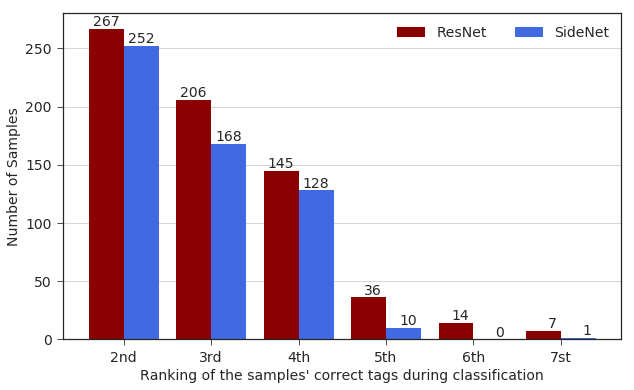

In [185]:
import matplotlib.pyplot as plt
x = np.array(range(len(wrong_class.values())))
y = wrong_class.values()#
y2 = wrong_class2.values()#
def bar(x,y,y2,name):
    #  #set style
    fig = plt.figure(figsize=(10,6)) #创建绘图对象
    plt.style.use("seaborn-ticks")
    ax1 = fig.add_subplot(111)
    #ax1.bar(x,y,color = 'teal', width=0.8)
    #ax1.bar(x,y,color = "olive",width = 0.6)
    rec1 = ax1.bar(x-0.2,y2,color='darkred', width=0.4)
    rec2 = ax1.bar(x+0.2,y,color="royalblue", width=0.4)
    ax1.legend([rec1,rec2],("ResNet","SideNet"),ncol=3,fontsize=14)
    for i,j in zip(x,y2):
        ax1.text(i-0.05,j-0.15,'%d' % j,verticalalignment="bottom",horizontalalignment="right",fontsize=14)
    for i,j in zip(x,y):
        ax1.text(i+0.35,j-0.15,'%d' % j,verticalalignment="bottom",horizontalalignment="right",fontsize=14)
    plt.xticks(x, ['2nd','3rd','4th','5th',"6th",'7st'],fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('./image/'+name+".pdf", bbox_inches='tight') #保存图
    ax1.set_ylabel('Number of Samples',fontsize=14)
    ax1.set_xlabel("Ranking of the samples' correct tags during classification",fontsize=14)
    
    plt.grid(axis="y")
    plt.show()  #显示图
bar(x[1:],y[1:],y2[1:],"wrong_class_resencoder")


In [ ]:
Res:
macro recall: 0.632
macro F1: 0.631
Accuracy: 0.585
    
FCN:
macro recall: 0.604
macro F1: 0.592
Accuracy: 0.561
    
encoder:
macro recall: 0.630
macro F1: 0.632
Accuracy: 0.579

resencoder:
macro recall: 0.671
macro F1: 0.661
Accuracy: 0.646
    
mlp:
macro recall: 0.560
macro F1: 0.557
Accuracy: 0.530
    
LSTM:
macro recall: 0.588
macro F1: 0.563
Accuracy: 0.560

    

In [20]:
from sklearn import metrics
typ = 'noisy'
num=30
dataset = np.load(str(num)+'/'+typ+'_x_data_'+str(num)+'.npy')[:,1:,]#.swapaxes(1,2)
label = np.load(str(num)+'/'+typ+'_y_data_'+str(num)+'.npy')

#dataset = dataset.swapaxes(1,2).astype('int')
#dataset = dataset.reshape(-1,dataset.shape[1]*dataset.shape[2])

skf = StratifiedKFold(n_splits=10, random_state=42)
for n, (train, test) in enumerate(skf.split(dataset,label)):
    best_accuracy = 0
    print train, test
    print np.array(dataset)[train].shape, np.array(dataset)[test].shape
                    # feature selection
    x_train = np.array(dataset)[train]
    x_t = np.array(dataset)[test]
    
    #x_train,x_t = feature_normalize(x_train,x_t)
    
    x_train = torch.FloatTensor(x_train)
    x_t = torch.FloatTensor(x_t)
    y_test = label[test]
    break
    
#net = torch.load('30/net_mlp_100p.pkl')
#net = torch.load('30/net_encoder_20p.pkl')
net.eval()

acc_temp = []
#target_names = ['Baseline','Camera', 'ReadSMS','RequestLocation','ReadContacts'] #
target_names = ['Baseline','Camera', 'AudioRecording', 'ReadSMS','RequestLocation','ReadContacts'] 
result = F.softmax(net(x_t)).detach().numpy()

acc_temp.append(accuracy(result,y_test))
y_pred = result.argmax(axis=1)
print(classification_report(y_test, y_pred, target_names=target_names,digits=3))
#if n==0
#    df=pd.DataFrame(classification_report(y_test, y_pred, target_names=target_names,digits=4,output_dict=True)).transpose()
#df = df.append(pd.DataFrame(classification_report(y_test, y_pred, target_names=target_names,digits=4,output_dict=True)).transpose())
print 'macro recall:',round(metrics.recall_score(y_test, y_pred, average='macro'),3)
print 'macro F1:',round(metrics.f1_score(y_test, y_pred, average='macro'),3)
print 'Accuracy:',round(sum(acc_temp)/len(acc_temp),3)


[  102   103   104 ... 11101 11102 11103] [   0    1    2 ... 8401 8402 8403]
(9992, 17, 60) (1112, 17, 60)
                 precision    recall  f1-score   support

       Baseline      0.987     0.993     0.990       300
         Camera      0.990     1.000     0.995        98
 AudioRecording      0.983     0.993     0.988       299
        ReadSMS      0.995     1.000     0.998       203
RequestLocation      0.962     0.927     0.944       110
   ReadContacts      0.980     0.951     0.965       102

      micro avg      0.985     0.985     0.985      1112
      macro avg      0.983     0.977     0.980      1112
   weighted avg      0.985     0.985     0.985      1112

macro recall: 0.977
macro F1: 0.98
Accuracy: 0.985


In [40]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
confusion_matrix(y_test,y_pred)

array([[300,   0,   0,   0,   0,   0,   0],
       [  0, 103,   1,   2,   3,   1,   0],
       [  0,   0,  98,   5,   1,   2,   4],
       [  0,   5,   2, 119,  24,  52,  48],
       [  0,   5,   0,  19,  51,  98,  52],
       [  0,   6,   0,  32,  82, 145,  73],
       [  1,   6,   1,  39,  40,  71, 112]])

In [11]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

In [13]:
 def plot_confusion_matrix(cm, classes,name,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    
    # Only use the labels that appear in the data
    #     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    cm1 = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(dpi=120)
    im = ax.imshow(cm1, interpolation='nearest', cmap=cmap)
    ax.yaxis.tick_right()
    ax.xaxis.tick_top()
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           #title=title,
           ylabel=r'$\bf{Predicted\ Behavior\ Type}$',
           xlabel=r'$\bf{Actual\ Behavior\ Type}$')
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=60, ha="left",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm1.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm1[i, j] > thresh else "black")
    fig.tight_layout()
    plt.savefig('./image/'+str(name)+'.pdf',bbox_inches ='tight')
    plt.show()
    return ax

Confusion matrix, without normalization
[[299   0   0   0   0   0   0]
 [  0 107   0   4   5   5   4]
 [  0   1 106   0   0   1   0]
 [  0   1   1 126   5   3  15]
 [  0   1   0  15  15  19  10]
 [  1   0   3  89 191 294 144]
 [  0   0   0  16   9  16  97]]


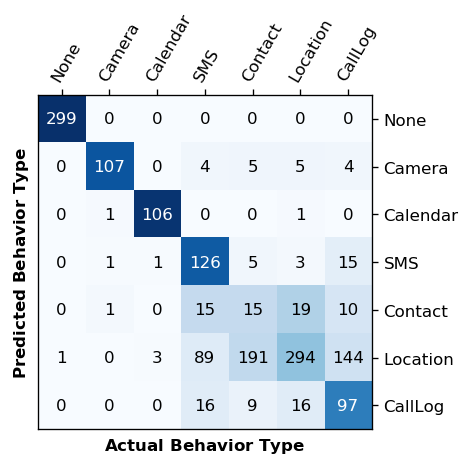

In [14]:
plot_confusion_matrix(confusion_matrix(y_pred,y_test),classes=['None', 'Camera', 'Calendar', 'SMS', 'Contact', 'Location','CallLog'],name='CM_ours')

In [9]:
plot_confusion_matrix(confusion_matrix(y_pred,y_test),classes=['None', 'Camera', 'Calendar', 'SMS', 'Contact', 'Location','CallLog'],name='CM_res')

NameError: name 'plot_confusion_matrix' is not defined

In [ ]:
acl = [list(reversed([0.807,0.96,0.985,0.987,0.99])),list(reversed([0.797,0.951,0.978,0.976,0.987]))]
mlpa = list(reversed([0.7302158273381295, 0.8516187050359713,0.871 ,0.8660071942446043, 0.8390287769784173]))
rnna = list(reversed([0.8642086330935251, 0.8857913669064749,0.951, 0.9588489208633094, 0.957158273381295]))
fcna = list(reversed([0.7517985611510791, 0.9481294964028777, 0.964, 0.9634748201438849, 0.964992805755396]))
resa = list(reversed([0.7661870503597122,0.886,0.903,0.930 ,0.9325539568345323]))
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.plot(range(5),acl[0],label='SideNet', linewidth=2.0,marker='d')
ax.plot(range(5),acl[1],label='ResNet', linewidth=2.0, linestyle='--',marker='o')
ax.plot(range(5),mlpa,label='MLP', linewidth=2.0, linestyle='--',marker='o')
ax.plot(range(5),rnna,label='LSTM', linewidth=2.0, linestyle='--',marker='o')
ax.plot(range(5),resa,label='Encoder', linewidth=2.0, linestyle='--',marker='o')
ax.plot(range(5),fcna,label='FCN', linewidth=2.0, linestyle='--',marker='o')
ax.set_xlabel('Value of T')
ax.set_ylabel('Accuracy')
plt.xticks(range(5),reversed(['20','40','60','80','100']))
#plt.yticks(np.linspace(0.6, 1, 10))
plt.legend(loc=1)
plt.savefig('./image/accs.pdf',bbox_inches ='tight')
plt.show()

In [ ]:
30/net_encoder_20p.pkl|net_lstm_100p.pkl|net_fcn_100p.pkl|resnet_noisy_model.pkl|
net_mlp_100p.pkl|net_originalencoder_100p.pkl

sparse/net_encoder_20p1.pkl|net_lstm_100p.pkl|net_fcn_100p.pkl|net_res_100p.pkl|
net_mlp_100p.pkl|net_originalencode_100p.pkl

sparsemodel/net_encoder_p'+str(num)+'.pkl

# Effect Size

In [190]:
print 'Start..'
d,l = pickle.load(open('8-27/data.pkl','rb'))
dataset = d[:,:,1:].swapaxes(1,2).astype('int')
ft= set(np.where(dataset[:,:,0]>100)[0])
ft = list(set(range(dataset.shape[0])).difference(ft))
dataset = dataset[ft,:,:]
label = l[ft]
        #load model
print dataset.shape
        #net = torch.load('sparsemodel/net_100p.pkl')   
for i in range(3,6):
    label[label==i]=i-1
for i in range(5):
    print label[label==i].shape

Start..
(31699, 17, 60)
(10000,)
(5639,)
(7868,)
(1701,)
(6491,)


In [210]:
from sklearn import metrics
typ = 'noisy'
num=30
#dataset = np.load(str(num)+'/'+typ+'_x_data_'+str(num)+'.npy')[:,1:,]#.swapaxes(1,2)
#dataset = dataset.reshape(-1,dataset.shape[1]*dataset.shape[2])
#label = np.load(str(num)+'/'+typ+'_y_data_'+str(num)+'.npy')
#dataset = dataset.reshape(-1,dataset.shape[1],dataset.shape[2])
#dataset = dataset.swapaxes(1,2)
import pandas as pd
density = 20
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, random_state=42)
for n, (train, test) in enumerate(skf.split(dataset,label)):
    #if n!=2:
    #    continue
    best_accuracy = 0
    print train, test
    print np.array(dataset)[train].shape, np.array(dataset)[test].shape
    x_train = np.array(dataset)[train]
    x_t = np.array(dataset)[test]
    #x_train,x_t = feature_normalize(x_train,x_t)
    x_train = torch.FloatTensor(x_train)
    x_t = torch.FloatTensor(x_t)
    y_test = label[test]
    break
net = torch.load('sparsemodel/net_encoder_20p.pkl')
#net = torch.load('30/net_lstm_100p.pkl')
net.eval()
result=F.softmax(net(x_t)).detach().numpy()
print accuracy(result,y_test)

acc_temp = []
#target_names = ['Baseline','Camera', 'ReadSMS','RequestLocation','ReadContacts'] #
t = x_t.shape[0]/10
name = 'iencoder'
dc[name] = []
for i in range(10):
    #target_names = ['Baseline','Camera', 'AudioRecording', 'ReadSMS','RequestLocation','ReadContacts'] 
    result = F.softmax(net(x_t[i*t:(i+1)*t])).detach().numpy().argmax(1)
    dc[name].append(sum(result == y_test[i*t:(i+1)*t])/float(t))


[ 1867  1868  1869 ... 31696 31697 31698] [    0     1     2 ... 22696 22697 22698]
(28527, 17, 60) (3172, 17, 60)
0.5930012610340479


In [273]:
for i in ['res','oencoder','fcn','lstm','mlp']:#,[resnet,ed,fn,lm,mp]):
    print i,efs(np.array(dcc['encoder']),np.array(dcc[i])),stats.ttest_rel(np.array(dcc['encoder']),np.array(dcc[i]))#,correction=True,)#,alternative='two-sided')
    ##

 res 0.8785395580929569 Ttest_relResult(statistic=2.1625567939590673, pvalue=0.058822116103276534)
oencoder 0.4376189241074237 Ttest_relResult(statistic=2.7014105327995517, pvalue=0.024337412928170286)
fcn 0.7955675196039851 Ttest_relResult(statistic=1.5908601351330511, pvalue=0.1461045880091863)
lstm 0.4664066530290326 Ttest_relResult(statistic=3.7749020996737737, pvalue=0.004383259903780102)
mlp 1.630010421513038 Ttest_relResult(statistic=2.4896680272881855, pvalue=0.034440762417560424)


In [274]:
for i in ['res','oencoder','fcn','lstm','mlp']:#,[resnet,ed,fn,lm,mp]):wilcoxon
    print i,efs(np.array(dc['encoder']),np.array(dc[i])),stats.ttest_rel(np.array(dc['encoder']),np.array(dc[i]))#,alternative='two-sided')
    ##

res 0.37283654890391826 Ttest_relResult(statistic=1.0758625911149773, pvalue=0.30998232489004757)
oencoder 1.5280368293088158 Ttest_relResult(statistic=3.7572761138095765, pvalue=0.004503872856523905)
fcn 0.8628708445067536 Ttest_relResult(statistic=2.9131822833531693, pvalue=0.01722182196947788)
lstm 1.533040962360322 Ttest_relResult(statistic=4.527784441286426, pvalue=0.001430733199135742)
mlp 2.0581883665107337 Ttest_relResult(statistic=4.776004499380438, pvalue=0.0010068800772634924)


In [37]:
import scipy.stats as stats

In [93]:
for i in dcc.keys():
    print i,stats.mannwhitneyu(dcc['encoder'],dcc[i],alternative='two-sided')

res MannwhitneyuResult(statistic=5208078.0, pvalue=0.015039622535880417)
encoder MannwhitneyuResult(statistic=5030792.0, pvalue=0.9999945287895333)
mlp MannwhitneyuResult(statistic=6004904.5, pvalue=6.333896094308229e-41)
oencoder MannwhitneyuResult(statistic=5609725.0, pvalue=2.0622756117379754e-15)
lstm MannwhitneyuResult(statistic=5642555.0, pvalue=4.959035029867865e-17)
fcn MannwhitneyuResult(statistic=5061110.0, pvalue=0.6775226924652287)


In [ ]:
res MannwhitneyuResult(statistic=1005847.0, pvalue=1.29309925836759e-144)
encoder MannwhitneyuResult(statistic=618272.0, pvalue=0.9999735685946853)
mlp MannwhitneyuResult(statistic=686804.0, pvalue=3.3460251058305257e-06)
oencoder MannwhitneyuResult(statistic=674246.0, pvalue=0.000214294034213263)
lstm MannwhitneyuResult(statistic=637323.0, pvalue=0.20773118968603133)
fcn MannwhitneyuResult(statistic=893035.5, pvalue=9.502757082344412e-74)

In [83]:
#30
resnet = np.array([0.988,0.990,0.966,0.993,0.955,0.970])#, 0.9769999999999999 0.014142135623730963
resed = np.array([0.990,0.995,0.988,0.998,0.944,0.965]) # 0.98 0.01929594085120842
ed = np.array([0.894,0.946,0.918,0.983,0.646,0.919])
fn = np.array([0.983,0.907,0.963,0.993,0.944,0.933])
lm = np.array([0.980,0.926,0.950,0.942,0.930,0.941])
mp = np.array([0.899,0.950,0.831,0.949,0.616,0.922])

In [85]:
#our data
resnet = np.array([0.592,0.902,0.413,0.838,0.283])#, 0.9769999999999999 0.014142135623730963
resed = np.array([0.65,0.95,0.69,0.69,0.18]) # 0.98 0.01929594085120842
ed = np.array([0.646,0.932,0.232,0.766,0.320])
fn = np.array([0.599,0.914,0.448,0.791,0.286])
lm = np.array([0.718,0.848,0.371,0.493,0.352])
mp = np.array([0.632,0.890,0.379,0.727,0.137])

In [235]:
import math
def efs(d1, d2):
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    # calculate the variance of the samples
    s1, s2 = d1.var(), d2.var()
    # calculate the pooled standard deviation
    s = math.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # calculate the means of the samples
    u1, u2 = d1.mean(), d2.mean()
    # calculate the effect size
    return (u1 - u2) / s

In [86]:
for i in ['resnet','oencoder','fcn','lstm','mlp']:#,[resnet,ed,fn,lm,mp]):
    print n,efs(resed,i)

resnet 0.10816645725084921
encoder 0.20489806096706464
fcn 0.10229288978590338
lstm 0.3368169359875393
mlp 0.30614222624669557


In [25]:
resed.mean()

0.98

In [16]:
[0.988,0.990,0.966,0.993,0.955,0.970]

5.861999999999999

In [ ]:
0.9622302158273381, 

In [ ]:
parm={}
for name,parameters in net.named_parameters():
    print(name,':',parameters.size())
    parm[name]=parameters.detach().numpy()
count = 0
for i in parm:
    print i,parm[i][parm[i]==0].shape
    count = parm[i][parm[i]==0].shape[0]+count
print count

In [12]:
sumcount = 0
for i in parm:
    #print parm[i].shape
    tmp = 1
    for j in parm[i].shape:
        tmp = tmp*j
    sumcount += tmp 
print 423531.0/sumcount

0.945371145411


## Deal with data

In [26]:
l = pd.read_csv('8-27/all_event.csv')
d = pd.read_csv('8-27/overlap_noisy.csv')

In [27]:
def overlap(x):
    ztt = l[l['timestamp']<x+2000]
    ztt = list(ztt[ztt['timestamp']>x-2000]['class'])
    ttf = l[l['timestamp']<x+5000]
    ttf = list(ttf[ttf['timestamp']>x-5000]['class']) 
    fte = l[l['timestamp']<x+8000]
    fte = list(fte[fte['timestamp']>x-8000]['class']) 
    return ztt,ttf,fte
s = []
label = []
for lb,i in zip(l['class'],l['timestamp']):
    print i
    temp = np.concatenate([d[d['System_Time']<i][-30:].values[:,1:],d[d['System_Time']>=i][:30].values[:,1:]],axis=0)
    #
    if temp[-1,0]-temp[0,0]<4000 and temp.shape[0]==60:
        if s==[]:
            s = temp.reshape(-1,temp.shape[0],temp.shape[1])
            ztt = overlap(i)
            lb = [lb]
            lb.extend(ztt)
            label.append(lb)
            print ztt
        else:
            s = np.concatenate([s,temp.reshape(-1,temp.shape[0],temp.shape[1])],axis=0)
            ztt = overlap(i)
            
            lb = [lb]
            lb.extend(ztt)
            label.append(lb)
            print ztt
            print s.shape
    else:
        print 'pass' 

1566873410154
pass
1566873410609
pass
1566873410683
pass
1566873411212
pass
1566873411373
pass
1566873411576
pass
1566873412064
pass
1566873413753
pass
1566873417708
pass
1566873433192
pass
1566873436741
pass
1566873455731
pass
1566873456183
pass
1566873474751
pass
1566873479217
pass
1566873493764
pass
1566873502231
pass
1566873512761
pass
1566873525228
pass
1566873531805
pass
1566873548230
pass
1566873550840
pass
1566873557812
pass
1566873569844
pass
1566873571251
pass
1566873573532
pass
1566873588869
pass
1566873594262
pass
1566873607909
pass
1566873617264
pass
1566873626918
pass
1566873640266
pass
1566873645930
pass
1566873663269
pass
1566873664947
pass
1566873683981
pass
1566873686305
pass
1566873703026
pass
1566873709347
pass
1566873722060
pass
1566873732374
pass
1566873741076
pass
1566873755413
pass
1566873760105
pass
1566873778444
pass
1566873779147
pass
1566873798127
pass
1566873800033
pass
1566873817176
pass
1566873823053
pass
1566873836221
pass
1566873846064
pass
156687385524

pass
1566875504085
([5], [5], [5, 3])
(91, 60, 18)
1566875510512
([3], [3], [5, 3])
(92, 60, 18)
1566875522161
([1], [1, 5], [1, 5, 3])
(93, 60, 18)
1566875527085
([5], [1, 5, 3], [1, 5, 3])
(94, 60, 18)
1566875529551
([3], [5, 3], [1, 5, 3])
(95, 60, 18)
1566875547420
([1, 3], [1, 3, 5], [1, 3, 5])
(96, 60, 18)
1566875548548
([1, 3, 5], [1, 3, 5], [1, 3, 5])
(97, 60, 18)
1566875550101
([3, 5], [1, 3, 5], [1, 3, 5])
(98, 60, 18)
1566875567563
([3], [3], [3, 1, 5])
(99, 60, 18)
1566875572653
([1, 5], [1, 5], [3, 1, 5])
(100, 60, 18)
1566875573135
([1, 5], [1, 5], [3, 1, 5])
(101, 60, 18)
1566875586563
([3], [3], [3])
(102, 60, 18)
1566875596145
([5, 1], [5, 1], [5, 1])
(103, 60, 18)
1566875597945
([5, 1], [5, 1], [5, 1, 3])
(104, 60, 18)
1566875605576
([3], [3], [1, 3])
(105, 60, 18)
1566875619146
([5], [5, 1], [5, 1, 3])
(106, 60, 18)
1566875623135
([1, 3], [5, 1, 3], [5, 1, 3])
(107, 60, 18)
1566875624616
([1, 3], [1, 3], [5, 1, 3])
(108, 60, 18)
1566875642159
([5, 3], [5, 3], [5, 3])

([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 5], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 5])
(223, 60, 18)
1566876420328
([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 5], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 5])
(224, 60, 18)
1566876420331
([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 5], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 5])
(225, 60, 18)
1566876420333
([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 5], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 5])
(226, 60, 18

([5, 1], [5, 1], [5, 1, 3])
(310, 60, 18)
1566876936861
([3], [3], [5, 1, 3])
(311, 60, 18)
1566876954369
([5, 3], [5, 3, 1], [5, 3, 1])
(312, 60, 18)
1566876955894
([5, 3, 1], [5, 3, 1], [5, 3, 1])
(313, 60, 18)
1566876956890
([3, 1], [5, 3, 1], [5, 3, 1])
(314, 60, 18)
1566876974905
([3], [3, 5], [3, 5, 1])
(315, 60, 18)
1566876977414
([5], [3, 5, 1], [3, 5, 1])
(316, 60, 18)
1566876982330
([1], [5, 1], [3, 5, 1])
(317, 60, 18)
1566876991821
([4], [4, 3], [4, 3])
(318, 60, 18)
1566876993943
([3], [4, 3], [4, 3, 5])
(319, 60, 18)
1566877000450
([5], [5], [3, 5, 1])
(320, 60, 18)
1566877007913
([1], [1], [5, 1, 3])
(321, 60, 18)
1566877012980
([3], [3], [1, 3])
(322, 60, 18)
1566877023450
([5], [5], [5])
(323, 60, 18)
1566877032021
([3, 1], [3, 1], [3, 1])
(324, 60, 18)
1566877033492
([3, 1], [3, 1], [3, 1])
(325, 60, 18)
1566877046487
([5], [5, 3], [5, 3])
(326, 60, 18)
1566877051062
([3], [5, 3], [5, 3])
(327, 60, 18)
1566877059130
([1], [1], [1])
(328, 60, 18)
1566877069520
([5, 3],

([3, 5], [3, 5, 1], [3, 5, 1])
(465, 60, 18)
1566878062052
([1], [3, 5, 1], [3, 5, 1])
(466, 60, 18)
1566878078003
([3], [3, 5], [3, 5])
(467, 60, 18)
1566878082680
([5], [3, 5, 1], [3, 5, 1])
(468, 60, 18)
1566878087350
([1], [5, 1], [5, 1])
(469, 60, 18)
1566878097014
([3], [3], [3])
(470, 60, 18)
1566878105688
([5], [5], [5, 1])
(471, 60, 18)
1566878112734
([1], [1, 3], [5, 1, 3])
(472, 60, 18)
1566878116015
([3], [1, 3], [1, 3])
(473, 60, 18)
1566878128689
([5], [5], [5, 3])
(474, 60, 18)
1566878135051
([3], [3, 1], [5, 3, 1])
(475, 60, 18)
1566878138115
([1], [3, 1], [3, 1])
(476, 60, 18)
1566878151733
([5], [5, 3], [5, 3])
(477, 60, 18)
1566878154058
([3], [5, 3], [5, 3])
(478, 60, 18)
1566878163581
([1], [1], [1])
(479, 60, 18)
1566878173093
([3, 5], [3, 5], [3, 5])
(480, 60, 18)
1566878174753
([3, 5], [3, 5], [3, 5])
(481, 60, 18)
1566878189064
([1], [1, 4, 3], [1, 4, 3])
(482, 60, 18)
1566878191831
([4, 3], [1, 4, 3], [1, 4, 3, 5])
(483, 60, 18)
1566878192103
([4, 3], [1, 4, 3

([1], [1, 3], [5, 1, 3])
(623, 60, 18)
1566879219226
([3], [1, 3], [1, 3])
(624, 60, 18)
1566879233521
([5], [5, 3], [5, 3])
(625, 60, 18)
1566879238267
([3], [5, 3, 1], [5, 3, 1])
(626, 60, 18)
1566879242025
([1], [3, 1], [3, 1])
(627, 60, 18)
1566879256529
([5, 3], [5, 3], [5, 3])
(628, 60, 18)
1566879257283
([5, 3], [5, 3], [5, 3])
(629, 60, 18)
1566879267540
([1], [1], [1])
(630, 60, 18)
1566879276297
([3], [3, 5], [3, 5])
(631, 60, 18)
1566879279530
([5], [3, 5], [3, 5])
(632, 60, 18)
1566879293096
([1], [1, 3], [1, 3])
(633, 60, 18)
1566879295336
([3], [1, 3], [1, 3, 5])
(634, 60, 18)
1566879302566
([5], [5], [3, 5])
(635, 60, 18)
1566879314334
([3], [3, 1], [3, 1])
(636, 60, 18)
1566879318631
([1], [3, 1], [3, 1, 5])
(637, 60, 18)
1566879325584
([5], [5], [1, 5, 3])
(638, 60, 18)
1566879333373
([3], [3], [5, 3])
(639, 60, 18)
1566879344166
([1], [1, 5], [1, 5])
(640, 60, 18)
1566879348621
([5], [1, 5, 3], [1, 5, 3])
(641, 60, 18)
1566879352392
([3], [5, 3], [5, 3])
(642, 60, 18)

([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5], [1, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5])
(745, 60, 18)
1566880060119
([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5], [1, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5])
(746, 60, 18)
1566880060124
([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4

([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5], [3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5], [1, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5])
(763, 60, 18)
1566880060746
([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5], [3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5], [1, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5])
(764, 60, 18)
1566880060750
([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4

([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5], [3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5], [1, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5])
(781, 60, 18)
1566880061073
([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5], [3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5], [1, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5])
(782, 60, 18)
1566880061078
([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4

([5], [5], [5, 3])
(881, 60, 18)
1566880759959
([3], [3], [5, 3, 1])
(882, 60, 18)
1566880765347
([1], [1], [3, 1])
(883, 60, 18)
1566880775809
([5], [5, 3], [5, 3])
(884, 60, 18)
1566880778975
([3], [5, 3], [5, 3])
(885, 60, 18)
1566880790920
([1], [1], [1, 3, 5])
(886, 60, 18)
1566880797991
([3, 5], [3, 5], [1, 3, 5])
(887, 60, 18)
1566880798847
([3, 5], [3, 5], [1, 3, 5])
(888, 60, 18)
1566880816492
([1, 3], [1, 3], [1, 3, 5])
(889, 60, 18)
1566880816989
([1, 3], [1, 3, 5], [1, 3, 5])
(890, 60, 18)
1566880821858
([5], [3, 5], [1, 3, 5])
(891, 60, 18)
1566880835992
([3], [3], [3, 1])
(892, 60, 18)
1566880842134
([1], [1, 5], [3, 1, 5])
(893, 60, 18)
1566880844901
([5], [1, 5], [1, 5])
(894, 60, 18)
1566880855000
([3], [3], [3])
(895, 60, 18)
1566880867667
([1, 5], [1, 5], [1, 5, 3])
(896, 60, 18)
1566880867926
([1, 5], [1, 5], [1, 5, 3])
(897, 60, 18)
1566880874000
([3], [3], [1, 5, 3])
(898, 60, 18)
1566880890946
([5, 4], [5, 4, 3, 1], [5, 4, 3, 1])
(899, 60, 18)
1566880891828
([5, 

([5, 1], [5, 1], [5, 1, 3])
(1035, 60, 18)
1566881858934
([5, 1], [5, 1, 3], [5, 1, 3])
(1036, 60, 18)
1566881863114
([3], [1, 3], [5, 1, 3])
(1037, 60, 18)
1566881880912
([5, 3], [5, 3, 1], [5, 3, 1])
(1038, 60, 18)
1566881882116
([5, 3], [5, 3, 1], [5, 3, 1])
(1039, 60, 18)
1566881884507
([1], [5, 3, 1], [5, 3, 1])
(1040, 60, 18)
1566881901122
([3], [3, 5], [3, 5])
(1041, 60, 18)
1566881903949
([5], [3, 5], [3, 5, 1])
(1042, 60, 18)
1566881910117
([1], [1], [5, 1])
(1043, 60, 18)
1566881920157
([3], [3], [3, 5])
(1044, 60, 18)
1566881926959
([5], [5], [3, 5])
(1045, 60, 18)
1566881939161
([3], [3], [3, 1])
(1046, 60, 18)
1566881945818
([1], [1, 5], [3, 1, 5])
(1047, 60, 18)
1566881949959
([5], [1, 5], [1, 5])
(1048, 60, 18)
1566881958201
([3], [3], [3])
(1049, 60, 18)
1566881971391
([1, 5], [1, 5], [1, 5, 3])
(1050, 60, 18)
1566881972963
([1, 5], [1, 5, 3], [1, 5, 3])
(1051, 60, 18)
1566881977242
([3], [5, 3], [1, 5, 3])
(1052, 60, 18)
1566881995970
([5, 3, 1], [5, 3, 1], [5, 3, 1])


([3], [1, 5, 3], [1, 5, 3])
(1188, 60, 18)
1566882985390
([3, 5], [3, 5, 1], [3, 5, 1, 4])
(1189, 60, 18)
1566882985990
([3, 5, 1], [3, 5, 1], [3, 5, 1, 4])
(1190, 60, 18)
1566882987835
([5, 1], [3, 5, 1, 4], [3, 5, 1, 4])
(1191, 60, 18)
1566882991829
([4], [1, 4], [3, 5, 1, 4])
(1192, 60, 18)
1566883004424
([3], [3, 5], [3, 5])
(1193, 60, 18)
1566883009025
([5], [3, 5, 1], [3, 5, 1])
(1194, 60, 18)
1566883013381
([1], [5, 1], [5, 1])
(1195, 60, 18)
1566883023423
([3], [3], [3])
(1196, 60, 18)
1566883032030
([5], [5], [5, 1])
(1197, 60, 18)
1566883038931
([1], [1, 3], [5, 1, 3])
(1198, 60, 18)
1566883042457
([3], [1, 3], [1, 3])
(1199, 60, 18)
1566883055071
([5], [5], [5, 3])
(1200, 60, 18)
1566883061469
([3], [3, 1], [5, 3, 1])
(1201, 60, 18)
1566883064463
([1], [3, 1], [3, 1])
(1202, 60, 18)
1566883078075
([5], [5, 3], [5, 3])
(1203, 60, 18)
1566883080469
([3], [5, 3], [5, 3])
(1204, 60, 18)
1566883089986
([1], [1], [1])
(1205, 60, 18)
1566883099506
([3, 5], [3, 5], [3, 5])
(1206, 60

([4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1], [4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1])
(1300, 60, 18)
1566883745849
([4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1], [4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1])
(1301, 60

([4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1], [4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1])
(1317, 60, 18)
1566883746043
([4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1], [4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1])
(1318, 60

([4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1], [4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1], [4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1])
(1334, 60, 18)
1566883746310
([4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1], [4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1], [4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1])
(13

([5], [5], [3, 5])
(1379, 60, 18)
1566884012479
([3, 1], [3, 1], [3, 1])
(1380, 60, 18)
1566884014037
([3, 1], [3, 1], [3, 1, 5])
(1381, 60, 18)
1566884022027
([5], [5], [1, 5])
(1382, 60, 18)
1566884031503
([3], [3], [3])
(1383, 60, 18)
1566884039576
([1], [1], [1, 5])
(1384, 60, 18)
1566884045031
([5], [5], [1, 5, 3])
(1385, 60, 18)
1566884050529
([3], [3], [5, 3])
(1386, 60, 18)
1566884065140
([1], [1, 5, 3], [1, 5, 3])
(1387, 60, 18)
1566884068068
([5, 3], [1, 5, 3], [1, 5, 3])
(1388, 60, 18)
1566884069566
([5, 3], [1, 5, 3], [1, 5, 3])
(1389, 60, 18)
1566884088613
([3], [3, 1, 5], [3, 1, 5])
(1390, 60, 18)
1566884090686
([1, 5], [3, 1, 5], [3, 1, 5])
(1391, 60, 18)
1566884091107
([1, 5], [3, 1, 5], [3, 1, 5])
(1392, 60, 18)
1566884107643
([3], [3], [3, 5])
(1393, 60, 18)
1566884114134
([5], [5, 1], [3, 5, 1])
(1394, 60, 18)
1566884116257
([1], [5, 1], [5, 1])
(1395, 60, 18)
1566884126681
([3], [3], [3])
(1396, 60, 18)
1566884137157
([5], [5, 1], [5, 1])
(1397, 60, 18)
156688414179

([3], [3], [5, 3])
(1534, 60, 18)
1566885144905
([1], [1], [1, 5])
(1535, 60, 18)
1566885150121
([5], [5, 3], [1, 5, 3])
(1536, 60, 18)
1566885153793
([3], [5, 3], [5, 3])
(1537, 60, 18)
1566885170476
([1], [1, 3, 5], [1, 3, 5])
(1538, 60, 18)
1566885172832
([3, 5], [1, 3, 5], [1, 3, 5])
(1539, 60, 18)
1566885173129
([3, 5], [1, 3, 5], [1, 3, 5])
(1540, 60, 18)
1566885191856
([3], [3, 1, 5], [3, 1, 5])
(1541, 60, 18)
1566885196019
([1, 5], [3, 1, 5], [3, 1, 5])
(1542, 60, 18)
1566885196149
([1, 5], [3, 1, 5], [3, 1, 5])
(1543, 60, 18)
1566885210852
([3], [3], [3])
(1544, 60, 18)
1566885219174
([5], [5, 1], [5, 1])
(1545, 60, 18)
1566885221529
([1], [5, 1], [5, 1])
(1546, 60, 18)
1566885229853
([3], [3], [3])
(1547, 60, 18)
1566885242208
([5], [5, 1], [5, 1, 3])
(1548, 60, 18)
1566885247133
([1, 3], [5, 1, 3], [5, 1, 3])
(1549, 60, 18)
1566885248887
([1, 3], [1, 3], [5, 1, 3])
(1550, 60, 18)
1566885265245
([5], [5, 3], [5, 3, 1])
(1551, 60, 18)
1566885267921
([3], [5, 3, 1], [5, 3, 1])


([5, 3], [5, 3], [5, 3])
(1688, 60, 18)
1566886274120
([1, 3], [1, 3, 5], [1, 3, 5])
(1689, 60, 18)
1566886275969
([1, 3], [1, 3, 5], [1, 3, 5])
(1690, 60, 18)
1566886278272
([5], [1, 3, 5], [1, 3, 5])
(1691, 60, 18)
1566886291826
([4], [4, 3], [4, 3, 1])
(1692, 60, 18)
1566886294986
([3], [4, 3, 1], [4, 3, 1, 5])
(1693, 60, 18)
1566886299646
([1, 5], [3, 1, 5], [4, 3, 1, 5])
(1694, 60, 18)
1566886301309
([1, 5], [1, 5], [3, 1, 5])
(1695, 60, 18)
1566886313997
([3], [3], [3])
(1696, 60, 18)
1566886324355
([5, 1], [5, 1], [5, 1])
(1697, 60, 18)
1566886325245
([5, 1], [5, 1], [5, 1, 3])
(1698, 60, 18)
1566886333035
([3], [3], [1, 3])
(1699, 60, 18)
1566886347373
([5], [5, 1, 3], [5, 1, 3])
(1700, 60, 18)
1566886350846
([1, 3], [5, 1, 3], [5, 1, 3])
(1701, 60, 18)
1566886352059
([1, 3], [5, 1, 3], [5, 1, 3])
(1702, 60, 18)
1566886370381
([5, 3], [5, 3], [5, 3, 1])
(1703, 60, 18)
1566886371078
([5, 3], [5, 3], [5, 3, 1])
(1704, 60, 18)
1566886376456
([1], [1], [5, 3, 1])
(1705, 60, 18)
156

([1], [1], [3, 5, 1])
(1841, 60, 18)
1566887379070
([3], [3, 5], [3, 5])
(1842, 60, 18)
1566887383313
([5], [3, 5], [3, 5])
(1843, 60, 18)
1566887393340
([1], [1, 3], [1, 3])
(1844, 60, 18)
1566887398083
([3], [1, 3], [1, 3])
(1845, 60, 18)
1566887406335
([5], [5], [5])
(1846, 60, 18)
1566887417105
([3, 1], [3, 1], [3, 1])
(1847, 60, 18)
1566887418848
([3, 1], [3, 1], [3, 1])
(1848, 60, 18)
1566887429353
([5], [5], [5, 3])
(1849, 60, 18)
1566887436143
([3], [3], [5, 3])
(1850, 60, 18)
1566887452373
([5], [5, 1, 3], [5, 1, 3])
(1851, 60, 18)
1566887454418
([1, 3], [5, 1, 3], [5, 1, 3])
(1852, 60, 18)
1566887455150
([1, 3], [5, 1, 3], [5, 1, 3])
(1853, 60, 18)
1566887474175
([3, 5], [3, 5], [3, 5, 1])
(1854, 60, 18)
1566887475411
([3, 5], [3, 5, 1], [3, 5, 1])
(1855, 60, 18)
1566887479974
([1], [5, 1], [3, 5, 1])
(1856, 60, 18)
1566887491829
([4, 3], [4, 3], [4, 3, 5])
(1857, 60, 18)
1566887493224
([4, 3], [4, 3], [4, 3, 5])
(1858, 60, 18)
1566887498447
([5], [5], [4, 3, 5, 1])
(1859, 60

([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [1, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5])
(1884, 60, 18)
1566887538237
([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [1, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5])
(1885, 60, 18)
1566887538240
([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [1, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4

([1, 3], [1, 3], [5, 1, 3])
(1944, 60, 18)
1566887873492
([1, 3], [1, 3], [5, 1, 3])
(1945, 60, 18)
1566887889856
([5], [5, 3], [5, 3])
(1946, 60, 18)
1566887892499
([3], [5, 3], [5, 3, 1])
(1947, 60, 18)
1566887899050
([1], [1], [3, 1])
(1948, 60, 18)
1566887911532
([3, 5], [3, 5], [3, 5])
(1949, 60, 18)
1566887912861
([3, 5], [3, 5], [3, 5])
(1950, 60, 18)
1566887924648
([1], [1], [1, 3])
(1951, 60, 18)
1566887930573
([3], [3], [1, 3, 5])
(1952, 60, 18)
1566887935864
([5], [5], [3, 5])
(1953, 60, 18)
1566887949575
([3, 1], [3, 1], [3, 1])
(1954, 60, 18)
1566887950237
([3, 1], [3, 1], [3, 1])
(1955, 60, 18)
1566887958867
([5], [5], [5])
(1956, 60, 18)
1566887968586
([3], [3], [3, 1])
(1957, 60, 18)
1566887975816
([1], [1], [3, 1, 5])
(1958, 60, 18)
1566887981904
([5], [5], [1, 5, 3])
(1959, 60, 18)
1566887987595
([3], [3], [5, 3])
(1960, 60, 18)
1566888001327
([1], [1, 5], [1, 5, 3])
(1961, 60, 18)
1566888004919
([5, 3], [1, 5, 3], [1, 5, 3])
(1962, 60, 18)
1566888006598
([5, 3], [5, 

([5, 3], [4, 1, 5, 3], [4, 1, 5, 3])
(2099, 60, 18)
1566888995843
([5, 3], [4, 1, 5, 3], [4, 1, 5, 3])
(2100, 60, 18)
1566889014877
([3], [3, 5], [3, 5])
(2101, 60, 18)
1566889017798
([5], [3, 5], [3, 5])
(2102, 60, 18)
1566889027976
([1], [1], [1, 3])
(2103, 60, 18)
1566889033892
([3], [3], [1, 3, 5])
(2104, 60, 18)
1566889040811
([5], [5], [3, 5])
(2105, 60, 18)
1566889052934
([3, 1], [3, 1], [3, 1])
(2106, 60, 18)
1566889053537
([3, 1], [3, 1], [3, 1])
(2107, 60, 18)
1566889063833
([5], [5], [5])
(2108, 60, 18)
1566889071934
([3], [3], [3, 1])
(2109, 60, 18)
1566889079053
([1], [1], [3, 1, 5])
(2110, 60, 18)
1566889086815
([5], [5, 3], [1, 5, 3])
(2111, 60, 18)
1566889090971
([3], [5, 3], [5, 3])
(2112, 60, 18)
1566889104588
([1], [1], [1, 5, 3])
(2113, 60, 18)
1566889109855
([5, 3], [5, 3], [1, 5, 3])
(2114, 60, 18)
1566889109976
([5, 3], [5, 3], [1, 5, 3])
(2115, 60, 18)
1566889129014
([3, 1], [3, 1, 5], [3, 1, 5])
(2116, 60, 18)
1566889130143
([3, 1], [3, 1, 5], [3, 1, 5])
(2117,

([3, 5], [1, 3, 5], [1, 3, 5])
(2252, 60, 18)
1566890118015
([3], [3, 1, 5], [3, 1, 5])
(2253, 60, 18)
1566890121051
([1, 5], [3, 1, 5], [3, 1, 5])
(2254, 60, 18)
1566890122646
([1, 5], [3, 1, 5], [3, 1, 5])
(2255, 60, 18)
1566890137055
([3], [3], [3])
(2256, 60, 18)
1566890145686
([5, 1], [5, 1], [5, 1, 4, 4, 4])
(2257, 60, 18)
1566890146568
([5, 1], [5, 1], [5, 1, 4, 4, 4])
(2258, 60, 18)
1566890152235
([4, 4, 4], [4, 4, 4, 3], [5, 1, 4, 4, 4, 3])
(2259, 60, 18)
1566890152236
([4, 4, 4], [4, 4, 4, 3], [5, 1, 4, 4, 4, 3])
(2260, 60, 18)
1566890152464
([4, 4, 4], [4, 4, 4, 3], [5, 1, 4, 4, 4, 3])
(2261, 60, 18)
1566890156056
([3], [4, 4, 4, 3], [4, 4, 4, 3])
(2262, 60, 18)
1566890168690
([5], [5, 1], [5, 1, 3])
(2263, 60, 18)
1566890172039
([1], [5, 1, 3], [5, 1, 3])
(2264, 60, 18)
1566890175093
([3], [1, 3], [5, 1, 3])
(2265, 60, 18)
1566890191735
([5, 4], [5, 4, 3], [5, 4, 3])
(2266, 60, 18)
1566890191843
([5, 4], [5, 4, 3], [5, 4, 3])
(2267, 60, 18)
1566890194137
([3], [5, 4, 3], [5

([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [1, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])
(2371, 60, 18)
1566890888865
([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [1, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])
(2372, 60, 18)
1566890888868
([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [1, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])
(2373, 60, 18)
1566890888871
([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 

([3], [3], [3])
(2438, 60, 18)
1566891249455
([1, 5], [1, 5], [1, 5])
(2439, 60, 18)
1566891250489
([1, 5], [1, 5], [1, 5])
(2440, 60, 18)
1566891259400
([3], [3], [3])
(2441, 60, 18)
1566891273497
([5, 1], [5, 1, 3], [5, 1, 3])
(2442, 60, 18)
1566891274984
([5, 1], [5, 1, 3], [5, 1, 3])
(2443, 60, 18)
1566891278445
([3], [5, 1, 3], [5, 1, 3])
(2444, 60, 18)
1566891296502
([5, 3], [5, 3, 1], [5, 3, 1])
(2445, 60, 18)
1566891297476
([5, 3], [5, 3, 1], [5, 3, 1])
(2446, 60, 18)
1566891300510
([1], [5, 3, 1], [5, 3, 1])
(2447, 60, 18)
1566891316516
([3], [3, 5], [3, 5])
(2448, 60, 18)
1566891319523
([5], [3, 5], [3, 5, 1])
(2449, 60, 18)
1566891326040
([1], [1], [5, 1])
(2450, 60, 18)
1566891335513
([3], [3], [3, 5])
(2451, 60, 18)
1566891342547
([5], [5], [3, 5])
(2452, 60, 18)
1566891351585
([1], [1, 3], [1, 3])
(2453, 60, 18)
1566891354526
([3], [1, 3], [1, 3])
(2454, 60, 18)
1566891365589
([5], [5], [5, 3])
(2455, 60, 18)
1566891373542
([3], [3], [5, 3])
(2456, 60, 18)
1566891387150
(

([5], [1, 5], [1, 5, 3])
(2593, 60, 18)
1566892362596
([3], [3], [5, 3])
(2594, 60, 18)
1566892378075
([1, 5], [1, 5, 3], [1, 5, 3])
(2595, 60, 18)
1566892378258
([1, 5], [1, 5, 3], [1, 5, 3])
(2596, 60, 18)
1566892381589
([3], [1, 5, 3], [1, 5, 3])
(2597, 60, 18)
1566892400633
([3, 5], [3, 5, 1], [3, 5, 1])
(2598, 60, 18)
1566892401259
([3, 5], [3, 5, 1], [3, 5, 1])
(2599, 60, 18)
1566892403581
([1], [3, 5, 1], [3, 5, 1])
(2600, 60, 18)
1566892419672
([3], [3, 5], [3, 5])
(2601, 60, 18)
1566892424299
([5], [3, 5, 1], [3, 5, 1])
(2602, 60, 18)
1566892429114
([1], [5, 1], [5, 1])
(2603, 60, 18)
1566892438674
([3], [3], [3])
(2604, 60, 18)
1566892447307
([5], [5], [5, 1])
(2605, 60, 18)
1566892454650
([1], [1, 3], [5, 1, 3])
(2606, 60, 18)
1566892457692
([3], [1, 3], [1, 3])
(2607, 60, 18)
1566892470314
([5], [5], [5, 3])
(2608, 60, 18)
1566892476733
([3], [3, 1], [5, 3, 1])
(2609, 60, 18)
1566892480184
([1], [3, 1], [3, 1])
(2610, 60, 18)
1566892493322
([5], [5, 3], [5, 3])
(2611, 60, 1

([5, 1], [3, 5, 1], [3, 5, 1])
(2749, 60, 18)
1566893506810
([5, 1], [3, 5, 1], [3, 5, 1])
(2750, 60, 18)
1566893522780
([3], [3], [3, 5])
(2751, 60, 18)
1566893529062
([5], [5, 1], [3, 5, 1])
(2752, 60, 18)
1566893532404
([1], [5, 1], [5, 1])
(2753, 60, 18)
1566893541817
([3], [3], [3])
(2754, 60, 18)
1566893552094
([5], [5], [5, 1])
(2755, 60, 18)
1566893557931
([1], [1, 3], [5, 1, 3])
(2756, 60, 18)
1566893560828
([3], [1, 3], [1, 3])
(2757, 60, 18)
1566893575105
([5], [5, 3], [5, 3])
(2758, 60, 18)
1566893579838
([3], [5, 3, 1], [5, 3, 1])
(2759, 60, 18)
1566893583428
([1], [3, 1], [3, 1])
(2760, 60, 18)
1566893598142
([5, 3], [5, 3], [5, 3])
(2761, 60, 18)
1566893598849
([5, 3], [5, 3], [5, 3])
(2762, 60, 18)
1566893608958
([1], [1], [1])
(2763, 60, 18)
1566893617858
([3], [3, 5], [3, 5])
(2764, 60, 18)
1566893621144
([5], [3, 5], [3, 5])
(2765, 60, 18)
1566893634542
([1], [1, 3], [1, 3])
(2766, 60, 18)
1566893636863
([3], [1, 3], [1, 3, 5])
(2767, 60, 18)
1566893644184
([5], [5],

([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1])
(2895, 60, 18)
1566894553009
([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1])
(2896, 60, 18)
1566894553013
([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1])
(2897, 60, 18)
1566894553015
([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1])
(2898, 60, 18)
156689

([3], [3, 4], [5, 1, 3, 4])
(2972, 60, 18)
1566894991861
([4], [3, 4], [3, 4])
(2973, 60, 18)
1566895002333
([5], [5, 3, 1], [5, 3, 1])
(2974, 60, 18)
1566895006138
([3, 1], [5, 3, 1], [5, 3, 1])
(2975, 60, 18)
1566895006209
([3, 1], [5, 3, 1], [5, 3, 1])
(2976, 60, 18)
1566895025185
([3, 5], [3, 5], [3, 5, 1])
(2977, 60, 18)
1566895025341
([3, 5], [3, 5], [3, 5, 1])
(2978, 60, 18)
1566895031796
([1], [1], [3, 5, 1])
(2979, 60, 18)
1566895044181
pass
1566895048394
([5], [3, 5], [3, 5])
(2980, 60, 18)
1566895058687
pass
1566895063211
([3], [1, 3], [1, 3])
(2981, 60, 18)
1566895071403
([5], [5], [5])
(2982, 60, 18)
1566895082242
([3], [3, 1], [3, 1])
(2983, 60, 18)
1566895085492
([1], [3, 1], [3, 1])
(2984, 60, 18)
1566895094404
([5], [5], [5, 3])
(2985, 60, 18)
1566895101253
([3], [3], [5, 3])
(2986, 60, 18)
1566895111173
([1], [1], [1, 5])
(2987, 60, 18)
1566895117412
([5], [5, 3], [1, 5, 3])
(2988, 60, 18)
1566895120263
([3], [5, 3], [5, 3])
(2989, 60, 18)
1566895136791
([1], [1, 3, 5

([3], [3], [3, 5])
(3127, 60, 18)
1566896153263
([5], [5], [3, 5])
(3128, 60, 18)
1566896162449
([1], [1, 3], [1, 3])
(3129, 60, 18)
1566896166294
([3], [1, 3], [1, 3])
(3130, 60, 18)
1566896176267
([5], [5], [5])
(3131, 60, 18)
1566896185305
([3], [3, 1], [3, 1, 4])
(3132, 60, 18)
1566896187816
([1], [3, 1, 4], [3, 1, 4])
(3133, 60, 18)
1566896191823
([4], [1, 4], [3, 1, 4, 5])
(3134, 60, 18)
1566896199292
([5], [5], [4, 5, 3])
(3135, 60, 18)
1566896204344
([3], [3], [5, 3])
(3136, 60, 18)
1566896213225
([1], [1], [1])
(3137, 60, 18)
1566896222295
([5, 3], [5, 3], [5, 3])
(3138, 60, 18)
1566896223384
([5, 3], [5, 3], [5, 3])
(3139, 60, 18)
1566896238818
([1], [1, 3], [1, 3, 5])
(3140, 60, 18)
1566896242398
([3], [1, 3, 5], [1, 3, 5])
(3141, 60, 18)
1566896245311
([5], [3, 5], [1, 3, 5])
(3142, 60, 18)
1566896261400
([3], [3, 1], [3, 1, 5])
(3143, 60, 18)
1566896264388
([1], [3, 1, 5], [3, 1, 5])
(3144, 60, 18)
1566896268312
([5], [1, 5], [3, 1, 5])
(3145, 60, 18)
1566896280404
([3], [

([5], [5, 3], [5, 3])
(3283, 60, 18)
1566897307601
([3], [5, 3], [5, 3])
(3284, 60, 18)
1566897317304
([1], [1], [1])
(3285, 60, 18)
1566897326607
([3, 5], [3, 5], [3, 5])
(3286, 60, 18)
1566897327213
([3, 5], [3, 5], [3, 5])
(3287, 60, 18)
1566897342813
([1], [1, 3], [1, 3, 5])
(3288, 60, 18)
1566897345622
([3], [1, 3, 5], [1, 3, 5])
(3289, 60, 18)
1566897350215
([5], [3, 5], [1, 3, 5])
(3290, 60, 18)
1566897364631
([3], [3, 1], [3, 1])
(3291, 60, 18)
1566897368340
([1], [3, 1, 5], [3, 1, 5])
(3292, 60, 18)
1566897373274
([5], [1, 5], [1, 5])
(3293, 60, 18)
1566897383636
([3], [3], [3])
(3294, 60, 18)
1566897391847
([4, 1], [4, 1, 5], [4, 1, 5])
(3295, 60, 18)
1566897393825
([4, 1], [4, 1, 5], [4, 1, 5])
(3296, 60, 18)
1566897396256
([5], [4, 1, 5], [4, 1, 5, 3])
(3297, 60, 18)
1566897402680
([3], [3], [5, 3])
(3298, 60, 18)
1566897419290
([5, 1], [5, 1, 3], [5, 1, 3])
(3299, 60, 18)
1566897419322
([5, 1], [5, 1, 3], [5, 1, 3])
(3300, 60, 18)
1566897421677
([3], [5, 1, 3], [5, 1, 3])


([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])
(3407, 60, 18)
1566898165597
([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])
(3408, 60, 18)
1566898165600
([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 

([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])
(3428, 60, 18)
1566898165791
([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])
(3429, 60, 18)
1566898165940
([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 

([3], [3, 5, 1], [3, 5, 1])
(3492, 60, 18)
1566898547326
([5, 1], [3, 5, 1], [3, 5, 1])
(3493, 60, 18)
1566898547897
([5, 1], [3, 5, 1], [3, 5, 1])
(3494, 60, 18)
1566898562606
([3], [3], [3, 5])
(3495, 60, 18)
1566898570363
([5], [5, 1], [3, 5, 1])
(3496, 60, 18)
1566898573492
([1], [5, 1], [5, 1])
(3497, 60, 18)
1566898581614
([3], [3], [3])
(3498, 60, 18)
1566898591830
([4, 5], [4, 5], [4, 5, 1])
(3499, 60, 18)
1566898593404
([4, 5], [4, 5], [4, 5, 1, 3])
(3500, 60, 18)
1566898598984
([1, 3], [1, 3], [4, 5, 1, 3])
(3501, 60, 18)
1566898600641
([1, 3], [1, 3], [5, 1, 3])
(3502, 60, 18)
1566898616414
([5], [5, 3], [5, 3])
(3503, 60, 18)
1566898619670
([3], [5, 3, 1], [5, 3, 1])
(3504, 60, 18)
1566898624496
([1], [3, 1], [3, 1])
(3505, 60, 18)
1566898638675
([3, 5], [3, 5], [3, 5])
(3506, 60, 18)
1566898639415
([3, 5], [3, 5], [3, 5])
(3507, 60, 18)
1566898650022
([1], [1], [1, 3])
(3508, 60, 18)
1566898657696
([3], [3, 5], [1, 3, 5])
(3509, 60, 18)
1566898662445
([5], [3, 5], [3, 5])


([3, 5], [3, 5], [1, 3, 5])
(3644, 60, 18)
1566899658553
([3, 5], [3, 5], [1, 3, 5])
(3645, 60, 18)
1566899676895
([3, 1], [3, 1, 5], [3, 1, 5])
(3646, 60, 18)
1566899678386
([3, 1], [3, 1, 5], [3, 1, 5])
(3647, 60, 18)
1566899681590
([5], [3, 1, 5], [3, 1, 5])
(3648, 60, 18)
1566899695896
([3], [3], [3])
(3649, 60, 18)
1566899704296
([1, 5], [1, 5], [1, 5])
(3650, 60, 18)
1566899704601
([1, 5], [1, 5], [1, 5])
(3651, 60, 18)
1566899714901
([3], [3], [3])
(3652, 60, 18)
1566899727627
([5], [5, 1], [5, 1, 3])
(3653, 60, 18)
1566899729920
([1], [5, 1, 3], [5, 1, 3])
(3654, 60, 18)
1566899733911
([3], [1, 3], [5, 1, 3])
(3655, 60, 18)
1566899750625
([5], [5, 3, 1], [5, 3, 1])
(3656, 60, 18)
1566899752944
([3], [5, 3, 1], [5, 3, 1])
(3657, 60, 18)
1566899755504
([1], [5, 3, 1], [5, 3, 1])
(3658, 60, 18)
1566899771945
([3, 5], [3, 5], [3, 5])
(3659, 60, 18)
1566899773642
([3, 5], [3, 5], [3, 5, 1])
(3660, 60, 18)
1566899781156
([1], [1], [5, 1])
(3661, 60, 18)
1566899790951
([3, 4], [3, 4],

([5, 3], [5, 3, 1], [5, 3, 1])
(3796, 60, 18)
1566900795908
([5, 3], [5, 3, 1], [5, 3, 1])
(3797, 60, 18)
1566900799629
([1], [5, 3, 1], [5, 3, 1])
(3798, 60, 18)
1566900814907
([3], [3, 5], [3, 5])
(3799, 60, 18)
1566900817781
([5], [3, 5], [3, 5])
(3800, 60, 18)
1566900833913
([3, 1], [3, 1], [3, 1, 5])
(3801, 60, 18)
1566900835175
([3, 1], [3, 1], [3, 1, 5])
(3802, 60, 18)
1566900840789
([5], [5], [3, 1, 5])
(3803, 60, 18)
1566900852951
([3], [3], [3, 1])
(3804, 60, 18)
1566900860720
([1], [1, 5], [3, 1, 5])
(3805, 60, 18)
1566900863791
([5], [1, 5], [1, 5])
(3806, 60, 18)
1566900871971
([3], [3], [3])
(3807, 60, 18)
1566900886302
([1, 5], [1, 5, 3], [1, 5, 3])
(3808, 60, 18)
1566900886806
([1, 5], [1, 5, 3], [1, 5, 3])
(3809, 60, 18)
1566900891001
([3], [1, 5, 3], [1, 5, 3])
(3810, 60, 18)
1566900909813
([5, 3], [5, 3, 1], [5, 3, 1])
(3811, 60, 18)
1566900910035
([5, 3, 1], [5, 3, 1], [5, 3, 1])
(3812, 60, 18)
1566900911971
([3, 1], [5, 3, 1], [5, 3, 1])
(3813, 60, 18)
156690092903

([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 1])
(3939, 60, 18)
1566901820116
([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 1])
(3940, 60, 18)
1566901820588
([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 1])
(3941, 60, 18)
1566901820592
([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 

([4], [4], [4, 3, 5])
(3974, 60, 18)
1566901898896
([3, 5], [3, 5], [4, 3, 5, 1])
(3975, 60, 18)
1566901899643
([3, 5], [3, 5, 1], [4, 3, 5, 1])
(3976, 60, 18)
1566901904406
([1], [5, 1], [3, 5, 1])
(3977, 60, 18)
1566901917897
([3], [3, 5], [3, 5])
(3978, 60, 18)
1566901922658
([5], [3, 5], [3, 5, 1])
(3979, 60, 18)
1566901930049
([1], [1], [5, 1, 3])
(3980, 60, 18)
1566901936899
([3], [3], [1, 3])
(3981, 60, 18)
1566901945665
([5], [5], [5])
(3982, 60, 18)
1566901955677
([1, 3], [1, 3], [1, 3])
(3983, 60, 18)
1566901955927
([1, 3], [1, 3], [1, 3])
(3984, 60, 18)
1566901968665
([5], [5], [5, 3])
(3985, 60, 18)
1566901974956
([3], [3], [5, 3, 1])
(3986, 60, 18)
1566901981249
([1], [1], [3, 1])
(3987, 60, 18)
1566901991675
([5], [5, 3], [5, 3])
(3988, 60, 18)
1566901993986
([3], [5, 3], [5, 3])
(3989, 60, 18)
1566902013027
([3, 5], [3, 5, 1], [3, 5, 1])
(3990, 60, 18)
1566902014685
([3, 5], [3, 5, 1], [3, 5, 1])
(3991, 60, 18)
1566902016818
([1], [3, 5, 1], [3, 5, 1])
(3992, 60, 18)
156

([1], [1, 5, 3], [1, 5, 3])
(4129, 60, 18)
1566903038653
([5, 3], [1, 5, 3], [1, 5, 3])
(4130, 60, 18)
1566903039636
([5, 3], [1, 5, 3], [1, 5, 3])
(4131, 60, 18)
1566903058653
([3], [3, 5, 1], [3, 5, 1])
(4132, 60, 18)
1566903061684
([5, 1], [3, 5, 1], [3, 5, 1])
(4133, 60, 18)
1566903061976
([5, 1], [3, 5, 1], [3, 5, 1])
(4134, 60, 18)
1566903077660
([3], [3], [3, 5])
(4135, 60, 18)
1566903084685
([5], [5, 1], [3, 5, 1, 4])
(4136, 60, 18)
1566903087606
([1], [5, 1, 4], [5, 1, 4])
(4137, 60, 18)
1566903091850
([4], [1, 4, 3], [5, 1, 4, 3])
(4138, 60, 18)
1566903096660
([3], [4, 3], [4, 3])
(4139, 60, 18)
1566903107704
([5], [5], [5, 1, 3])
(4140, 60, 18)
1566903113212
([1], [1, 3], [5, 1, 3])
(4141, 60, 18)
1566903115663
([3], [1, 3], [5, 1, 3])
(4142, 60, 18)
1566903130726
([5], [5, 3], [5, 3])
(4143, 60, 18)
1566903134676
([3], [5, 3, 1], [5, 3, 1])
(4144, 60, 18)
1566903138751
([1], [3, 1], [3, 1])
(4145, 60, 18)
1566903153711
([3, 5], [3, 5], [3, 5])
(4146, 60, 18)
1566903153727
(

([1, 5], [3, 1, 5], [3, 1, 5])
(4284, 60, 18)
1566904180780
([3], [3], [3])
(4285, 60, 18)
1566904189671
([5], [5, 1], [5, 1])
(4286, 60, 18)
1566904191864
([1], [5, 1], [5, 1, 3])
(4287, 60, 18)
1566904199790
([3], [3], [1, 3])
(4288, 60, 18)
1566904212670
([5], [5, 1], [5, 1, 3])
(4289, 60, 18)
1566904217399
([1, 3], [5, 1, 3], [5, 1, 3])
(4290, 60, 18)
1566904218794
([1, 3], [1, 3], [5, 1, 3])
(4291, 60, 18)
1566904235710
([5], [5, 3], [5, 3, 1])
(4292, 60, 18)
1566904237833
([3], [5, 3], [5, 3, 1])
(4293, 60, 18)
1566904242926
([1], [1], [5, 3, 1])
(4294, 60, 18)
1566904256839
([3, 5], [3, 5], [3, 5])
(4295, 60, 18)
1566904258741
([3, 5], [3, 5], [3, 5])
(4296, 60, 18)
1566904268479
([1], [1], [1, 3])
(4297, 60, 18)
1566904275844
([3], [3], [1, 3, 5])
(4298, 60, 18)
1566904281739
([5], [5], [3, 5, 4, 4])
(4299, 60, 18)
1566904288849
([4, 4], [4, 4, 4], [5, 4, 4, 4, 3, 1])
(4300, 60, 18)
1566904288851
([4, 4], [4, 4, 4], [5, 4, 4, 4, 3, 1])
(4301, 60, 18)
1566904291851
([4], [4, 4, 

([5, 1], [5, 1], [3, 5, 1])
(4436, 60, 18)
1566905330195
([5, 1], [5, 1], [5, 1])
(4437, 60, 18)
1566905341020
([3], [3], [3])
(4438, 60, 18)
1566905351640
([5], [5, 1], [5, 1])
(4439, 60, 18)
1566905355729
([1], [5, 1, 3], [5, 1, 3])
(4440, 60, 18)
1566905360024
([3], [1, 3], [1, 3])
(4441, 60, 18)
1566905374611
([5], [5, 3], [5, 3, 1])
(4442, 60, 18)
1566905379068
([3], [5, 3, 1], [5, 3, 1])
(4443, 60, 18)
1566905381480
([1], [3, 1], [5, 3, 1])
(4444, 60, 18)
1566905397637
([5, 3], [5, 3], [5, 3])
(4445, 60, 18)
1566905398069
([5, 3], [5, 3], [5, 3])
(4446, 60, 18)
1566905407043
([1], [1], [1])
(4447, 60, 18)
1566905417090
([3], [3, 5], [3, 5])
(4448, 60, 18)
1566905420656
([5], [3, 5], [3, 5])
(4449, 60, 18)
1566905432708
([1], [1, 3], [1, 3])
(4450, 60, 18)
1566905436089
([3], [1, 3], [1, 3, 5])
(4451, 60, 18)
1566905443691
([5], [5], [3, 5])
(4452, 60, 18)
1566905455098
([3], [3, 1], [3, 1])
(4453, 60, 18)
1566905458438
([1], [3, 1], [3, 1])
(4454, 60, 18)
1566905466730
([5], [5],

pass
1566907528384
pass
1566907533559
pass
1566907539140
pass
1566907551397
pass
1566907552568
pass
1566907571571
pass
1566907574921
pass
1566907583482
pass
1566907585931
pass
1566907591878
pass
1566907601559
pass
1566907602558
pass
1566907615057
pass
1566907617310
pass
1566907629186
pass
1566907654930
pass
1566907656059
pass
1566907657292
pass
1566907683014
pass
1566907709703
pass
1566907729984
pass
1566907732198
pass
1566907735639
pass
1566907763566
pass
1566907790433
pass
1566907816646
pass
1566907842943
pass
1566907869439
pass
1566907891861
pass
1566907896311
pass
1566907923336
pass
1566907950262
pass
1566907986374
pass
1566908001318
pass
1566908003563
pass
1566908012124
pass
1566908020350
pass
1566908026199
pass
1566908037809
pass
1566908039353
pass
1566908049210
pass
1566908058390
pass
1566908063386
pass
1566908072249
pass
1566908077448
pass
1566908089117
pass
1566908095288
pass
1566908096484
pass
1566908114785
pass
1566908115485
pass
1566908118291
pass
1566908134510
pass
1566908

([5, 3], [5, 3], [5, 3])
(4606, 60, 18)
1566910617811
([5, 3], [5, 3], [5, 3])
(4607, 60, 18)
1566910627339
([1], [1], [1])
(4608, 60, 18)
1566910636823
([3], [3, 5], [3, 5])
(4609, 60, 18)
1566910639588
([5], [3, 5], [3, 5])
(4610, 60, 18)
1566910655859
([3], [3], [3, 5, 1])
(4611, 60, 18)
1566910662600
([5, 1], [5, 1], [3, 5, 1])
(4612, 60, 18)
1566910662684
([5, 1], [5, 1], [3, 5, 1])
(4613, 60, 18)
1566910674887
([3], [3], [3])
(4614, 60, 18)
1566910685637
([5], [5, 1], [5, 1])
(4615, 60, 18)
1566910687995
([1], [5, 1], [5, 1, 3])
(4616, 60, 18)
1566910693900
([3], [3], [1, 3])
(4617, 60, 18)
1566910708678
([5], [5, 3, 1], [5, 3, 1])
(4618, 60, 18)
1566910712896
([3, 1], [5, 3, 1], [5, 3, 1])
(4619, 60, 18)
1566910713320
([3, 1], [5, 3, 1], [5, 3, 1])
(4620, 60, 18)
1566910731718
([5, 3], [5, 3], [5, 3, 1])
(4621, 60, 18)
1566910731946
([5, 3], [5, 3], [5, 3, 1])
(4622, 60, 18)
1566910738672
([1], [1], [5, 3, 1])
(4623, 60, 18)
1566910750961
([3], [3, 5], [3, 5])
(4624, 60, 18)
156

([3, 5], [3, 5], [3, 5, 1])
(4759, 60, 18)
1566911721441
([3, 5], [3, 5], [3, 5, 1])
(4760, 60, 18)
1566911728689
([1], [1], [3, 5, 1])
(4761, 60, 18)
1566911740126
([3], [3, 5], [3, 5])
(4762, 60, 18)
1566911744468
([5], [3, 5], [3, 5])
(4763, 60, 18)
1566911754232
([1], [1, 3], [1, 3])
(4764, 60, 18)
1566911759130
([3], [1, 3], [1, 3])
(4765, 60, 18)
1566911767491
([5], [5], [5])
(4766, 60, 18)
1566911778139
([3, 1], [3, 1], [3, 1])
(4767, 60, 18)
1566911779777
([3, 1], [3, 1], [3, 1])
(4768, 60, 18)
1566911790495
([5], [5], [5, 3])
(4769, 60, 18)
1566911797144
([3], [3], [5, 3])
(4770, 60, 18)
1566911805324
([1], [1], [1])
(4771, 60, 18)
1566911816151
([3], [3], [3])
(4772, 60, 18)
1566911835169
([3, 5], [3, 5], [3, 5, 1])
(4773, 60, 18)
1566911836537
([3, 5], [3, 5, 1], [3, 5, 1])
(4774, 60, 18)
1566911840900
([1], [5, 1], [3, 5, 1])
(4775, 60, 18)
1566911854180
([3], [3], [3, 5])
(4776, 60, 18)
1566911859537
([5], [5], [3, 5, 1])
(4777, 60, 18)
1566911866461
([1], [1], [5, 1, 3])


([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])
(4910, 60, 18)
1566912813729
([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])
(4911, 60, 18)
1566912813730
([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])
(4912, 60, 18)
1566912813933
([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])
(4937, 60, 18)
1566912814430
([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])
(4938, 60, 18)
1566912824184
([3], [3, 5, 1], [3, 5, 1])
(4939, 60, 18)
1566912826394
([5, 1], [3, 5, 1], [3, 5, 1])
(4940, 60, 18)
1566912828077
([5, 1], [3, 5, 1], [3, 5, 1])
(4941, 60, 18)
1566912843226
([3], [3], [3, 5])
(4942, 60, 18)
1566912849430
([5], [5, 1], [3, 5, 1])
(4943, 60, 18)
1566912853232
([1], [5, 1], [5, 1])
(4944, 60, 18)
1566912862247
([3], [3], [3])
(4945, 60, 18)
1566912872451
([5], [5], [5

([3], [3], [3])
(5081, 60, 18)
1566913862264
([5], [5], [5, 1])
(5082, 60, 18)
1566913868108
([1], [1, 3], [5, 1, 3])
(5083, 60, 18)
1566913870375
([3], [1, 3], [1, 3])
(5084, 60, 18)
1566913885299
([5], [5, 3], [5, 3])
(5085, 60, 18)
1566913889395
([3], [5, 3, 1], [5, 3, 1])
(5086, 60, 18)
1566913893412
([1], [3, 1], [3, 1])
(5087, 60, 18)
1566913908341
([5, 3], [5, 3], [5, 3])
(5088, 60, 18)
1566913908416
([5, 3], [5, 3], [5, 3])
(5089, 60, 18)
1566913918715
([1], [1], [1])
(5090, 60, 18)
1566913927427
([3], [3, 5], [3, 5])
(5091, 60, 18)
1566913931345
([5], [3, 5], [3, 5])
(5092, 60, 18)
1566913944094
([1], [1, 3], [1, 3])
(5093, 60, 18)
1566913946465
([3], [1, 3], [1, 3, 5])
(5094, 60, 18)
1566913954362
([5], [5], [3, 5])
(5095, 60, 18)
1566913965494
([3], [3, 1], [3, 1])
(5096, 60, 18)
1566913969468
([1], [3, 1], [3, 1, 5])
(5097, 60, 18)
1566913977364
([5], [5], [1, 5, 3])
(5098, 60, 18)
1566913984511
([3], [3], [5, 3])
(5099, 60, 18)
1566913994780
([1], [1], [1, 5])
(5100, 60, 1

([5], [3, 5, 1], [3, 5, 1])
(5233, 60, 18)
1566914925651
([1], [5, 1], [5, 1])
(5234, 60, 18)
1566914935362
([3], [3], [3])
(5235, 60, 18)
1566914944088
([5], [5], [5])
(5236, 60, 18)
1566914954413
([3], [3], [3, 1])
(5237, 60, 18)
1566914961033
([1], [1], [3, 1, 5])
(5238, 60, 18)
1566914967123
([5], [5], [1, 5, 3])
(5239, 60, 18)
1566914973406
([3], [3], [5, 3])
(5240, 60, 18)
1566914986353
([1], [1, 5], [1, 5, 3])
(5241, 60, 18)
1566914990128
([5], [1, 5, 3], [1, 5, 3])
(5242, 60, 18)
1566914992410
([3], [5, 3], [1, 5, 3])
(5243, 60, 18)
1566915011419
([3, 1, 5], [3, 1, 5], [3, 1, 5])
(5244, 60, 18)
1566915011694
([3, 1, 5], [3, 1, 5], [3, 1, 5])
(5245, 60, 18)
1566915013129
([3, 1, 5], [3, 1, 5], [3, 1, 5])
(5246, 60, 18)
1566915030437
([3], [3], [3, 5, 1])
(5247, 60, 18)
1566915036131
([5, 1], [5, 1], [3, 5, 1])
(5248, 60, 18)
1566915037040
([5, 1], [5, 1], [3, 5, 1])
(5249, 60, 18)
1566915049447
([3], [3], [3])
(5250, 60, 18)
1566915059173
([5], [5, 1], [5, 1])
(5251, 60, 18)
156

([3], [3], [3, 1])
(5387, 60, 18)
1566916044380
([1], [1, 5], [3, 1, 5])
(5388, 60, 18)
1566916048946
([5], [1, 5], [1, 5])
(5389, 60, 18)
1566916057352
([3, 4], [3, 4], [3, 4])
(5390, 60, 18)
1566916057706
([3, 4], [3, 4], [3, 4])
(5391, 60, 18)
1566916069738
([1], [1, 5], [1, 5, 3])
(5392, 60, 18)
1566916071986
([5], [1, 5, 3], [1, 5, 3])
(5393, 60, 18)
1566916076351
([3], [5, 3], [1, 5, 3])
(5394, 60, 18)
1566916095014
([5, 1, 3], [5, 1, 3], [5, 1, 3])
(5395, 60, 18)
1566916095068
([5, 1, 3], [5, 1, 3], [5, 1, 3])
(5396, 60, 18)
1566916095365
([5, 1, 3], [5, 1, 3], [5, 1, 3])
(5397, 60, 18)
1566916114415
([3], [3, 5], [3, 5])
(5398, 60, 18)
1566916118039
([5], [3, 5], [3, 5])
(5399, 60, 18)
1566916130466
([1], [1, 3], [1, 3])
(5400, 60, 18)
1566916133412
([3], [1, 3], [1, 3, 5])
(5401, 60, 18)
1566916141046
([5], [5], [3, 5])
(5402, 60, 18)
1566916152468
([3], [3, 1], [3, 1])
(5403, 60, 18)
1566916155807
([1], [3, 1], [3, 1])
(5404, 60, 18)
1566916164089
([5], [5], [5, 3])
(5405, 60

([3, 5], [3, 5, 1], [3, 5, 1])
(5538, 60, 18)
1566917088420
([1], [3, 5, 1], [3, 5, 1])
(5539, 60, 18)
1566917103355
([3], [3, 5], [3, 5])
(5540, 60, 18)
1566917107719
([5], [3, 5], [3, 5, 1])
(5541, 60, 18)
1566917113786
([1], [1], [5, 1])
(5542, 60, 18)
1566917122386
([3], [3], [3])
(5543, 60, 18)
1566917130727
([5], [5], [5])
(5544, 60, 18)
1566917139105
([1], [1, 3], [1, 3])
(5545, 60, 18)
1566917141425
([3], [1, 3], [1, 3])
(5546, 60, 18)
1566917153731
([5], [5], [5, 3])
(5547, 60, 18)
1566917160446
([3], [3, 1], [5, 3, 1])
(5548, 60, 18)
1566917164463
([1], [3, 1], [3, 1])
(5549, 60, 18)
1566917176736
([5], [5, 3], [5, 3])
(5550, 60, 18)
1566917179462
([3], [5, 3], [5, 3])
(5551, 60, 18)
1566917189791
([1], [1], [1])
(5552, 60, 18)
1566917198477
([3, 5], [3, 5], [3, 5])
(5553, 60, 18)
1566917199747
([3, 5], [3, 5], [3, 5])
(5554, 60, 18)
1566917215122
([1], [1, 3], [1, 3, 5])
(5555, 60, 18)
1566917217484
([3], [1, 3], [1, 3, 5])
(5556, 60, 18)
1566917222772
([5], [5], [1, 3, 5])


([5], [1, 5], [1, 5])
(5695, 60, 18)
1566918244453
([3], [3], [3])
(5696, 60, 18)
1566918258137
([1, 5], [1, 5], [1, 5, 3])
(5697, 60, 18)
1566918258536
([1, 5], [1, 5, 3], [1, 5, 3])
(5698, 60, 18)
1566918263505
([3], [5, 3], [1, 5, 3, 4])
(5699, 60, 18)
1566918271158
([4], [4], [3, 4])
(5700, 60, 18)
1566918281552
([5, 3, 1], [5, 3, 1], [5, 3, 1])
(5701, 60, 18)
1566918282505
([5, 3, 1], [5, 3, 1], [5, 3, 1])
(5702, 60, 18)
1566918283486
([5, 3, 1], [5, 3, 1], [5, 3, 1])
(5703, 60, 18)
1566918301505
([3], [3, 5], [3, 5, 1])
(5704, 60, 18)
1566918304588
([5], [3, 5, 1], [3, 5, 1, 4])
(5705, 60, 18)
1566918308807
([1], [5, 1, 4], [3, 5, 1, 4])
(5706, 60, 18)
1566918311227
([4], [1, 4], [5, 1, 4])
(5707, 60, 18)
1566918320541
([3], [3], [3, 5])
(5708, 60, 18)
1566918327606
([5], [5, 4], [3, 5, 4, 1])
(5709, 60, 18)
1566918330585
([4], [5, 4, 1], [5, 4, 1])
(5710, 60, 18)
1566918334194
([1], [4, 1], [5, 4, 1, 3])
(5711, 60, 18)
1566918339542
([3], [3], [1, 3])
(5712, 60, 18)
156691835065

([3], [3, 1], [5, 3, 1])
(5849, 60, 18)
1566919352630
([1], [3, 1], [3, 1])
(5850, 60, 18)
1566919363319
([5], [5, 3], [5, 3])
(5851, 60, 18)
1566919366706
([3], [5, 3], [5, 3])
(5852, 60, 18)
1566919377948
([1], [1], [1, 3])
(5853, 60, 18)
1566919385742
([3, 5], [3, 5], [1, 3, 5])
(5854, 60, 18)
1566919386342
([3, 5], [3, 5], [3, 5])
(5855, 60, 18)
1566919403226
([1, 3], [1, 3], [1, 3, 5])
(5856, 60, 18)
1566919404749
([1, 3], [1, 3, 5], [1, 3, 5])
(5857, 60, 18)
1566919409384
([5], [3, 5], [1, 3, 5])
(5858, 60, 18)
1566919423789
([3], [3, 1], [3, 1])
(5859, 60, 18)
1566919428481
([1], [3, 1, 5], [3, 1, 5])
(5860, 60, 18)
1566919432389
([5], [1, 5], [1, 5])
(5861, 60, 18)
1566919442788
([3], [3], [3])
(5862, 60, 18)
1566919453683
([1, 5], [1, 5], [1, 5])
(5863, 60, 18)
1566919455395
([1, 5], [1, 5], [1, 5, 3])
(5864, 60, 18)
1566919461796
([3], [3], [5, 3])
(5865, 60, 18)
1566919478396
([5, 1], [5, 1, 3], [5, 1, 3])
(5866, 60, 18)
1566919478876
([5, 1, 3], [5, 1, 3], [5, 1, 3])
(5867,

([3], [1, 3], [5, 1, 3])
(5993, 60, 18)
1566920353109
([5], [5, 3, 1], [5, 3, 1])
(5994, 60, 18)
1566920355504
([3, 1], [5, 3, 1], [5, 3, 1])
(5995, 60, 18)
1566920357404
([3, 1], [5, 3, 1], [5, 3, 1])
(5996, 60, 18)
1566920374533
([3, 5], [3, 5], [3, 5])
(5997, 60, 18)
1566920376110
([3, 5], [3, 5], [3, 5, 1])
(5998, 60, 18)
1566920382757
([1], [1], [5, 1])
(5999, 60, 18)
1566920393580
([3], [3], [3, 5])
(6000, 60, 18)
1566920399141
([5], [5], [3, 5])
(6001, 60, 18)
1566920412594
([3], [3], [3, 1])
(6002, 60, 18)
1566920418132
([1], [1, 5], [3, 1, 5])
(6003, 60, 18)
1566920422150
([5], [1, 5], [1, 5])
(6004, 60, 18)
1566920431637
([3], [3], [3])
(6005, 60, 18)
1566920443531
([1, 5], [1, 5], [1, 5, 3])
(6006, 60, 18)
1566920445149
([1, 5], [1, 5], [1, 5, 3])
(6007, 60, 18)
1566920450672
([3], [3], [1, 5, 3])
(6008, 60, 18)
1566920468178
([5, 1, 3], [5, 1, 3], [5, 1, 3])
(6009, 60, 18)
1566920468925
([5, 1, 3], [5, 1, 3], [5, 1, 3])
(6010, 60, 18)
1566920469674
([5, 1, 3], [5, 1, 3], [5

([5, 3], [5, 3], [1, 5, 3])
(6147, 60, 18)
1566921458513
([5, 3], [5, 3], [1, 5, 3])
(6148, 60, 18)
1566921476818
([1, 3], [1, 3, 5], [1, 3, 5])
(6149, 60, 18)
1566921477519
([1, 3], [1, 3, 5], [1, 3, 5])
(6150, 60, 18)
1566921481045
([5], [1, 3, 5], [1, 3, 5])
(6151, 60, 18)
1566921496529
([3], [3], [3, 1, 5])
(6152, 60, 18)
1566921502135
([1, 5], [1, 5], [3, 1, 5])
(6153, 60, 18)
1566921504053
([1, 5], [1, 5], [3, 1, 5])
(6154, 60, 18)
1566921515580
([3], [3], [3])
(6155, 60, 18)
1566921527059
([5, 1], [5, 1], [5, 1, 3])
(6156, 60, 18)
1566921527496
([5, 1], [5, 1], [5, 1, 3])
(6157, 60, 18)
1566921534591
([3], [3], [5, 1, 3])
(6158, 60, 18)
1566921550067
([5], [5, 1, 3], [5, 1, 3])
(6159, 60, 18)
1566921552807
([1, 3], [5, 1, 3], [5, 1, 3])
(6160, 60, 18)
1566921553583
([1, 3], [5, 1, 3], [5, 1, 3])
(6161, 60, 18)
1566921572635
([3, 5], [3, 5], [3, 5])
(6162, 60, 18)
1566921573089
([3, 5], [3, 5], [3, 5])
(6163, 60, 18)
1566921588130
([1], [1, 3], [1, 3, 5])
(6164, 60, 18)
156692159

([1], [1], [5, 1])
(6300, 60, 18)
1566922579120
([4, 3], [4, 3], [4, 3, 5])
(6301, 60, 18)
1566922580515
([4, 3], [4, 3], [4, 3, 5])
(6302, 60, 18)
1566922585842
([5], [5], [4, 3, 5])
(6303, 60, 18)
1566922594964
([1], [1, 3], [1, 3])
(6304, 60, 18)
1566922599522
([3], [1, 3], [1, 3])
(6305, 60, 18)
1566922608883
([5], [5], [5])
(6306, 60, 18)
1566922618558
([3, 1], [3, 1], [3, 1])
(6307, 60, 18)
1566922620261
([3, 1], [3, 1], [3, 1])
(6308, 60, 18)
1566922631879
([5], [5], [5, 3])
(6309, 60, 18)
1566922637580
([3], [3], [5, 3])
(6310, 60, 18)
1566922645620
([1], [1], [1])
(6311, 60, 18)
1566922654920
([5, 3], [5, 3], [5, 3])
(6312, 60, 18)
1566922656590
([5, 3], [5, 3], [5, 3])
(6313, 60, 18)
1566922670933
([1], [1, 3], [1, 3, 5])
(6314, 60, 18)
1566922675630
([3], [1, 3, 5], [1, 3, 5])
(6315, 60, 18)
1566922677960
([5], [3, 5], [1, 3, 5])
(6316, 60, 18)
1566922694657
([3, 1], [3, 1], [3, 1, 5])
(6317, 60, 18)
1566922696274
([3, 1], [3, 1, 5], [3, 1, 5])
(6318, 60, 18)
1566922700966
(

([5, 4, 3], [5, 4, 3], [1, 5, 4, 3])
(6455, 60, 18)
1566923645565
([5, 4, 3], [5, 4, 3], [1, 5, 4, 3])
(6456, 60, 18)
1566923664567
([3, 1], [3, 1, 5], [3, 1, 5])
(6457, 60, 18)
1566923664668
([3, 1], [3, 1, 5], [3, 1, 5])
(6458, 60, 18)
1566923667754
([5], [3, 1, 5], [3, 1, 5])
(6459, 60, 18)
1566923683596
([3], [3], [3, 1, 5])
(6460, 60, 18)
1566923690262
([1, 5], [1, 5], [3, 1, 5])
(6461, 60, 18)
1566923690758
([1, 5], [1, 5], [3, 1, 5])
(6462, 60, 18)
1566923702613
([3], [3, 4], [3, 4])
(6463, 60, 18)
1566923705094
([4], [3, 4], [3, 4])
(6464, 60, 18)
1566923713798
([5, 1], [5, 1], [5, 1, 3])
(6465, 60, 18)
1566923715779
([5, 1], [5, 1], [5, 1, 3])
(6466, 60, 18)
1566923721633
([3], [3], [5, 1, 3])
(6467, 60, 18)
1566923736811
([5], [5, 3, 1], [5, 3, 1])
(6468, 60, 18)
1566923740650
([3, 1], [5, 3, 1], [5, 3, 1])
(6469, 60, 18)
1566923741333
([3, 1], [5, 3, 1], [5, 3, 1])
(6470, 60, 18)
1566923759701
([3, 5], [3, 5], [3, 5, 4, 1])
(6471, 60, 18)
1566923759852
([3, 5], [3, 5], [3, 5

([5, 3], [4, 5, 3], [1, 4, 5, 3])
(6580, 60, 18)
1566924406415
([5, 3], [5, 3], [1, 4, 5, 3])
(6581, 60, 18)
1566924424131
([1, 3], [1, 3, 5], [1, 3, 5])
(6582, 60, 18)
1566924425453
([1, 3, 5], [1, 3, 5], [1, 3, 5])
(6583, 60, 18)
1566924427431
([3, 5], [1, 3, 5], [1, 3, 5])
(6584, 60, 18)
1566924444482
([3], [3], [3, 1, 5])
(6585, 60, 18)
1566924449683
([1, 5], [1, 5], [3, 1, 5])
(6586, 60, 18)
1566924450471
([1, 5], [1, 5], [3, 1, 5])
(6587, 60, 18)
1566924463482
([3], [3], [3])
(6588, 60, 18)
1566924473482
([5, 1], [5, 1], [5, 1])
(6589, 60, 18)
1566924475250
([5, 1], [5, 1], [5, 1, 3])
(6590, 60, 18)
1566924482519
([3], [3], [1, 3])
(6591, 60, 18)
1566924496522
([5], [5, 1, 3], [5, 1, 3])
(6592, 60, 18)
1566924500761
([1, 3], [5, 1, 3], [5, 1, 3])
(6593, 60, 18)
1566924501513
([1, 3], [5, 1, 3], [5, 1, 3])
(6594, 60, 18)
1566924519543
([5, 3], [5, 3], [5, 3, 1])
(6595, 60, 18)
1566924520518
([5, 3], [5, 3], [5, 3, 1])
(6596, 60, 18)
1566924526203
([1], [1], [5, 3, 1])
(6597, 60, 1

([1], [1], [1])
(6734, 60, 18)
1566925528622
([3], [3, 5], [3, 5])
(6735, 60, 18)
1566925532356
([5], [3, 5], [3, 5])
(6736, 60, 18)
1566925544594
([1], [1, 3], [1, 3])
(6737, 60, 18)
1566925547636
([3], [1, 3], [1, 3, 5])
(6738, 60, 18)
1566925555363
([5], [5], [3, 5])
(6739, 60, 18)
1566925566673
([3], [3, 1], [3, 1])
(6740, 60, 18)
1566925570028
([1], [3, 1], [3, 1])
(6741, 60, 18)
1566925578378
([5], [5], [5, 3])
(6742, 60, 18)
1566925585673
([3], [3], [5, 3])
(6743, 60, 18)
1566925595406
([1], [1, 4], [1, 4, 5])
(6744, 60, 18)
1566925599791
([4, 5], [1, 4, 5, 3], [1, 4, 5, 3])
(6745, 60, 18)
1566925601411
([4, 5], [4, 5, 3], [1, 4, 5, 3])
(6746, 60, 18)
1566925604709
([3], [4, 5, 3], [4, 5, 3])
(6747, 60, 18)
1566925620745
([1], [1, 3, 5], [1, 3, 5])
(6748, 60, 18)
1566925623737
([3, 5], [1, 3, 5], [1, 3, 5])
(6749, 60, 18)
1566925624451
([3, 5], [1, 3, 5], [1, 3, 5])
(6750, 60, 18)
1566925642737
([3], [3, 1, 5], [3, 1, 5])
(6751, 60, 18)
1566925646129
([1, 5], [3, 1, 5], [3, 1, 5

([3], [1, 3], [1, 3])
(6889, 60, 18)
1566926650845
([3], [3], [3, 4])
(6890, 60, 18)
1566926658057
([4], [4, 5], [3, 4, 5, 1])
(6891, 60, 18)
1566926660375
([5], [4, 5, 1], [4, 5, 1])
(6892, 60, 18)
1566926664782
([1], [5, 1], [4, 5, 1, 3])
(6893, 60, 18)
1566926669816
([3], [3], [1, 3])
(6894, 60, 18)
1566926683402
([5], [5], [5, 3, 1])
(6895, 60, 18)
1566926688822
([3, 1], [3, 1], [5, 3, 1])
(6896, 60, 18)
1566926689959
([3, 1], [3, 1], [5, 3, 1])
(6897, 60, 18)
1566926706412
([5, 3], [5, 3], [5, 3])
(6898, 60, 18)
1566926707836
([5, 3], [5, 3], [5, 3, 1])
(6899, 60, 18)
1566926715177
([1], [1], [3, 1])
(6900, 60, 18)
1566926726857
([3], [3, 5], [3, 5])
(6901, 60, 18)
1566926729438
([5], [3, 5], [3, 5])
(6902, 60, 18)
1566926740416
([1], [1], [1, 3])
(6903, 60, 18)
1566926745870
([3], [3], [1, 3, 5])
(6904, 60, 18)
1566926752452
([5], [5], [3, 5])
(6905, 60, 18)
1566926764878
([3, 1], [3, 1], [3, 1])
(6906, 60, 18)
1566926765626
([3, 1], [3, 1], [3, 1])
(6907, 60, 18)
1566926775456
(

([3], [3], [1, 3])
(7043, 60, 18)
1566927765251
([5], [5], [5, 3, 1])
(7044, 60, 18)
1566927772706
([3, 1], [3, 1], [5, 3, 1])
(7045, 60, 18)
1566927773063
([3, 1], [3, 1], [5, 3, 1])
(7046, 60, 18)
1566927788266
([5], [5, 3], [5, 3])
(7047, 60, 18)
1566927791735
([3], [5, 3], [5, 3, 1])
(7048, 60, 18)
1566927798413
([1], [1], [3, 1])
(7049, 60, 18)
1566927810774
([3, 5], [3, 5], [3, 5])
(7050, 60, 18)
1566927811269
([3, 5], [3, 5], [3, 5])
(7051, 60, 18)
1566927829777
([3], [3, 1, 5], [3, 1, 5])
(7052, 60, 18)
1566927833784
([1, 5], [3, 1, 5], [3, 1, 5])
(7053, 60, 18)
1566927834272
([1, 5], [3, 1, 5], [3, 1, 5])
(7054, 60, 18)
1566927848775
([3], [3], [3])
(7055, 60, 18)
1566927857283
([5, 4, 1], [5, 4, 1], [5, 4, 1])
(7056, 60, 18)
1566927858057
([5, 4, 1], [5, 4, 1], [5, 4, 1])
(7057, 60, 18)
1566927859125
([5, 4, 1], [5, 4, 1], [5, 4, 1])
(7058, 60, 18)
1566927867822
([3], [3], [3])
(7059, 60, 18)
1566927880296
([5], [5, 1], [5, 1, 3])
(7060, 60, 18)
1566927884593
([1], [5, 1, 3],

([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4], [3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4], [5, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])
(7089, 60, 18)
1566927910486
([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4], [3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4], [5, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])
(7090, 60, 18)
1566927917232
([4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3])
(7091, 60, 18)
1566927917238
([4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4

([5], [1, 5], [3, 1, 5])
(7136, 60, 18)
1566928076940
([3], [3], [3])
(7137, 60, 18)
1566928087488
([5, 1], [5, 1], [5, 1])
(7138, 60, 18)
1566928087799
([5, 1], [5, 1], [5, 1])
(7139, 60, 18)
1566928096011
([3], [3], [3])
(7140, 60, 18)
1566928110525
([5], [5, 1, 3], [5, 1, 3])
(7141, 60, 18)
1566928113137
([1, 3], [5, 1, 3], [5, 1, 3])
(7142, 60, 18)
1566928115024
([1, 3], [5, 1, 3], [5, 1, 3])
(7143, 60, 18)
1566928133529
([5, 3], [5, 3, 1], [5, 3, 1])
(7144, 60, 18)
1566928134032
([5, 3], [5, 3, 1], [5, 3, 1])
(7145, 60, 18)
1566928138434
([1], [5, 3, 1], [5, 3, 1])
(7146, 60, 18)
1566928153069
([3], [3, 5], [3, 5, 4])
(7147, 60, 18)
1566928156534
([5, 4], [3, 5, 4], [3, 5, 4, 1])
(7148, 60, 18)
1566928158094
([5, 4], [5, 4], [3, 5, 4, 1])
(7149, 60, 18)
1566928163723
([1], [1], [5, 4, 1])
(7150, 60, 18)
1566928172119
([3], [3], [3, 5])
(7151, 60, 18)
1566928179558
([5], [5], [3, 5])
(7152, 60, 18)
1566928189099
([1], [1, 3], [1, 3])
(7153, 60, 18)
1566928191105
([3], [1, 3], [1, 3

([5], [5], [1, 5])
(7288, 60, 18)
1566929180263
([3], [3], [3, 1])
(7289, 60, 18)
1566929187500
([1], [1, 5], [3, 1, 5])
(7290, 60, 18)
1566929192453
([5], [1, 5], [1, 5, 3])
(7291, 60, 18)
1566929199267
([3], [3], [5, 3])
(7292, 60, 18)
1566929212964
([1], [1, 5], [1, 5, 3])
(7293, 60, 18)
1566929215478
([5], [1, 5, 3], [1, 5, 3])
(7294, 60, 18)
1566929218246
([3], [5, 3], [1, 5, 3])
(7295, 60, 18)
1566929237298
([3, 1, 5], [3, 1, 5], [3, 1, 5])
(7296, 60, 18)
1566929238416
([3, 1, 5], [3, 1, 5], [3, 1, 5])
(7297, 60, 18)
1566929238503
([3, 1, 5], [3, 1, 5], [3, 1, 5])
(7298, 60, 18)
1566929256334
([3], [3], [3, 5, 1])
(7299, 60, 18)
1566929261518
([5], [5, 1], [3, 5, 1])
(7300, 60, 18)
1566929263877
([1], [5, 1], [3, 5, 1])
(7301, 60, 18)
1566929275336
([3], [3], [3])
(7302, 60, 18)
1566929284520
([5], [5, 1], [5, 1])
(7303, 60, 18)
1566929289283
([1], [5, 1], [5, 1, 3])
(7304, 60, 18)
1566929294375
([3], [3], [1, 3])
(7305, 60, 18)
1566929307559
([5], [5], [5, 3, 1])
(7306, 60, 18)


([1], [3, 1], [3, 1])
(7442, 60, 18)
1566930297201
([5], [5], [5, 3])
(7443, 60, 18)
1566930302464
([3], [3], [5, 3])
(7444, 60, 18)
1566930312194
([1], [1], [1])
(7445, 60, 18)
1566930320223
([5, 3], [5, 3], [5, 3])
(7446, 60, 18)
1566930321507
([5, 3], [5, 3], [5, 3])
(7447, 60, 18)
1566930337747
([1], [1, 3], [1, 3, 5])
(7448, 60, 18)
1566930340501
([3], [1, 3, 5], [1, 3, 5])
(7449, 60, 18)
1566930343221
([5], [3, 5], [1, 3, 5])
(7450, 60, 18)
1566930359502
([3], [3, 1], [3, 1, 5])
(7451, 60, 18)
1566930363293
([1], [3, 1, 5], [3, 1, 5])
(7452, 60, 18)
1566930366259
([5], [1, 5], [3, 1, 5])
(7453, 60, 18)
1566930378531
([3], [3], [3])
(7454, 60, 18)
1566930388831
([1, 5], [1, 5], [1, 5])
(7455, 60, 18)
1566930389288
([1, 5], [1, 5], [1, 5])
(7456, 60, 18)
1566930397573
([3], [3], [3])
(7457, 60, 18)
1566930412326
([5, 1], [5, 1, 3], [5, 1, 3])
(7458, 60, 18)
1566930414324
([5, 1], [5, 1, 3], [5, 1, 3])
(7459, 60, 18)
1566930416572
([3], [5, 1, 3], [5, 1, 3])
(7460, 60, 18)
156693043

([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])
(7595, 60, 18)
1566931411007
([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])
(7596, 60, 18)
1566931411014
([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])
(7612, 60, 18)
1566931411303
([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4

([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])
(7628, 60, 18)
1566931412595
([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4

([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])
(7645, 60, 18)
1566931413212
([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])
(7646, 60, 18)
1566931413217
([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4,

([1], [1], [3, 1])
(7758, 60, 18)
1566932619972
([3, 5], [3, 5], [3, 5])
(7759, 60, 18)
1566932620618
([3, 5], [3, 5], [3, 5])
(7760, 60, 18)
1566932632824
([1], [1], [1, 3])
(7761, 60, 18)
1566932638983
([3], [3, 5], [1, 3, 5])
(7762, 60, 18)
1566932643629
([5], [3, 5], [3, 5])
(7763, 60, 18)
1566932657978
([3, 1], [3, 1], [3, 1])
(7764, 60, 18)
1566932658005
([3, 1], [3, 1], [3, 1])
(7765, 60, 18)
1566932666637
([5], [5], [5])
(7766, 60, 18)
1566932677015
([3], [3], [3, 1])
(7767, 60, 18)
1566932683207
([1], [1], [3, 1, 5])
(7768, 60, 18)
1566932689651
([5], [5], [1, 5, 3])
(7769, 60, 18)
1566932696019
([3], [3], [5, 3])
(7770, 60, 18)
1566932708439
([1], [1, 5], [1, 5, 3])
(7771, 60, 18)
1566932712665
([5], [1, 5, 3], [1, 5, 3])
(7772, 60, 18)
1566932715089
([3], [5, 3], [1, 5, 3])
(7773, 60, 18)
1566932733756
([1, 3, 5], [1, 3, 5], [1, 3, 5])
(7774, 60, 18)
1566932734067
([1, 3, 5], [1, 3, 5], [1, 3, 5])
(7775, 60, 18)
1566932735670
([1, 3, 5], [1, 3, 5], [1, 3, 5])
(7776, 60, 18)


([5, 3], [5, 3], [5, 3])
(7910, 60, 18)
1566933703945
([5, 3], [5, 3], [5, 3])
(7911, 60, 18)
1566933712342
([1], [1], [1])
(7912, 60, 18)
1566933722946
([3], [3, 5], [3, 5])
(7913, 60, 18)
1566933725460
([5], [3, 5], [3, 5, 4])
(7914, 60, 18)
1566933732646
([4], [4, 1], [5, 4, 1])
(7915, 60, 18)
1566933737642
([1], [4, 1, 3], [4, 1, 3, 4])
(7916, 60, 18)
1566933741943
([3, 4], [1, 3, 4], [1, 3, 4, 5])
(7917, 60, 18)
1566933742967
([3, 4], [3, 4], [1, 3, 4, 5])
(7918, 60, 18)
1566933748466
([5], [5], [3, 4, 5])
(7919, 60, 18)
1566933760949
([3], [3], [3])
(7920, 60, 18)
1566933771494
([5, 1], [5, 1], [5, 1])
(7921, 60, 18)
1566933772933
([5, 1], [5, 1], [5, 1, 3])
(7922, 60, 18)
1566933779958
([3], [3], [1, 3])
(7923, 60, 18)
1566933794519
([5], [5, 1, 3], [5, 1, 3])
(7924, 60, 18)
1566933798285
([1, 3], [5, 1, 3], [5, 1, 3])
(7925, 60, 18)
1566933798969
([1, 3], [5, 1, 3], [5, 1, 3])
(7926, 60, 18)
1566933817518
([5, 3], [5, 3], [5, 3, 1])
(7927, 60, 18)
1566933817989
([5, 3], [5, 3],

([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3])
(8033, 60, 18)
1566934534507
([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3])
(8034, 60, 18)
1566934534510
([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3])
(8035, 60, 18)
1566934534512
([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

([3], [3], [3, 5])
(8067, 60, 18)
1566934623056
([5], [5], [3, 5, 1])
(8068, 60, 18)
1566934628338
([1], [1, 4], [5, 1, 4, 3])
(8069, 60, 18)
1566934632646
([4], [1, 4, 3], [1, 4, 3])
(8070, 60, 18)
1566934635711
([3], [4, 3], [1, 4, 3])
(8071, 60, 18)
1566934646069
([5], [5], [5, 1])
(8072, 60, 18)
1566934653716
([1, 3], [1, 3], [5, 1, 3])
(8073, 60, 18)
1566934654704
([1, 3], [1, 3], [1, 3])
(8074, 60, 18)
1566934669081
([5], [5, 3], [5, 3])
(8075, 60, 18)
1566934673712
([3], [5, 3], [5, 3, 1])
(8076, 60, 18)
1566934679095
([1], [1], [3, 1])
(8077, 60, 18)
1566934692085
([5, 3], [5, 3], [5, 3])
(8078, 60, 18)
1566934692723
([5, 3], [5, 3], [5, 3])
(8079, 60, 18)
1566934704445
([1], [1], [1, 3])
(8080, 60, 18)
1566934711747
([3], [3, 5], [1, 3, 5])
(8081, 60, 18)
1566934715127
([5], [3, 5], [3, 5])
(8082, 60, 18)
1566934729812
([1, 3], [1, 3], [1, 3])
(8083, 60, 18)
1566934730751
([1, 3], [1, 3], [1, 3, 5])
(8084, 60, 18)
1566934738132
([5], [5], [3, 5])
(8085, 60, 18)
1566934749771
(

([5], [1, 5], [1, 5])
(8221, 60, 18)
1566935738911
([3], [3], [3])
(8222, 60, 18)
1566935749042
([1, 5], [1, 5], [1, 5])
(8223, 60, 18)
1566935750969
([1, 5], [1, 5], [1, 5, 3])
(8224, 60, 18)
1566935757910
([3], [3], [5, 3])
(8225, 60, 18)
1566935773978
([5, 1], [5, 1, 3], [5, 1, 3])
(8226, 60, 18)
1566935774434
([5, 1], [5, 1, 3], [5, 1, 3])
(8227, 60, 18)
1566935776913
([3], [5, 1, 3], [5, 1, 3])
(8228, 60, 18)
1566935795919
([3, 5], [3, 5, 1], [3, 5, 1])
(8229, 60, 18)
1566935796984
([3, 5], [3, 5, 1], [3, 5, 1])
(8230, 60, 18)
1566935799792
([1], [3, 5, 1], [3, 5, 1])
(8231, 60, 18)
1566935814970
([3], [3], [3, 5])
(8232, 60, 18)
1566935819988
([5], [5], [3, 5, 1])
(8233, 60, 18)
1566935825252
([1], [1], [5, 1, 4])
(8234, 60, 18)
1566935832639
([4, 3], [4, 3], [1, 4, 3])
(8235, 60, 18)
1566935833984
([4, 3], [4, 3], [4, 3])
(8236, 60, 18)
1566935843014
([5], [5], [5, 1])
(8237, 60, 18)
1566935850715
([1], [1, 3], [5, 1, 3])
(8238, 60, 18)
1566935853021
([3], [1, 3], [1, 3])
(8239,

([1], [5, 1], [5, 1, 3])
(8374, 60, 18)
1566936841800
([3], [3], [1, 3])
(8375, 60, 18)
1566936855752
([5], [5, 1], [5, 1, 3])
(8376, 60, 18)
1566936860287
([1, 3], [5, 1, 3], [5, 1, 3])
(8377, 60, 18)
1566936860815
([1, 3], [1, 3], [5, 1, 3])
(8378, 60, 18)
1566936878790
([5, 3], [5, 3], [5, 3])
(8379, 60, 18)
1566936879840
([5, 3], [5, 3], [5, 3])
(8380, 60, 18)
1566936895685
([1], [1, 3], [1, 3, 5])
(8381, 60, 18)
1566936898832
([3], [1, 3, 5], [1, 3, 5])
(8382, 60, 18)
1566936901810
([5], [3, 5], [1, 3, 5])
(8383, 60, 18)
1566936917839
([3], [3, 1], [3, 1, 5])
(8384, 60, 18)
1566936921065
([1], [3, 1, 5], [3, 1, 5])
(8385, 60, 18)
1566936924851
([5], [1, 5], [3, 1, 5])
(8386, 60, 18)
1566936936858
([3], [3], [3])
(8387, 60, 18)
1566936946494
([1, 5], [1, 5], [1, 5])
(8388, 60, 18)
1566936947889
([1, 5], [1, 5], [1, 5, 3])
(8389, 60, 18)
1566936955858
([3], [3], [5, 3])
(8390, 60, 18)
1566936970920
([5, 1], [5, 1, 3], [5, 1, 3])
(8391, 60, 18)
1566936971848
([5, 1], [5, 1, 3], [5, 1

([1], [1, 5], [1, 5, 3])
(8526, 60, 18)
1566937960762
([5], [1, 5, 3], [1, 5, 3])
(8527, 60, 18)
1566937963951
([3], [5, 3], [1, 5, 3])
(8528, 60, 18)
1566937982045
([1, 3, 5], [1, 3, 5], [1, 3, 5])
(8529, 60, 18)
1566937982955
([1, 3, 5], [1, 3, 5], [1, 3, 5])
(8530, 60, 18)
1566937983769
([1, 3, 5], [1, 3, 5], [1, 3, 5])
(8531, 60, 18)
1566938001970
([3], [3, 5], [3, 5, 1])
(8532, 60, 18)
1566938006797
([5, 1], [3, 5, 1], [3, 5, 1])
(8533, 60, 18)
1566938007418
([5, 1], [5, 1], [3, 5, 1])
(8534, 60, 18)
1566938020991
([3], [3], [3])
(8535, 60, 18)
1566938029802
([5], [5, 1], [5, 1])
(8536, 60, 18)
1566938032797
([1], [5, 1], [5, 1])
(8537, 60, 18)
1566938052839
([5], [5], [5, 3])
(8538, 60, 18)
1566938058995
([3], [3], [5, 3])
(8539, 60, 18)
1566938068194
([1], [1], [1, 5])
(8540, 60, 18)
1566938075880
([5], [5, 3], [1, 5, 3])
(8541, 60, 18)
1566938077993
([3], [5, 3], [5, 3])
(8542, 60, 18)
1566938093526
([1], [1, 3], [1, 3, 5])
(8543, 60, 18)
1566938097024
([3, 5], [1, 3, 5], [1, 3

([3, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [3, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [5, 3, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])
(8623, 60, 18)
1566938611391
([3, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [3, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [5, 3, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])
(8624, 60, 18)
1566938611397
([3, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [3, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 

([3, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [3, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [5, 3, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])
(8644, 60, 18)
1566938611698
([3, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [3, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [5, 3, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])
(8645, 60, 18)
1566938611703
([3, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [3, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 

([3], [3, 5], [3, 5])
(8719, 60, 18)
1566939088472
([5], [3, 5], [3, 5])
(8720, 60, 18)
1566939102921
([1], [1, 3], [1, 3])
(8721, 60, 18)
1566939105194
([3], [1, 3], [1, 3, 5])
(8722, 60, 18)
1566939111471
([5], [5], [3, 5])
(8723, 60, 18)
1566939124208
([3], [3, 1], [3, 1])
(8724, 60, 18)
1566939128247
([1], [3, 1, 4], [3, 1, 4, 5])
(8725, 60, 18)
1566939132630
([4, 5], [1, 4, 5], [1, 4, 5])
(8726, 60, 18)
1566939134469
([4, 5], [4, 5], [1, 4, 5])
(8727, 60, 18)
1566939143212
([3], [3], [3])
(8728, 60, 18)
1566939153524
([1], [1, 5], [1, 5])
(8729, 60, 18)
1566939157483
([5], [1, 5, 3], [1, 5, 3])
(8730, 60, 18)
1566939162232
([3], [5, 3], [5, 3])
(8731, 60, 18)
1566939178813
([1, 5], [1, 5, 3], [1, 5, 3])
(8732, 60, 18)
1566939180488
([1, 5, 3], [1, 5, 3], [1, 5, 3])
(8733, 60, 18)
1566939181262
([5, 3], [1, 5, 3], [1, 5, 3])
(8734, 60, 18)
1566939200262
([3], [3, 5, 1], [3, 5, 1])
(8735, 60, 18)
1566939203491
([5, 1], [3, 5, 1], [3, 5, 1])
(8736, 60, 18)
1566939204135
([5, 1], [3, 

([5], [3, 5, 1], [3, 5, 1])
(8872, 60, 18)
1566940195946
([1], [5, 1], [3, 5, 1])
(8873, 60, 18)
1566940208144
([3], [3], [3])
(8874, 60, 18)
1566940216231
([5], [5], [5, 1])
(8875, 60, 18)
1566940221271
([1], [1], [5, 1, 3])
(8876, 60, 18)
1566940227150
([3], [3], [1, 3])
(8877, 60, 18)
1566940239256
([5], [5], [5, 3, 1])
(8878, 60, 18)
1566940246149
([3, 1], [3, 1], [5, 3, 1])
(8879, 60, 18)
1566940246649
([3, 1], [3, 1], [5, 3, 1])
(8880, 60, 18)
1566940262269
([5], [5, 3], [5, 3])
(8881, 60, 18)
1566940265150
([3], [5, 3], [5, 3, 1])
(8882, 60, 18)
1566940272039
([1], [1], [3, 1])
(8883, 60, 18)
1566940284181
([3, 5], [3, 5], [3, 5])
(8884, 60, 18)
1566940285289
([3, 5], [3, 5], [3, 5])
(8885, 60, 18)
1566940297372
([1], [1], [1, 3])
(8886, 60, 18)
1566940303201
([3], [3], [1, 3, 5])
(8887, 60, 18)
1566940308331
([5], [5], [3, 5])
(8888, 60, 18)
1566940322236
([3, 1], [3, 1], [3, 1])
(8889, 60, 18)
1566940322709
([3, 1], [3, 1], [3, 1])
(8890, 60, 18)
1566940331336
([5, 4], [5, 4],

([5], [5], [1, 5])
(9028, 60, 18)
1566941330349
([3], [3], [3])
(9029, 60, 18)
1566941341199
([1], [1, 5], [1, 5])
(9030, 60, 18)
1566941344232
([5], [1, 5], [1, 5, 3])
(9031, 60, 18)
1566941349361
([3], [3], [5, 3])
(9032, 60, 18)
1566941366548
([1, 5, 3], [1, 5, 3], [1, 5, 3])
(9033, 60, 18)
1566941367235
([1, 5, 3], [1, 5, 3], [1, 5, 3])
(9034, 60, 18)
1566941368358
([1, 5, 3], [1, 5, 3], [1, 5, 3])
(9035, 60, 18)
1566941387405
([3], [3, 5, 1], [3, 5, 1])
(9036, 60, 18)
1566941390249
([5, 1], [3, 5, 1], [3, 5, 1])
(9037, 60, 18)
1566941391863
([5, 1], [3, 5, 1], [3, 5, 1])
(9038, 60, 18)
1566941406403
([3], [3], [3, 5])
(9039, 60, 18)
1566941413290
([5], [5, 1], [3, 5, 1])
(9040, 60, 18)
1566941417201
([1], [5, 1], [5, 1])
(9041, 60, 18)
1566941425410
([3], [3], [3])
(9042, 60, 18)
1566941436303
([5], [5], [5, 1])
(9043, 60, 18)
1566941442568
([1, 3], [1, 3], [5, 1, 3])
(9044, 60, 18)
1566941444420
([1, 3], [1, 3], [1, 3])
(9045, 60, 18)
1566941459309
([5], [5, 3], [5, 3])
(9046, 60

([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5])
(9156, 60, 18)
1566942211830
([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5])
(9157, 60, 18)
1566942211832
([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5])
(9158, 60, 18)
1566942211836
([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4

([5, 3], [5, 3], [5, 3])
(9237, 60, 18)
1566942680532
([5, 3], [5, 3], [5, 3])
(9238, 60, 18)
1566942689175
([1], [1], [1])
(9239, 60, 18)
1566942699549
([3], [3, 5], [3, 5])
(9240, 60, 18)
1566942702309
([5], [3, 5], [3, 5])
(9241, 60, 18)
1566942714475
([1], [1, 3], [1, 3])
(9242, 60, 18)
1566942718549
([3], [1, 3], [1, 3, 5])
(9243, 60, 18)
1566942725331
([5], [5], [3, 5, 4])
(9244, 60, 18)
1566942732659
([4], [4, 3], [5, 4, 3])
(9245, 60, 18)
1566942737589
([3], [4, 3], [4, 3])
(9246, 60, 18)
1566942748368
([5, 1], [5, 1], [5, 1])
(9247, 60, 18)
1566942749831
([5, 1], [5, 1], [5, 1, 3])
(9248, 60, 18)
1566942756630
([3], [3], [1, 3])
(9249, 60, 18)
1566942771410
([5], [5, 1, 3], [5, 1, 3])
(9250, 60, 18)
1566942775147
([1, 3], [5, 1, 3], [5, 1, 3])
(9251, 60, 18)
1566942775666
([1, 3], [5, 1, 3], [5, 1, 3])
(9252, 60, 18)
1566942794413
([5, 3], [5, 3], [5, 3, 1])
(9253, 60, 18)
1566942794692
([5, 3], [5, 3], [5, 3, 1])
(9254, 60, 18)
1566942800474
([1], [1], [5, 3, 1])
(9255, 60, 1

([3], [3, 5], [3, 5, 1])
(9392, 60, 18)
1566943807246
([5, 1], [3, 5, 1], [3, 5, 1])
(9393, 60, 18)
1566943808923
([5, 1], [5, 1], [3, 5, 1])
(9394, 60, 18)
1566943821585
([3], [3], [3])
(9395, 60, 18)
1566943830265
([5], [5, 1], [5, 1])
(9396, 60, 18)
1566943834240
([1], [5, 1], [5, 1, 3])
(9397, 60, 18)
1566943840626
([3], [3], [1, 3])
(9398, 60, 18)
1566943853277
([5], [5], [5, 1, 3])
(9399, 60, 18)
1566943859589
([1, 3], [1, 3], [5, 1, 3])
(9400, 60, 18)
1566943859638
([1, 3], [1, 3], [5, 1, 3])
(9401, 60, 18)
1566943876292
([5], [5, 3], [5, 3])
(9402, 60, 18)
1566943878660
([3], [5, 3], [5, 3, 1])
(9403, 60, 18)
1566943884874
([1], [1], [3, 1])
(9404, 60, 18)
1566943897672
([3, 5], [3, 5], [3, 5])
(9405, 60, 18)
1566943899332
([3, 5], [3, 5], [3, 5])
(9406, 60, 18)
1566943916665
([3], [3, 1], [3, 1, 5])
(9407, 60, 18)
1566943920218
([1], [3, 1, 5], [3, 1, 5])
(9408, 60, 18)
1566943922345
([5], [1, 5], [3, 1, 5])
(9409, 60, 18)
1566943932647
([4], [4, 3], [4, 3])
(9410, 60, 18)
156

([5], [5], [3, 5])
(9546, 60, 18)
1566944924514
([3], [3, 1], [3, 1])
(9547, 60, 18)
1566944928162
([1], [3, 1], [3, 1, 5])
(9548, 60, 18)
1566944935111
([5], [5], [1, 5])
(9549, 60, 18)
1566944943558
([3], [3], [3])
(9550, 60, 18)
1566944953462
([1], [1, 5], [1, 5])
(9551, 60, 18)
1566944958120
([5], [1, 5, 3], [1, 5, 3])
(9552, 60, 18)
1566944962576
([3], [5, 3], [5, 3])
(9553, 60, 18)
1566944978771
([1], [1, 5, 3], [1, 5, 3])
(9554, 60, 18)
1566944981162
([5, 3], [1, 5, 3], [1, 5, 3])
(9555, 60, 18)
1566944981600
([5, 3], [1, 5, 3], [1, 5, 3])
(9556, 60, 18)
1566945000644
([3], [3, 1, 5], [3, 1, 5])
(9557, 60, 18)
1566945004143
([1, 5], [3, 1, 5], [3, 1, 5])
(9558, 60, 18)
1566945004168
([1, 5], [3, 1, 5], [3, 1, 5])
(9559, 60, 18)
1566945019648
([3], [3], [3, 5])
(9560, 60, 18)
1566945027172
([5], [5, 1], [3, 5, 1])
(9561, 60, 18)
1566945029510
([1], [5, 1], [5, 1])
(9562, 60, 18)
1566945038650
([3], [3], [3])
(9563, 60, 18)
1566945050205
([5], [5, 1], [5, 1, 3])
(9564, 60, 18)
156

([1, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [1, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [1, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3])
(9676, 60, 18)
1566945811087
([1, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [1, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [1, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3])
(9677, 60, 18)
1566945811090
([1, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [1, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [1, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3])
(9678, 60, 18)
1566945811232
([1, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [1, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [1, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3])
(9679, 60, 18)
1566945811235
([1, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

([1], [1], [5, 1])
(9776, 60, 18)
1566946446058
([3], [3], [3])
(9777, 60, 18)
1566946454333
([5], [5], [5])
(9778, 60, 18)
1566946463070
([1], [1, 3], [1, 3])
(9779, 60, 18)
1566946465101
([3], [1, 3], [1, 3])
(9780, 60, 18)
1566946477369
([5], [5], [5, 3])
(9781, 60, 18)
1566946484108
([3], [3, 1], [5, 3, 1])
(9782, 60, 18)
1566946488489
([1], [3, 1], [3, 1])
(9783, 60, 18)
1566946500380
([5], [5, 3], [5, 3])
(9784, 60, 18)
1566946503118
([3], [5, 3], [5, 3])
(9785, 60, 18)
1566946513906
([1], [1], [1])
(9786, 60, 18)
1566946522124
([3, 5], [3, 5], [3, 5])
(9787, 60, 18)
1566946523383
([3, 5], [3, 5], [3, 5])
(9788, 60, 18)
1566946539270
([1, 3], [1, 3], [1, 3, 5])
(9789, 60, 18)
1566946541163
([1, 3], [1, 3], [1, 3, 5])
(9790, 60, 18)
1566946546395
([5], [5], [1, 3, 5])
(9791, 60, 18)
1566946560172
([3], [3, 1], [3, 1])
(9792, 60, 18)
1566946564745
([1], [3, 1, 5], [3, 1, 5])
(9793, 60, 18)
1566946569394
([5], [1, 5], [1, 5])
(9794, 60, 18)
1566946579201
([3], [3], [3])
(9795, 60, 1

([5], [4, 1, 5], [3, 4, 1, 5])
(9930, 60, 18)
1566947549096
([3], [3], [3])
(9931, 60, 18)
1566947558631
([1, 5], [1, 5], [1, 5])
(9932, 60, 18)
1566947559113
([1, 5], [1, 5], [1, 5])
(9933, 60, 18)
1566947568069
([3], [3], [3])
(9934, 60, 18)
1566947582091
([5, 1], [5, 1, 3], [5, 1, 3])
(9935, 60, 18)
1566947584056
([5, 1], [5, 1, 3], [5, 1, 3])
(9936, 60, 18)
1566947587079
([3], [5, 1, 3], [5, 1, 3])
(9937, 60, 18)
1566947605118
([5, 3], [5, 3, 1], [5, 3, 1])
(9938, 60, 18)
1566947606074
([5, 3], [5, 3, 1], [5, 3, 1])
(9939, 60, 18)
1566947609502
([1], [5, 3, 1], [5, 3, 1])
(9940, 60, 18)
1566947625110
([3], [3, 5], [3, 5])
(9941, 60, 18)
1566947628137
([5], [3, 5], [3, 5, 1])
(9942, 60, 18)
1566947634938
([1], [1], [5, 1])
(9943, 60, 18)
1566947644151
([3], [3], [3, 5])
(9944, 60, 18)
1566947651145
([5], [5], [3, 5])
(9945, 60, 18)
1566947660333
([1], [1, 3], [1, 3])
(9946, 60, 18)
1566947663192
([3], [1, 3], [1, 3])
(9947, 60, 18)
1566947674173
([5], [5], [5])
(9948, 60, 18)
156694

([3], [3], [5, 3, 1])
(10084, 60, 18)
1566948679052
([1], [1], [3, 1, 5])
(10085, 60, 18)
1566948686963
([5], [5, 3], [1, 5, 3])
(10086, 60, 18)
1566948690146
([3], [5, 3], [5, 3])
(10087, 60, 18)
1566948704417
([1], [1, 3], [1, 3, 5])
(10088, 60, 18)
1566948709149
([3, 5], [1, 3, 5], [1, 3, 5])
(10089, 60, 18)
1566948709968
([3, 5], [3, 5], [1, 3, 5])
(10090, 60, 18)
1566948728188
([3, 1], [3, 1, 4, 5], [3, 1, 4, 5])
(10091, 60, 18)
1566948729795
([3, 1], [3, 1, 4, 5], [3, 1, 4, 5])
(10092, 60, 18)
1566948732640
([4, 5], [3, 1, 4, 5], [3, 1, 4, 5])
(10093, 60, 18)
1566948732969
([4, 5], [3, 1, 4, 5], [3, 1, 4, 5])
(10094, 60, 18)
1566948747220
([3], [3], [3, 1])
(10095, 60, 18)
1566948755130
([1, 5], [1, 5], [3, 1, 5])
(10096, 60, 18)
1566948755972
([1, 5], [1, 5], [1, 5])
(10097, 60, 18)
1566948766224
([3], [3], [3])
(10098, 60, 18)
1566948778982
([5, 1], [5, 1], [5, 1, 3])
(10099, 60, 18)
1566948780506
([5, 1], [5, 1, 3], [5, 1, 3])
(10100, 60, 18)
1566948785226
([3], [1, 3], [5, 1,

([1, 3], [1, 3], [1, 3])
(10152, 60, 18)
1566949009154
([5], [5, 3], [5, 3])
(10153, 60, 18)
1566949013472
([3], [5, 3], [5, 3, 1])
(10154, 60, 18)
1566949019044
([1], [1], [3, 1])
(10155, 60, 18)
1566949032166
([5, 3, 4], [5, 3, 4], [5, 3, 4])
(10156, 60, 18)
1566949032478
([5, 3, 4], [5, 3, 4], [5, 3, 4])
(10157, 60, 18)
1566949032684
([5, 3, 4], [5, 3, 4], [5, 3, 4])
(10158, 60, 18)
1566949042999
([4, 1], [4, 1], [4, 1])
(10159, 60, 18)
1566949044454
([4, 1], [4, 1], [4, 1, 3])
(10160, 60, 18)
1566949051503
([3], [3, 5], [1, 3, 5])
(10161, 60, 18)
1566949055204
([5], [3, 5], [3, 5])
(10162, 60, 18)
1566949069836
([1, 3], [1, 3], [1, 3])
(10163, 60, 18)
1566949070535
([1, 3], [1, 3], [1, 3, 5])
(10164, 60, 18)
1566949078209
([5], [5], [3, 5])
(10165, 60, 18)
1566949089547
([3], [3], [3, 1])
(10166, 60, 18)
1566949095238
([1], [1], [3, 1, 5])
(10167, 60, 18)
1566949101236
([5], [5], [1, 5, 3])
(10168, 60, 18)
1566949108576
([3], [3], [5, 3])
(10169, 60, 18)
1566949120608
([1], [1, 5],

([5], [5], [5, 3])
(10304, 60, 18)
1566950097664
([3], [3], [5, 3, 1])
(10305, 60, 18)
1566950104681
([1], [1], [3, 1])
(10306, 60, 18)
1566950113861
([5], [5, 3], [5, 3])
(10307, 60, 18)
1566950116660
([3], [5, 3], [5, 3])
(10308, 60, 18)
1566950130010
([1], [1], [1, 3])
(10309, 60, 18)
1566950135695
([3], [3], [1, 3])
(10310, 60, 18)
1566950154739
([3], [3], [3, 5])
(10311, 60, 18)
1566950159939
([5], [5], [3, 5, 1])
(10312, 60, 18)
1566950165331
([1], [1], [5, 1])
(10313, 60, 18)
1566950173767
([3], [3], [3])
(10314, 60, 18)
1566950182940
([5], [5], [5, 1])
(10315, 60, 18)
1566950190693
([1], [1, 3], [5, 1, 3])
(10316, 60, 18)
1566950192779
([3], [1, 3], [1, 3])
(10317, 60, 18)
1566950205941
([5], [5], [5, 3])
(10318, 60, 18)
1566950211783
([3], [3, 1], [5, 3, 1])
(10319, 60, 18)
1566950216072
([1], [3, 1], [3, 1])
(10320, 60, 18)
1566950228979
([5, 3], [5, 3, 4], [5, 3, 4])
(10321, 60, 18)
1566950230792
([5, 3, 4], [5, 3, 4], [5, 3, 4])
(10322, 60, 18)
1566950232647
([3, 4], [5, 3,

([5, 3], [5, 3], [5, 3, 1])
(10457, 60, 18)
1566951225892
([1], [1], [5, 3, 1])
(10458, 60, 18)
1566951238719
([3], [3, 5], [3, 5])
(10459, 60, 18)
1566951241777
([5], [3, 5], [3, 5])
(10460, 60, 18)
1566951251255
([1], [1], [1, 3])
(10461, 60, 18)
1566951257721
([3], [3], [1, 3, 5])
(10462, 60, 18)
1566951264819
([5], [5], [3, 5])
(10463, 60, 18)
1566951276573
([1, 3], [1, 3], [1, 3])
(10464, 60, 18)
1566951276756
([1, 3], [1, 3], [1, 3])
(10465, 60, 18)
1566951287824
([5], [5], [5, 3])
(10466, 60, 18)
1566951295797
([3], [3], [5, 3, 1])
(10467, 60, 18)
1566951301917
([1], [1], [3, 1])
(10468, 60, 18)
1566951310826
([5], [5, 3], [5, 3])
(10469, 60, 18)
1566951314802
([3], [5, 3], [5, 3])
(10470, 60, 18)
1566951333809
([3, 5], [3, 5, 1], [3, 5, 1])
(10471, 60, 18)
1566951333826
([3, 5], [3, 5, 1], [3, 5, 1])
(10472, 60, 18)
1566951337227
([1], [3, 5, 1], [3, 5, 1])
(10473, 60, 18)
1566951352834
([3], [3, 5], [3, 5])
(10474, 60, 18)
1566951356838
([5], [3, 5], [3, 5, 1])
(10475, 60, 18)

([5], [3, 5, 1], [3, 5, 1])
(10610, 60, 18)
1566952350435
([1], [5, 1], [5, 1])
(10611, 60, 18)
1566952360884
([3], [3], [3])
(10612, 60, 18)
1566952369805
([5], [5], [5, 1])
(10613, 60, 18)
1566952375929
([1], [1, 3], [5, 1, 3])
(10614, 60, 18)
1566952379921
([3], [1, 3], [1, 3])
(10615, 60, 18)
1566952392811
([5], [5], [5, 3])
(10616, 60, 18)
1566952398961
([3], [3, 1], [5, 3, 1])
(10617, 60, 18)
1566952401445
([1], [3, 1], [3, 1])
(10618, 60, 18)
1566952415822
([5], [5, 3], [5, 3])
(10619, 60, 18)
1566952417964
([3], [5, 3], [5, 3])
(10620, 60, 18)
1566952426937
([1], [1], [1])
(10621, 60, 18)
1566952436977
([3, 5], [3, 5], [3, 5])
(10622, 60, 18)
1566952438829
([3, 5], [3, 5], [3, 5])
(10623, 60, 18)
1566952452444
([1], [1, 3], [1, 3])
(10624, 60, 18)
1566952455977
([3], [1, 3], [1, 3, 5])
(10625, 60, 18)
1566952461836
([5], [5], [3, 5])
(10626, 60, 18)
1566952474992
([3], [3, 1], [3, 1])
(10627, 60, 18)
1566952478031
([1], [3, 1], [3, 1, 5])
(10628, 60, 18)
1566952484841
([5], [5]

([3, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [3, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [3, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])
(10699, 60, 18)
1566952933611
([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [3, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [3, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])
(10700, 60, 18)
1566952933617
([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [3, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4

([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [3, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [3, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])
(10719, 60, 18)
1566952933845
([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [3, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [3, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])
(10720, 60, 18)
1566952933849
([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [3, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4

([3, 5], [3, 5], [3, 5])
(10783, 60, 18)
1566953321902
([1], [1], [1])
(10784, 60, 18)
1566953330796
([3], [3], [3, 5])
(10785, 60, 18)
1566953336368
([5], [5], [3, 5])
(10786, 60, 18)
1566953347236
([1], [1, 3], [1, 3])
(10787, 60, 18)
1566953349820
([3], [1, 3], [1, 3])
(10788, 60, 18)
1566953359376
([5], [5], [5])
(10789, 60, 18)
1566953368835
([3], [3, 1], [3, 1])
(10790, 60, 18)
1566953372557
([1], [3, 1], [3, 1])
(10791, 60, 18)
1566953382417
([5], [5], [5, 3])
(10792, 60, 18)
1566953387843
([3], [3], [5, 3])
(10793, 60, 18)
1566953397874
([1], [1], [1, 5])
(10794, 60, 18)
1566953405419
([5, 3], [5, 3], [1, 5, 3])
(10795, 60, 18)
1566953406880
([5, 3], [5, 3], [5, 3])
(10796, 60, 18)
1566953423213
([1], [1, 3], [1, 3, 5])
(10797, 60, 18)
1566953425920
([3], [1, 3, 5], [1, 3, 5])
(10798, 60, 18)
1566953428427
([5], [3, 5], [1, 3, 5])
(10799, 60, 18)
1566953444939
([3], [3, 1], [3, 1, 5])
(10800, 60, 18)
1566953448591
([1], [3, 1, 5], [3, 1, 5])
(10801, 60, 18)
1566953451432
([5], 

([3, 1], [4, 3, 1], [4, 3, 1, 5])
(10936, 60, 18)
1566954441158
([5], [5], [3, 1, 5])
(10937, 60, 18)
1566954452982
([3], [3], [3])
(10938, 60, 18)
1566954464192
([5], [5], [5, 1, 3])
(10939, 60, 18)
1566954471414
([1, 3], [1, 3], [5, 1, 3])
(10940, 60, 18)
1566954471998
([1, 3], [1, 3], [5, 1, 3])
(10941, 60, 18)
1566954487223
([5], [5, 3], [5, 3])
(10942, 60, 18)
1566954491033
([3], [5, 3], [5, 3, 1])
(10943, 60, 18)
1566954496998
([1], [1], [3, 1])
(10944, 60, 18)
1566954510053
([3, 5], [3, 5], [3, 5])
(10945, 60, 18)
1566954510229
([3, 5], [3, 5], [3, 5])
(10946, 60, 18)
1566954522564
([1], [1], [1, 3])
(10947, 60, 18)
1566954529090
([3], [3, 5], [1, 3, 5])
(10948, 60, 18)
1566954533263
([5], [3, 5], [3, 5])
(10949, 60, 18)
1566954548098
([3, 1], [3, 1], [3, 1])
(10950, 60, 18)
1566954548159
([3, 1], [3, 1], [3, 1])
(10951, 60, 18)
1566954556306
([5], [5], [5])
(10952, 60, 18)
1566954567140
([3], [3], [3, 1])
(10953, 60, 18)
1566954573773
([1], [1], [3, 1, 5])
(10954, 60, 18)
15669

([5], [5], [5])
(11088, 60, 18)
1566955556150
([3], [3], [3, 1])
(11089, 60, 18)
1566955561482
([1], [1], [3, 1, 5])
(11090, 60, 18)
1566955569053
([5], [5], [1, 5, 3])
(11091, 60, 18)
1566955575190
([3], [3], [5, 3])
(11092, 60, 18)
1566955586803
([1], [1], [1, 5, 3])
(11093, 60, 18)
1566955592060
([5], [5, 3], [1, 5, 3])
(11094, 60, 18)
1566955594187
([3], [5, 3], [1, 5, 3])
(11095, 60, 18)
1566955612156
([1, 3], [1, 3, 5], [1, 3, 5])
(11096, 60, 18)
1566955613197
([1, 3, 5], [1, 3, 5], [1, 3, 5])
(11097, 60, 18)
1566955615098
([3, 5], [1, 3, 5], [1, 3, 5])
(11098, 60, 18)
1566955632215
([3, 4], [3, 4], [3, 4, 5])
(11099, 60, 18)
1566955632645
([3, 4], [3, 4], [3, 4, 5])
(11100, 60, 18)
1566955638112
([5], [5], [3, 4, 5])
(11101, 60, 18)
1566955647476
([1], [1, 3], [1, 3])
(11102, 60, 18)
1566955651231
([3], [1, 3], [1, 3])
(11103, 60, 18)
1566955661120
([5], [5], [5])
(11104, 60, 18)
1566955670254
([3], [3, 1], [3, 1])
(11105, 60, 18)
1566955672834
([1], [3, 1], [3, 1])
(11106, 60, 

([5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [1, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])
(11228, 60, 18)
1566956536677
([5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [1, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])
(11229, 60, 18)
1566956536681
([5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [1, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])
(11230, 60, 18)
1566956536685
([5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [1, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])
(11231, 60, 18)
1566956536816
([5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [1, 4, 5, 

([1, 5], [1, 5], [3, 1, 5])
(11331, 60, 18)
1566957180518
([1, 5], [1, 5], [3, 1, 5])
(11332, 60, 18)
1566957191567
([3], [3], [3])
(11333, 60, 18)
1566957203540
([5], [5], [5, 3])
(11334, 60, 18)
1566957210588
([3], [3, 1], [5, 3, 1])
(11335, 60, 18)
1566957215182
([1], [3, 1], [3, 1])
(11336, 60, 18)
1566957226558
([5], [5, 3], [5, 3])
(11337, 60, 18)
1566957229618
([3], [5, 3], [5, 3])
(11338, 60, 18)
1566957241160
([1], [1], [1, 3])
(11339, 60, 18)
1566957248634
([3, 5], [3, 5], [1, 3, 5])
(11340, 60, 18)
1566957249593
([3, 5], [3, 5], [3, 5])
(11341, 60, 18)
1566957267219
([1, 3], [1, 3], [1, 3, 5])
(11342, 60, 18)
1566957267639
([1, 3], [1, 3, 5], [1, 3, 5])
(11343, 60, 18)
1566957272601
([5], [3, 5], [1, 3, 5])
(11344, 60, 18)
1566957286701
([3], [3], [3, 1])
(11345, 60, 18)
1566957293094
([1], [1, 5], [3, 1, 5])
(11346, 60, 18)
1566957295620
([5], [1, 5], [1, 5])
(11347, 60, 18)
1566957305677
([3], [3], [3])
(11348, 60, 18)
1566957318628
([5, 1], [5, 1], [5, 1, 3])
(11349, 60, 

([1, 5], [1, 5], [1, 5])
(11482, 60, 18)
1566958285349
([1, 5], [1, 5], [1, 5])
(11483, 60, 18)
1566958294456
([3], [3], [3])
(11484, 60, 18)
1566958308378
([5, 1], [5, 1], [5, 1, 3])
(11485, 60, 18)
1566958310011
([5, 1], [5, 1, 3], [5, 1, 3])
(11486, 60, 18)
1566958313459
([3], [1, 3], [5, 1, 3])
(11487, 60, 18)
1566958331389
([5, 3, 4], [5, 3, 4, 1], [5, 3, 4, 1])
(11488, 60, 18)
1566958332463
([5, 3, 4], [5, 3, 4, 1], [5, 3, 4, 1])
(11489, 60, 18)
1566958332639
([5, 3, 4], [5, 3, 4, 1], [5, 3, 4, 1])
(11490, 60, 18)
1566958335412
([1], [5, 3, 4, 1], [5, 3, 4, 1])
(11491, 60, 18)
1566958351465
([3], [3, 5], [3, 5])
(11492, 60, 18)
1566958354430
([5], [3, 5], [3, 5, 1])
(11493, 60, 18)
1566958360900
([1], [1], [5, 1])
(11494, 60, 18)
1566958370507
([3], [3], [3, 5])
(11495, 60, 18)
1566958377434
([5], [5], [3, 5])
(11496, 60, 18)
1566958389513
([3], [3], [3, 1])
(11497, 60, 18)
1566958396395
([1], [1, 5], [3, 1, 5])
(11498, 60, 18)
1566958400456
([5], [1, 5], [1, 5])
(11499, 60, 18)


([1, 5], [1, 5], [3, 1, 5])
(11631, 60, 18)
1566959370299
([3], [3], [3])
(11632, 60, 18)
1566959382151
([5], [5, 1], [5, 1, 3])
(11633, 60, 18)
1566959384237
([1], [5, 1], [5, 1, 3])
(11634, 60, 18)
1566959389308
([3], [3], [5, 1, 3])
(11635, 60, 18)
1566959405156
([5], [5, 3, 1], [5, 3, 1])
(11636, 60, 18)
1566959408325
([3, 1], [5, 3, 1], [5, 3, 1])
(11637, 60, 18)
1566959409770
([3, 1], [5, 3, 1], [5, 3, 1])
(11638, 60, 18)
1566959427348
([3, 5], [3, 5], [3, 5, 1])
(11639, 60, 18)
1566959428159
([3, 5], [3, 5], [3, 5, 1])
(11640, 60, 18)
1566959435313
([1], [1], [3, 5, 1])
(11641, 60, 18)
1566959446355
([3], [3, 5], [3, 5])
(11642, 60, 18)
1566959451196
([5], [3, 5], [3, 5])
(11643, 60, 18)
1566959460846
([1], [1, 3], [1, 3])
(11644, 60, 18)
1566959465353
([3], [1, 3], [1, 3])
(11645, 60, 18)
1566959474204
([5], [5], [5])
(11646, 60, 18)
1566959484392
([3, 1], [3, 1], [3, 1])
(11647, 60, 18)
1566959486351
([3, 1], [3, 1], [3, 1])
(11648, 60, 18)
1566959497227
([5], [5], [5, 3])
(11

([3], [1, 5, 3], [1, 5, 3])
(11772, 60, 18)
1566960416255
([3, 5], [3, 5, 1], [3, 5, 1])
(11773, 60, 18)
1566960417959
([3, 5, 1], [3, 5, 1], [3, 5, 1])
(11774, 60, 18)
1566960418602
([5, 1], [3, 5, 1], [3, 5, 1])
(11775, 60, 18)
1566960432681
([4], [4, 3], [4, 3])
(11776, 60, 18)
1566960435286
([3], [4, 3], [4, 3, 5])
(11777, 60, 18)
1566960440966
([5], [5, 1], [3, 5, 1])
(11778, 60, 18)
1566960444571
([1], [5, 1], [5, 1])
(11779, 60, 18)
1566960454312
([3], [3], [3])
(11780, 60, 18)
1566960463976
([5], [5], [5, 1])
(11781, 60, 18)
1566960470565
([1], [1, 3], [5, 1, 3])
(11782, 60, 18)
1566960473325
([3], [1, 3], [1, 3])
(11783, 60, 18)
1566960487012
([5], [5], [5, 3])
(11784, 60, 18)
1566960492334
([3], [3, 1], [5, 3, 1])
(11785, 60, 18)
1566960496494
([1], [3, 1], [3, 1])
(11786, 60, 18)
1566960510021
([5, 3], [5, 3], [5, 3])
(11787, 60, 18)
1566960511369
([5, 3], [5, 3], [5, 3])
(11788, 60, 18)
1566960522518
([1], [1], [1, 3])
(11789, 60, 18)
1566960530371
([3], [3, 5], [1, 3, 5])


pass
1566961613877
pass
1566961617783
pass
1566961629326
pass
1566961632740
pass
1566961636764
([3], [4, 3], [5, 4, 3, 1])
(11916, 60, 18)
1566961644065
pass
1566961648200
pass
1566961652294
([5], [4, 5, 3], [4, 5, 3])
(11917, 60, 18)
1566961655763
([3], [5, 3], [4, 5, 3])
(11918, 60, 18)
1566961670818
pass
1566961674759
([3, 5], [1, 3, 5], [1, 3, 5])
(11919, 60, 18)
1566961675307
([3, 5], [1, 3, 5], [1, 3, 5])
(11920, 60, 18)
1566961693786
([3], [3, 1, 5], [3, 1, 5])
(11921, 60, 18)
1566961697429
([1, 5], [3, 1, 5], [3, 1, 5])
(11922, 60, 18)
1566961698307
([1, 5], [3, 1, 5], [3, 1, 5])
(11923, 60, 18)
1566961712786
([3], [3], [3])
(11924, 60, 18)
1566961721316
([5], [5, 1], [5, 1])
(11925, 60, 18)
1566961723895
([1], [5, 1], [5, 1, 3])
(11926, 60, 18)
1566961731807
([3], [3], [1, 3])
(11927, 60, 18)
1566961744314
([5], [5], [5, 1, 3])
(11928, 60, 18)
1566961750155
([1, 3], [1, 3], [5, 1, 3])
(11929, 60, 18)
1566961750794
([1, 3], [1, 3], [5, 1, 3])
(11930, 60, 18)
1566961767375
([5],

([5], [5], [1, 5])
(12063, 60, 18)
1566962720570
([3], [3], [3])
(12064, 60, 18)
1566962730122
([3, 1], [3, 1, 5], [3, 1, 5])
(12065, 60, 18)
1566962730723
([3, 1, 5], [3, 1, 5], [3, 1, 5])
(12066, 60, 18)
1566962732537
([1, 5], [3, 1, 5], [3, 1, 5])
(12067, 60, 18)
1566962749130
([3], [3], [3, 5, 1])
(12068, 60, 18)
1566962754943
([5, 1], [5, 1], [3, 5, 1])
(12069, 60, 18)
1566962756741
([5, 1], [5, 1], [3, 5, 1])
(12070, 60, 18)
1566962768134
([3], [3], [3])
(12071, 60, 18)
1566962777963
([5], [5], [5])
(12072, 60, 18)
1566962787156
([3], [3, 4], [3, 4, 1])
(12073, 60, 18)
1566962791563
([4, 1], [3, 4, 1], [3, 4, 1])
(12074, 60, 18)
1566962792695
([4, 1], [4, 1], [3, 4, 1])
(12075, 60, 18)
1566962800980
([5], [5], [5, 3])
(12076, 60, 18)
1566962806176
([3], [3], [5, 3])
(12077, 60, 18)
1566962818771
([1], [1], [1, 5, 3])
(12078, 60, 18)
1566962823987
([5, 3], [5, 3], [1, 5, 3])
(12079, 60, 18)
1566962825185
([5, 3], [5, 3], [1, 5, 3])
(12080, 60, 18)
1566962844207
([3, 1], [3, 1, 5],

([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 5, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4])
(12180, 60, 18)
1566963490328
([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 5, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4])
(12181, 60, 18)
1566963490336
([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 5, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4])
(12182, 60, 18)
1566963490341
([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 5, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4])
(12183, 60, 18)
1566963490792
([4, 4, 4, 4, 4, 4, 4, 4

pass
1566965246652
pass
1566965255082
pass
1566965257540
pass
1566965273948
pass
1566965285619
pass
1566965287830
pass
1566965301654
pass
1566965325100
pass
1566965327343
pass
1566965328185
pass
1566965357979
pass
1566965384059
pass
1566965404254
pass
1566965406442
pass
1566965410643
pass
1566965423285
pass
1566965429139
pass
1566965437469
pass
1566965463597
pass
1566965489665
pass
1566965491531
pass
1566965516745
pass
1566965542843
pass
1566965568853
pass
1566965594805
pass
1566966360002
pass
1566966360105
pass
1566966360641
pass
1566966360661
pass
1566966363875
pass
1566966378493
pass
1566966378494
pass
1566966378504
pass
1566966381318
pass
1566966381319
pass
1566966381327
pass
1566966391942
pass
1566966391944
pass
1566966391983
pass
1566966404361
([3], [3, 5], [3, 5, 4])
(12216, 60, 18)
1566966406398
([5], [3, 5, 4], [3, 5, 4, 1])
(12217, 60, 18)
1566966409744
([4], [5, 4, 1], [3, 5, 4, 1])
(12218, 60, 18)
1566966413299
([1], [4, 1], [5, 4, 1])
(12219, 60, 18)
1566966423373
([3], [3

([5], [5, 3], [5, 3])
(12322, 60, 18)
1566967145982
([3], [5, 3], [5, 3])
(12323, 60, 18)
1566967159468
([1], [1], [1, 3, 5])
(12324, 60, 18)
1566967165029
([3, 5], [3, 5], [1, 3, 5])
(12325, 60, 18)
1566967165833
([3, 5], [3, 5], [1, 3, 5])
(12326, 60, 18)
1566967184031
([3], [3, 5], [3, 5])
(12327, 60, 18)
1566967188848
([5], [3, 5], [3, 5, 1])
(12328, 60, 18)
1566967194873
([1], [1], [5, 1])
(12329, 60, 18)
1566967203048
([3], [3], [3])
(12330, 60, 18)
1566967211851
([5], [5], [5])
(12331, 60, 18)
1566967220265
([1, 3], [1, 3], [1, 3])
(12332, 60, 18)
1566967222087
([1, 3], [1, 3], [1, 3])
(12333, 60, 18)
1566967234858
([5], [5], [5, 3])
(12334, 60, 18)
1566967241108
([3], [3, 1], [5, 3, 1])
(12335, 60, 18)
1566967245621
([1], [3, 1], [3, 1])
(12336, 60, 18)
1566967257864
([5], [5, 3], [5, 3])
(12337, 60, 18)
1566967260106
([3], [5, 3], [5, 3])
(12338, 60, 18)
1566967270986
([1], [1], [1])
(12339, 60, 18)
1566967279144
([3, 5], [3, 5], [3, 5])
(12340, 60, 18)
1566967280878
([3, 5], 

([1], [1], [5, 4, 3, 1])
(12474, 60, 18)
1566968267956
([3], [3, 5], [3, 5])
(12475, 60, 18)
1566968270644
([5], [3, 5], [3, 5])
(12476, 60, 18)
1566968280993
([1], [1], [1, 3])
(12477, 60, 18)
1566968286982
([3], [3], [1, 3, 5])
(12478, 60, 18)
1566968293645
([5], [5], [3, 5])
(12479, 60, 18)
1566968305972
([3, 1], [3, 1], [3, 1])
(12480, 60, 18)
1566968306416
([3, 1], [3, 1], [3, 1])
(12481, 60, 18)
1566968316650
([5], [5], [5])
(12482, 60, 18)
1566968325034
([3], [3], [3, 1])
(12483, 60, 18)
1566968331827
([1], [1], [3, 1])
(12484, 60, 18)
1566968344015
([3], [3], [3])
(12485, 60, 18)
1566968362693
([5, 3], [5, 3, 1], [5, 3, 1])
(12486, 60, 18)
1566968363021
([5, 3], [5, 3, 1], [5, 3, 1])
(12487, 60, 18)
1566968367174
([1], [5, 3, 1], [5, 3, 1])
(12488, 60, 18)
1566968382042
([3], [3, 5], [3, 5])
(12489, 60, 18)
1566968385697
([5], [3, 5], [3, 5, 1])
(12490, 60, 18)
1566968392556
([1], [1], [5, 1])
(12491, 60, 18)
1566968401070
([3], [3], [3, 5])
(12492, 60, 18)
1566968408733
([5], 

([1, 5], [3, 1, 5], [3, 1, 5])
(12626, 60, 18)
1566969375460
([1, 5], [3, 1, 5], [3, 1, 5])
(12627, 60, 18)
1566969389979
([3], [3], [3])
(12628, 60, 18)
1566969398461
([5], [5, 1], [5, 1])
(12629, 60, 18)
1566969400575
([1], [5, 1], [5, 1])
(12630, 60, 18)
1566969409016
([3], [3], [3])
(12631, 60, 18)
1566969421477
([5], [5, 1], [5, 1, 3])
(12632, 60, 18)
1566969425945
([1], [5, 1, 3], [5, 1, 3])
(12633, 60, 18)
1566969428028
([3], [1, 3], [5, 1, 3])
(12634, 60, 18)
1566969444492
([5], [5, 3, 4], [5, 3, 4, 1])
(12635, 60, 18)
1566969447063
([3, 4], [5, 3, 4, 1], [5, 3, 4, 1])
(12636, 60, 18)
1566969448911
([3, 4], [5, 3, 4, 1], [5, 3, 4, 1])
(12637, 60, 18)
1566969451263
([1], [3, 4, 1], [5, 3, 4, 1])
(12638, 60, 18)
1566969459993
([4], [4], [4, 3, 5])
(12639, 60, 18)
1566969466067
([3, 5], [3, 5], [4, 3, 5])
(12640, 60, 18)
1566969467528
([3, 5], [3, 5], [4, 3, 5])
(12641, 60, 18)
1566969476553
([1], [1], [1])
(12642, 60, 18)
1566969485064
([3], [3], [3, 5])
(12643, 60, 18)
156696949

([3], [3, 5], [3, 5])
(12776, 60, 18)
1566970457196
([5], [3, 5], [3, 5])
(12777, 60, 18)
1566970469745
([1], [1, 3], [1, 3])
(12778, 60, 18)
1566970473938
([3], [1, 3], [1, 3, 5])
(12779, 60, 18)
1566970480227
([5], [5], [3, 5])
(12780, 60, 18)
1566970492989
([3], [3, 1], [3, 1])
(12781, 60, 18)
1566970495088
([1], [3, 1], [3, 1])
(12782, 60, 18)
1566970503256
([5], [5], [5])
(12783, 60, 18)
1566970511988
([3], [3], [3])
(12784, 60, 18)
1566970520430
([1], [1], [1, 5])
(12785, 60, 18)
1566970526257
([5], [5, 3], [1, 5, 3])
(12786, 60, 18)
1566970531004
([3], [5, 3], [5, 3])
(12787, 60, 18)
1566970545790
([1], [1, 5, 3], [1, 5, 3])
(12788, 60, 18)
1566970549284
([5, 3], [1, 5, 3], [1, 5, 3])
(12789, 60, 18)
1566970550025
([5, 3], [1, 5, 3], [1, 5, 3])
(12790, 60, 18)
1566970569031
([3], [3, 1, 5], [3, 1, 5])
(12791, 60, 18)
1566970571332
([1, 5], [3, 1, 5], [3, 1, 5])
(12792, 60, 18)
1566970572294
([1, 5], [3, 1, 5], [3, 1, 5])
(12793, 60, 18)
1566970588063
([3], [3], [3, 5])
(12794, 6

([3], [5, 3], [5, 3])
(12875, 60, 18)
1566971101638
([3, 5, 1], [3, 5, 1], [3, 5, 1])
(12876, 60, 18)
1566971101760
([3, 5, 1], [3, 5, 1], [3, 5, 1])
(12877, 60, 18)
1566971102846
([3, 5, 1], [3, 5, 1], [3, 5, 1])
(12878, 60, 18)
1566971120683
([3], [3, 5], [3, 5, 1])
(12879, 60, 18)
1566971124799
([5], [3, 5, 1], [3, 5, 1])
(12880, 60, 18)
1566971128459
([1], [5, 1], [3, 5, 1])
(12881, 60, 18)
1566971139695
([3], [3], [3])
(12882, 60, 18)
1566971147803
([5], [5], [5, 1])
(12883, 60, 18)
1566971154027
([1], [1, 3], [5, 1, 3])
(12884, 60, 18)
1566971158698
([3], [1, 3], [1, 3])
(12885, 60, 18)
1566971170803
([5], [5], [5, 3])
(12886, 60, 18)
1566971177731
([3, 1], [3, 1], [5, 3, 1])
(12887, 60, 18)
1566971179586
([3, 1], [3, 1], [3, 1])
(12888, 60, 18)
1566971193820
([5], [5, 3], [5, 3])
(12889, 60, 18)
1566971196759
([3], [5, 3], [5, 3])
(12890, 60, 18)
1566971205142
([1], [1], [1])
(12891, 60, 18)
1566971215770
([3, 5], [3, 5], [3, 5])
(12892, 60, 18)
1566971216834
([3, 5], [3, 5], [3

([5], [3, 5], [3, 5])
(13028, 60, 18)
1566972221510
([1], [1, 3], [1, 3])
(13029, 60, 18)
1566972223679
([3], [1, 3], [1, 3, 5])
(13030, 60, 18)
1566972229764
([5], [5], [3, 5])
(13031, 60, 18)
1566972242683
([3], [3, 1], [3, 1])
(13032, 60, 18)
1566972247049
([1], [3, 1], [3, 1, 5])
(13033, 60, 18)
1566972252762
([5], [5], [1, 5])
(13034, 60, 18)
1566972261693
([3], [3], [3])
(13035, 60, 18)
1566972275802
([5], [5, 3], [5, 3, 1])
(13036, 60, 18)
1566972280709
([3, 1], [5, 3, 1], [5, 3, 1])
(13037, 60, 18)
1566972282624
([3, 1], [3, 1], [5, 3, 1])
(13038, 60, 18)
1566972298842
([5, 3], [5, 3], [5, 3])
(13039, 60, 18)
1566972299745
([5, 3], [5, 3], [5, 3])
(13040, 60, 18)
1566972308180
([1], [1], [1])
(13041, 60, 18)
1566972318755
([3], [3, 5], [3, 5])
(13042, 60, 18)
1566972321852
([5], [3, 5], [3, 5])
(13043, 60, 18)
1566972333721
([1], [1, 3], [1, 3])
(13044, 60, 18)
1566972337759
([3], [1, 3], [1, 3, 5])
(13045, 60, 18)
1566972344869
([5], [5], [3, 5])
(13046, 60, 18)
1566972356773


([1], [1], [1, 3])
(13181, 60, 18)
1566973326699
([3], [3], [1, 3, 5])
(13182, 60, 18)
1566973334685
([5], [5], [3, 5])
(13183, 60, 18)
1566973345710
([1, 3], [1, 3, 4], [1, 3, 4])
(13184, 60, 18)
1566973345730
([1, 3], [1, 3, 4], [1, 3, 4])
(13185, 60, 18)
1566973348916
([4], [1, 3, 4], [1, 3, 4])
(13186, 60, 18)
1566973357702
([5], [5], [5, 3])
(13187, 60, 18)
1566973364767
([3], [3], [5, 3, 1])
(13188, 60, 18)
1566973371112
([1], [1], [3, 1])
(13189, 60, 18)
1566973380697
([5], [5, 3], [5, 3])
(13190, 60, 18)
1566973383770
([3], [5, 3], [5, 3])
(13191, 60, 18)
1566973396648
([1], [1], [1, 3, 5])
(13192, 60, 18)
1566973402799
([3, 5], [3, 5], [1, 3, 5])
(13193, 60, 18)
1566973403738
([3, 5], [3, 5], [1, 3, 5])
(13194, 60, 18)
1566973421843
([3, 1], [3, 1, 5], [3, 1, 5])
(13195, 60, 18)
1566973422150
([3, 1], [3, 1, 5], [3, 1, 5])
(13196, 60, 18)
1566973426742
([5], [3, 1, 5], [3, 1, 5])
(13197, 60, 18)
1566973440848
([3], [3], [3])
(13198, 60, 18)
1566973449744
([5], [5], [5, 1])
(13

([4, 4, 4, 4, 4, 3, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [5, 4, 4, 4, 4, 4, 3, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [5, 4, 4, 4, 4, 4, 3, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])
(13327, 60, 18)
1566974372666
([4, 4, 4, 4, 4, 3, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [5, 4, 4, 4, 4, 4, 3, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [5, 4, 4, 4, 4, 4, 3, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])
(13328, 60, 18)
1566974372672
([4, 4, 4, 4, 4, 3, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [5, 4, 4, 4, 4, 4, 3, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [5, 4, 4, 4, 4, 4, 3, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])
(13329, 60, 18)
1566974372678
([4, 4, 4, 4, 4, 3, 1, 4, 4, 4, 4,

([4, 4, 4, 4, 4, 3, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [5, 4, 4, 4, 4, 4, 3, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [5, 4, 4, 4, 4, 4, 3, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])
(13353, 60, 18)
1566974373280
([4, 4, 4, 4, 4, 3, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [5, 4, 4, 4, 4, 4, 3, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [5, 4, 4, 4, 4, 4, 3, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])
(13354, 60, 18)
1566974374070
([4, 4, 4, 4, 4, 3, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [5, 4, 4, 4, 4, 4, 3, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [5, 4, 4, 4, 4, 4, 3, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])
(13355, 60, 18)
1566974374074
([4, 4, 4, 4, 4, 3, 1, 4, 4, 4, 4,

([3], [3], [3, 1, 5])
(13481, 60, 18)
1566975291264
([1, 5], [1, 5], [3, 1, 5])
(13482, 60, 18)
1566975291341
([1, 5], [1, 5], [3, 1, 5])
(13483, 60, 18)
1566975304743
([3], [3], [3])
(13484, 60, 18)
1566975314353
([5], [5, 1], [5, 1])
(13485, 60, 18)
1566975316877
([1], [5, 1], [5, 1, 3])
(13486, 60, 18)
1566975323756
([3], [3], [1, 3])
(13487, 60, 18)
1566975337360
([5], [5], [5, 1, 3])
(13488, 60, 18)
1566975342628
([1, 3], [1, 3], [5, 1, 3])
(13489, 60, 18)
1566975342756
([1, 3], [1, 3], [5, 1, 3])
(13490, 60, 18)
1566975360363
([5, 3], [5, 3], [5, 3, 1])
(13491, 60, 18)
1566975361776
([5, 3], [5, 3], [5, 3, 1])
(13492, 60, 18)
1566975368212
([1], [1], [5, 3, 1])
(13493, 60, 18)
1566975380781
([3], [3, 5], [3, 5])
(13494, 60, 18)
1566975383366
([5], [3, 5], [3, 5])
(13495, 60, 18)
1566975393797
([1], [1], [1, 3])
(13496, 60, 18)
1566975399788
([3], [3], [1, 3, 5])
(13497, 60, 18)
1566975406373
([5], [5], [3, 5])
(13498, 60, 18)
1566975418829
([3], [3], [3])
(13499, 60, 18)
15669754

([3], [3], [3, 5])
(13631, 60, 18)
1566976396090
([5, 1], [5, 1], [3, 5, 1])
(13632, 60, 18)
1566976397424
([5, 1], [5, 1], [5, 1])
(13633, 60, 18)
1566976407758
([3], [3], [3])
(13634, 60, 18)
1566976419089
([5], [5, 1], [5, 1, 3])
(13635, 60, 18)
1566976422957
([1], [5, 1, 3], [5, 1, 3])
(13636, 60, 18)
1566976426790
([3], [1, 3], [5, 1, 3])
(13637, 60, 18)
1566976442099
([5], [5, 3], [5, 3, 1])
(13638, 60, 18)
1566976445800
([3], [5, 3, 1], [5, 3, 1])
(13639, 60, 18)
1566976448473
([1], [3, 1], [5, 3, 1])
(13640, 60, 18)
1566976464801
([3, 5], [3, 5], [3, 5])
(13641, 60, 18)
1566976465105
([3, 5], [3, 5], [3, 5])
(13642, 60, 18)
1566976474009
([1], [1], [1])
(13643, 60, 18)
1566976483823
([3], [3, 5], [3, 5])
(13644, 60, 18)
1566976488150
([5], [3, 5], [3, 5])
(13645, 60, 18)
1566976499520
([1], [1, 3], [1, 3])
(13646, 60, 18)
1566976502851
([3], [1, 3], [1, 3])
(13647, 60, 18)
1566976511148
([5], [5], [5])
(13648, 60, 18)
1566976521860
([3], [3, 1], [3, 1])
(13649, 60, 18)
15669765

([3], [3], [1, 3])
(13783, 60, 18)
1566977523919
([5], [5, 1], [5, 1, 3])
(13784, 60, 18)
1566977528598
([1, 3], [5, 1, 3], [5, 1, 3])
(13785, 60, 18)
1566977529833
([1, 3], [1, 3], [5, 1, 3])
(13786, 60, 18)
1566977546926
([5, 3], [5, 3, 4], [5, 3, 4, 1])
(13787, 60, 18)
1566977548843
([5, 3, 4], [5, 3, 4], [5, 3, 4, 1])
(13788, 60, 18)
1566977548950
([3, 4], [5, 3, 4], [5, 3, 4, 1])
(13789, 60, 18)
1566977554209
([1], [1], [5, 3, 4, 1])
(13790, 60, 18)
1566977567868
([3], [3, 5], [3, 5])
(13791, 60, 18)
1566977569936
([5], [3, 5], [3, 5])
(13792, 60, 18)
1566977579804
([1], [1], [1, 3])
(13793, 60, 18)
1566977586869
([3], [3], [1, 3, 5])
(13794, 60, 18)
1566977592952
([5], [5], [3, 5])
(13795, 60, 18)
1566977605349
([1, 3], [1, 3], [1, 3])
(13796, 60, 18)
1566977605889
([1, 3], [1, 3], [1, 3])
(13797, 60, 18)
1566977615992
([5], [5], [5])
(13798, 60, 18)
1566977624929
([3], [3], [3, 1])
(13799, 60, 18)
1566977630982
([1], [1], [3, 1])
(13800, 60, 18)
1566977639022
([5], [5, 3], [5, 3

([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 5], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 5])
(13902, 60, 18)
1566978325598
([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 5], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 5])
(13903, 60, 18)
1566978325601
([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 5], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 5])
(13904, 60, 18)
1566978325604
([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 

([5, 1], [5, 1], [5, 1])
(13960, 60, 18)
1566978606904
([5, 1], [5, 1], [5, 1, 3])
(13961, 60, 18)
1566978613907
([3], [3], [1, 3])
(13962, 60, 18)
1566978628852
([5], [5, 1, 3], [5, 1, 3])
(13963, 60, 18)
1566978632485
([1, 3], [5, 1, 3], [5, 1, 3])
(13964, 60, 18)
1566978632907
([1, 3], [5, 1, 3], [5, 1, 3])
(13965, 60, 18)
1566978651890
([5, 3], [5, 3], [5, 3, 1])
(13966, 60, 18)
1566978651938
([5, 3], [5, 3], [5, 3, 1])
(13967, 60, 18)
1566978658020
([1], [1], [5, 3, 1])
(13968, 60, 18)
1566978670959
([3], [3, 5], [3, 5])
(13969, 60, 18)
1566978674903
([5], [3, 5], [3, 5])
(13970, 60, 18)
1566978683542
([1], [1], [1, 3])
(13971, 60, 18)
1566978689983
([3], [3], [1, 3, 5])
(13972, 60, 18)
1566978697906
([5], [5], [3, 5])
(13973, 60, 18)
1566978709006
([3, 1], [3, 1], [3, 1])
(13974, 60, 18)
1566978709041
([3, 1], [3, 1], [3, 1])
(13975, 60, 18)
1566978720930
([5], [5], [5, 3])
(13976, 60, 18)
1566978728068
([3], [3], [5, 3, 1])
(13977, 60, 18)
1566978734632
([1], [1], [3, 1])
(13978

([5], [5], [5])
(14110, 60, 18)
1566979698184
([3], [3, 1], [3, 1])
(14111, 60, 18)
1566979700616
([1], [3, 1], [3, 1])
(14112, 60, 18)
1566979710705
([5], [5], [5, 3])
(14113, 60, 18)
1566979717156
([3], [3], [5, 3])
(14114, 60, 18)
1566979726193
([1], [1], [1])
(14115, 60, 18)
1566979736200
([3], [3], [3])
(14116, 60, 18)
1566979755238
([3, 5], [3, 5], [3, 5, 1])
(14117, 60, 18)
1566979756746
([3, 5], [3, 5], [3, 5, 1])
(14118, 60, 18)
1566979761861
([1], [1], [3, 5, 1])
(14119, 60, 18)
1566979774272
([3], [3], [3, 5])
(14120, 60, 18)
1566979779752
([5], [5], [3, 5, 1])
(14121, 60, 18)
1566979787421
([1], [1], [5, 1, 3])
(14122, 60, 18)
1566979793315
([3], [3], [1, 3])
(14123, 60, 18)
1566979802771
([5], [5], [5])
(14124, 60, 18)
1566979812348
([3, 1], [3, 1], [3, 1])
(14125, 60, 18)
1566979813011
([3, 1], [3, 1], [3, 1])
(14126, 60, 18)
1566979825809
([5], [5], [5, 3])
(14127, 60, 18)
1566979831349
([3], [3], [5, 3, 1])
(14128, 60, 18)
1566979838564
([1], [1], [3, 1])
(14129, 60, 18

([3], [5, 3], [5, 3])
(14263, 60, 18)
1566980832981
([1], [1], [1, 5, 3])
(14264, 60, 18)
1566980838655
([5, 3], [5, 3], [1, 5, 3])
(14265, 60, 18)
1566980839525
([5, 3], [5, 3], [1, 5, 3])
(14266, 60, 18)
1566980848992
([4], [4], [4])
(14267, 60, 18)
1566980858528
([3, 1], [3, 1, 5], [3, 1, 5])
(14268, 60, 18)
1566980859048
([3, 1], [3, 1, 5], [3, 1, 5])
(14269, 60, 18)
1566980861688
([5], [3, 1, 5], [3, 1, 5])
(14270, 60, 18)
1566980877522
([3], [3], [3, 5, 1])
(14271, 60, 18)
1566980884691
([5, 1], [5, 1], [3, 5, 1])
(14272, 60, 18)
1566980885041
([5, 1], [5, 1], [3, 5, 1])
(14273, 60, 18)
1566980896575
([3], [3], [3])
(14274, 60, 18)
1566980907715
([5], [5, 1], [5, 1, 3])
(14275, 60, 18)
1566980911123
([1], [5, 1, 3], [5, 1, 3])
(14276, 60, 18)
1566980915577
([3], [1, 3], [5, 1, 3])
(14277, 60, 18)
1566980930740
([5], [5, 3], [5, 3])
(14278, 60, 18)
1566980934607
([3], [5, 3], [5, 3])
(14279, 60, 18)
1566980947129
([1], [1], [1, 3, 5])
(14280, 60, 18)
1566980953610
([3, 5], [3, 5],

([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4], [1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 5])
(14347, 60, 18)
1566981408163
([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4], [1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 5])
(14348, 60, 18)
1566981408171
([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4

([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 5], [1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 5])
(14367, 60, 18)
1566981409644
([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 5], [1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 5])
(14368, 60, 18)
1566981409651
([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4], [4

([3], [5, 3], [1, 5, 3])
(14435, 60, 18)
1566981828147
([1, 5, 3], [1, 5, 3], [1, 5, 3])
(14436, 60, 18)
1566981828447
([1, 5, 3], [1, 5, 3], [1, 5, 3])
(14437, 60, 18)
1566981828552
([1, 5, 3], [1, 5, 3], [1, 5, 3])
(14438, 60, 18)
1566981847584
([3], [3, 5], [3, 5, 1])
(14439, 60, 18)
1566981851487
([5], [3, 5, 1], [3, 5, 1])
(14440, 60, 18)
1566981854084
([1], [5, 1], [3, 5, 1])
(14441, 60, 18)
1566981866574
([3], [3], [3, 5])
(14442, 60, 18)
1566981874499
([5], [5], [3, 5, 1])
(14443, 60, 18)
1566981880016
([1], [1], [5, 1, 3])
(14444, 60, 18)
1566981885600
([3], [3], [1, 3])
(14445, 60, 18)
1566981897499
([5], [5], [5, 3])
(14446, 60, 18)
1566981904649
([3, 1], [3, 1], [5, 3, 1])
(14447, 60, 18)
1566981905988
([3, 1], [3, 1], [3, 1])
(14448, 60, 18)
1566981920537
([5], [5, 3], [5, 3])
(14449, 60, 18)
1566981923640
([3], [5, 3], [5, 3])
(14450, 60, 18)
1566981931897
([1], [1], [1])
(14451, 60, 18)
1566981942645
([3, 5], [3, 5], [3, 5])
(14452, 60, 18)
1566981943541
([3, 5], [3, 5],

([3, 5], [3, 5], [3, 5])
(14586, 60, 18)
1566982948617
([1, 4, 3], [1, 4, 3], [1, 4, 3, 5])
(14587, 60, 18)
1566982948921
([1, 4, 3], [1, 4, 3], [1, 4, 3, 5])
(14588, 60, 18)
1566982950548
([1, 4, 3], [1, 4, 3], [1, 4, 3, 5])
(14589, 60, 18)
1566982956352
([5], [5], [1, 4, 3, 5])
(14590, 60, 18)
1566982969564
([3], [3, 1], [3, 1])
(14591, 60, 18)
1566982973986
([1], [3, 1], [3, 1, 5])
(14592, 60, 18)
1566982979368
([5], [5], [1, 5])
(14593, 60, 18)
1566982988587
([3], [3], [3])
(14594, 60, 18)
1566982999495
([1], [1, 5], [1, 5])
(14595, 60, 18)
1566983002407
([5], [1, 5], [1, 5, 3])
(14596, 60, 18)
1566983007619
([3], [3], [5, 3])
(14597, 60, 18)
1566983025002
([1, 5, 3], [1, 5, 3], [1, 5, 3])
(14598, 60, 18)
1566983025427
([1, 5, 3], [1, 5, 3], [1, 5, 3])
(14599, 60, 18)
1566983026629
([1, 5, 3], [1, 5, 3], [1, 5, 3])
(14600, 60, 18)
1566983045638
([3], [3, 5, 1], [3, 5, 1])
(14601, 60, 18)
1566983048432
([5], [3, 5, 1], [3, 5, 1])
(14602, 60, 18)
1566983050516
([1], [3, 5, 1], [3, 5,

([1], [5, 3, 1], [5, 3, 1])
(14735, 60, 18)
1566984034751
([3], [3, 5], [3, 5])
(14736, 60, 18)
1566984038361
([5], [3, 5], [3, 5, 1])
(14737, 60, 18)
1566984043413
([1], [1], [5, 1])
(14738, 60, 18)
1566984053791
([3], [3], [3, 5])
(14739, 60, 18)
1566984061402
([5], [5], [3, 5, 1])
(14740, 60, 18)
1566984068956
([1], [1, 3], [5, 1, 3])
(14741, 60, 18)
1566984072785
([3], [1, 3], [1, 3])
(14742, 60, 18)
1566984084426
([5], [5], [5, 3])
(14743, 60, 18)
1566984091792
([3], [3, 1], [5, 3, 1])
(14744, 60, 18)
1566984094381
([1], [3, 1], [3, 1])
(14745, 60, 18)
1566984107457
([5], [5, 3], [5, 3])
(14746, 60, 18)
1566984110781
([3], [5, 3], [5, 3])
(14747, 60, 18)
1566984129798
([3, 1, 5], [3, 1, 5], [3, 1, 5])
(14748, 60, 18)
1566984129800
([3, 1, 5], [3, 1, 5], [3, 1, 5])
(14749, 60, 18)
1566984130457
([3, 1, 5], [3, 1, 5], [3, 1, 5])
(14750, 60, 18)
1566984148816
([3, 4], [3, 4, 5], [3, 4, 5, 1])
(14751, 60, 18)
1566984148930
([3, 4], [3, 4, 5], [3, 4, 5, 1])
(14752, 60, 18)
156698415346

([3, 1, 5], [3, 1, 5], [3, 1, 5])
(14886, 60, 18)
1566985119146
([3, 1, 5], [3, 1, 5], [3, 1, 5])
(14887, 60, 18)
1566985120204
([3, 1, 5], [3, 1, 5], [3, 1, 5])
(14888, 60, 18)
1566985137794
([3], [3], [3, 5, 1])
(14889, 60, 18)
1566985143207
([5, 1], [5, 1], [3, 5, 1])
(14890, 60, 18)
1566985144512
([5, 1], [5, 1], [3, 5, 1])
(14891, 60, 18)
1566985156822
([3], [3], [3])
(14892, 60, 18)
1566985166211
([5], [5, 1], [5, 1])
(14893, 60, 18)
1566985169868
([1], [5, 1], [5, 1, 3])
(14894, 60, 18)
1566985175859
([3], [3], [1, 3])
(14895, 60, 18)
1566985189220
([5], [5], [5, 3, 1])
(14896, 60, 18)
1566985194852
([3, 1], [3, 1], [5, 3, 1])
(14897, 60, 18)
1566985195174
([3, 1], [3, 1], [5, 3, 1])
(14898, 60, 18)
1566985212221
([5, 3], [5, 3], [5, 3])
(14899, 60, 18)
1566985213872
([5, 3], [5, 3], [5, 3, 1])
(14900, 60, 18)
1566985220539
([1], [1], [3, 1])
(14901, 60, 18)
1566985232876
([3], [3, 5], [3, 5])
(14902, 60, 18)
1566985235222
([5], [3, 5], [3, 5])
(14903, 60, 18)
1566985245903
([1]

([5, 1], [5, 1, 3], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 1, 3])
(14965, 60, 18)
1566985534806
([5, 1], [5, 1, 3], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 1, 3])
(14966, 60, 18)
1566985537086
([3], [5, 1, 3], [5, 1, 3])
(14967, 60, 18)
1566985556083
([3, 5], [3, 5, 1], [3, 5, 1])
(14968, 60, 18)
1566985557477
([3, 5], [3, 5, 1], [3, 5, 1])
(14969, 60, 18)
1566985560185
([1], [3, 5, 1], [3, 5, 1])
(14970, 60, 18)
1566985575129
([3], [3], [3, 5])
(14971, 60, 18)
1566985580502
([5], [5], [3, 5, 1])
(14972, 60, 18)
1566985585556
([1], [1], [5, 1])
(14973, 60, 18)
1566985594121
([3], [3], [3])
(14974, 60, 18)
1566985603539
([5], [5], [5, 1])
(14975, 60, 18)
1566985611049
([1], [1, 3], [5, 1, 3])
(14976, 60, 18)
1566985613163
([3], [1, 3], [1, 3])
(14977, 60, 18)
1566985626559
([5], [5], [5, 3])
(14978, 60, 18)
1566985632148
([3], [3, 1], [5, 3, 1])
(14979, 60, 18)
1566985636391
([1], [3, 1], [3, 1])
(14980, 60, 18)
1566985648914


([5, 3, 1], [5, 3, 1], [5, 3, 1])
(15114, 60, 18)
1566986626212
([3], [3, 5], [3, 5, 1])
(15115, 60, 18)
1566986630001
([5], [3, 5, 1], [3, 5, 1])
(15116, 60, 18)
1566986633718
([1], [5, 1], [3, 5, 1])
(15117, 60, 18)
1566986645238
([3], [3], [3, 5])
(15118, 60, 18)
1566986653010
([5], [5], [3, 5, 1])
(15119, 60, 18)
1566986659299
([1], [1, 3], [5, 1, 3])
(15120, 60, 18)
1566986664273
([3], [1, 3], [1, 3])
(15121, 60, 18)
1566986676048
([5], [5], [5, 3])
(15122, 60, 18)
1566986683287
([3, 1], [3, 1], [5, 3, 1])
(15123, 60, 18)
1566986684870
([3, 1], [3, 1], [3, 1])
(15124, 60, 18)
1566986699088
([5], [5, 3], [5, 3])
(15125, 60, 18)
1566986702337
([3], [5, 3], [5, 3])
(15126, 60, 18)
1566986710410
([1], [1], [1])
(15127, 60, 18)
1566986721364
([3, 5], [3, 5], [3, 5])
(15128, 60, 18)
1566986722100
([3, 5], [3, 5], [3, 5])
(15129, 60, 18)
1566986735905
([1], [1, 3], [1, 3])
(15130, 60, 18)
1566986740361
([3], [1, 3, 5], [1, 3, 5])
(15131, 60, 18)
1566986745113
([5], [3, 5], [3, 5])
(15132

([3], [3], [3, 5])
(15265, 60, 18)
1566987734921
([5], [5, 1], [3, 5, 1])
(15266, 60, 18)
1566987738237
([1], [5, 1], [5, 1])
(15267, 60, 18)
1566987748291
([3, 4], [3, 4], [3, 4])
(15268, 60, 18)
1566987748937
([3, 4], [3, 4], [3, 4])
(15269, 60, 18)
1566987764235
([1], [1, 3, 5], [1, 3, 5])
(15270, 60, 18)
1566987766279
([3], [1, 3, 5], [1, 3, 5])
(15271, 60, 18)
1566987768527
([5], [1, 3, 5], [1, 3, 5])
(15272, 60, 18)
1566987785289
([3], [3, 1], [3, 1, 5])
(15273, 60, 18)
1566987789805
([1, 5], [3, 1, 5], [3, 1, 5])
(15274, 60, 18)
1566987791141
([1, 5], [1, 5], [3, 1, 5])
(15275, 60, 18)
1566987804348
([3], [3], [3])
(15276, 60, 18)
1566987814154
([5, 1], [5, 1], [5, 1])
(15277, 60, 18)
1566987815454
([5, 1], [5, 1], [5, 1, 3])
(15278, 60, 18)
1566987823372
([3], [3], [1, 3])
(15279, 60, 18)
1566987837174
([5], [5, 1], [5, 1, 3])
(15280, 60, 18)
1566987841090
([1, 3], [5, 1, 3], [5, 1, 3])
(15281, 60, 18)
1566987842360
([1, 3], [1, 3], [5, 1, 3])
(15282, 60, 18)
1566987860170
([5,

([5, 3], [5, 3], [5, 3, 1])
(15398, 60, 18)
1566988743318
([1], [1], [3, 1])
(15399, 60, 18)
1566988755242
([3], [3, 5], [3, 5])
(15400, 60, 18)
1566988758021
([5], [3, 5], [3, 5])
(15401, 60, 18)
1566988769374
([1], [1, 3], [1, 3])
(15402, 60, 18)
1566988774293
([3], [1, 3], [1, 3, 5])
(15403, 60, 18)
1566988781003
([5], [5], [3, 5])
(15404, 60, 18)
1566988793290
([3], [3, 1], [3, 1])
(15405, 60, 18)
1566988795362
([1], [3, 1], [3, 1])
(15406, 60, 18)
1566988804000
([5], [5], [5])
(15407, 60, 18)
1566988812358
([3], [3], [3])
(15408, 60, 18)
1566988821406
([1], [1], [1, 5])
(15409, 60, 18)
1566988827012
([5], [5, 3], [1, 5, 3])
(15410, 60, 18)
1566988831346
([3], [5, 3], [5, 3])
(15411, 60, 18)
1566988850046
([5, 3], [5, 3], [5, 3, 1])
(15412, 60, 18)
1566988850350
([5, 3], [5, 3], [5, 3, 1])
(15413, 60, 18)
1566988857386
([1], [1], [5, 3, 1])
(15414, 60, 18)
1566988869366
([3], [3, 5], [3, 5])
(15415, 60, 18)
1566988873053
([5], [3, 5], [3, 5])
(15416, 60, 18)
1566988883368
([1], [1,

([3], [3, 1], [5, 4, 3, 1])
(15550, 60, 18)
1566989859856
([1], [3, 1], [3, 1])
(15551, 60, 18)
1566989870836
([5], [5, 3], [5, 3])
(15552, 60, 18)
1566989874094
([3], [5, 3], [5, 3])
(15553, 60, 18)
1566989885526
([1], [1], [1, 3])
(15554, 60, 18)
1566989893100
([3, 5], [3, 5], [1, 3, 5])
(15555, 60, 18)
1566989893839
([3, 5], [3, 5], [3, 5])
(15556, 60, 18)
1566989911146
([1, 3], [1, 3], [1, 3, 5])
(15557, 60, 18)
1566989912126
([1, 3], [1, 3, 5], [1, 3, 5])
(15558, 60, 18)
1566989916860
([5], [3, 5], [1, 3, 5])
(15559, 60, 18)
1566989931163
([3], [3], [3, 1])
(15560, 60, 18)
1566989936751
([1], [1, 5], [3, 1, 5])
(15561, 60, 18)
1566989939873
([5], [1, 5], [1, 5])
(15562, 60, 18)
1566989950171
([3], [3], [3])
(15563, 60, 18)
1566989962324
([1, 5], [1, 5], [1, 5, 3])
(15564, 60, 18)
1566989962902
([1, 5], [1, 5], [1, 5, 3])
(15565, 60, 18)
1566989969164
([3], [3], [1, 5, 3])
(15566, 60, 18)
1566989985940
([5], [5, 3, 1], [5, 3, 1])
(15567, 60, 18)
1566989988203
([3, 1], [5, 3, 1], [5

([5, 1, 3], [5, 1, 3], [5, 1, 3])
(15700, 60, 18)
1566990976740
([5, 1, 3], [5, 1, 3], [5, 1, 3])
(15701, 60, 18)
1566990977181
([5, 1, 3], [5, 1, 3], [5, 1, 3])
(15702, 60, 18)
1566990996171
([3], [3, 5], [3, 5, 1])
(15703, 60, 18)
1566990998861
([5], [3, 5, 1], [3, 5, 1])
(15704, 60, 18)
1566991002771
([1], [5, 1], [3, 5, 1])
(15705, 60, 18)
1566991015166
([3], [3], [3, 5])
(15706, 60, 18)
1566991021871
([5], [5], [3, 5, 1])
(15707, 60, 18)
1566991028872
pass
1566991034216
([3], [3], [1, 3])
(15708, 60, 18)
1566991044904
([5], [5, 4], [5, 4])
(15709, 60, 18)
1566991048986
([4], [5, 4, 3], [5, 4, 3, 1])
(15710, 60, 18)
1566991053282
([3], [4, 3, 1], [4, 3, 1])
(15711, 60, 18)
1566991056259
([1], [3, 1], [4, 3, 1])
(15712, 60, 18)
1566991067903
([5], [5, 3], [5, 3])
(15713, 60, 18)
1566991072284
([3], [5, 3], [5, 3])
(15714, 60, 18)
1566991082318
pass
1566991090959
pass
1566991091319
([5, 3], [5, 3], [5, 3])
(15715, 60, 18)
1566991109943
([1, 3], [1, 3, 5], [1, 3, 5])
(15716, 60, 18)
1

([1], [1], [3, 1])
(15848, 60, 18)
1566992116269
([5], [5, 3], [5, 3])
(15849, 60, 18)
1566992119502
([3], [5, 3], [5, 3])
(15850, 60, 18)
1566992132582
([1], [1], [1, 3, 5])
(15851, 60, 18)
1566992138531
([3, 5], [3, 5], [1, 3, 5])
(15852, 60, 18)
1566992139270
([3, 5], [3, 5], [1, 3, 5])
(15853, 60, 18)
1566992157581
([3, 1], [3, 1, 5], [3, 1, 5])
(15854, 60, 18)
1566992158210
([3, 1], [3, 1, 5], [3, 1, 5])
(15855, 60, 18)
1566992162274
([5], [3, 1, 5], [3, 1, 5])
(15856, 60, 18)
1566992176635
([3], [3], [3, 1])
(15857, 60, 18)
1566992184286
([1, 5], [1, 5], [3, 1, 5])
(15858, 60, 18)
1566992185294
([1, 5], [1, 5], [1, 5])
(15859, 60, 18)
1566992195608
([3], [3], [3])
(15860, 60, 18)
1566992208294
([5, 1], [5, 1], [5, 1, 3])
(15861, 60, 18)
1566992209868
([5, 1], [5, 1, 3], [5, 1, 3])
(15862, 60, 18)
1566992214616
([3], [1, 3], [5, 1, 3])
(15863, 60, 18)
1566992231315
([5], [5, 3, 1], [5, 3, 1])
(15864, 60, 18)
1566992233654
([3, 1], [5, 3, 1], [5, 3, 1])
(15865, 60, 18)
156699223563

([5], [5], [3, 5])
(15938, 60, 18)
1566995632466
([3], [3], [3])
(15939, 60, 18)
1566995642122
([5], [5], [5])
(15940, 60, 18)
1566995651446
([3], [3], [3])
(15941, 60, 18)
1566995665140
([5], [5], [5, 3])
(15942, 60, 18)
1566995670486
([3], [3], [5, 3])
(15943, 60, 18)
1566995688164
([5, 3], [5, 3], [5, 3])
(15944, 60, 18)
1566995689516
([5, 3], [5, 3], [5, 3])
(15945, 60, 18)
1566995708554
([3], [3, 5], [3, 5])
(15946, 60, 18)
1566995711183
([5], [3, 5], [3, 5])
(15947, 60, 18)
1566995727576
([3], [3], [3, 5])
(15948, 60, 18)
1566995734194
([5], [5], [3, 5])
(15949, 60, 18)
1566995746610
([3], [3], [3])
(15950, 60, 18)
1566995757242
([5], [5], [5])
(15951, 60, 18)
1566995765661
([3], [3], [3])
(15952, 60, 18)
1566995776944
([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 

([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 3])
(15968, 60, 18)
1566995777435
([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 

([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 3])
(15984, 60, 18)
1566995778067
([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 

([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 3])
(16000, 60, 18)
1566995778283
([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 

([5, 3, 1], [5, 3, 1], [5, 3, 1])
(16093, 60, 18)
1566996583520
([3], [3, 5], [3, 5, 1])
(16094, 60, 18)
1566996586142
([5], [3, 5, 1], [3, 5, 1])
(16095, 60, 18)
1566996590089
([1], [5, 1], [3, 5, 1])
(16096, 60, 18)
1566996602550
([3], [3], [3, 5])
(16097, 60, 18)
1566996609182
([5], [5], [3, 5, 1])
(16098, 60, 18)
1566996615236
([1], [1], [5, 1, 3])
(16099, 60, 18)
1566996621556
([3], [3, 4], [1, 3, 4])
(16100, 60, 18)
1566996625597
([4], [3, 4], [3, 4, 5])
(16101, 60, 18)
1566996632196
([5], [5], [4, 5])
(16102, 60, 18)
1566996640439
([1, 3], [1, 3], [1, 3])
(16103, 60, 18)
1566996640567
([1, 3], [1, 3], [1, 3])
(16104, 60, 18)
1566996655221
([5], [5, 3], [5, 3])
(16105, 60, 18)
1566996659574
([3], [5, 3], [5, 3, 1])
(16106, 60, 18)
1566996665676
([1], [1], [3, 1])
(16107, 60, 18)
1566996678240
([5, 3], [5, 3], [5, 3])
(16108, 60, 18)
1566996678604
([5, 3], [5, 3], [5, 3])
(16109, 60, 18)
1566996697617
([3], [3, 1, 5], [3, 1, 5])
(16110, 60, 18)
1566996700984
([1, 5], [3, 1, 5], [3

([3, 5], [3, 5], [1, 3, 5])
(16244, 60, 18)
1566997667998
([3, 5], [3, 5], [1, 3, 5])
(16245, 60, 18)
1566997686515
([3, 1], [3, 1, 5], [3, 1, 5])
(16246, 60, 18)
1566997687103
([3, 1], [3, 1, 5], [3, 1, 5])
(16247, 60, 18)
1566997691036
([5], [3, 1, 5], [3, 1, 5])
(16248, 60, 18)
1566997705533
([3], [3], [3, 1])
(16249, 60, 18)
1566997712599
([1, 5], [1, 5], [3, 1, 5])
(16250, 60, 18)
1566997714056
([1, 5], [1, 5], [1, 5])
(16251, 60, 18)
1566997724552
([3], [3], [3])
(16252, 60, 18)
1566997737076
([5, 1], [5, 1], [5, 1, 3])
(16253, 60, 18)
1566997738125
([5, 1], [5, 1], [5, 1, 3])
(16254, 60, 18)
1566997743568
([3], [3], [5, 1, 3])
(16255, 60, 18)
1566997760081
([5], [5, 3, 1], [5, 3, 1])
(16256, 60, 18)
1566997762556
([3, 1], [5, 3, 1], [5, 3, 1])
(16257, 60, 18)
1566997763644
([3, 1], [5, 3, 1], [5, 3, 1])
(16258, 60, 18)
1566997781599
([3, 5], [3, 5], [3, 5, 1])
(16259, 60, 18)
1566997783121
([3, 5], [3, 5], [3, 5, 1])
(16260, 60, 18)
1566997789166
([1], [1], [3, 5, 1])
(16261, 60

([3], [3, 5], [1, 3, 5])
(16395, 60, 18)
1566998773030
([5], [3, 5], [1, 3, 5])
(16396, 60, 18)
1566998789800
([3, 1], [3, 1], [3, 1, 5])
(16397, 60, 18)
1566998790897
([3, 1], [3, 1], [3, 1, 5])
(16398, 60, 18)
1566998796072
([5], [5], [3, 1, 5])
(16399, 60, 18)
1566998808840
([3], [3], [3, 1])
(16400, 60, 18)
1566998816530
([1], [1, 5], [3, 1, 5])
(16401, 60, 18)
1566998819107
([5], [1, 5], [1, 5])
(16402, 60, 18)
1566998827880
([3], [3], [3])
(16403, 60, 18)
1566998842060
([1, 5], [1, 5, 3], [1, 5, 3])
(16404, 60, 18)
1566998842122
([1, 5], [1, 5, 3], [1, 5, 3])
(16405, 60, 18)
1566998846903
([3], [1, 5, 3], [1, 5, 3])
(16406, 60, 18)
1566998865138
([5, 3], [5, 3, 1], [5, 3, 1])
(16407, 60, 18)
1566998865912
([5, 3, 1], [5, 3, 1], [5, 3, 1])
(16408, 60, 18)
1566998867586
([3, 1], [5, 3, 1], [5, 3, 1])
(16409, 60, 18)
1566998884918
([3], [3, 5], [3, 5])
(16410, 60, 18)
1566998888137
([5], [3, 5, 1], [3, 5, 1])
(16411, 60, 18)
1566998893085
([1], [5, 1], [5, 1])
(16412, 60, 18)
156699

([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1], [3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 5])
(16493, 60, 18)
1566999365943
([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1], [3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 5])
(16494, 60, 18)
1566999365947
([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1], [3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 5])
(16495, 60, 18)
1566999365956
([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1], [3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 5])
(16496, 60, 18)
1566999365969
([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4

([1], [1], [3, 1])
(16622, 60, 18)
1567000292177
([5, 3], [5, 3], [5, 3])
(16623, 60, 18)
1567000292455
([5, 3], [5, 3], [5, 3])
(16624, 60, 18)
1567000305493
([1], [1], [1, 3])
(16625, 60, 18)
1567000311456
([3], [3, 5], [1, 3, 5])
(16626, 60, 18)
1567000315198
([5], [3, 5], [3, 5])
(16627, 60, 18)
1567000330482
([3, 1], [3, 1], [3, 1, 5])
(16628, 60, 18)
1567000331434
([3, 1], [3, 1], [3, 1, 5])
(16629, 60, 18)
1567000338235
([5], [5], [3, 1, 5])
(16630, 60, 18)
1567000349530
([3], [3], [3, 1])
(16631, 60, 18)
1567000357378
([1], [1, 5], [3, 1, 5])
(16632, 60, 18)
1567000361271
([5], [1, 5], [1, 5, 3])
(16633, 60, 18)
1567000368512
([3], [3], [5, 3])
(16634, 60, 18)
1567000383365
([1, 5], [1, 5, 3], [1, 5, 3])
(16635, 60, 18)
1567000384267
([1, 5], [1, 5, 3], [1, 5, 3])
(16636, 60, 18)
1567000387512
([3], [1, 5, 3], [1, 5, 3])
(16637, 60, 18)
1567000406560
([3, 5], [3, 5, 1], [3, 5, 1])
(16638, 60, 18)
1567000407284
([3, 5], [3, 5, 1], [3, 5, 1])
(16639, 60, 18)
1567000409331
([1], [

([5], [5, 3], [5, 3])
(16772, 60, 18)
1567001376533
([3], [5, 3], [5, 3])
(16773, 60, 18)
1567001389915
([1], [1], [1, 3, 5])
(16774, 60, 18)
1567001395533
([3, 5], [3, 5], [1, 3, 5])
(16775, 60, 18)
1567001397100
([3, 5], [3, 5], [1, 3, 5])
(16776, 60, 18)
1567001414591
([3, 1], [3, 1], [3, 1, 5])
(16777, 60, 18)
1567001415912
([3, 1], [3, 1, 5], [3, 1, 5])
(16778, 60, 18)
1567001420128
([5], [1, 5], [3, 1, 5, 4])
(16779, 60, 18)
1567001425601
([4], [4], [5, 4])
(16780, 60, 18)
1567001433631
([3], [3], [3])
(16781, 60, 18)
1567001443142
([5], [5], [5])
(16782, 60, 18)
1567001451918
([1, 3], [1, 3], [1, 3])
(16783, 60, 18)
1567001452645
([1, 3], [1, 3], [1, 3])
(16784, 60, 18)
1567001466152
([5], [5], [5, 3])
(16785, 60, 18)
1567001471696
([3], [3], [5, 3, 1])
(16786, 60, 18)
1567001477884
([1], [1], [3, 1])
(16787, 60, 18)
1567001489183
([5, 3], [5, 3], [5, 3])
(16788, 60, 18)
1567001490687
([5, 3], [5, 3], [5, 3])
(16789, 60, 18)
1567001503836
([1], [1], [1, 3])
(16790, 60, 18)
15670

([1, 5, 3], [1, 5, 3], [1, 5, 3])
(16924, 60, 18)
1567002479825
([5, 3], [1, 5, 3], [1, 5, 3])
(16925, 60, 18)
1567002498870
([3], [3, 5, 1], [3, 5, 1])
(16926, 60, 18)
1567002501972
([5, 1], [3, 5, 1], [3, 5, 1])
(16927, 60, 18)
1567002502896
([5, 1], [3, 5, 1], [3, 5, 1])
(16928, 60, 18)
1567002517878
([3], [3], [3, 5])
(16929, 60, 18)
1567002524996
([5], [5, 1], [3, 5, 1])
(16930, 60, 18)
1567002528561
([1], [5, 1], [5, 1])
(16931, 60, 18)
1567002536909
([3], [3], [3])
(16932, 60, 18)
1567002548008
([5], [5], [5, 1, 3])
(16933, 60, 18)
1567002554213
([1, 3], [1, 3], [5, 1, 3])
(16934, 60, 18)
1567002555922
([1, 3], [1, 3], [5, 1, 3])
(16935, 60, 18)
1567002571026
([5], [5, 3], [5, 3])
(16936, 60, 18)
1567002574925
([3], [5, 3, 1], [5, 3, 1])
(16937, 60, 18)
1567002579766
([1], [3, 1], [3, 1])
(16938, 60, 18)
1567002593969
([3, 5], [3, 5], [3, 5])
(16939, 60, 18)
1567002594029
([3, 5], [3, 5], [3, 5])
(16940, 60, 18)
1567002605348
([1], [1], [1])
(16941, 60, 18)
1567002617041
([5], [

([1], [3, 1], [3, 1])
(17053, 60, 18)
1567003474706
([4, 5], [4, 5, 3], [4, 5, 3])
(17054, 60, 18)
1567003476650
([4, 5], [4, 5, 3], [4, 5, 3])
(17055, 60, 18)
1567003478803
([3], [4, 5, 3], [4, 5, 3])
(17056, 60, 18)
1567003488054
([1], [1], [1])
(17057, 60, 18)
1567003497816
([3, 5], [3, 5], [3, 5])
(17058, 60, 18)
1567003499651
([3, 5], [3, 5], [3, 5])
(17059, 60, 18)
1567003513589
([1], [1, 3], [1, 3])
(17060, 60, 18)
1567003516868
([3], [1, 3], [1, 3, 5])
(17061, 60, 18)
1567003522663
([5], [5], [3, 5])
(17062, 60, 18)
1567003535876
([3], [3], [3])
(17063, 60, 18)
1567003545705
([5], [5, 1], [5, 1])
(17064, 60, 18)
1567003549155
([1], [5, 1], [5, 1, 3])
(17065, 60, 18)
1567003554901
([3], [3], [1, 3])
(17066, 60, 18)
1567003568705
([5], [5], [5, 3, 1])
(17067, 60, 18)
1567003573934
([3, 1], [3, 1], [5, 3, 1])
(17068, 60, 18)
1567003574737
([3, 1], [3, 1], [5, 3, 1])
(17069, 60, 18)
1567003591745
([5, 3], [5, 3], [5, 3])
(17070, 60, 18)
1567003592982
([5, 3], [5, 3], [5, 3, 1])
(17

([5], [5], [5])
(17198, 60, 18)
1567004543986
([3], [3, 1], [3, 1])
(17199, 60, 18)
1567004548884
([1], [3, 1], [3, 1])
(17200, 60, 18)
1567004558482
([5], [5, 3], [5, 3])
(17201, 60, 18)
1567004562990
([3], [5, 3], [5, 3])
(17202, 60, 18)
1567004574835
([1], [1], [1, 5, 3])
(17203, 60, 18)
1567004581493
([5, 3], [5, 3], [1, 5, 3])
(17204, 60, 18)
1567004582004
([5, 3], [5, 3], [1, 5, 3])
(17205, 60, 18)
1567004600769
([1, 3], [1, 3, 5], [1, 3, 5])
(17206, 60, 18)
1567004601009
([1, 3], [1, 3, 5], [1, 3, 5])
(17207, 60, 18)
1567004604498
([5], [1, 3, 5], [1, 3, 5])
(17208, 60, 18)
1567004620015
([3], [3], [3, 1, 5])
(17209, 60, 18)
1567004626736
([1, 5], [1, 5], [3, 1, 5])
(17210, 60, 18)
1567004627512
([1, 5], [1, 5], [3, 1, 5])
(17211, 60, 18)
1567004639055
([3], [3], [3])
(17212, 60, 18)
1567004650520
([5], [5, 1], [5, 1, 3])
(17213, 60, 18)
1567004652723
([1], [5, 1], [5, 1, 3])
(17214, 60, 18)
1567004658111
([3], [3], [5, 1, 3])
(17215, 60, 18)
1567004673539
([5, 4], [5, 4, 3], [5

([5, 1], [5, 1], [5, 1, 3])
(17349, 60, 18)
1567005647226
([3], [3], [5, 1, 3])
(17350, 60, 18)
1567005663267
([5], [5, 3, 1], [5, 3, 1])
(17351, 60, 18)
1567005666280
([3, 1], [5, 3, 1], [5, 3, 1])
(17352, 60, 18)
1567005668044
([3, 1], [5, 3, 1], [5, 3, 1])
(17353, 60, 18)
1567005685279
([3, 5], [3, 5], [3, 5])
(17354, 60, 18)
1567005686272
([3, 5], [3, 5], [3, 5, 1])
(17355, 60, 18)
1567005693902
([1], [1], [5, 1])
(17356, 60, 18)
1567005704340
([3], [3, 5], [3, 5])
(17357, 60, 18)
1567005709288
([5], [3, 5], [3, 5])
(17358, 60, 18)
1567005719917
([1], [1, 3], [1, 3])
(17359, 60, 18)
1567005723340
([3], [1, 3], [1, 3])
(17360, 60, 18)
1567005732291
([5], [5], [5])
(17361, 60, 18)
1567005742390
([3], [3, 1], [3, 1])
(17362, 60, 18)
1567005745853
([1], [3, 1], [3, 1])
(17363, 60, 18)
1567005755317
([5], [5], [5, 3])
(17364, 60, 18)
1567005761389
([3], [3], [5, 3])
(17365, 60, 18)
1567005771823
([1], [1], [1, 5])
(17366, 60, 18)
1567005778334
([5], [5, 3], [1, 5, 3])
(17367, 60, 18)
15

([1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5], [4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 3])
(17491, 60, 18)
1567006649814
([1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5], [4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 3])
(17492, 60, 18)
1567006649990
([1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5], [4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 3])
(17493, 60, 18)
1567006649996
([1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5], [4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 3])
(17494, 60, 18)
1567006650003
([1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5], [4, 4, 4, 1, 

([1], [1, 5], [1, 5])
(17594, 60, 18)
1567007297409
([5], [1, 5, 3], [1, 5, 3])
(17595, 60, 18)
1567007301936
([3], [5, 3], [5, 3])
(17596, 60, 18)
1567007318729
([1, 5], [1, 5, 3], [1, 5, 3])
(17597, 60, 18)
1567007320425
([1, 5, 3], [1, 5, 3], [1, 5, 3])
(17598, 60, 18)
1567007320989
([5, 3], [1, 5, 3], [1, 5, 3])
(17599, 60, 18)
1567007339983
([3], [3, 5, 1], [3, 5, 1])
(17600, 60, 18)
1567007343461
([5, 1], [3, 5, 1], [3, 5, 1])
(17601, 60, 18)
1567007344634
([5, 1], [3, 5, 1], [3, 5, 1])
(17602, 60, 18)
1567007359030
([3], [3], [3, 5])
(17603, 60, 18)
1567007366475
([5], [5, 1], [3, 5, 1])
(17604, 60, 18)
1567007370821
([1], [5, 1, 4], [5, 1, 4, 3])
(17605, 60, 18)
1567007374738
([4], [1, 4, 3], [1, 4, 3])
(17606, 60, 18)
1567007378071
([3], [4, 3], [1, 4, 3])
(17607, 60, 18)
1567007389505
([5], [5], [5, 3, 1])
(17608, 60, 18)
1567007397065
([3, 1], [3, 1], [5, 3, 1])
(17609, 60, 18)
1567007397291
([3, 1], [3, 1], [5, 3, 1])
(17610, 60, 18)
1567007412521
([5], [5, 3], [5, 3])
(176

([1], [1, 3, 5], [1, 3, 5])
(17745, 60, 18)
1567008424114
([3, 5], [1, 3, 5], [1, 3, 5])
(17746, 60, 18)
1567008425354
([3, 5], [1, 3, 5], [1, 3, 5])
(17747, 60, 18)
1567008443133
([3], [3, 1], [3, 1, 5])
(17748, 60, 18)
1567008447024
([1, 5], [3, 1, 5], [3, 1, 5])
(17749, 60, 18)
1567008448378
([1, 5], [1, 5], [3, 1, 5])
(17750, 60, 18)
1567008462151
([3], [3], [3])
(17751, 60, 18)
1567008471398
([5, 1], [5, 1], [5, 1])
(17752, 60, 18)
1567008472944
([5, 1], [5, 1], [5, 1])
(17753, 60, 18)
1567008481154
([3], [3], [3])
(17754, 60, 18)
1567008494432
([5], [5, 1], [5, 1, 3])
(17755, 60, 18)
1567008498848
([1, 3], [5, 1, 3], [5, 1, 3])
(17756, 60, 18)
1567008500147
([1, 3], [1, 3], [5, 1, 3])
(17757, 60, 18)
1567008517435
([5, 3], [5, 3], [5, 3, 1])
(17758, 60, 18)
1567008519201
([5, 3], [5, 3], [5, 3, 1])
(17759, 60, 18)
1567008524779
([1], [1], [5, 3, 1])
(17760, 60, 18)
1567008538211
([3], [3, 5], [3, 5])
(17761, 60, 18)
1567008540466
([5], [3, 5], [3, 5])
(17762, 60, 18)
156700855072

([1, 5, 3], [1, 5, 3], [1, 5, 3])
(17896, 60, 18)
1567009508051
([5, 3], [1, 5, 3], [1, 5, 3])
(17897, 60, 18)
1567009527073
([3], [3, 5], [3, 5])
(17898, 60, 18)
1567009530307
([5], [3, 5], [3, 5])
(17899, 60, 18)
1567009541859
([1], [1, 3], [1, 3])
(17900, 60, 18)
1567009546057
([3], [1, 3], [1, 3, 5])
(17901, 60, 18)
1567009553345
([5], [5], [3, 5])
(17902, 60, 18)
1567009565083
([3], [3, 1], [3, 1])
(17903, 60, 18)
1567009567845
([1], [3, 1], [3, 1])
(17904, 60, 18)
1567009576386
([5], [5], [5, 3])
(17905, 60, 18)
1567009584081
([3], [3], [5, 3])
(17906, 60, 18)
1567009593763
([1], [1], [1, 5])
(17907, 60, 18)
1567009599398
([5], [5, 3], [1, 5, 3])
(17908, 60, 18)
1567009603106
([3], [5, 3], [5, 3])
(17909, 60, 18)
1567009619743
([1], [1, 3, 5], [1, 3, 5])
(17910, 60, 18)
1567009622112
([3, 5], [1, 3, 5], [1, 3, 5])
(17911, 60, 18)
1567009622425
([3, 5], [1, 3, 5], [1, 3, 5])
(17912, 60, 18)
1567009641139
([3], [3, 5, 1], [3, 5, 1])
(17913, 60, 18)
1567009645462
([5, 1], [3, 5, 1],

([1, 4, 4, 4, 4, 4, 4], [1, 4, 4, 4, 4, 4, 4], [1, 4, 4, 4, 4, 4, 4])
(18046, 60, 18)
1567010600882
([1, 4, 4, 4, 4, 4, 4], [1, 4, 4, 4, 4, 4, 4], [1, 4, 4, 4, 4, 4, 4])
(18047, 60, 18)
1567010600888
([1, 4, 4, 4, 4, 4, 4], [1, 4, 4, 4, 4, 4, 4], [1, 4, 4, 4, 4, 4, 4])
(18048, 60, 18)
1567010600892
([1, 4, 4, 4, 4, 4, 4], [1, 4, 4, 4, 4, 4, 4], [1, 4, 4, 4, 4, 4, 4])
(18049, 60, 18)
1567010600897
([1, 4, 4, 4, 4, 4, 4], [1, 4, 4, 4, 4, 4, 4], [1, 4, 4, 4, 4, 4, 4])
(18050, 60, 18)
1567010611082
([3, 5], [3, 5], [3, 5])
(18051, 60, 18)
1567010612088
([3, 5], [3, 5], [3, 5])
(18052, 60, 18)
1567010626344
([1], [1, 3], [1, 3])
(18053, 60, 18)
1567010630068
([3], [1, 3], [1, 3, 5])
(18054, 60, 18)
1567010635096
([5], [5], [3, 5])
(18055, 60, 18)
1567010649085
([3], [3, 1], [3, 1])
(18056, 60, 18)
1567010652391
([1], [3, 1], [3, 1, 5])
(18057, 60, 18)
1567010658095
([5], [5], [1, 5])
(18058, 60, 18)
1567010668141
([3], [3], [3, 4])
(18059, 60, 18)
1567010674735
([4], [4, 1], [3, 4, 1, 5])
(

In [ ]:
y=[]
for i in label:
    y.append(i[0])
y = np.array(y)

In [30]:
for i in range(6):
    print y[y==i].shape

(0,)
(4741,)
(0,)
(6608,)
(1378,)
(5450,)


In [31]:
for i in range(s.shape[0]):
    s[i,1:,:] = s[i,1:,:]-s[i,:-1,:]
    s[i,0,:]=0

In [ ]:
s.shape,y.shape

In [32]:
s = np.concatenate([s,baseline[8000:18000]],axis=0)
y = np.concatenate([y,np.zeros(10000)],axis=0)

pickle.dump([s,label],open('8-26/nonbaseline.pkl','wb'))
pickle.dump([s,y],open('8-26/data.pkl','wb'))

In [33]:
pickle.dump([s,y],open('8-27/data.pkl','wb'))

In [44]:
from scipy.sparse import vstack
import gc
import pickle
density = 100
fcnac=[]
for num in [10,50]:
    for typ in ['noisy']:
        print 'Start..'
        dataset = np.load(str(num)+'/'+typ+'_x_data_'+str(num)+'.npy')[:,1:,]
        label = np.load(str(num)+'/'+typ+'_y_data_'+str(num)+'.npy')
        #dataset = dataset.reshape(-1,dataset.shape[1]*dataset.shape[2])#MLP
        #dataset=dataset.swapaxes(1,2)#RNN
        from sklearn.model_selection import StratifiedKFold
        skf = StratifiedKFold(n_splits=10, random_state=42)
        print 'Start:',num
        for n, (train, test) in enumerate(skf.split(dataset,label)):
            best_accuracy = 0
            print train, test
            print np.array(dataset)[train].shape, np.array(dataset)[test].shape
            # feature selection
            x_train = np.array(dataset)[train]
            x_t = np.array(dataset)[test]
            x_t = torch.FloatTensor(np.array(dataset)[test])
            #x_train,x_t = feature_normalize(x_train,x_t)#MLP
            y = label[train]
            y_test = label[test]
            #break
            print 'y:',y.shape,'y_test:',y_test.shape
            #break
            # Training
            net = torch.load(str(num)+'/net_originalencode_'+str(density)+'p.pkl') 
            net.eval()
            y_pred = F.softmax(net(x_t))
            fcnac.append(accuracy(y_pred.detach().numpy(),y_test))
            print fcnac
            break
        print 'Done!'

Start..
Start: 10
[  102   103   104 ... 11100 11101 11102] [   0    1    2 ... 8401 8402 8403]
(9991, 17, 20) (1112, 17, 20)
y: (9991,) y_test: (1112,)
[0.7661870503597122]
Done!
Start..
Start: 50
[  102   103   104 ... 11101 11102 11103] [   0    1    2 ... 8401 8402 8403]
(9992, 17, 100) (1112, 17, 100)
y: (9992,) y_test: (1112,)
[0.7661870503597122, 0.9325539568345323]
Done!


# Split lane

In [3]:
num=30
typ = "clean"
dataset_o = np.load(str(num)+'/'+typ+'_x_data_'+str(num+20)+'.npy')[:,1:,].swapaxes(1,2)
label = np.load(str(num)+'/'+typ+'_y_data_'+str(num+20)+'.npy')
#dataset = np.concatenate([dataset,dataset[np.where(label1==0)[0]]],axis=0)

In [11]:
dataset_o.shape

(11135, 100, 17)

In [13]:
np.concatenate([dataset_o[:,:,:16],dataset_o[:,:,17:]],axis=2).shape

(11135, 100, 16)

In [16]:
header = [u'Volume', u'Allocatable_Bytes',
       u'Cache_Quota_Bytes', u'Cache_Size', u'Free_Space', u'Usable_Space',
       u'Elapsed_CPU_Time', u'Current_Battery_Level',
       u'Battery_Charge_Counter', u'Mobile_Tx_Bytes', u'Total_Tx_Bytes',
       u'Mobile_Tx_Packets', u'Total_Tx_Packets', u'Mobile_Rx_Bytes',
       u'Total_Rx_Bytes', u'Mobile_Rx_Packets', u'Total_Rx_Packets']


In [18]:
for i,j in enumerate(header):
    print i,j

0 Volume
1 Allocatable_Bytes
2 Cache_Quota_Bytes
3 Cache_Size
4 Free_Space
5 Usable_Space
6 Elapsed_CPU_Time
7 Current_Battery_Level
8 Battery_Charge_Counter
9 Mobile_Tx_Bytes
10 Total_Tx_Bytes
11 Mobile_Tx_Packets
12 Total_Tx_Packets
13 Mobile_Rx_Bytes
14 Total_Rx_Bytes
15 Mobile_Rx_Packets
16 Total_Rx_Packets


In [17]:
mem = [0,1,2,3,4,5] #0.9414
cpu = [6] #0.9804930314703647
network = [7,8,9,10,11,12,13,14,15,16] #0.9082942999524936

17

In [22]:
import gc
import pickle
from scipy.sparse import vstack
for n in range(1,2):
    #dataset = np.concatenate([dataset_o[:,:,:n],dataset_o[:,:,n+1:]],axis=2)
    dataset = dataset_o[:,:,:6]
    print 'Start..'
    dataset = dataset.swapaxes(1,2).astype('float')
    #filter
    print dataset.shape
    for i in range(7):
        print label[label==i].shape
    from sklearn.model_selection import StratifiedKFold
    skf = StratifiedKFold(n_splits=10, random_state=42)
    print 'Start:',num
    for _, (train, test) in enumerate(skf.split(dataset,label)):
        best_accuracy = 0
        if _==0:
            continue
        print train, test
        print np.array(dataset)[train].shape, np.array(dataset)[test].shape
        # feature selection
        x_train = np.array(dataset)[train]
        x_t = np.array(dataset)[test]
        x_t = torch.FloatTensor(np.array(dataset)[test])
        y = label[train]
        y_test = label[test]
        #break
        print 'y:',y.shape,'y_test:',y_test.shape
        #break
        sp = 5
        epochs = 300
        batch_size = x_train.shape[0]/sp#1000#
        # Training
        print x_train.shape
        #define network
        net = ResEncoder(BasicBlock,[9,5,3],6,6)
        net = nn.DataParallel(net)
        net = net.cuda()
        net.apply(weights_init) 
        LR = 0.01
        #break
        loss_func = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(net.parameters(), lr=LR, betas=(0.9, 0.999)) 
        mask = None
        net.train()
        #train          
        for epoch in range(epochs):  
            sum_loss = 0
            for step,(batch_x,batch_y) in enumerate(data_iter(batch_size,x_train,y)):
                    batch_x = Variable(batch_x).cuda()
                    batch_y = Variable(batch_y).cuda()
                    outputs = net(batch_x)
                    loss = loss_func(outputs,batch_y)     #Loss 2
                    optimizer.zero_grad()
                    loss.backward()                     # calculate the gradients
                    sum_loss += loss.item()
                        
                    if mask is not None:mask.step()
                    else:optimizer.step()
                    if mask is not None and epoch<epochs:
                        mask.at_end_of_epoch()
                    gc.collect()
                    if (step+1) % sp == 0:
                        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                                        epoch, (step+1)*batch_size, x_train.shape[0],
                                        100*batch_size * (step+1) / x_train.shape[0], sum_loss/sp))
                        #loss_set[density].append(sum_loss/sp)
                        sum_loss = 0
                        net.eval()
                        y_pred = F.softmax(net(x_t)).cpu()
                        macro = f1_score(y_test,y_pred.detach().numpy().argmax(axis=1),labels=[0,1,2,3,4,5],average='macro')
                        acc = accuracy(y_pred.detach().numpy(),y_test)
                        net.train()
                        if macro>best_accuracy:
                            best_accuracy = macro
                            beat_epoch = epoch
                            torch.save(net,BASE+'model/net_splitgroup_mem.pkl')
                            #torch.save(net,BASE+'model/net_splitlane_'+str(n)+'.pkl')
                        print 'Train Epoch: {}, Test Accuracy:{}, Macro F1:{}'.format(epoch,acc,macro) 
        print best_accuracy
        break
    print 'Done!'

Start..
(11135, 6, 100)
(3000,)
(993,)
(2987,)
(2034,)
(1103,)
(1018,)
(0,)
Start: 30
[    0     1     2 ... 11132 11133 11134] [ 102  103  104 ... 8732 8733 8734]
(10019, 6, 100) (1116, 6, 100)
y: (10019,) y_test: (1116,)
(10019, 6, 100)
Train Epoch: 0 [10015/10019 (99%)]	Loss: 1.728697
Train Epoch: 0, Test Accuracy:0.262544802867, Macro F1:0.174978184761
Train Epoch: 1 [10015/10019 (99%)]	Loss: 1.441192
Train Epoch: 1, Test Accuracy:0.275089605735, Macro F1:0.137948684876
Train Epoch: 2 [10015/10019 (99%)]	Loss: 1.223869
Train Epoch: 2, Test Accuracy:0.362007168459, Macro F1:0.161834445906
Train Epoch: 3 [10015/10019 (99%)]	Loss: 1.087032
Train Epoch: 3, Test Accuracy:0.463261648746, Macro F1:0.260765147489
Train Epoch: 4 [10015/10019 (99%)]	Loss: 0.997476
Train Epoch: 4, Test Accuracy:0.502688172043, Macro F1:0.34560857486
Train Epoch: 5 [10015/10019 (99%)]	Loss: 0.920222
Train Epoch: 5, Test Accuracy:0.496415770609, Macro F1:0.333479374432
Train Epoch: 6 [10015/10019 (99%)]	Loss: 0

Train Epoch: 66 [10015/10019 (99%)]	Loss: 0.180844
Train Epoch: 66, Test Accuracy:0.582437275986, Macro F1:0.59774684888
Train Epoch: 67 [10015/10019 (99%)]	Loss: 0.181710
Train Epoch: 67, Test Accuracy:0.84229390681, Macro F1:0.812677799016
Train Epoch: 68 [10015/10019 (99%)]	Loss: 0.179612
Train Epoch: 68, Test Accuracy:0.818100358423, Macro F1:0.774345582383
Train Epoch: 69 [10015/10019 (99%)]	Loss: 0.172547
Train Epoch: 69, Test Accuracy:0.893369175627, Macro F1:0.882329328566
Train Epoch: 70 [10015/10019 (99%)]	Loss: 0.168434
Train Epoch: 70, Test Accuracy:0.706989247312, Macro F1:0.693913499298
Train Epoch: 71 [10015/10019 (99%)]	Loss: 0.165443
Train Epoch: 71, Test Accuracy:0.838709677419, Macro F1:0.815747072452
Train Epoch: 72 [10015/10019 (99%)]	Loss: 0.165733
Train Epoch: 72, Test Accuracy:0.840501792115, Macro F1:0.807261267512
Train Epoch: 73 [10015/10019 (99%)]	Loss: 0.167139
Train Epoch: 73, Test Accuracy:0.890681003584, Macro F1:0.878494718719
Train Epoch: 74 [10015/100

Train Epoch: 133 [10015/10019 (99%)]	Loss: 0.096470
Train Epoch: 133, Test Accuracy:0.836021505376, Macro F1:0.793171448187
Train Epoch: 134 [10015/10019 (99%)]	Loss: 0.099487
Train Epoch: 134, Test Accuracy:0.89605734767, Macro F1:0.883791104691
Train Epoch: 135 [10015/10019 (99%)]	Loss: 0.107615
Train Epoch: 135, Test Accuracy:0.518817204301, Macro F1:0.485097327225
Train Epoch: 136 [10015/10019 (99%)]	Loss: 0.109466
Train Epoch: 136, Test Accuracy:0.906810035842, Macro F1:0.898398257299
Train Epoch: 137 [10015/10019 (99%)]	Loss: 0.110638
Train Epoch: 137, Test Accuracy:0.890681003584, Macro F1:0.88329807697
Train Epoch: 138 [10015/10019 (99%)]	Loss: 0.107815
Train Epoch: 138, Test Accuracy:0.704301075269, Macro F1:0.718937214273
Train Epoch: 139 [10015/10019 (99%)]	Loss: 0.104223
Train Epoch: 139, Test Accuracy:0.832437275986, Macro F1:0.778596124257
Train Epoch: 140 [10015/10019 (99%)]	Loss: 0.103222
Train Epoch: 140, Test Accuracy:0.873655913978, Macro F1:0.850008990627
Train Epoc

Train Epoch: 200 [10015/10019 (99%)]	Loss: 0.089561
Train Epoch: 200, Test Accuracy:0.912186379928, Macro F1:0.905663350949
Train Epoch: 201 [10015/10019 (99%)]	Loss: 0.092475
Train Epoch: 201, Test Accuracy:0.904121863799, Macro F1:0.891895643888
Train Epoch: 202 [10015/10019 (99%)]	Loss: 0.087885
Train Epoch: 202, Test Accuracy:0.878136200717, Macro F1:0.865611610479
Train Epoch: 203 [10015/10019 (99%)]	Loss: 0.087532
Train Epoch: 203, Test Accuracy:0.90770609319, Macro F1:0.898364205172
Train Epoch: 204 [10015/10019 (99%)]	Loss: 0.087609
Train Epoch: 204, Test Accuracy:0.772401433692, Macro F1:0.717032197439
Train Epoch: 205 [10015/10019 (99%)]	Loss: 0.085995
Train Epoch: 205, Test Accuracy:0.686379928315, Macro F1:0.698403182865
Train Epoch: 206 [10015/10019 (99%)]	Loss: 0.084645
Train Epoch: 206, Test Accuracy:0.863799283154, Macro F1:0.841853746536
Train Epoch: 207 [10015/10019 (99%)]	Loss: 0.083010
Train Epoch: 207, Test Accuracy:0.894265232975, Macro F1:0.880312199287
Train Epo

Train Epoch: 267 [10015/10019 (99%)]	Loss: 0.087423
Train Epoch: 267, Test Accuracy:0.862903225806, Macro F1:0.852838281379
Train Epoch: 268 [10015/10019 (99%)]	Loss: 0.085106
Train Epoch: 268, Test Accuracy:0.81541218638, Macro F1:0.792553115281
Train Epoch: 269 [10015/10019 (99%)]	Loss: 0.084258
Train Epoch: 269, Test Accuracy:0.899641577061, Macro F1:0.883061783343
Train Epoch: 270 [10015/10019 (99%)]	Loss: 0.082663
Train Epoch: 270, Test Accuracy:0.640681003584, Macro F1:0.652695754204
Train Epoch: 271 [10015/10019 (99%)]	Loss: 0.082036
Train Epoch: 271, Test Accuracy:0.902329749104, Macro F1:0.889056950678
Train Epoch: 272 [10015/10019 (99%)]	Loss: 0.080358
Train Epoch: 272, Test Accuracy:0.89605734767, Macro F1:0.879591321854
Train Epoch: 273 [10015/10019 (99%)]	Loss: 0.080104
Train Epoch: 273, Test Accuracy:0.865591397849, Macro F1:0.833602181293
Train Epoch: 274 [10015/10019 (99%)]	Loss: 0.080160
Train Epoch: 274, Test Accuracy:0.862903225806, Macro F1:0.828087567668
Train Epoc

In [10]:
ls /mnt/sda1/jianwen/sidescan/model/

net_encoder_0.pkl     net_resencoder_3.pkl  net_splitlane_14.pkl
net_fcn_0.pkl         net_resencoder_4.pkl  net_splitlane_15.pkl
net_lstm_0.pkl        net_resencoder_5.pkl  net_splitlane_16.pkl
net_mlp_0.pkl         net_resencoder_6.pkl  net_splitlane_1.pkl
net_res_0.pkl         net_resencoder_7.pkl  net_splitlane_2.pkl
net_res_1.pkl         net_resencoder_8.pkl  net_splitlane_3.pkl
net_res_2.pkl         net_resencoder_9.pkl  net_splitlane_4.pkl
net_res_3.pkl         net_splitlane_0.pkl   net_splitlane_5.pkl
net_res_4.pkl         net_splitlane_10.pkl  net_splitlane_6.pkl
net_resencoder_0.pkl  net_splitlane_11.pkl  net_splitlane_7.pkl
net_resencoder_1.pkl  net_splitlane_12.pkl  net_splitlane_8.pkl
net_resencoder_2.pkl  net_splitlane_13.pkl  net_splitlane_9.pkl


In [ ]:
BASE:0.9881, 

0.9861,
0.9842,
0.9839,
0.9804932067110217,
0.9877,
0.9676447636401706,
0.9804930314703647,
0.9860097913358782,
0.983374669357237,
0.983365672468926,
0.9872701922977422,
0.985596902355729,
0.9865714920434483,
0.9769716165523822,
0.9881,
0.9850094431199241

In [ ]:
memory 

network